<a href="https://www.kaggle.com/code/dataranch/oil-spill-feature-importance-model-comparison?scriptVersionId=111701003" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Oil Spill Feature Importance + Model Comparison 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

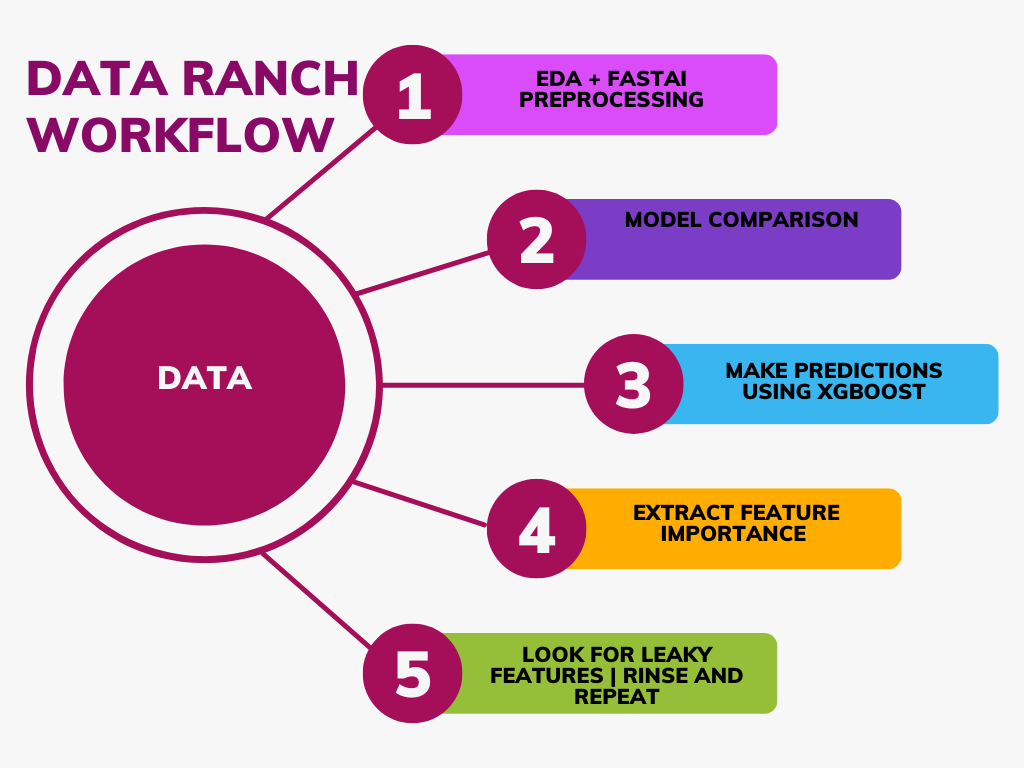

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.0 MB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.1 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
# For Styling
plt.style.use('seaborn-bright')

In [10]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'oil-spill-detection'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 20000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = False
SEP_COMMA = False
SHUFFLE_DATA = True

In [11]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/oil-spill-detection
CSV!


In [12]:
df

f_1    f_2     f_3    f_4  f_5       f_6   f_7   f_8      f_9  f_10  ...  \
0      1   2558 1506.09 456.63   90   6395000 40.88  7.89 29780.00  0.19  ...   
1      2  22325   79.11 841.03  180  55812500 51.11  1.21 61900.00  0.02  ...   
2      3    115 1449.85 608.43   88    287500 40.42  7.34  3340.00  0.18  ...   
3      4   1201 1562.53 295.65   66   3002500 42.40  7.97 18030.00  0.19  ...   
4      5    312  950.27 440.86   37    780000 41.43  7.03  3350.00  0.17  ...   
..   ...    ...     ...    ...  ...       ...   ...   ...      ...   ...  ...   
932  200     12   92.42 364.42  135     97200 59.42 10.34   884.00  0.17  ...   
933  201     11   98.82 248.64  159     89100 59.64 10.18   831.00  0.17  ...   
934  202     14   25.14 428.86   24    113400 60.14 17.94   847.00  0.30  ...   
935  203     10   96.00 451.30   68     81000 59.90 15.01   831.00  0.25  ...   
936  204     11    7.73 235.73  135     89100 61.82 12.24   831.00  0.20  ...   

       f_41     f_42    f_43    f_44  f_45  f_46     f_47  f_48  f_49  target  
0   2850.00  1000.00  763.16  135.46  3.73     0 33243.19 65.74  7.95       1  
1   5750.00 11500.00 9593.48 1648.80  0.60     0 51572.04 65.73  6.26       0  
2   1400.00   250.00  150.00   45.13  9.33     1 31692.84 65.81  7.84       1  
3   6041.52   761.58  453.21  144.97 13.33     1 37696.21 65.67  8.07       1  
4   1320.04   710.63  512.54  109.16  2.58     0 29038.17 65.66  7.35       0  
..      ...      ...     ...     ...   ...   ...      ...   ...   ...     ...  
932  381.84   254.56   84.85  146.97  4.50     0  2593.50 65.85  6.39       0  
933  284.60   180.00  150.00   51.96  1.90     0  4361.25 65.70  6.53       0  
934  402.49   180.00  180.00    0.00  2.24     0  2153.05 65.91  6.12       0  
935  402.49   180.00   90.00   73.48  4.47     0  2421.43 65.97  6.32       0  
936  254.56   254.56  127.28  180.00  2.00     0  3782.68 65.65  6.26       0  

[937 rows x 50 columns]

In [13]:
if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_no_dollar'] = df[col + '_no_dollar'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')


if SEP_COMMA:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string() or ',' in df[col].to_string():
            df[col + '_processed'] = df[col].str.replace('%', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_processed'] = df[col + '_processed'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')

In [14]:
df

f_1    f_2     f_3    f_4  f_5       f_6   f_7   f_8      f_9  f_10  ...  \
0      1   2558 1506.09 456.63   90   6395000 40.88  7.89 29780.00  0.19  ...   
1      2  22325   79.11 841.03  180  55812500 51.11  1.21 61900.00  0.02  ...   
2      3    115 1449.85 608.43   88    287500 40.42  7.34  3340.00  0.18  ...   
3      4   1201 1562.53 295.65   66   3002500 42.40  7.97 18030.00  0.19  ...   
4      5    312  950.27 440.86   37    780000 41.43  7.03  3350.00  0.17  ...   
..   ...    ...     ...    ...  ...       ...   ...   ...      ...   ...  ...   
932  200     12   92.42 364.42  135     97200 59.42 10.34   884.00  0.17  ...   
933  201     11   98.82 248.64  159     89100 59.64 10.18   831.00  0.17  ...   
934  202     14   25.14 428.86   24    113400 60.14 17.94   847.00  0.30  ...   
935  203     10   96.00 451.30   68     81000 59.90 15.01   831.00  0.25  ...   
936  204     11    7.73 235.73  135     89100 61.82 12.24   831.00  0.20  ...   

       f_41     f_42    f_43    f_44  f_45  f_46     f_47  f_48  f_49  target  
0   2850.00  1000.00  763.16  135.46  3.73     0 33243.19 65.74  7.95       1  
1   5750.00 11500.00 9593.48 1648.80  0.60     0 51572.04 65.73  6.26       0  
2   1400.00   250.00  150.00   45.13  9.33     1 31692.84 65.81  7.84       1  
3   6041.52   761.58  453.21  144.97 13.33     1 37696.21 65.67  8.07       1  
4   1320.04   710.63  512.54  109.16  2.58     0 29038.17 65.66  7.35       0  
..      ...      ...     ...     ...   ...   ...      ...   ...   ...     ...  
932  381.84   254.56   84.85  146.97  4.50     0  2593.50 65.85  6.39       0  
933  284.60   180.00  150.00   51.96  1.90     0  4361.25 65.70  6.53       0  
934  402.49   180.00  180.00    0.00  2.24     0  2153.05 65.91  6.12       0  
935  402.49   180.00   90.00   73.48  4.47     0  2421.43 65.97  6.32       0  
936  254.56   254.56  127.28  180.00  2.00     0  3782.68 65.65  6.26       0  

[937 rows x 50 columns]

In [15]:
df.isna().sum()

f_1       0
f_2       0
f_3       0
f_4       0
f_5       0
f_6       0
f_7       0
f_8       0
f_9       0
f_10      0
f_11      0
f_12      0
f_13      0
f_14      0
f_15      0
f_16      0
f_17      0
f_18      0
f_19      0
f_20      0
f_21      0
f_22      0
f_23      0
f_24      0
f_25      0
f_26      0
f_27      0
f_28      0
f_29      0
f_30      0
f_31      0
f_32      0
f_33      0
f_34      0
f_35      0
f_36      0
f_37      0
f_38      0
f_39      0
f_40      0
f_41      0
f_42      0
f_43      0
f_44      0
f_45      0
f_46      0
f_47      0
f_48      0
f_49      0
target    0
dtype: int64

<AxesSubplot:>

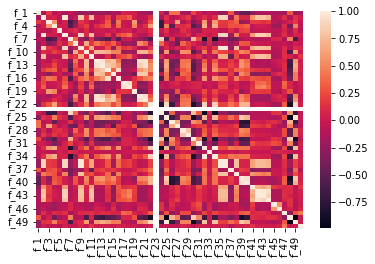

In [16]:
sns.heatmap(df.corr())

In [17]:
df.head().style.background_gradient(cmap = "inferno")

In [18]:
df.describe().T.style.background_gradient(cmap = "viridis")

In [19]:
df.columns

Index(['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10',
       'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19',
       'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28',
       'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34', 'f_35', 'f_36', 'f_37',
       'f_38', 'f_39', 'f_40', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_46',
       'f_47', 'f_48', 'f_49', 'target'],
      dtype='object')

Target Variable: target
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
50
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', '

  5%|▍         | 2/42 [00:00<00:07,  5.63it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.11331470649196662, 'Adjusted R-Squared': -0.5115075577190202, 'RMSE': 0.2135201547025403, 'Time taken': 0.280444860458374}
{'Model': 'BaggingRegressor', 'R-Squared': -0.01465782122905046, 'Adjusted R-Squared': -0.37756463320148437, 'RMSE': 0.2038401386847974, 'Time taken': 0.10410189628601074}
{'Model': 'BayesianRidge', 'R-Squared': -0.12634285084007435, 'Adjusted R-Squared': -0.5291954033303199, 'RMSE': 0.21476584044394928, 'Time taken': 0.057309627532958984}


 10%|▉         | 4/42 [00:00<00:04,  8.54it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.30586592178770977, 'Adjusted R-Squared': -0.7729274558577663, 'RMSE': 0.23124864503144013, 'Time taken': 0.10318136215209961}
{'Model': 'DummyRegressor', 'R-Squared': -3.630167597790113e-05, 'Adjusted R-Squared': -0.3577135190637364, 'RMSE': 0.202366110751649, 'Time taken': 0.013052225112915039}
{'Model': 'ElasticNet', 'R-Squared': -3.630167597790113e-05, 'Adjusted R-Squared': -0.3577135190637364, 'RMSE': 0.202366110751649, 'Time taken': 0.019812345504760742}


 17%|█▋        | 7/42 [00:01<00:08,  4.24it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -0.12814842675474458, 'Adjusted R-Squared': -0.531646769170675, 'RMSE': 0.2149379109407539, 'Time taken': 0.936953067779541}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.04469273743016777, 'Adjusted R-Squared': -0.418341964686213, 'RMSE': 0.20683507599800766, 'Time taken': 0.030467987060546875}


 21%|██▏       | 9/42 [00:01<00:06,  4.80it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.09870335195530733, 'Adjusted R-Squared': -0.4916702442604901, 'RMSE': 0.21211438746342492, 'Time taken': 0.28292250633239746}
{'Model': 'GammaRegressor', 'R-Squared': 0.09720916650097844, 'Adjusted R-Squared': -0.22568682504246707, 'RMSE': 0.19227528902669572, 'Time taken': 0.02543044090270996}


 26%|██▌       | 11/42 [00:02<00:05,  5.61it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -15.596592391382298, 'Adjusted R-Squared': -21.53259988902998, 'RMSE': 0.8244026258854003, 'Time taken': 0.2112901210784912}


 29%|██▊       | 12/42 [00:02<00:08,  3.52it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.060301416095010385, 'Adjusted R-Squared': -0.4395333094428606, 'RMSE': 0.20837450116576667, 'Time taken': 0.7239794731140137}


 33%|███▎      | 14/42 [00:03<00:08,  3.49it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.2124502097491987, 'Adjusted R-Squared': -0.646100284768985, 'RMSE': 0.22282394499342734, 'Time taken': 0.5137841701507568}
{'Model': 'HuberRegressor', 'R-Squared': -0.030037738428661198, 'Adjusted R-Squared': -0.3984453966987662, 'RMSE': 0.2053792061109838, 'Time taken': 0.13200592994689941}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.02843575418994404, 'Adjusted R-Squared': -0.319058027158178, 'RMSE': 0.1994645238048222, 'Time taken': 0.031889915466308594}


 40%|████      | 17/42 [00:03<00:04,  6.01it/s]

{'Model': 'KernelRidge', 'R-Squared': -27.241185999035775, 'Adjusted R-Squared': -37.342048144676305, 'RMSE': 1.0754033078821033, 'Time taken': 0.06206822395324707}
{'Model': 'Lars', 'R-Squared': -335.67668768029864, 'Adjusted R-Squared': -456.0938971425952, 'RMSE': 3.713098116453938, 'Time taken': 0.04555630683898926}


 45%|████▌     | 19/42 [00:03<00:03,  6.75it/s]

{'Model': 'LarsCV', 'R-Squared': 0.12684631139957347, 'Adjusted R-Squared': -0.18544953342831616, 'RMSE': 0.189092911560208, 'Time taken': 0.1756272315979004}
{'Model': 'Lasso', 'R-Squared': -3.630167597790113e-05, 'Adjusted R-Squared': -0.3577135190637364, 'RMSE': 0.202366110751649, 'Time taken': 0.04062628746032715}


 48%|████▊     | 20/42 [00:04<00:06,  3.29it/s]

{'Model': 'LassoCV', 'R-Squared': -0.13177062200811052, 'Adjusted R-Squared': -0.5365644941132011, 'RMSE': 0.21528268966614775, 'Time taken': 0.9737269878387451}
{'Model': 'LassoLars', 'R-Squared': -3.630167597790113e-05, 'Adjusted R-Squared': -0.3577135190637364, 'RMSE': 0.202366110751649, 'Time taken': 0.025824546813964844}


 57%|█████▋    | 24/42 [00:05<00:03,  5.59it/s]

{'Model': 'LassoLarsCV', 'R-Squared': -0.12612566953878712, 'Adjusted R-Squared': -0.5289005440453605, 'RMSE': 0.21474513388319286, 'Time taken': 0.22278833389282227}
{'Model': 'LassoLarsIC', 'R-Squared': -0.14018222315575368, 'Adjusted R-Squared': -0.5479846241384685, 'RMSE': 0.21608122596717577, 'Time taken': 0.07278060913085938}
{'Model': 'LinearRegression', 'R-Squared': -0.3179846907960182, 'Adjusted R-Squared': -0.7893806750953238, 'RMSE': 0.23231919025407802, 'Time taken': 0.029527902603149414}
{'Model': 'LinearSVR', 'R-Squared': -0.13247057964724585, 'Adjusted R-Squared': -0.5375148015648739, 'RMSE': 0.21534925150679013, 'Time taken': 0.2178492546081543}


 62%|██████▏   | 26/42 [00:06<00:04,  3.39it/s]

{'Model': 'MLPRegressor', 'R-Squared': -9.546395146074344, 'Adjusted R-Squared': -13.318463482991444, 'RMSE': 0.6571763440734688, 'Time taken': 0.8581283092498779}


 71%|███████▏  | 30/42 [00:06<00:02,  5.48it/s]

{'Model': 'NuSVR', 'R-Squared': 0.11735346459052798, 'Adjusted R-Squared': -0.19833763201577947, 'RMSE': 0.19011803322971285, 'Time taken': 0.32678675651550293}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.018541225994842425, 'Adjusted R-Squared': -0.33249147419678327, 'RMSE': 0.20047763638291183, 'Time taken': 0.021379470825195312}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.014801218086614165, 'Adjusted R-Squared': -0.377759317986206, 'RMSE': 0.2038545420639751, 'Time taken': 0.04517006874084473}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1.2262666046485218, 'Adjusted R-Squared': -2.022522543537409, 'RMSE': 0.30193849659369687, 'Time taken': 0.03379011154174805}
{'Model': 'PoissonRegressor', 'R-Squared': 0.10253953968512874, 'Adjusted R-Squared': -0.21844996801873018, 'RMSE': 0.19170682049321544, 'Time taken': 0.033715248107910156}


 76%|███████▌  | 32/42 [00:14<00:13,  1.32s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.04469273743944635, 'Adjusted R-Squared': -0.41834196469881024, 'RMSE': 0.20683507599892617, 'Time taken': 7.934476375579834}


 79%|███████▊  | 33/42 [00:14<00:10,  1.12s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -0.04469273743016777, 'Adjusted R-Squared': -0.418341964686213, 'RMSE': 0.20683507599800766, 'Time taken': 0.20381999015808105}


 90%|█████████ | 38/42 [00:15<00:02,  1.92it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.015220391061452343, 'Adjusted R-Squared': -0.33700005301145874, 'RMSE': 0.20081651507600845, 'Time taken': 0.9003891944885254}
{'Model': 'Ridge', 'R-Squared': -0.20709029616043395, 'Adjusted R-Squared': -0.6388233217944577, 'RMSE': 0.2223308773422013, 'Time taken': 0.02103590965270996}
{'Model': 'RidgeCV', 'R-Squared': -0.11926690314728017, 'Adjusted R-Squared': -0.519588642229154, 'RMSE': 0.2140901731231138, 'Time taken': 0.03502535820007324}
{'Model': 'SGDRegressor', 'R-Squared': -0.04912466715700026, 'Adjusted R-Squared': -0.4243590371620587, 'RMSE': 0.2072733428361819, 'Time taken': 0.029630184173583984}
{'Model': 'SVR', 'R-Squared': 0.03757201849723979, 'Adjusted R-Squared': -0.3066540478796598, 'RMSE': 0.19852445983215075, 'Time taken': 0.05621933937072754}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.3179846907960182, 'Adjusted R-Squared': -0.7893806750953238, 'RMSE': 0.23231919025407802, 'Time taken': 0.03088498115539

 98%|█████████▊| 41/42 [00:16<00:00,  2.40it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.19849071450468503, 'Adjusted R-Squared': -0.6271479773567255, 'RMSE': 0.22153749, 'Time taken': 0.599123477935791}


100%|██████████| 42/42 [00:16<00:00,  2.49it/s]

{'Model': 'LGBMRegressor', 'R-Squared': -0.1682401309433128, 'Adjusted R-Squared': -0.586077842010629, 'RMSE': 0.2187237599013442, 'Time taken': 0.30200958251953125}
Project: oil-spill-detection
oil-spill-detection
Target: target
target
Target Standard Deviation: 0.20509509989270833
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LarsCV                                      -0.19       0.13  0.19        0.18
NuSVR                                       -0.20       0.12  0.19        0.33
PoissonRegressor                            -0.22       0.10  0.19        0.03
TweedieRegressor                            -0.22       0.10  0.19        0.06
GammaRegressor                              -0.23       0.10  0.19        0.03
SVR                                         -0.31       0.04  0.20        0.06
KNeighborsRegressor                         -0.32       0.03  0.20        0.03
Ortho

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.4338700771331787.
Better model found at epoch 1 with _rmse value: 1.2695860862731934.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       2       1.99
XGBoost RMSE:  0.22578636


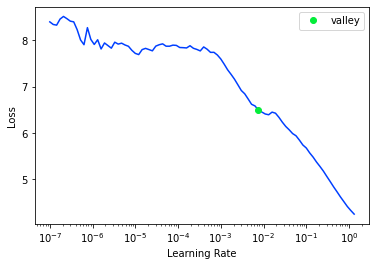

<Figure size 720x720 with 0 Axes>

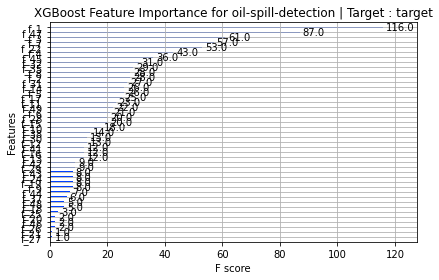

Target Variable: f_49
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:08,  4.66it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9970942475394438, 'Adjusted R-Squared': 0.9960549638126754, 'RMSE': 0.15409932944899193, 'Time taken': 0.3099203109741211}
{'Model': 'BaggingRegressor', 'R-Squared': 0.99078124080925, 'Adjusted R-Squared': 0.9874840203687628, 'RMSE': 0.27447808631861, 'Time taken': 0.14625811576843262}
{'Model': 'BayesianRidge', 'R-Squared': 0.9971815938978638, 'Adjusted R-Squared': 0.9961735508394355, 'RMSE': 0.15176555940413716, 'Time taken': 0.04678153991699219}


 10%|▉         | 4/42 [00:00<00:04,  8.07it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9985033511143744, 'Adjusted R-Squared': 0.9979680533377637, 'RMSE': 0.11059395902212861, 'Time taken': 0.0910956859588623}
{'Model': 'DummyRegressor', 'R-Squared': -0.0009044012733399054, 'Adjusted R-Squared': -0.3588921068382569, 'RMSE': 2.860011, 'Time taken': 0.01675128936767578}
{'Model': 'ElasticNet', 'R-Squared': 0.8900279640796499, 'Adjusted R-Squared': 0.850694900137335, 'RMSE': 0.948009248997166, 'Time taken': 0.018605947494506836}


 17%|█▋        | 7/42 [00:00<00:03,  9.39it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9969605059907581, 'Adjusted R-Squared': 0.9958733876954818, 'RMSE': 0.15760576077050292, 'Time taken': 0.23929333686828613}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9989975885884999, 'Adjusted R-Squared': 0.9986390618792772, 'RMSE': 0.09050955774815846, 'Time taken': 0.03825712203979492}


 21%|██▏       | 9/42 [00:01<00:06,  4.84it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9998495971135181, 'Adjusted R-Squared': 0.9997958033803968, 'RMSE': 0.035059000241493096, 'Time taken': 0.7361588478088379}
{'Model': 'GammaRegressor', 'R-Squared': 0.9308958789190436, 'Adjusted R-Squared': 0.9061798064156358, 'RMSE': 0.7514903630084041, 'Time taken': 0.018602848052978516}


 26%|██▌       | 11/42 [00:01<00:05,  5.72it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -4.807261476431625, 'Adjusted R-Squared': -6.8843112015787025, 'RMSE': 6.889015029992697, 'Time taken': 0.2018721103668213}


 29%|██▊       | 12/42 [00:02<00:08,  3.59it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9964063285155546, 'Adjusted R-Squared': 0.9951210007583441, 'RMSE': 0.17137230122943828, 'Time taken': 0.7065629959106445}


 33%|███▎      | 14/42 [00:03<00:07,  3.54it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9997013397614032, 'Adjusted R-Squared': 0.9995945196760656, 'RMSE': 0.04940377619757198, 'Time taken': 0.49677324295043945}
{'Model': 'HuberRegressor', 'R-Squared': 0.9972802885423979, 'Adjusted R-Squared': 0.996307545028365, 'RMSE': 0.14908462499507766, 'Time taken': 0.14012598991394043}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9646265288560044, 'Adjusted R-Squared': 0.9519747034103417, 'RMSE': 0.53766316, 'Time taken': 0.030803918838500977}


 38%|███▊      | 16/42 [00:03<00:04,  5.24it/s]

{'Model': 'KernelRidge', 'R-Squared': -7.110319216695606, 'Adjusted R-Squared': -10.011090323396953, 'RMSE': 8.141237340318225, 'Time taken': 0.0768277645111084}
{'Model': 'Lars', 'R-Squared': -4.338736768150881, 'Adjusted R-Squared': -6.248211962599005, 'RMSE': 6.605271841914916, 'Time taken': 0.048536062240600586}


 43%|████▎     | 18/42 [00:03<00:03,  6.26it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9900974495026474, 'Adjusted R-Squared': 0.9865556613685579, 'RMSE': 0.28447556894622167, 'Time taken': 0.15746569633483887}
{'Model': 'Lasso', 'R-Squared': 0.8552706606494889, 'Adjusted R-Squared': 0.8035061524146345, 'RMSE': 1.0875512493785864, 'Time taken': 0.02768850326538086}


 48%|████▊     | 20/42 [00:03<00:03,  7.05it/s]

{'Model': 'LassoCV', 'R-Squared': 0.997249361259009, 'Adjusted R-Squared': 0.9962655561618662, 'RMSE': 0.1499298890252649, 'Time taken': 0.18442869186401367}
{'Model': 'LassoLars', 'R-Squared': -0.000904397499240428, 'Adjusted R-Squared': -0.3588921017142972, 'RMSE': 2.8600112435862584, 'Time taken': 0.02646613121032715}


 57%|█████▋    | 24/42 [00:04<00:02,  8.44it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9971491222554203, 'Adjusted R-Squared': 0.9961294652518845, 'RMSE': 0.15263732229952626, 'Time taken': 0.2573227882385254}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9971959035009944, 'Adjusted R-Squared': 0.9961929784758026, 'RMSE': 0.15137979730870776, 'Time taken': 0.08566093444824219}
{'Model': 'LinearRegression', 'R-Squared': 0.9972180818980098, 'Adjusted R-Squared': 0.9962230892921884, 'RMSE': 0.15077995593180746, 'Time taken': 0.042021989822387695}
{'Model': 'LinearSVR', 'R-Squared': 0.9973006715685819, 'Adjusted R-Squared': 0.9963352183339872, 'RMSE': 0.14852491288890707, 'Time taken': 0.1844921112060547}


 64%|██████▍   | 27/42 [00:06<00:04,  3.09it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.8318483855874989, 'Adjusted R-Squared': 0.7717065672939766, 'RMSE': 1.1722546454755776, 'Time taken': 1.6166703701019287}
{'Model': 'NuSVR', 'R-Squared': 0.9175519662272824, 'Adjusted R-Squared': 0.8880632534180622, 'RMSE': 0.8208458244406143, 'Time taken': 0.1404860019683838}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9956234776061004, 'Adjusted R-Squared': 0.9940581520783552, 'RMSE': 0.18911937298245274, 'Time taken': 0.019411325454711914}


 71%|███████▏  | 30/42 [00:06<00:02,  5.07it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9953812786673106, 'Adjusted R-Squared': 0.9937293272417502, 'RMSE': 0.19428189098645385, 'Time taken': 0.04791665077209473}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9953486637467718, 'Adjusted R-Squared': 0.9936850471306536, 'RMSE': 0.1949666412762652, 'Time taken': 0.03726959228515625}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9801795292440797, 'Adjusted R-Squared': 0.9730904557620352, 'RMSE': 0.40246528365092343, 'Time taken': 0.04817342758178711}


 76%|███████▌  | 32/42 [00:17<00:18,  1.87s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.080464013344405, 'Adjusted R-Squared': -0.4669073465843745, 'RMSE': 2.9715058876176785, 'Time taken': 11.689060926437378}


 79%|███████▊  | 33/42 [00:18<00:14,  1.61s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.9965417038823288, 'Adjusted R-Squared': 0.9953047950519208, 'RMSE': 0.16811347694120773, 'Time taken': 0.36977696418762207}


 88%|████████▊ | 37/42 [00:19<00:04,  1.10it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9968844226526391, 'Adjusted R-Squared': 0.9957700920685465, 'RMSE': 0.15956612943543746, 'Time taken': 1.332019329071045}
{'Model': 'Ridge', 'R-Squared': 0.9969838832921432, 'Adjusted R-Squared': 0.9959051262214499, 'RMSE': 0.15699850359610185, 'Time taken': 0.018590211868286133}
{'Model': 'RidgeCV', 'R-Squared': 0.9969838832922292, 'Adjusted R-Squared': 0.9959051262215667, 'RMSE': 0.15699850359386433, 'Time taken': 0.0511777400970459}
{'Model': 'SGDRegressor', 'R-Squared': 0.9869331598131152, 'Adjusted R-Squared': 0.9822596184324046, 'RMSE': 0.32678095043169997, 'Time taken': 0.09384465217590332}


 95%|█████████▌| 40/42 [00:19<00:01,  1.81it/s]

{'Model': 'SVR', 'R-Squared': 0.9184403814868212, 'Adjusted R-Squared': 0.8892694230405017, 'RMSE': 0.8164113516911725, 'Time taken': 0.049747467041015625}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9972180818980098, 'Adjusted R-Squared': 0.9962230892921884, 'RMSE': 0.15077995593180746, 'Time taken': 0.02590322494506836}
{'Model': 'TweedieRegressor', 'R-Squared': 0.9372121932392676, 'Adjusted R-Squared': 0.914755240456232, 'RMSE': 0.7163233338599366, 'Time taken': 0.03268861770629883}
{'Model': 'XGBRegressor', 'R-Squared': 0.9993012345930266, 'Adjusted R-Squared': 0.9990513111992916, 'RMSE': 0.075567864, 'Time taken': 0.7068324089050293}


100%|██████████| 42/42 [00:20<00:00,  2.01it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9997052960845605, 'Adjusted R-Squared': 0.9995998910345127, 'RMSE': 0.04907546177425475, 'Time taken': 0.20624613761901855}
Project: oil-spill-detection
oil-spill-detection
Target: f_49
f_49
Target Standard Deviation: 2.9190866947174072
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          1.00       1.00  0.04        0.74
LGBMRegressor                                1.00       1.00  0.05        0.21
HistGradientBoostingRegressor                1.00       1.00  0.05        0.50
XGBRegressor                                 1.00       1.00  0.08        0.71
ExtraTreeRegressor                           1.00       1.00  0.09        0.04
DecisionTreeRegressor                        1.00       1.00  0.11        0.09
LinearSVR                                    1.00       1.00  0.15        0.18
HuberRegre

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 6.324732303619385.
Better model found at epoch 1 with _rmse value: 5.738070487976074.
Better model found at epoch 2 with _rmse value: 3.5651018619537354.
No improvement since epoch 2: early stopping


<Figure size 432x288 with 0 Axes>

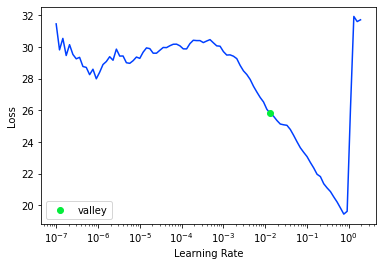

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    7.48       7.54
1    7.03       7.02
2    6.46       6.75
3   14.90      14.89
4   15.23      15.33
XGBoost RMSE:  0.07558106


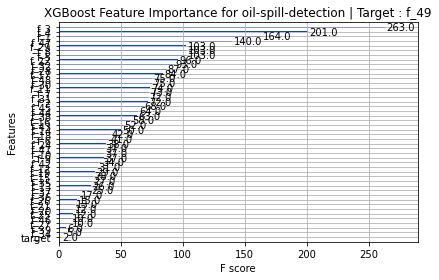

Target Variable: f_48
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:08,  4.51it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.999906937403348, 'Adjusted R-Squared': 0.9998736522410419, 'RMSE': 0.09344984836789427, 'Time taken': 0.3275296688079834}
{'Model': 'BaggingRegressor', 'R-Squared': 0.995425499328799, 'Adjusted R-Squared': 0.9937893640522381, 'RMSE': 0.6551833703676504, 'Time taken': 0.14598441123962402}
{'Model': 'BayesianRidge', 'R-Squared': 0.9976617606902037, 'Adjusted R-Squared': 0.9968254561195466, 'RMSE': 0.46842007220348475, 'Time taken': 0.045970916748046875}


 10%|▉         | 4/42 [00:00<00:05,  7.54it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9999888531006039, 'Adjusted R-Squared': 0.9999848662533747, 'RMSE': 0.032342088317050634, 'Time taken': 0.11228251457214355}
{'Model': 'DummyRegressor', 'R-Squared': -0.007651273241076062, 'Adjusted R-Squared': -0.36805209359737323, 'RMSE': 9.724027, 'Time taken': 0.013644933700561523}
{'Model': 'ElasticNet', 'R-Squared': 0.944233416560886, 'Adjusted R-Squared': 0.9242877042359474, 'RMSE': 2.2875891972719153, 'Time taken': 0.02010941505432129}


 17%|█▋        | 7/42 [00:00<00:04,  8.29it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9944164709434883, 'Adjusted R-Squared': 0.9924194423028381, 'RMSE': 0.7238447156435671, 'Time taken': 0.29562926292419434}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9999460724872353, 'Adjusted R-Squared': 0.9999267845447136, 'RMSE': 0.07113710925393095, 'Time taken': 0.059800148010253906}


 21%|██▏       | 9/42 [00:01<00:06,  4.73it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.999805876329514, 'Adjusted R-Squared': 0.9997364452356906, 'RMSE': 0.13496782991811815, 'Time taken': 0.694016695022583}
{'Model': 'GammaRegressor', 'R-Squared': 0.9343227072407752, 'Adjusted R-Squared': 0.9108322886626582, 'RMSE': 2.482553630491405, 'Time taken': 0.027948379516601562}


 26%|██▌       | 11/42 [00:01<00:05,  5.63it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -20.202259382124314, 'Adjusted R-Squared': -27.78554923412498, 'RMSE': 44.60485065111466, 'Time taken': 0.19096088409423828}


 29%|██▊       | 12/42 [00:02<00:08,  3.54it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999279598257016, 'Adjusted R-Squared': 0.9999021936319744, 'RMSE': 0.08222017473480885, 'Time taken': 0.7200644016265869}


 33%|███▎      | 14/42 [00:03<00:07,  3.50it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9999940744683465, 'Adjusted R-Squared': 0.9999919551176092, 'RMSE': 0.023580590649958735, 'Time taken': 0.510277509689331}
{'Model': 'HuberRegressor', 'R-Squared': 0.9974349766395145, 'Adjusted R-Squared': 0.9965175595251803, 'RMSE': 0.49061032108156893, 'Time taken': 0.1329641342163086}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9916003112663168, 'Adjusted R-Squared': 0.9885960430331016, 'RMSE': 0.8878153, 'Time taken': 0.0329737663269043}


 38%|███▊      | 16/42 [00:03<00:05,  5.15it/s]

{'Model': 'KernelRidge', 'R-Squared': -39.23545518661454, 'Adjusted R-Squared': -53.62623842854236, 'RMSE': 61.44626328670394, 'Time taken': 0.08104372024536133}
{'Model': 'Lars', 'R-Squared': -31202.216466942093, 'Adjusted R-Squared': -42362.490969717, 'RMSE': 1711.160316380753, 'Time taken': 0.049965858459472656}


 43%|████▎     | 18/42 [00:03<00:04,  5.45it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9957726073652763, 'Adjusted R-Squared': 0.9942606202185503, 'RMSE': 0.6298357547067814, 'Time taken': 0.2745828628540039}
{'Model': 'Lasso', 'R-Squared': 0.9691596369610905, 'Adjusted R-Squared': 0.9581291421515535, 'RMSE': 1.701181921547836, 'Time taken': 0.030508756637573242}


 48%|████▊     | 20/42 [00:04<00:03,  5.97it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9968965179194434, 'Adjusted R-Squared': 0.9957865133796824, 'RMSE': 0.5396542964220779, 'Time taken': 0.23294734954833984}
{'Model': 'LassoLars', 'R-Squared': -0.007651276573423571, 'Adjusted R-Squared': -0.36805209812158224, 'RMSE': 9.724026812451786, 'Time taken': 0.05047464370727539}


 57%|█████▋    | 24/42 [00:04<00:02,  7.80it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.997527960650124, 'Adjusted R-Squared': 0.9966438005906793, 'RMSE': 0.4816357414112315, 'Time taken': 0.2367110252380371}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9976267220373938, 'Adjusted R-Squared': 0.9967778853938339, 'RMSE': 0.4719166728099342, 'Time taken': 0.06936502456665039}
{'Model': 'LinearRegression', 'R-Squared': 0.9976791132753565, 'Adjusted R-Squared': 0.9968490151037687, 'RMSE': 0.46667871154675356, 'Time taken': 0.04900479316711426}
{'Model': 'LinearSVR', 'R-Squared': 0.9974733511940123, 'Adjusted R-Squared': 0.9965696592853013, 'RMSE': 0.48692655339667396, 'Time taken': 0.14580798149108887}


 64%|██████▍   | 27/42 [00:06<00:04,  3.08it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.4868743625062232, 'Adjusted R-Squared': 0.30334767464348555, 'RMSE': 6.939095666390155, 'Time taken': 1.6342523097991943}
{'Model': 'NuSVR', 'R-Squared': 0.8832903454552513, 'Adjusted R-Squared': 0.8415474763115091, 'RMSE': 3.309363020846419, 'Time taken': 0.12437200546264648}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9961322302710587, 'Adjusted R-Squared': 0.994748867375306, 'RMSE': 0.6024504359675181, 'Time taken': 0.0203092098236084}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9962855870892905, 'Adjusted R-Squared': 0.9949570744423943, 'RMSE': 0.5903860784034974, 'Time taken': 0.045081377029418945}


 71%|███████▏  | 30/42 [00:06<00:02,  5.07it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9913322446462446, 'Adjusted R-Squared': 0.9882320985708138, 'RMSE': 0.9018708300619634, 'Time taken': 0.038172006607055664}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9912227216910485, 'Adjusted R-Squared': 0.9880834031717886, 'RMSE': 0.907550817923423, 'Time taken': 0.0688478946685791}


 76%|███████▌  | 32/42 [00:21<00:22,  2.28s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.13410126828813485, 'Adjusted R-Squared': -0.5397287292087085, 'RMSE': 10.316133080896645, 'Time taken': 14.465728759765625}


 79%|███████▊  | 33/42 [00:21<00:17,  1.94s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -564.9662262580731, 'Adjusted R-Squared': -767.3921028029313, 'RMSE': 230.4550746514546, 'Time taken': 0.3130459785461426}


 88%|████████▊ | 37/42 [00:22<00:05,  1.06s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9988138052173968, 'Adjusted R-Squared': 0.9983895457696045, 'RMSE': 0.33363301695776404, 'Time taken': 1.3744816780090332}
{'Model': 'Ridge', 'R-Squared': 0.9972392798713842, 'Adjusted R-Squared': 0.9962518690224632, 'RMSE': 0.5089817479248195, 'Time taken': 0.019202709197998047}
{'Model': 'RidgeCV', 'R-Squared': 0.9976503551970548, 'Adjusted R-Squared': 0.996809971289432, 'RMSE': 0.4695611151111206, 'Time taken': 0.050657033920288086}
{'Model': 'SGDRegressor', 'R-Squared': 0.9947949181084482, 'Adjusted R-Squared': 0.9929332464830027, 'RMSE': 0.6988835225050589, 'Time taken': 0.11644673347473145}


 95%|█████████▌| 40/42 [00:23<00:01,  1.54it/s]

{'Model': 'SVR', 'R-Squared': 0.8790550856385206, 'Adjusted R-Squared': 0.8357974155384295, 'RMSE': 3.368874430410782, 'Time taken': 0.05942392349243164}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9976791132753565, 'Adjusted R-Squared': 0.9968490151037687, 'RMSE': 0.46667871154675356, 'Time taken': 0.02303290367126465}
{'Model': 'TweedieRegressor', 'R-Squared': 0.9453534779159584, 'Adjusted R-Squared': 0.9258083714771406, 'RMSE': 2.264499772819228, 'Time taken': 0.05656766891479492}
{'Model': 'XGBRegressor', 'R-Squared': 0.9999894442624522, 'Adjusted R-Squared': 0.9999856688526723, 'RMSE': 0.031472795, 'Time taken': 0.6821107864379883}


100%|██████████| 42/42 [00:23<00:00,  1.75it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9999930853910955, 'Adjusted R-Squared': 0.9999906122828013, 'RMSE': 0.025472691067501087, 'Time taken': 0.21117234230041504}
Project: oil-spill-detection
oil-spill-detection
Target: f_48
f_48
Target Standard Deviation: 10.57241439819336
                               Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
HistGradientBoostingRegressor                1.00       1.00    0.02   
LGBMRegressor                                1.00       1.00    0.03   
XGBRegressor                                 1.00       1.00    0.03   
DecisionTreeRegressor                        1.00       1.00    0.03   
ExtraTreeRegressor                           1.00       1.00    0.07   
GradientBoostingRegressor                    1.00       1.00    0.08   
AdaBoostRegressor                            1.00       1.00    0.09   
ExtraTreesRegressor                          1.00       1.00    0.13   
R

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 59.20237731933594.
Better model found at epoch 1 with _rmse value: 37.19347381591797.
Better model found at epoch 2 with _rmse value: 17.462472915649414.
Better model found at epoch 3 with _rmse value: 16.897689819335938.
No improvement since epoch 3: early stopping


<Figure size 432x288 with 0 Axes>

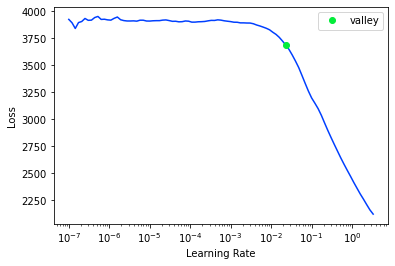

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   36.49      36.47
1   66.36      66.36
2   66.07      66.08
3   66.18      66.19
4   66.14      66.16
XGBoost RMSE:  0.03146252


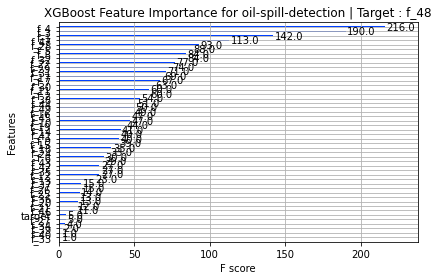

Target Variable: f_47
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  2%|▏         | 1/42 [00:00<00:08,  4.98it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.1661900481173718, 'Adjusted R-Squared': -0.1320339492713054, 'RMSE': 5694.410944976235, 'Time taken': 0.2006239891052246}


 10%|▉         | 4/42 [00:00<00:05,  7.49it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.780522202816339, 'Adjusted R-Squared': 0.7020228446995551, 'RMSE': 2921.531441796069, 'Time taken': 0.20912909507751465}
{'Model': 'BayesianRidge', 'R-Squared': 0.42571275011036924, 'Adjusted R-Squared': 0.22031074102575687, 'RMSE': 4725.849157169744, 'Time taken': 0.06117057800292969}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.7825188783521955, 'Adjusted R-Squared': 0.7047336596606449, 'RMSE': 2908.2119211113622, 'Time taken': 0.11795711517333984}
{'Model': 'DummyRegressor', 'R-Squared': -4.8612036243067536e-06, 'Adjusted R-Squared': -0.35767083345893513, 'RMSE': 6236.1465, 'Time taken': 0.013834238052368164}


 17%|█▋        | 7/42 [00:00<00:03,  9.90it/s]

{'Model': 'ElasticNet', 'R-Squared': 0.334923350559053, 'Adjusted R-Squared': 0.09704922046703546, 'RMSE': 5085.704453608837, 'Time taken': 0.04248166084289551}
{'Model': 'ElasticNetCV', 'R-Squared': 0.23320858759059748, 'Adjusted R-Squared': -0.04104527524196255, 'RMSE': 5460.770042742637, 'Time taken': 0.17280936241149902}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.6244690918207001, 'Adjusted R-Squared': 0.49015511736241035, 'RMSE': 3821.537380547329, 'Time taken': 0.04537558555603027}


 26%|██▌       | 11/42 [00:01<00:05,  5.54it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9174357115116833, 'Adjusted R-Squared': 0.8879054185487087, 'RMSE': 1791.8901805469136, 'Time taken': 0.8462247848510742}
{'Model': 'GammaRegressor', 'R-Squared': 0.26041021538375864, 'Adjusted R-Squared': -0.004114598092123334, 'RMSE': 5363.036098715285, 'Time taken': 0.03905630111694336}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.0740902166121065, 'Adjusted R-Squared': -1.8159181043054873, 'RMSE': 8981.090852376139, 'Time taken': 0.14718890190124512}


 29%|██▊       | 12/42 [00:02<00:08,  3.50it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.754636777525999, 'Adjusted R-Squared': 0.6668791286119402, 'RMSE': 3089.0148893494015, 'Time taken': 0.7186667919158936}


 33%|███▎      | 14/42 [00:03<00:08,  3.48it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.7719143165293176, 'Adjusted R-Squared': 0.6903362253609714, 'RMSE': 2978.271470834491, 'Time taken': 0.5089447498321533}
{'Model': 'HuberRegressor', 'R-Squared': 0.39084810302815565, 'Adjusted R-Squared': 0.17297625666596317, 'RMSE': 4867.187407283901, 'Time taken': 0.13523340225219727}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.5115489844167183, 'Adjusted R-Squared': 0.3368475262883912, 'RMSE': 4358.3867, 'Time taken': 0.03100275993347168}


 38%|███▊      | 16/42 [00:03<00:05,  5.18it/s]

{'Model': 'KernelRidge', 'R-Squared': -1.2938668841985557, 'Adjusted R-Squared': -2.1143010252622725, 'RMSE': 9444.943712684484, 'Time taken': 0.07110357284545898}
{'Model': 'Lars', 'R-Squared': -3113.750154571954, 'Adjusted R-Squared': -4227.78488138966, 'RMSE': 348038.1698545116, 'Time taken': 0.09193706512451172}


 45%|████▌     | 19/42 [00:03<00:03,  6.25it/s]

{'Model': 'LarsCV', 'R-Squared': 0.3158346824515854, 'Adjusted R-Squared': 0.0711332185109117, 'RMSE': 5158.171714060557, 'Time taken': 0.15461468696594238}
{'Model': 'Lasso', 'R-Squared': 0.4320838964594357, 'Adjusted R-Squared': 0.22896061855076677, 'RMSE': 4699.561745569873, 'Time taken': 0.12674212455749512}


 48%|████▊     | 20/42 [00:04<00:07,  2.84it/s]

{'Model': 'LassoCV', 'R-Squared': 0.4311866554204492, 'Adjusted R-Squared': 0.2277424664832377, 'RMSE': 4703.272659472474, 'Time taken': 0.9992067813873291}
{'Model': 'LassoLars', 'R-Squared': 0.42468199390252237, 'Adjusted R-Squared': 0.2189113201888261, 'RMSE': 4730.088337610991, 'Time taken': 0.08410215377807617}


 57%|█████▋    | 24/42 [00:05<00:03,  5.02it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.43034061903328347, 'Adjusted R-Squared': 0.2265938331400783, 'RMSE': 4706.7691151479485, 'Time taken': 0.24895572662353516}
{'Model': 'LassoLarsIC', 'R-Squared': 0.435619044038821, 'Adjusted R-Squared': 0.23376016197971328, 'RMSE': 4684.91206488688, 'Time taken': 0.07627534866333008}
{'Model': 'LinearRegression', 'R-Squared': 0.43427873605866074, 'Adjusted R-Squared': 0.23194047377307225, 'RMSE': 4690.471697401174, 'Time taken': 0.02962803840637207}
{'Model': 'LinearSVR', 'R-Squared': -1.3421869636645818, 'Adjusted R-Squared': -2.1799034689168773, 'RMSE': 9543.90368655651, 'Time taken': 0.02802300453186035}


 64%|██████▍   | 27/42 [00:06<00:05,  2.89it/s]

{'Model': 'MLPRegressor', 'R-Squared': -1.2832046711236913, 'Adjusted R-Squared': -2.0998253199197556, 'RMSE': 9422.967438176405, 'Time taken': 1.5706794261932373}
{'Model': 'NuSVR', 'R-Squared': -0.047593733632784074, 'Adjusted R-Squared': -0.42228054347224697, 'RMSE': 6382.807022930735, 'Time taken': 0.10496306419372559}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.32142993455396096, 'Adjusted R-Squared': 0.0787296921681514, 'RMSE': 5137.036089856068, 'Time taken': 0.023744821548461914}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.32142993455396096, 'Adjusted R-Squared': 0.0787296921681514, 'RMSE': 5137.036089856068, 'Time taken': 0.041899919509887695}


 71%|███████▏  | 30/42 [00:07<00:02,  4.68it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.2936462648953124, 'Adjusted R-Squared': 0.04100879759509579, 'RMSE': 5241.147610417933, 'Time taken': 0.09689784049987793}
{'Model': 'PoissonRegressor', 'R-Squared': 0.22179336927120763, 'Adjusted R-Squared': -0.05654330887266701, 'RMSE': 5501.2671021406595, 'Time taken': 0.08373355865478516}


 76%|███████▌  | 32/42 [00:23<00:25,  2.58s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.15605475969674365, 'Adjusted R-Squared': -0.5695341992963088, 'RMSE': 6705.08783384724, 'Time taken': 15.951733350753784}


 79%|███████▊  | 33/42 [00:23<00:19,  2.18s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -2.437177778605245, 'Adjusted R-Squared': -3.666533334456756, 'RMSE': 11561.555437160312, 'Time taken': 0.3713712692260742}


 88%|████████▊ | 37/42 [00:25<00:05,  1.17s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8662131206138923, 'Adjusted R-Squared': 0.8183623389356495, 'RMSE': 2280.9829035178545, 'Time taken': 1.9579484462738037}
{'Model': 'Ridge', 'R-Squared': 0.4289631569706156, 'Adjusted R-Squared': 0.22472370216448545, 'RMSE': 4712.45626922266, 'Time taken': 0.01822352409362793}
{'Model': 'RidgeCV', 'R-Squared': 0.4017005212630672, 'Adjusted R-Squared': 0.18771019675131762, 'RMSE': 4823.636585632832, 'Time taken': 0.050597429275512695}
{'Model': 'SGDRegressor', 'R-Squared': 0.3727572453273009, 'Adjusted R-Squared': 0.1484149462107882, 'RMSE': 4938.932548130015, 'Time taken': 0.10481476783752441}


 95%|█████████▌| 40/42 [00:25<00:01,  1.38it/s]

{'Model': 'SVR', 'R-Squared': -0.1518754731735763, 'Adjusted R-Squared': -0.5638601314619356, 'RMSE': 6692.956983172835, 'Time taken': 0.06814908981323242}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.43427873605866074, 'Adjusted R-Squared': 0.23194047377307225, 'RMSE': 4690.471697401174, 'Time taken': 0.027022838592529297}
{'Model': 'TweedieRegressor', 'R-Squared': 0.3085786939862514, 'Adjusted R-Squared': 0.061282022492282984, 'RMSE': 5185.452343881788, 'Time taken': 0.059467315673828125}
{'Model': 'XGBRegressor', 'R-Squared': 0.841576847360048, 'Adjusted R-Squared': 0.7849145518902841, 'RMSE': 2482.1304, 'Time taken': 0.7402348518371582}


100%|██████████| 42/42 [00:26<00:00,  1.57it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.7687242491755153, 'Adjusted R-Squared': 0.6860051850120135, 'RMSE': 2999.026601680418, 'Time taken': 0.21953582763671875}
Project: oil-spill-detection
oil-spill-detection
Target: f_47
f_47
Target Standard Deviation: 6995.705078125
                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
ExtraTreesRegressor                          0.89       0.92   1791.89   
RandomForestRegressor                        0.82       0.87   2280.98   
XGBRegressor                                 0.78       0.84   2482.13   
DecisionTreeRegressor                        0.70       0.78   2908.21   
BaggingRegressor                             0.70       0.78   2921.53   
HistGradientBoostingRegressor                0.69       0.77   2978.27   
LGBMRegressor                                0.69       0.77   2999.03   
GradientBoostingRegressor                    0.67       0.75 

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 10120.3251953125.
Better model found at epoch 1 with _rmse value: 10101.1826171875.
Better model found at epoch 2 with _rmse value: 9892.3662109375.
Better model found at epoch 3 with _rmse value: 8873.16015625.
Better model found at epoch 4 with _rmse value: 6917.44287109375.
No improvement since epoch 4: early stopping


<Figure size 432x288 with 0 Axes>

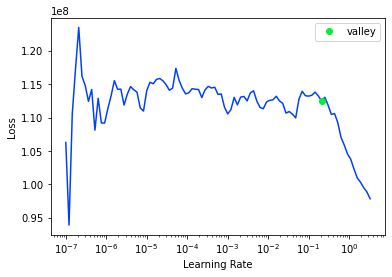

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0 3249.90    3823.14
1 4584.48    5019.60
2 4718.55    5364.49
3 3807.97    3707.95
4 8102.67    8070.39
XGBoost RMSE:  2481.851


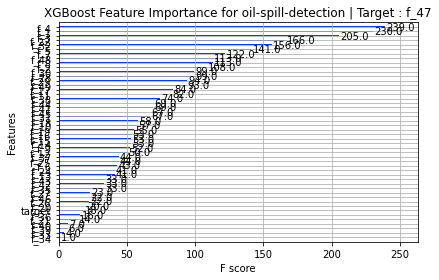

Target Variable: f_46
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
50
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'ta

  7%|▋         | 3/42 [00:00<00:03,  9.84it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8221362007995667, 'Adjusted R-Squared': 0.7585206813775139, 'RMSE': 0.1568358427384585, 'Time taken': 0.19840598106384277}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8286993382961125, 'Adjusted R-Squared': 0.76743121841662, 'RMSE': 0.15391504011042104, 'Time taken': 0.09103035926818848}
{'Model': 'BayesianRidge', 'R-Squared': 0.41733491373121, 'Adjusted R-Squared': 0.20893645221901513, 'RMSE': 0.2838644700433043, 'Time taken': 0.04306173324584961}


 12%|█▏        | 5/42 [00:00<00:02, 12.60it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.6133167907361455, 'Adjusted R-Squared': 0.4750140370578326, 'RMSE': 0.23124864503144013, 'Time taken': 0.0909271240234375}
{'Model': 'DummyRegressor', 'R-Squared': -0.016047219557025816, 'Adjusted R-Squared': -0.37945096961756786, 'RMSE': 0.374850837436436, 'Time taken': 0.015193462371826172}
{'Model': 'ElasticNet', 'R-Squared': -0.016047219557025816, 'Adjusted R-Squared': -0.37945096961756786, 'RMSE': 0.374850837436436, 'Time taken': 0.02064037322998047}


 17%|█▋        | 7/42 [00:01<00:07,  4.94it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.4115086312605686, 'Adjusted R-Squared': 0.2010263168939107, 'RMSE': 0.2852801724272411, 'Time taken': 0.7180781364440918}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.38130686517783285, 'Adjusted R-Squared': 0.16002245929253223, 'RMSE': 0.29250896965085227, 'Time taken': 0.03135871887207031}


 21%|██▏       | 9/42 [00:01<00:06,  5.20it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.8699429693961952, 'Adjusted R-Squared': 0.8234262212240314, 'RMSE': 0.13411225244803135, 'Time taken': 0.3175225257873535}
{'Model': 'GammaRegressor', 'R-Squared': 0.3067808187426173, 'Adjusted R-Squared': 0.058841111577568106, 'RMSE': 0.3096255742687647, 'Time taken': 0.045928001403808594}


 26%|██▌       | 11/42 [00:01<00:05,  5.42it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -4.295462181777315, 'Adjusted R-Squared': -6.1894596044567916, 'RMSE': 0.855762940264967, 'Time taken': 0.28850388526916504}


 29%|██▊       | 12/42 [00:02<00:09,  3.33it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9012664396111344, 'Adjusted R-Squared': 0.8659529764063576, 'RMSE': 0.11685140500615829, 'Time taken': 0.7582781314849854}


 33%|███▎      | 14/42 [00:03<00:08,  3.34it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.8870460486699318, 'Adjusted R-Squared': 0.8466464602380095, 'RMSE': 0.12498337658714306, 'Time taken': 0.5248677730560303}
{'Model': 'HuberRegressor', 'R-Squared': -0.18712024010007733, 'Adjusted R-Squared': -0.611710690938791, 'RMSE': 0.40518083433336344, 'Time taken': 0.1369178295135498}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.4570967741935483, 'Adjusted R-Squared': 0.26291970802919706, 'RMSE': 0.27400768949747256, 'Time taken': 0.029340267181396484}


 38%|███▊      | 16/42 [00:03<00:05,  5.02it/s]

{'Model': 'KernelRidge', 'R-Squared': -9.211432339092896, 'Adjusted R-Squared': -12.863696460374296, 'RMSE': 1.1883513710811884, 'Time taken': 0.07329440116882324}
{'Model': 'Lars', 'R-Squared': -1.6981412897327028, 'Adjusted R-Squared': -2.663169926206443, 'RMSE': 0.610849022954153, 'Time taken': 0.055208683013916016}


 43%|████▎     | 18/42 [00:03<00:03,  6.07it/s]

{'Model': 'LarsCV', 'R-Squared': 0.38475427688973485, 'Adjusted R-Squared': 0.1647028868721948, 'RMSE': 0.2916928885924941, 'Time taken': 0.15246319770812988}
{'Model': 'Lasso', 'R-Squared': -0.016047219557025816, 'Adjusted R-Squared': -0.37945096961756786, 'RMSE': 0.374850837436436, 'Time taken': 0.02755451202392578}


 48%|████▊     | 20/42 [00:04<00:05,  4.25it/s]

{'Model': 'LassoCV', 'R-Squared': 0.4137167523328996, 'Adjusted R-Squared': 0.20402420389722142, 'RMSE': 0.28474445923806174, 'Time taken': 0.7088065147399902}
{'Model': 'LassoLars', 'R-Squared': -0.016047219557025816, 'Adjusted R-Squared': -0.37945096961756786, 'RMSE': 0.374850837436436, 'Time taken': 0.02681112289428711}


 52%|█████▏    | 22/42 [00:04<00:03,  5.12it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.41079391476806715, 'Adjusted R-Squared': 0.2000559718748941, 'RMSE': 0.28545335472497896, 'Time taken': 0.19804811477661133}
{'Model': 'LassoLarsIC', 'R-Squared': 0.4314598744077406, 'Adjusted R-Squared': 0.22811340613021724, 'RMSE': 0.2804026412266873, 'Time taken': 0.06956601142883301}
{'Model': 'LinearRegression', 'R-Squared': 0.42619973963495617, 'Adjusted R-Squared': 0.220971909285415, 'RMSE': 0.28169679772949063, 'Time taken': 0.028153657913208008}


 60%|█████▉    | 25/42 [00:04<00:02,  6.36it/s]

{'Model': 'LinearSVR', 'R-Squared': -0.08835853228083734, 'Adjusted R-Squared': -0.47762545258566225, 'RMSE': 0.3879605199511338, 'Time taken': 0.2104930877685547}


 62%|██████▏   | 26/42 [00:06<00:06,  2.49it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.5236950023930868, 'Adjusted R-Squared': 0.35333774047528566, 'RMSE': 0.2566516784076897, 'Time taken': 1.6369056701660156}


 71%|███████▏  | 30/42 [00:06<00:02,  4.60it/s]

{'Model': 'NuSVR', 'R-Squared': 0.3100555406584883, 'Adjusted R-Squared': 0.06328708439765574, 'RMSE': 0.30889338309341047, 'Time taken': 0.2228248119354248}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.362267492361974, 'Adjusted R-Squared': 0.1341733837907093, 'RMSE': 0.29697563330865306, 'Time taken': 0.021325111389160156}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.3655430909191174, 'Adjusted R-Squared': 0.13862054679529812, 'RMSE': 0.29621197042413716, 'Time taken': 0.04388308525085449}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.16649234907664467, 'Adjusted R-Squared': -0.1316235260711247, 'RMSE': 0.3395129427388699, 'Time taken': 0.033582448959350586}
{'Model': 'PoissonRegressor', 'R-Squared': 0.335355606086461, 'Adjusted R-Squared': 0.09763607833636312, 'RMSE': 0.30317697300193647, 'Time taken': 0.034473419189453125}


 76%|███████▌  | 32/42 [00:14<00:12,  1.29s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.19871794868849224, 'Adjusted R-Squared': -0.6274564850807265, 'RMSE': 0.40715525425253335, 'Time taken': 7.53051233291626}


 79%|███████▊  | 33/42 [00:14<00:10,  1.12s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -0.19871794871794868, 'Adjusted R-Squared': -0.6274564851207185, 'RMSE': 0.4071552542575359, 'Time taken': 0.3511958122253418}


 88%|████████▊ | 37/42 [00:15<00:02,  1.71it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8665478908188585, 'Adjusted R-Squared': 0.8188168444693992, 'RMSE': 0.13585144450193393, 'Time taken': 0.7641937732696533}
{'Model': 'Ridge', 'R-Squared': 0.4350670301821309, 'Adjusted R-Squared': 0.23301071251004635, 'RMSE': 0.27951170548643967, 'Time taken': 0.018829345703125}
{'Model': 'RidgeCV', 'R-Squared': 0.4334000857392324, 'Adjusted R-Squared': 0.23074756166056376, 'RMSE': 0.27992377852042344, 'Time taken': 0.051467180252075195}
{'Model': 'SGDRegressor', 'R-Squared': 0.42071216640745657, 'Adjusted R-Squared': 0.213521627385306, 'RMSE': 0.2830406045960237, 'Time taken': 0.06649470329284668}


 95%|█████████▌| 40/42 [00:15<00:00,  2.71it/s]

{'Model': 'SVR', 'R-Squared': 0.4686360928969746, 'Adjusted R-Squared': 0.2785862283126809, 'RMSE': 0.27108005517801276, 'Time taken': 0.06515145301818848}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.42619973963495617, 'Adjusted R-Squared': 0.220971909285415, 'RMSE': 0.28169679772949063, 'Time taken': 0.021163225173950195}
{'Model': 'TweedieRegressor', 'R-Squared': 0.3175087959658651, 'Adjusted R-Squared': 0.07340610255219648, 'RMSE': 0.3072204131312453, 'Time taken': 0.03409290313720703}
{'Model': 'XGBRegressor', 'R-Squared': 0.8154772125172991, 'Adjusted R-Squared': 0.7494800111548732, 'RMSE': 0.15974472, 'Time taken': 0.6119980812072754}


100%|██████████| 42/42 [00:16<00:00,  2.52it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.8886194818124021, 'Adjusted R-Squared': 0.8487826541394656, 'RMSE': 0.12410982310024717, 'Time taken': 0.21430730819702148}
Project: oil-spill-detection
oil-spill-detection
Target: f_46
f_46
Target Standard Deviation: 0.3233958702409307
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GradientBoostingRegressor                    0.87       0.90  0.12        0.76
LGBMRegressor                                0.85       0.89  0.12        0.21
HistGradientBoostingRegressor                0.85       0.89  0.12        0.52
ExtraTreesRegressor                          0.82       0.87  0.13        0.32
RandomForestRegressor                        0.82       0.87  0.14        0.76
BaggingRegressor                             0.77       0.83  0.15        0.09
AdaBoostRegressor                            0.76       0.82  0.16        0.20
XGBRegress

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.2829595804214478.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       2       1.89
3       1       1.01
4       2       1.47
XGBoost RMSE:  0.15976873


<Figure size 432x288 with 0 Axes>

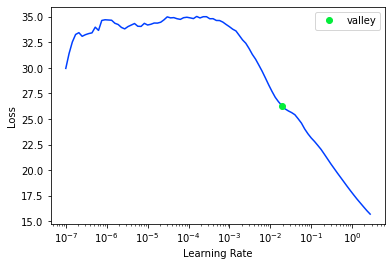

<Figure size 720x720 with 0 Axes>

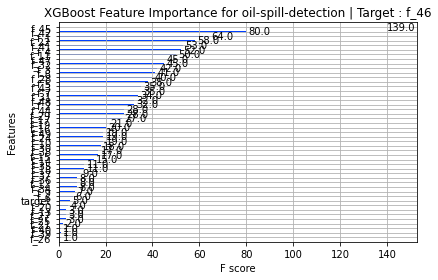

Target Variable: f_45
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:08,  4.77it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.4557036092516943, 'Adjusted R-Squared': 0.2610282578161689, 'RMSE': 3.194685981152498, 'Time taken': 0.2763359546661377}
{'Model': 'BaggingRegressor', 'R-Squared': -1.5820332755444109, 'Adjusted R-Squared': -2.5055342281113897, 'RMSE': 6.958111217666426, 'Time taken': 0.16184186935424805}
{'Model': 'BayesianRidge', 'R-Squared': 0.6033368658976417, 'Adjusted R-Squared': 0.46146465005081283, 'RMSE': 2.7272275049722747, 'Time taken': 0.028765201568603516}


 12%|█▏        | 5/42 [00:00<00:03, 11.26it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': -2.9567431516380673, 'Adjusted R-Squared': -4.371928658428325, 'RMSE': 8.613494454015894, 'Time taken': 0.06805610656738281}
{'Model': 'DummyRegressor', 'R-Squared': -0.0016052457615201021, 'Adjusted R-Squared': -0.3598436183331586, 'RMSE': 4.3336987, 'Time taken': 0.023492097854614258}
{'Model': 'ElasticNet', 'R-Squared': 0.38471127474616806, 'Adjusted R-Squared': 0.16464450439990708, 'RMSE': 3.3966431874970615, 'Time taken': 0.026221752166748047}


 17%|█▋        | 7/42 [00:00<00:04,  7.25it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.5783183466776587, 'Adjusted R-Squared': 0.4274979013287922, 'RMSE': 2.8119189707157695, 'Time taken': 0.3840818405151367}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.6445484386341982, 'Adjusted R-Squared': 0.5174161283646779, 'RMSE': 2.581669606242518, 'Time taken': 0.03909564018249512}


 26%|██▌       | 11/42 [00:01<00:05,  5.70it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.22353880515878188, 'Adjusted R-Squared': -0.6611548741571782, 'RMSE': 4.7898214290393195, 'Time taken': 0.7470824718475342}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.279793822853347, 'Adjusted R-Squared': -0.7375302996403104, 'RMSE': 4.898695598799343, 'Time taken': 0.1197056770324707}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.5743281785078633, 'Adjusted R-Squared': -1.1374090598719895, 'RMSE': 5.433229914352559, 'Time taken': 0.7130093574523926}


 33%|███▎      | 14/42 [00:03<00:07,  3.52it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.788909869990086, 'Adjusted R-Squared': 0.7134104804244964, 'RMSE': 1.9895021482681403, 'Time taken': 0.5150113105773926}
{'Model': 'HuberRegressor', 'R-Squared': 0.6096872703407835, 'Adjusted R-Squared': 0.4700863670320127, 'RMSE': 2.70530855906717, 'Time taken': 0.12521624565124512}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.44954353425586224, 'Adjusted R-Squared': 0.252664944318178, 'RMSE': 3.2127128, 'Time taken': 0.03251767158508301}


 40%|████      | 17/42 [00:03<00:04,  5.64it/s]

{'Model': 'KernelRidge', 'R-Squared': -0.6603535985770239, 'Adjusted R-Squared': -1.2542026958782952, 'RMSE': 5.579698631585946, 'Time taken': 0.05382847785949707}
{'Model': 'Lars', 'R-Squared': -16770.809399094847, 'Adjusted R-Squared': -22769.48575351563, 'RMSE': 560.7901900657665, 'Time taken': 0.04642152786254883}


 45%|████▌     | 19/42 [00:03<00:03,  6.50it/s]

{'Model': 'LarsCV', 'R-Squared': 0.5573435981382416, 'Adjusted R-Squared': 0.3990212354285617, 'RMSE': 2.8810037496068093, 'Time taken': 0.16255426406860352}
{'Model': 'Lasso', 'R-Squared': 0.3730900518422974, 'Adjusted R-Squared': 0.14886678571290013, 'RMSE': 3.4285700692094236, 'Time taken': 0.02873373031616211}


 50%|█████     | 21/42 [00:04<00:04,  4.51it/s]

{'Model': 'LassoCV', 'R-Squared': 0.5756642033356114, 'Adjusted R-Squared': 0.423894465842509, 'RMSE': 2.820754461918951, 'Time taken': 0.7119622230529785}
{'Model': 'LassoLars', 'R-Squared': -0.0016052247776301432, 'Adjusted R-Squared': -0.3598435898440817, 'RMSE': 4.3336989560673285, 'Time taken': 0.04300236701965332}


 57%|█████▋    | 24/42 [00:04<00:03,  5.72it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.559766598621444, 'Adjusted R-Squared': 0.4023108565225444, 'RMSE': 2.8731079501366983, 'Time taken': 0.23503422737121582}
{'Model': 'LassoLarsIC', 'R-Squared': 0.6144558023347493, 'Adjusted R-Squared': 0.47656043236688594, 'RMSE': 2.6887321146623195, 'Time taken': 0.0816342830657959}
{'Model': 'LinearRegression', 'R-Squared': 0.5476299442158541, 'Adjusted R-Squared': 0.3858333549207946, 'RMSE': 2.912442591166111, 'Time taken': 0.06414985656738281}


 60%|█████▉    | 25/42 [00:04<00:02,  6.14it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.5999134646869275, 'Adjusted R-Squared': 0.4568168206698432, 'RMSE': 2.7389708901856897, 'Time taken': 0.09977507591247559}


 64%|██████▍   | 27/42 [00:07<00:07,  1.88it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.5279796115780375, 'Adjusted R-Squared': 0.3591548011205473, 'RMSE': 2.9750264257415227, 'Time taken': 2.4185171127319336}
{'Model': 'NuSVR', 'R-Squared': 0.4662758492160113, 'Adjusted R-Squared': 0.2753818098845118, 'RMSE': 3.1635075566215427, 'Time taken': 0.14612483978271484}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.5426601735571885, 'Adjusted R-Squared': 0.3790860750484458, 'RMSE': 2.928397045767537, 'Time taken': 0.02093052864074707}


 74%|███████▍  | 31/42 [00:07<00:02,  4.05it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.5426601735571885, 'Adjusted R-Squared': 0.3790860750484458, 'RMSE': 2.928397045767537, 'Time taken': 0.04604506492614746}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.23077900987253852, 'Adjusted R-Squared': -0.04434382601246578, 'RMSE': 3.7978342958838596, 'Time taken': 0.029851913452148438}
{'Model': 'PoissonRegressor', 'R-Squared': 0.5688701811116388, 'Adjusted R-Squared': 0.4146704648668965, 'RMSE': 2.8432462798404208, 'Time taken': 0.042069196701049805}
{'Model': 'QuantileRegressor', 'R-Squared': -0.054957310702705486, 'Adjusted R-Squared': -0.4322778086912642, 'RMSE': 4.447622225307491, 'Time taken': 12.9044668674469}


 79%|███████▊  | 33/42 [00:20<00:18,  2.11s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -15.746627929108648, 'Adjusted R-Squared': -21.736297772366484, 'RMSE': 17.72042503370241, 'Time taken': 0.39319849014282227}


 81%|████████  | 34/42 [00:22<00:16,  2.01s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.9121720552136776, 'Adjusted R-Squared': -1.5960876078083506, 'RMSE': 5.987891636573325, 'Time taken': 1.5053751468658447}
{'Model': 'Ridge', 'R-Squared': 0.5994832084645514, 'Adjusted R-Squared': 0.45623267718544935, 'RMSE': 2.7404432499173557, 'Time taken': 0.022045612335205078}
{'Model': 'RidgeCV', 'R-Squared': 0.605873465954456, 'Adjusted R-Squared': 0.4649085012228381, 'RMSE': 2.7184934179628644, 'Time taken': 0.0350186824798584}
{'Model': 'SGDRegressor', 'R-Squared': 0.5826771239876709, 'Adjusted R-Squared': 0.4334156573847211, 'RMSE': 2.7973483033118947, 'Time taken': 0.03607654571533203}


 90%|█████████ | 38/42 [00:22<00:04,  1.04s/it]

{'Model': 'SVR', 'R-Squared': 0.4678739889604483, 'Adjusted R-Squared': 0.2775515470557912, 'RMSE': 3.1587677322750833, 'Time taken': 0.10767912864685059}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.5476299442158541, 'Adjusted R-Squared': 0.3858333549207946, 'RMSE': 2.912442591166111, 'Time taken': 0.027910709381103516}
{'Model': 'TweedieRegressor', 'R-Squared': 0.46053734699518556, 'Adjusted R-Squared': 0.26759085066499655, 'RMSE': 3.180468808174853, 'Time taken': 0.03371763229370117}


 98%|█████████▊| 41/42 [00:23<00:00,  1.30it/s]

{'Model': 'XGBRegressor', 'R-Squared': -1.2007907816026804, 'Adjusted R-Squared': -1.9879349297671425, 'RMSE': 6.423916, 'Time taken': 0.7403433322906494}


100%|██████████| 42/42 [00:23<00:00,  1.78it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.8008499453419484, 'Adjusted R-Squared': 0.72962109367593, 'RMSE': 1.9324161736246304, 'Time taken': 0.21197247505187988}
Project: oil-spill-detection
oil-spill-detection
Target: f_45
f_45
Target Standard Deviation: 5.184944152832031
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
LGBMRegressor                                0.73       0.80   1.93   
HistGradientBoostingRegressor                0.71       0.79   1.99   
ExtraTreeRegressor                           0.52       0.64   2.58   
LassoLarsIC                                  0.48       0.61   2.69   
HuberRegressor                               0.47       0.61   2.71   
RidgeCV                                      0.46       0.61   2.72   
BayesianRidge                                0.46       0.60   2.73   
LinearSVR                                    0.46       0.60   2.74   
Ridge          

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 5.462022304534912.
Better model found at epoch 1 with _rmse value: 4.645659923553467.
No improvement since epoch 1: early stopping


<Figure size 432x288 with 0 Axes>

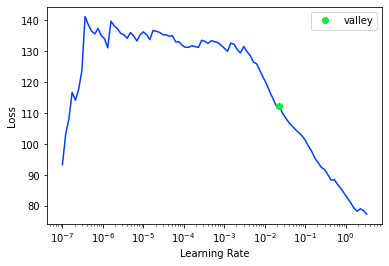

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    3.82       3.99
1    3.82       3.96
2   12.88      13.07
3    2.02       1.94
4    2.70       2.81
XGBoost RMSE:  6.423915


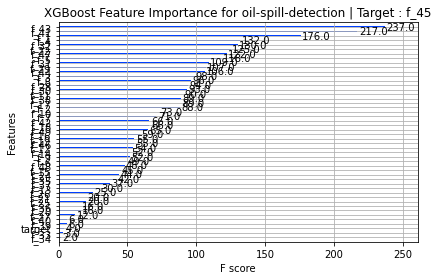

Target Variable: f_44
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:06,  5.71it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.7315829478664924, 'Adjusted R-Squared': 0.6355797686362598, 'RMSE': 57.76228495141838, 'Time taken': 0.18909192085266113}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8337479852198233, 'Adjusted R-Squared': 0.7742855857728987, 'RMSE': 45.45930293066759, 'Time taken': 0.16319012641906738}
{'Model': 'BayesianRidge', 'R-Squared': 0.9086272802061333, 'Adjusted R-Squared': 0.8759465264112466, 'RMSE': 33.70137261998462, 'Time taken': 0.029410362243652344}


 10%|▉         | 4/42 [00:00<00:04,  9.02it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.4167467226857523, 'Adjusted R-Squared': 0.20813788627408714, 'RMSE': 85.14671695714374, 'Time taken': 0.11461424827575684}
{'Model': 'DummyRegressor', 'R-Squared': -0.0002401771068092362, 'Adjusted R-Squared': -0.357990313444281, 'RMSE': 111.50426, 'Time taken': 0.012447595596313477}
{'Model': 'ElasticNet', 'R-Squared': 0.6890714537151257, 'Adjusted R-Squared': 0.5778634335110466, 'RMSE': 62.16838873954628, 'Time taken': 0.01975107192993164}


 17%|█▋        | 7/42 [00:00<00:03, 10.80it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.7593800266298778, 'Adjusted R-Squared': 0.673318868271221, 'RMSE': 54.689650833306764, 'Time taken': 0.20128440856933594}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.6413475167418043, 'Adjusted R-Squared': 0.5130703511969024, 'RMSE': 66.76920949846054, 'Time taken': 0.03834390640258789}


 26%|██▌       | 11/42 [00:01<00:04,  6.29it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.8346360793544466, 'Adjusted R-Squared': 0.7754913194155261, 'RMSE': 45.337721846775615, 'Time taken': 0.7631690502166748}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.535353591199675, 'Adjusted R-Squared': -1.0844946566652518, 'RMSE': 138.14765520896586, 'Time taken': 0.13322186470031738}


 29%|██▊       | 12/42 [00:02<00:08,  3.72it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8212880457323807, 'Adjusted R-Squared': 0.7573691715782687, 'RMSE': 47.13202674179959, 'Time taken': 0.7254247665405273}


 31%|███       | 13/42 [00:03<00:12,  2.42it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.8768848853456113, 'Adjusted R-Squared': 0.8328510122210488, 'RMSE': 39.119653587419876, 'Time taken': 0.9375760555267334}


 38%|███▊      | 16/42 [00:03<00:06,  3.87it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.9022942408818031, 'Adjusted R-Squared': 0.8673483854307692, 'RMSE': 34.849728182605105, 'Time taken': 0.23533177375793457}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.6135644787324541, 'Adjusted R-Squared': 0.4753503141915071, 'RMSE': 69.30712, 'Time taken': 0.03927969932556152}
{'Model': 'KernelRidge', 'R-Squared': 0.024583626342201903, 'Adjusted R-Squared': -0.32428792336022205, 'RMSE': 110.11191969068858, 'Time taken': 0.1344611644744873}


 43%|████▎     | 18/42 [00:04<00:04,  4.90it/s]

{'Model': 'Lars', 'R-Squared': -51.36664162768554, 'Adjusted R-Squared': -70.09631637043438, 'RMSE': 806.8014587240177, 'Time taken': 0.10004782676696777}
{'Model': 'LarsCV', 'R-Squared': 0.8183999633864747, 'Adjusted R-Squared': 0.7534481254736081, 'RMSE': 47.51133999540096, 'Time taken': 0.13728117942810059}
{'Model': 'Lasso', 'R-Squared': 0.9012190388899843, 'Adjusted R-Squared': 0.8658886221426065, 'RMSE': 35.040955265347556, 'Time taken': 0.07633590698242188}


 48%|████▊     | 20/42 [00:04<00:05,  4.15it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9142348200356076, 'Adjusted R-Squared': 0.8835596826760804, 'RMSE': 32.65087430622061, 'Time taken': 0.5109028816223145}
{'Model': 'LassoLars', 'R-Squared': 0.7530715899833156, 'Adjusted R-Squared': 0.6647541294663992, 'RMSE': 55.40192351926785, 'Time taken': 0.031136512756347656}


 57%|█████▋    | 24/42 [00:05<00:02,  6.56it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9139369597164405, 'Adjusted R-Squared': 0.8831552883741455, 'RMSE': 32.7075229977975, 'Time taken': 0.25141215324401855}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9118823100739972, 'Adjusted R-Squared': 0.8803657640420692, 'RMSE': 33.095646188794916, 'Time taken': 0.06874728202819824}
{'Model': 'LinearRegression', 'R-Squared': 0.9066643468773469, 'Adjusted R-Squared': 0.8732815220378578, 'RMSE': 34.061447400419816, 'Time taken': 0.028711318969726562}
{'Model': 'LinearSVR', 'R-Squared': 0.7488176467954282, 'Adjusted R-Squared': 0.6589787029485376, 'RMSE': 55.877102254822724, 'Time taken': 0.03722047805786133}


 64%|██████▍   | 27/42 [00:06<00:05,  2.96it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.6571351411649655, 'Adjusted R-Squared': 0.5345046442093693, 'RMSE': 65.28310483807249, 'Time taken': 1.705747127532959}
{'Model': 'NuSVR', 'R-Squared': 0.06046156190600849, 'Adjusted R-Squared': -0.2755777334706746, 'RMSE': 108.06786950418123, 'Time taken': 0.10652470588684082}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.8995559722167698, 'Adjusted R-Squared': 0.8636307360023298, 'RMSE': 35.33469713420057, 'Time taken': 0.02109241485595703}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9044426687211993, 'Adjusted R-Squared': 0.8702652290667376, 'RMSE': 34.464447410124265, 'Time taken': 0.04538106918334961}


 71%|███████▏  | 30/42 [00:06<00:02,  4.92it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.8624271208584405, 'Adjusted R-Squared': 0.8132222224793426, 'RMSE': 41.3528767094339, 'Time taken': 0.042275428771972656}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8419943023631113, 'Adjusted R-Squared': 0.7854813156170709, 'RMSE': 44.31754428118706, 'Time taken': 0.0956273078918457}


 76%|███████▌  | 32/42 [00:24<00:27,  2.72s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.09308346585161664, 'Adjusted R-Squared': -0.48404032590073487, 'RMSE': 116.56441166319735, 'Time taken': 17.090096473693848}


 79%|███████▊  | 33/42 [00:24<00:20,  2.30s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.8072436985528608, 'Adjusted R-Squared': 0.7383016637287017, 'RMSE': 48.94897541602205, 'Time taken': 0.3440732955932617}


 88%|████████▊ | 37/42 [00:26<00:06,  1.24s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.80731629797052, 'Adjusted R-Squared': 0.7384002293614359, 'RMSE': 48.93975651692926, 'Time taken': 1.5505995750427246}
{'Model': 'Ridge', 'R-Squared': 0.9097143660763396, 'Adjusted R-Squared': 0.8774224240160523, 'RMSE': 33.50029560773565, 'Time taken': 0.019779205322265625}
{'Model': 'RidgeCV', 'R-Squared': 0.9078986228810695, 'Adjusted R-Squared': 0.874957254422474, 'RMSE': 33.83548260921089, 'Time taken': 0.05104827880859375}
{'Model': 'SGDRegressor', 'R-Squared': 0.8494546760873306, 'Adjusted R-Squared': 0.7956099981915583, 'RMSE': 43.25864866887919, 'Time taken': 0.10806727409362793}


 93%|█████████▎| 39/42 [00:26<00:02,  1.16it/s]

{'Model': 'SVR', 'R-Squared': 0.049333705065621514, 'Adjusted R-Squared': -0.29068562669922904, 'RMSE': 108.7059615101217, 'Time taken': 0.07310843467712402}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9066643468773469, 'Adjusted R-Squared': 0.8732815220378578, 'RMSE': 34.061447400419816, 'Time taken': 0.0287933349609375}
{'Model': 'TweedieRegressor', 'R-Squared': 0.6459886081459959, 'Adjusted R-Squared': 0.5193713950011332, 'RMSE': 66.33579406982285, 'Time taken': 0.07386946678161621}


 98%|█████████▊| 41/42 [00:27<00:00,  1.38it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.764264147414816, 'Adjusted R-Squared': 0.6799498643733999, 'RMSE': 54.13176, 'Time taken': 0.752760648727417}


100%|██████████| 42/42 [00:27<00:00,  1.53it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.8142133825305192, 'Adjusted R-Squared': 0.7477641543845006, 'RMSE': 48.05587921032349, 'Time taken': 0.2113945484161377}
Project: oil-spill-detection
oil-spill-detection
Target: f_44
f_44
Target Standard Deviation: 140.90264892578125
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
LassoCV                                      0.88       0.91  32.65   
LassoLarsCV                                  0.88       0.91  32.71   
LassoLarsIC                                  0.88       0.91  33.10   
Ridge                                        0.88       0.91  33.50   
BayesianRidge                                0.88       0.91  33.70   
RidgeCV                                      0.87       0.91  33.84   
TransformedTargetRegressor                   0.87       0.91  34.06   
LinearRegression                             0.87       0.91  34.06   
OrthogonalMatc

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 151.194580078125.
Better model found at epoch 1 with _rmse value: 138.08743286132812.
No improvement since epoch 1: early stopping


<Figure size 432x288 with 0 Axes>

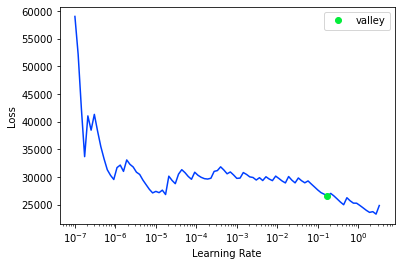

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   42.09      51.54
1   90.23     105.74
2  278.65     240.17
3   58.65      70.79
4   63.64      84.18
XGBoost RMSE:  54.122623


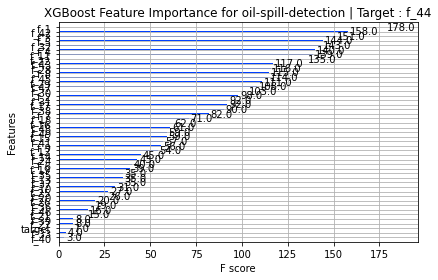

Target Variable: f_43
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:08,  4.97it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8362438485566333, 'Adjusted R-Squared': 0.7776741301571809, 'RMSE': 251.6105877666552, 'Time taken': 0.25159192085266113}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8701466690653588, 'Adjusted R-Squared': 0.8237027769792462, 'RMSE': 224.0560358741257, 'Time taken': 0.16463184356689453}


 10%|▉         | 4/42 [00:00<00:04,  7.95it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.9801898750159744, 'Adjusted R-Squared': 0.9731045018465054, 'RMSE': 87.5132290134275, 'Time taken': 0.0555422306060791}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.8676340963326385, 'Adjusted R-Squared': 0.8202915468457721, 'RMSE': 226.21331557518224, 'Time taken': 0.10334897041320801}
{'Model': 'DummyRegressor', 'R-Squared': -0.006917019964567839, 'Adjusted R-Squared': -0.36705522418547165, 'RMSE': 623.9172, 'Time taken': 0.01284337043762207}
{'Model': 'ElasticNet', 'R-Squared': 0.7744935742296722, 'Adjusted R-Squared': 0.69383799128992, 'RMSE': 295.26336265747943, 'Time taken': 0.02193903923034668}


 17%|█▋        | 7/42 [00:00<00:03,  9.46it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.7745394169726364, 'Adjusted R-Squared': 0.6939002303424116, 'RMSE': 295.23334938762457, 'Time taken': 0.23543596267700195}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8375188660789353, 'Adjusted R-Squared': 0.779405175844394, 'RMSE': 250.6291443007639, 'Time taken': 0.03969311714172363}


 26%|██▌       | 11/42 [00:01<00:05,  6.09it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.8980555246461994, 'Adjusted R-Squared': 0.8615936320014095, 'RMSE': 198.52351143738593, 'Time taken': 0.7620909214019775}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.17726327299762845, 'Adjusted R-Squared': -0.5983282392522546, 'RMSE': 674.6319396512994, 'Time taken': 0.1302328109741211}


 29%|██▊       | 12/42 [00:02<00:08,  3.72it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9514534737196993, 'Adjusted R-Squared': 0.9340901176048473, 'RMSE': 136.99640809131506, 'Time taken': 0.6995348930358887}


 33%|███▎      | 14/42 [00:03<00:07,  3.57it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.6050916022845445, 'Adjusted R-Squared': 0.4638469928826663, 'RMSE': 390.7313746376364, 'Time taken': 0.5366184711456299}
{'Model': 'HuberRegressor', 'R-Squared': 0.9794051998824802, 'Adjusted R-Squared': 0.9720391764827834, 'RMSE': 89.22958874526125, 'Time taken': 0.12616825103759766}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7053239320984107, 'Adjusted R-Squared': 0.5999288421190102, 'RMSE': 337.52234, 'Time taken': 0.031168222427368164}


 38%|███▊      | 16/42 [00:03<00:04,  5.31it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.8120971929910464, 'Adjusted R-Squared': 0.7448910795352893, 'RMSE': 269.5235601736551, 'Time taken': 0.07275938987731934}
{'Model': 'Lars', 'R-Squared': 0.9682234427509744, 'Adjusted R-Squared': 0.9568581047567973, 'RMSE': 110.83668349522445, 'Time taken': 0.09298348426818848}


 43%|████▎     | 18/42 [00:03<00:03,  6.02it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9828415446824511, 'Adjusted R-Squared': 0.976704578911941, 'RMSE': 81.44589400311918, 'Time taken': 0.1582658290863037}
{'Model': 'Lasso', 'R-Squared': 0.9831186109774264, 'Adjusted R-Squared': 0.9770807419109584, 'RMSE': 80.78564369277663, 'Time taken': 0.03839278221130371}


 48%|████▊     | 20/42 [00:03<00:03,  6.58it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9828300914872842, 'Adjusted R-Squared': 0.9766890293185027, 'RMSE': 81.4730718606715, 'Time taken': 0.20608806610107422}
{'Model': 'LassoLars', 'R-Squared': 0.9345166992517177, 'Adjusted R-Squared': 0.9110956646775145, 'RMSE': 159.10923288328905, 'Time taken': 0.042410850524902344}


 60%|█████▉    | 25/42 [00:04<00:01,  9.88it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9825021284811091, 'Adjusted R-Squared': 0.9762437656750824, 'RMSE': 82.24750121065486, 'Time taken': 0.19746637344360352}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9827119694258406, 'Adjusted R-Squared': 0.9765286592204844, 'RMSE': 81.75284248301855, 'Time taken': 0.06675195693969727}
{'Model': 'LinearRegression', 'R-Squared': 0.9806072695244197, 'Adjusted R-Squared': 0.9736711834419128, 'RMSE': 86.58637968996679, 'Time taken': 0.02874922752380371}
{'Model': 'LinearSVR', 'R-Squared': 0.7258146641377726, 'Adjusted R-Squared': 0.6277483761286549, 'RMSE': 325.5758721788947, 'Time taken': 0.0318455696105957}


 64%|██████▍   | 27/42 [00:05<00:04,  3.13it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.6933587690005572, 'Adjusted R-Squared': 0.5836841681321433, 'RMSE': 344.30662204506336, 'Time taken': 1.6300814151763916}
{'Model': 'NuSVR', 'R-Squared': -0.029923038033422333, 'Adjusted R-Squared': -0.3982896720745732, 'RMSE': 631.0045446317574, 'Time taken': 0.10956716537475586}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9778851532600749, 'Adjusted R-Squared': 0.9699754635501746, 'RMSE': 92.46387024982901, 'Time taken': 0.02324843406677246}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9843701420947415, 'Adjusted R-Squared': 0.9787799009461454, 'RMSE': 77.73339136571359, 'Time taken': 0.04398679733276367}


 71%|███████▏  | 30/42 [00:06<00:02,  4.70it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.959481900805343, 'Adjusted R-Squared': 0.9449900259109036, 'RMSE': 125.15685238270808, 'Time taken': 0.04084920883178711}
{'Model': 'PoissonRegressor', 'R-Squared': 0.13546694706389506, 'Adjusted R-Squared': -0.17374560471617162, 'RMSE': 578.1238706162202, 'Time taken': 0.08672475814819336}


 76%|███████▌  | 32/42 [00:21<00:21,  2.16s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.04902639611383308, 'Adjusted R-Squared': -0.42422561808155423, 'RMSE': 636.829699017215, 'Time taken': 15.073140382766724}


 79%|███████▊  | 33/42 [00:21<00:17,  1.89s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.8757570373105492, 'Adjusted R-Squared': 0.8313197732829354, 'RMSE': 219.16237605909276, 'Time taken': 0.44358253479003906}


 83%|████████▎ | 35/42 [00:23<00:10,  1.54s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9054530502701759, 'Adjusted R-Squared': 0.871636987958049, 'RMSE': 191.18502044156904, 'Time taken': 1.5211083889007568}
{'Model': 'Ridge', 'R-Squared': 0.9786071290903788, 'Adjusted R-Squared': 0.9709556643124851, 'RMSE': 90.94202826473025, 'Time taken': 0.01904606819152832}
{'Model': 'RidgeCV', 'R-Squared': 0.9804932162730244, 'Adjusted R-Squared': 0.9735163374217704, 'RMSE': 86.84062394674216, 'Time taken': 0.036608219146728516}
{'Model': 'SGDRegressor', 'R-Squared': 0.9508493609387297, 'Adjusted R-Squared': 0.9332699352890783, 'RMSE': 137.8461640549298, 'Time taken': 0.047127485275268555}


 90%|█████████ | 38/42 [00:23<00:03,  1.05it/s]

{'Model': 'SVR', 'R-Squared': -0.04085297482579575, 'Adjusted R-Squared': -0.41312885633283214, 'RMSE': 634.343938942337, 'Time taken': 0.0991666316986084}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9806072695244197, 'Adjusted R-Squared': 0.9736711834419128, 'RMSE': 86.58637968996679, 'Time taken': 0.022866487503051758}
{'Model': 'TweedieRegressor', 'R-Squared': 0.7422233537459175, 'Adjusted R-Squared': 0.6500258671294938, 'RMSE': 315.6835016567071, 'Time taken': 0.039632558822631836}


 98%|█████████▊| 41/42 [00:24<00:00,  1.43it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.7028221766459113, 'Adjusted R-Squared': 0.5965322982199963, 'RMSE': 338.9521, 'Time taken': 0.7247488498687744}


100%|██████████| 42/42 [00:24<00:00,  1.72it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.6121632364664134, 'Adjusted R-Squared': 0.4734478976843277, 'RMSE': 387.217153193636, 'Time taken': 0.22463512420654297}
Project: oil-spill-detection
oil-spill-detection
Target: f_43
f_43
Target Standard Deviation: 509.27142333984375
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
OrthogonalMatchingPursuitCV                  0.98       0.98  77.73   
Lasso                                        0.98       0.98  80.79   
LarsCV                                       0.98       0.98  81.45   
LassoCV                                      0.98       0.98  81.47   
LassoLarsIC                                  0.98       0.98  81.75   
LassoLarsCV                                  0.98       0.98  82.25   
TransformedTargetRegressor                   0.97       0.98  86.59   
LinearRegression                             0.97       0.98  86.59   
RidgeCV       

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 688.420166015625.
Better model found at epoch 1 with _rmse value: 681.0858764648438.
Better model found at epoch 2 with _rmse value: 443.3804016113281.
Better model found at epoch 3 with _rmse value: 399.3509521484375.
No improvement since epoch 3: early stopping


<Figure size 432x288 with 0 Axes>

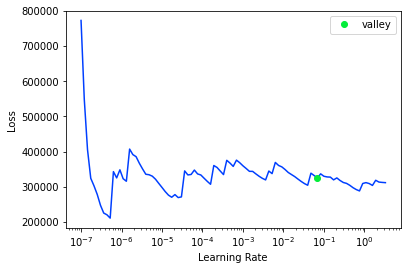

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   96.49      93.05
1  272.22     263.36
2  272.90     221.13
3  176.78     192.26
4  206.34     247.21
XGBoost RMSE:  338.95288


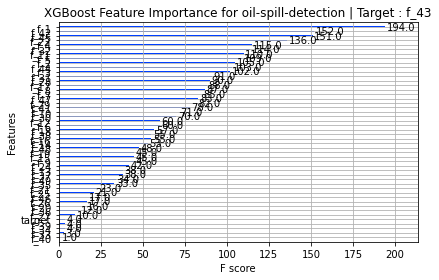

Target Variable: f_42
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:07,  5.15it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8895065745697995, 'Adjusted R-Squared': 0.8499870282480491, 'RMSE': 173.61393801015143, 'Time taken': 0.24122023582458496}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9287717853241534, 'Adjusted R-Squared': 0.9032960005130841, 'RMSE': 139.39346021276802, 'Time taken': 0.15969371795654297}
{'Model': 'BayesianRidge', 'R-Squared': 0.9887350217897464, 'Adjusted R-Squared': 0.9847059419919184, 'RMSE': 55.434680320814486, 'Time taken': 0.03014230728149414}


 10%|▉         | 4/42 [00:00<00:04,  8.43it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.936414257310721, 'Adjusted R-Squared': 0.9136719113853585, 'RMSE': 131.70317463431044, 'Time taken': 0.1159658432006836}
{'Model': 'DummyRegressor', 'R-Squared': -8.118928588074503e-05, 'Adjusted R-Squared': -0.35777446136623214, 'RMSE': 522.31683, 'Time taken': 0.01242828369140625}
{'Model': 'ElasticNet', 'R-Squared': 0.9019018819110832, 'Adjusted R-Squared': 0.8668156936894998, 'RMSE': 163.58621628214067, 'Time taken': 0.02115654945373535}


 17%|█▋        | 7/42 [00:00<00:03,  9.19it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.8762972506781318, 'Adjusted R-Squared': 0.8320532016506024, 'RMSE': 183.6986841408325, 'Time taken': 0.2677958011627197}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8834462813636471, 'Adjusted R-Squared': 0.8417591849170684, 'RMSE': 178.31153411047578, 'Time taken': 0.0659337043762207}


 26%|██▌       | 11/42 [00:01<00:04,  6.20it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9778972511580443, 'Adjusted R-Squared': 0.9699918884335491, 'RMSE': 77.64965200960516, 'Time taken': 0.6980321407318115}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.42638014290993853, 'Adjusted R-Squared': -0.9365453035127631, 'RMSE': 623.7836848252545, 'Time taken': 0.1338508129119873}


 29%|██▊       | 12/42 [00:02<00:08,  3.68it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9574290091874857, 'Adjusted R-Squared': 0.9422028883859296, 'RMSE': 107.76388716767977, 'Time taken': 0.7275893688201904}


 33%|███▎      | 14/42 [00:03<00:08,  3.49it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.7728977270794593, 'Adjusted R-Squared': 0.6916713666918206, 'RMSE': 248.9012684117131, 'Time taken': 0.5571832656860352}
{'Model': 'HuberRegressor', 'R-Squared': 0.9867398525615437, 'Adjusted R-Squared': 0.981997172090855, 'RMSE': 60.143755919098325, 'Time taken': 0.13212275505065918}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7744154220920789, 'Adjusted R-Squared': 0.693731886927932, 'RMSE': 248.06819, 'Time taken': 0.031063079833984375}


 38%|███▊      | 16/42 [00:03<00:05,  5.16it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.32631358355328155, 'Adjusted R-Squared': 0.0853600477438714, 'RMSE': 428.6918872043074, 'Time taken': 0.07668685913085938}
{'Model': 'Lars', 'R-Squared': -5025.989313074657, 'Adjusted R-Squared': -6823.963592933475, 'RMSE': 37031.41868894829, 'Time taken': 0.08891034126281738}


 43%|████▎     | 18/42 [00:03<00:04,  5.97it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9757341064913779, 'Adjusted R-Squared': 0.9670550642875642, 'RMSE': 81.36066939133708, 'Time taken': 0.15158295631408691}
{'Model': 'Lasso', 'R-Squared': 0.9887482408388357, 'Adjusted R-Squared': 0.984723889022069, 'RMSE': 55.40214546589604, 'Time taken': 0.048119544982910156}


 48%|████▊     | 20/42 [00:03<00:03,  6.21it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9887517871905732, 'Adjusted R-Squared': 0.9847287037769826, 'RMSE': 55.39341389886534, 'Time taken': 0.24413394927978516}
{'Model': 'LassoLars', 'R-Squared': 0.981027923844945, 'Adjusted R-Squared': 0.9742422907675895, 'RMSE': 71.94055749725497, 'Time taken': 0.05532479286193848}


 57%|█████▋    | 24/42 [00:04<00:02,  7.72it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9887458280669109, 'Adjusted R-Squared': 0.9847206132879228, 'RMSE': 55.40808522935789, 'Time taken': 0.23852944374084473}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9887038295810759, 'Adjusted R-Squared': 0.9846635934458403, 'RMSE': 55.5113753115942, 'Time taken': 0.08045744895935059}
{'Model': 'LinearRegression', 'R-Squared': 0.9885688713903734, 'Adjusted R-Squared': 0.9844803655372953, 'RMSE': 55.84199492984261, 'Time taken': 0.05934500694274902}
{'Model': 'LinearSVR', 'R-Squared': 0.7838747869040233, 'Adjusted R-Squared': 0.7065745282054623, 'RMSE': 242.8114076140166, 'Time taken': 0.05008983612060547}


 64%|██████▍   | 27/42 [00:06<00:04,  3.08it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.7147179745819465, 'Adjusted R-Squared': 0.6126827976076062, 'RMSE': 278.96747657014697, 'Time taken': 1.7480154037475586}
{'Model': 'NuSVR', 'R-Squared': -0.020905116394677625, 'Adjusted R-Squared': -0.3860463624044528, 'RMSE': 527.7266902455407, 'Time taken': 0.1150510311126709}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9864460607606651, 'Adjusted R-Squared': 0.981598301470684, 'RMSE': 60.806378231520334, 'Time taken': 0.022260189056396484}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9876818051683941, 'Adjusted R-Squared': 0.9832760274549001, 'RMSE': 57.96821184437708, 'Time taken': 0.04647350311279297}


 71%|███████▏  | 30/42 [00:06<00:02,  5.04it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.984274448432911, 'Adjusted R-Squared': 0.9786499810840982, 'RMSE': 65.49668401018292, 'Time taken': 0.037856340408325195}
{'Model': 'PoissonRegressor', 'R-Squared': -3.085721516288822, 'Adjusted R-Squared': -4.54703797101986, 'RMSE': 1055.7248645735299, 'Time taken': 0.09555268287658691}


 76%|███████▌  | 32/42 [00:22<00:24,  2.47s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.09541411986243031, 'Adjusted R-Squared': -0.48720457149205854, 'RMSE': 546.6451971515661, 'Time taken': 15.674896955490112}


 79%|███████▊  | 33/42 [00:22<00:19,  2.12s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.9452977668763808, 'Adjusted R-Squared': 0.9257327345912907, 'RMSE': 122.1571515701532, 'Time taken': 0.4714775085449219}


 88%|████████▊ | 37/42 [00:24<00:05,  1.10s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9429335226229288, 'Adjusted R-Squared': 0.92252288472894, 'RMSE': 124.76905964571654, 'Time taken': 1.464583158493042}
{'Model': 'Ridge', 'R-Squared': 0.9888693017343649, 'Adjusted R-Squared': 0.9848882490700137, 'RMSE': 55.10329567357263, 'Time taken': 0.021237611770629883}
{'Model': 'RidgeCV', 'R-Squared': 0.9888693017342072, 'Adjusted R-Squared': 0.9848882490697995, 'RMSE': 55.10329567396295, 'Time taken': 0.050290584564208984}
{'Model': 'SGDRegressor', 'R-Squared': 0.9886266557977366, 'Adjusted R-Squared': 0.9845588173604307, 'RMSE': 55.7006753409945, 'Time taken': 0.10808277130126953}


 95%|█████████▌| 40/42 [00:24<00:01,  1.47it/s]

{'Model': 'SVR', 'R-Squared': -0.05009404999342548, 'Adjusted R-Squared': -0.42567513356771625, 'RMSE': 535.2177010363218, 'Time taken': 0.06594228744506836}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9885688713903734, 'Adjusted R-Squared': 0.9844803655372953, 'RMSE': 55.84199492984261, 'Time taken': 0.022540569305419922}
{'Model': 'TweedieRegressor', 'R-Squared': 0.8559073747537248, 'Adjusted R-Squared': 0.8043705963809694, 'RMSE': 198.26097899058024, 'Time taken': 0.036013126373291016}
{'Model': 'XGBRegressor', 'R-Squared': 0.9453126255380236, 'Adjusted R-Squared': 0.925752907664762, 'RMSE': 122.14056, 'Time taken': 0.7280211448669434}


100%|██████████| 42/42 [00:25<00:00,  1.66it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.7693044622496805, 'Adjusted R-Squared': 0.6867929195506612, 'RMSE': 250.8626273863916, 'Time taken': 0.22646331787109375}
Project: oil-spill-detection
oil-spill-detection
Target: f_42
f_42
Target Standard Deviation: 755.4384765625
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
Ridge                                        0.98       0.99    55.10   
RidgeCV                                      0.98       0.99    55.10   
LassoCV                                      0.98       0.99    55.39   
Lasso                                        0.98       0.99    55.40   
LassoLarsCV                                  0.98       0.99    55.41   
BayesianRidge                                0.98       0.99    55.43   
LassoLarsIC                                  0.98       0.99    55.51   
SGDRegressor                                 0.98       0.99    55.70 

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 674.0940551757812.
Better model found at epoch 1 with _rmse value: 652.600830078125.
Better model found at epoch 2 with _rmse value: 373.4165954589844.
No improvement since epoch 2: early stopping


<Figure size 432x288 with 0 Axes>

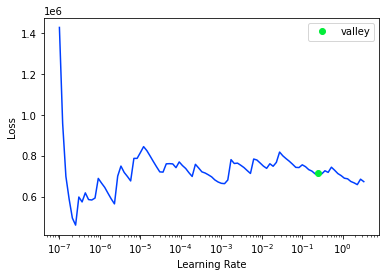

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0 3850.00    4312.92
1  360.56     400.40
2  509.90     585.88
3  339.58     361.79
4  873.21     562.16
XGBoost RMSE:  122.12243


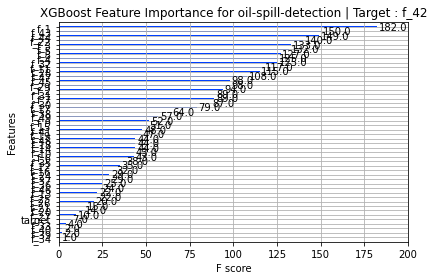

Target Variable: f_41
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:08,  4.68it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8475915979056297, 'Adjusted R-Squared': 0.793080563579906, 'RMSE': 318.61155264658936, 'Time taken': 0.29033803939819336}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9145872802651194, 'Adjusted R-Squared': 0.8840382053234468, 'RMSE': 238.51645151648324, 'Time taken': 0.15899920463562012}


 10%|▉         | 4/42 [00:00<00:04,  7.93it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.8158322661989559, 'Adjusted R-Squared': 0.7499620548394583, 'RMSE': 350.2384612110008, 'Time taken': 0.056989192962646484}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.7848121505039141, 'Adjusted R-Squared': 0.7078471532388906, 'RMSE': 378.58720903848837, 'Time taken': 0.08919453620910645}
{'Model': 'DummyRegressor', 'R-Squared': -2.1567458768911862e-05, 'Adjusted R-Squared': -0.3576935149440219, 'RMSE': 816.1345, 'Time taken': 0.015257596969604492}
{'Model': 'ElasticNet', 'R-Squared': 0.77096791304068, 'Adjusted R-Squared': 0.689051327193916, 'RMSE': 390.5757085510338, 'Time taken': 0.020513534545898438}


 17%|█▋        | 7/42 [00:00<00:03, 10.03it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.7563697494003712, 'Adjusted R-Squared': 0.6692319225435697, 'RMSE': 402.8308011293216, 'Time taken': 0.19672942161560059}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8885513732190329, 'Adjusted R-Squared': 0.848690185538249, 'RMSE': 272.45477577432797, 'Time taken': 0.038283348083496094}


 26%|██▌       | 11/42 [00:01<00:04,  6.22it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9472361098046064, 'Adjusted R-Squared': 0.9283643534573488, 'RMSE': 187.4672756202798, 'Time taken': 0.7620539665222168}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.7627924674798334, 'Adjusted R-Squared': -1.393280284315686, 'RMSE': 1083.571708043216, 'Time taken': 0.12790727615356445}


 29%|██▊       | 12/42 [00:02<00:08,  3.71it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9519920663123258, 'Adjusted R-Squared': 0.9348213455043255, 'RMSE': 178.8189625938658, 'Time taken': 0.7187628746032715}


 33%|███▎      | 14/42 [00:03<00:08,  3.48it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9349041604444166, 'Adjusted R-Squared': 0.9116217068807408, 'RMSE': 208.22538817200032, 'Time taken': 0.5585489273071289}
{'Model': 'HuberRegressor', 'R-Squared': 0.8022541013415256, 'Adjusted R-Squared': 0.731527466054918, 'RMSE': 362.91992000703783, 'Time taken': 0.1405179500579834}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.6969260179047527, 'Adjusted R-Squared': 0.5885272943816351, 'RMSE': 449.29477, 'Time taken': 0.03200101852416992}


 38%|███▊      | 16/42 [00:03<00:04,  5.20it/s]

{'Model': 'KernelRidge', 'R-Squared': -0.4278294025457614, 'Adjusted R-Squared': -0.9385129114854862, 'RMSE': 975.2034399254748, 'Time taken': 0.06657648086547852}
{'Model': 'Lars', 'R-Squared': -556.7331781091235, 'Adjusted R-Squared': -756.214387797788, 'RMSE': 19273.93119310282, 'Time taken': 0.050063133239746094}


 43%|████▎     | 18/42 [00:03<00:03,  6.22it/s]

{'Model': 'LarsCV', 'R-Squared': -2.152832615798239e-05, 'Adjusted R-Squared': -0.3576934618150758, 'RMSE': 816.1345036009596, 'Time taken': 0.15905213356018066}
{'Model': 'Lasso', 'R-Squared': 0.822679779518475, 'Adjusted R-Squared': 0.7592586787623092, 'RMSE': 343.66570508217205, 'Time taken': 0.07718348503112793}


 48%|████▊     | 20/42 [00:04<00:05,  4.09it/s]

{'Model': 'LassoCV', 'R-Squared': 0.8027096176570798, 'Adjusted R-Squared': 0.7321459042643566, 'RMSE': 362.5016780640685, 'Time taken': 0.7294082641601562}
{'Model': 'LassoLars', 'R-Squared': 0.8041914225677378, 'Adjusted R-Squared': 0.7341576977926951, 'RMSE': 361.1377768372129, 'Time taken': 0.03586888313293457}


 57%|█████▋    | 24/42 [00:04<00:02,  6.36it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.8055258845859428, 'Adjusted R-Squared': 0.7359694491458786, 'RMSE': 359.90507151287807, 'Time taken': 0.21745944023132324}
{'Model': 'LassoLarsIC', 'R-Squared': 0.814955064377707, 'Adjusted R-Squared': 0.7487711093011205, 'RMSE': 351.0715736132954, 'Time taken': 0.07394647598266602}
{'Model': 'LinearRegression', 'R-Squared': 0.8090820428595944, 'Adjusted R-Squared': 0.740797518042953, 'RMSE': 356.5992729850023, 'Time taken': 0.029163599014282227}
{'Model': 'LinearSVR', 'R-Squared': 0.13160902548743691, 'Adjusted R-Squared': -0.17898336685647243, 'RMSE': 760.5271361459838, 'Time taken': 0.028623580932617188}


 64%|██████▍   | 27/42 [00:06<00:04,  3.11it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.3182719495324776, 'Adjusted R-Squared': 0.07444220885431274, 'RMSE': 673.8490897246947, 'Time taken': 1.6249916553497314}
{'Model': 'NuSVR', 'R-Squared': -0.02857248151650804, 'Adjusted R-Squared': -0.3964560697961348, 'RMSE': 827.7029719596926, 'Time taken': 0.10980796813964844}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.791138790331358, 'Adjusted R-Squared': 0.7164366058513328, 'RMSE': 372.98035551898334, 'Time taken': 0.019679546356201172}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.7802704605495704, 'Adjusted R-Squared': 0.7016810632278839, 'RMSE': 382.5615221864809, 'Time taken': 0.04463934898376465}


 71%|███████▏  | 30/42 [00:06<00:02,  5.07it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.8163008797935494, 'Adjusted R-Squared': 0.7505982747562058, 'RMSE': 349.7925876623941, 'Time taken': 0.04505467414855957}
{'Model': 'PoissonRegressor', 'R-Squared': -1.0129990893986789, 'Adjusted R-Squared': -1.732976865898936, 'RMSE': 1157.9207945748947, 'Time taken': 0.0881810188293457}


 76%|███████▌  | 32/42 [00:23<00:26,  2.63s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.09499250402934423, 'Adjusted R-Squared': -0.48663215875516785, 'RMSE': 854.009372867163, 'Time taken': 16.811277151107788}


 79%|███████▊  | 33/42 [00:23<00:20,  2.24s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.1488096870089004, 'Adjusted R-Squared': -0.15563064391492354, 'RMSE': 752.9573903970459, 'Time taken': 0.39174509048461914}


 90%|█████████ | 38/42 [00:25<00:04,  1.04s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9493026166962713, 'Adjusted R-Squared': 0.9311699759526019, 'RMSE': 183.75951510491706, 'Time taken': 1.4550635814666748}
{'Model': 'Ridge', 'R-Squared': 0.8180537574912804, 'Adjusted R-Squared': 0.7529780941122493, 'RMSE': 348.1197072565807, 'Time taken': 0.019076824188232422}
{'Model': 'RidgeCV', 'R-Squared': 0.8052774739952747, 'Adjusted R-Squared': 0.7356321909716869, 'RMSE': 360.13485967622904, 'Time taken': 0.0351719856262207}
{'Model': 'SGDRegressor', 'R-Squared': 0.7778176892944207, 'Adjusted R-Squared': 0.6983510234216224, 'RMSE': 384.690803107718, 'Time taken': 0.03367447853088379}
{'Model': 'SVR', 'R-Squared': -0.07266016991108448, 'Adjusted R-Squared': -0.4563123474705233, 'RMSE': 845.2557648036496, 'Time taken': 0.10726809501647949}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.8090820428595944, 'Adjusted R-Squared': 0.740797518042953, 'RMSE': 356.5992729850023, 'Time taken': 0.028097152709960938}
{'Model': 'Tweedi

 98%|█████████▊| 41/42 [00:26<00:00,  1.33it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9134403340166236, 'Adjusted R-Squared': 0.8824810374240292, 'RMSE': 240.11253, 'Time taken': 0.7396664619445801}


100%|██████████| 42/42 [00:26<00:00,  1.58it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9320438662805293, 'Adjusted R-Squared': 0.907738387796923, 'RMSE': 212.75089473479332, 'Time taken': 0.2117772102355957}
Project: oil-spill-detection
oil-spill-detection
Target: f_41
f_41
Target Standard Deviation: 1042.173583984375
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
GradientBoostingRegressor                    0.93       0.95   178.82   
RandomForestRegressor                        0.93       0.95   183.76   
ExtraTreesRegressor                          0.93       0.95   187.47   
HistGradientBoostingRegressor                0.91       0.93   208.23   
LGBMRegressor                                0.91       0.93   212.75   
BaggingRegressor                             0.88       0.91   238.52   
XGBRegressor                                 0.88       0.91   240.11   
ExtraTreeRegressor                           0.85       0.89   272.4

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1238.6888427734375.
Better model found at epoch 1 with _rmse value: 1216.0794677734375.
Better model found at epoch 2 with _rmse value: 805.2943115234375.
No improvement since epoch 2: early stopping


<Figure size 432x288 with 0 Axes>

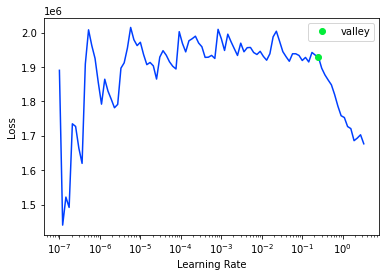

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0  743.30     775.89
1  829.76     789.76
2  559.02     556.08
3  471.70     414.64
4  570.09     544.59
XGBoost RMSE:  240.04655


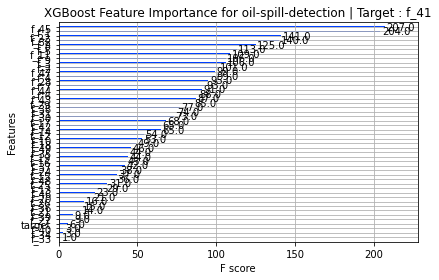

Target Variable: f_40
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
50
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'ta

  7%|▋         | 3/42 [00:00<00:04,  9.48it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.2607302665710449}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9997672134775513, 'Adjusted R-Squared': 0.9996839540644127, 'RMSE': 0.03799802978286741, 'Time taken': 0.07549500465393066}
{'Model': 'BayesianRidge', 'R-Squared': 0.9976104574637077, 'Adjusted R-Squared': 0.996755803563866, 'RMSE': 0.12174175144154942, 'Time taken': 0.02525019645690918}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.07194948196411133}


 12%|█▏        | 5/42 [00:00<00:03, 12.27it/s]

{'Model': 'DummyRegressor', 'R-Squared': -0.0002122730386475702, 'Adjusted R-Squared': -0.35795242908896663, 'RMSE': 2.4907391787510904, 'Time taken': 0.04364919662475586}
{'Model': 'ElasticNet', 'R-Squared': 0.8131547867207529, 'Adjusted R-Squared': 0.7463269367157668, 'RMSE': 1.076522597692518, 'Time taken': 0.03537344932556152}


 17%|█▋        | 7/42 [00:00<00:04,  7.99it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9969292381956356, 'Adjusted R-Squared': 0.9958309365283812, 'RMSE': 0.1380083067759454, 'Time taken': 0.3321831226348877}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.029329776763916016}


 26%|██▌       | 11/42 [00:01<00:03,  8.70it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.999975083220375, 'Adjusted R-Squared': 0.9999661713794872, 'RMSE': 0.012431631210161215, 'Time taken': 0.22609281539916992}
{'Model': 'GammaRegressor', 'R-Squared': 0.8592939518465814, 'Adjusted R-Squared': 0.8089684309741909, 'RMSE': 0.9341971658346435, 'Time taken': 0.02864837646484375}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.6911306176277066, 'Adjusted R-Squared': -2.6536517874361563, 'RMSE': 4.085540793476336, 'Time taken': 0.15415644645690918}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.999950773962615, 'Adjusted R-Squared': 0.9999331675696816, 'RMSE': 0.01747348780184341, 'Time taken': 0.7035431861877441}


 33%|███▎      | 14/42 [00:02<00:06,  4.30it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9999702826801351, 'Adjusted R-Squared': 0.9999596538577017, 'RMSE': 0.013576473679058862, 'Time taken': 0.3776860237121582}
{'Model': 'HuberRegressor', 'R-Squared': 0.9974874856582745, 'Adjusted R-Squared': 0.9965888491418909, 'RMSE': 0.1248350206000623, 'Time taken': 0.12389922142028809}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9392685828100362, 'Adjusted R-Squared': 0.9175471270267646, 'RMSE': 0.6137462765496908, 'Time taken': 0.03172659873962402}


 38%|███▊      | 16/42 [00:02<00:04,  5.90it/s]

{'Model': 'KernelRidge', 'R-Squared': -1.678795496648763, 'Adjusted R-Squared': -2.6369048348662036, 'RMSE': 4.076166755484551, 'Time taken': 0.07385063171386719}
{'Model': 'Lars', 'R-Squared': -174.14471710843335, 'Adjusted R-Squared': -236.787718118019, 'RMSE': 32.95950522819005, 'Time taken': 0.08772754669189453}


 43%|████▎     | 18/42 [00:02<00:03,  6.52it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9835525654507661, 'Adjusted R-Squared': 0.9776699063784123, 'RMSE': 0.31939730399136085, 'Time taken': 0.15173625946044922}
{'Model': 'Lasso', 'R-Squared': 0.7542903577727533, 'Adjusted R-Squared': 0.6664088069031542, 'RMSE': 1.2345061628114764, 'Time taken': 0.03977012634277344}


 48%|████▊     | 20/42 [00:03<00:03,  6.67it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9968721234797817, 'Adjusted R-Squared': 0.9957533939214555, 'RMSE': 0.1392858383596246, 'Time taken': 0.243499755859375}
{'Model': 'LassoLars', 'R-Squared': -0.0002122730386475702, 'Adjusted R-Squared': -0.35795242908896663, 'RMSE': 2.4907391787510904, 'Time taken': 0.027263402938842773}


 57%|█████▋    | 24/42 [00:03<00:02,  8.22it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9974417874881355, 'Adjusted R-Squared': 0.9965268063707533, 'RMSE': 0.1259651684828711, 'Time taken': 0.24500823020935059}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9976337037343416, 'Adjusted R-Squared': 0.9967873641940695, 'RMSE': 0.12114813190110628, 'Time taken': 0.09734034538269043}
{'Model': 'LinearRegression', 'R-Squared': 0.9976277182493453, 'Adjusted R-Squared': 0.9967792379151695, 'RMSE': 0.1213012556594847, 'Time taken': 0.03499150276184082}
{'Model': 'LinearSVR', 'R-Squared': 0.9970762645746066, 'Adjusted R-Squared': 0.9960305489845024, 'RMSE': 0.13466390297169262, 'Time taken': 0.19986224174499512}


 64%|██████▍   | 27/42 [00:05<00:04,  3.06it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9539606722148117, 'Adjusted R-Squared': 0.9374940513281386, 'RMSE': 0.5343756366771522, 'Time taken': 1.6356313228607178}
{'Model': 'NuSVR', 'R-Squared': 0.9487800933902331, 'Adjusted R-Squared': 0.9304605647487836, 'RMSE': 0.5636396722401037, 'Time taken': 0.13485383987426758}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.995306984872183, 'Adjusted R-Squared': 0.9936284612133288, 'RMSE': 0.17061143650018087, 'Time taken': 0.02434825897216797}


 71%|███████▏  | 30/42 [00:05<00:02,  4.92it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9959175120667689, 'Adjusted R-Squared': 0.994457352149044, 'RMSE': 0.15912727196801735, 'Time taken': 0.05912518501281738}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.995052028618824, 'Adjusted R-Squared': 0.9932823162270166, 'RMSE': 0.17518452989052033, 'Time taken': 0.0473330020904541}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9294304709393156, 'Adjusted R-Squared': 0.9041902744139614, 'RMSE': 0.6615928029543037, 'Time taken': 0.054326772689819336}


 79%|███████▊  | 33/42 [00:15<00:11,  1.26s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.19755733216384685, 'Adjusted R-Squared': -0.6258807575363174, 'RMSE': 2.725400426854389, 'Time taken': 9.135535478591919}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9969080795167643, 'Adjusted R-Squared': 0.9958022101468479, 'RMSE': 0.13848295456541057, 'Time taken': 0.1377851963043213}


 88%|████████▊ | 37/42 [00:15<00:03,  1.57it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.999771351904617, 'Adjusted R-Squared': 0.9996895726588231, 'RMSE': 0.03765875486765085, 'Time taken': 0.650188684463501}
{'Model': 'Ridge', 'R-Squared': 0.9973269127475617, 'Adjusted R-Squared': 0.9963708450441349, 'RMSE': 0.12876230128946806, 'Time taken': 0.018267393112182617}
{'Model': 'RidgeCV', 'R-Squared': 0.9976027065264254, 'Adjusted R-Squared': 0.996745280393541, 'RMSE': 0.12193903789016976, 'Time taken': 0.04964733123779297}
{'Model': 'SGDRegressor', 'R-Squared': 0.994830585386451, 'Adjusted R-Squared': 0.992981670670656, 'RMSE': 0.17906175867617305, 'Time taken': 0.07618498802185059}


 95%|█████████▌| 40/42 [00:15<00:00,  2.47it/s]

{'Model': 'SVR', 'R-Squared': 0.948594388011586, 'Adjusted R-Squared': 0.9302084391982117, 'RMSE': 0.5646605274337988, 'Time taken': 0.07378506660461426}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9976277182493453, 'Adjusted R-Squared': 0.9967792379151695, 'RMSE': 0.1213012556594847, 'Time taken': 0.022153615951538086}
{'Model': 'TweedieRegressor', 'R-Squared': 0.8854203446631065, 'Adjusted R-Squared': 0.8444393000535606, 'RMSE': 0.8430161959153238, 'Time taken': 0.052618980407714844}


100%|██████████| 42/42 [00:16<00:00,  2.51it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9999999996975025, 'Adjusted R-Squared': 0.99999999958931, 'RMSE': 4.3315467e-05, 'Time taken': 0.5456454753875732}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9999720684639407, 'Adjusted R-Squared': 0.9999620783525034, 'RMSE': 0.013162232938748308, 'Time taken': 0.18821978569030762}
Project: oil-spill-detection
oil-spill-detection
Target: f_40
f_40
Target Standard Deviation: 2.44710840698886
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.26
ExtraTreeRegressor                           1.00       1.00  0.00        0.03
DecisionTreeRegressor                        1.00       1.00  0.00        0.07
XGBRegressor                                 1.00       1.00  0.00        0.55
ExtraTreesRegressor                          1.00       1.00  0.01        0.23
LGBMRegressor

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 2.9976069927215576.
Better model found at epoch 1 with _rmse value: 2.568798303604126.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       8       8.00
1       2       2.00
2       4       4.00
3       3       3.00
4       1       1.00
XGBoost RMSE:  4.3315467e-05


<Figure size 432x288 with 0 Axes>

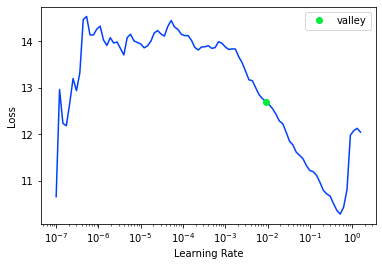

<Figure size 720x720 with 0 Axes>

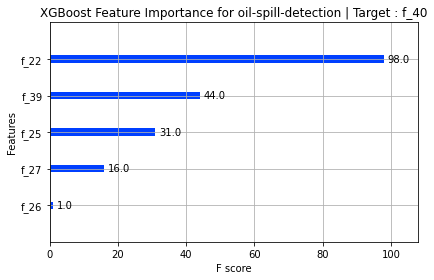

Target Variable: f_39
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
50
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'ta

  7%|▋         | 3/42 [00:00<00:05,  7.34it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.3707449436187744}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9997534174322008, 'Adjusted R-Squared': 0.9996652236670756, 'RMSE': 0.040053440237591394, 'Time taken': 0.08043789863586426}
{'Model': 'BayesianRidge', 'R-Squared': 0.9983019629465956, 'Adjusted R-Squared': 0.9976946358253049, 'RMSE': 0.10510714028472537, 'Time taken': 0.026680946350097656}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.04120063781738281}
{'Model': 'DummyRegressor', 'R-Squared': -0.002190501410926915, 'Adjusted R-Squared': -0.3606381989958569, 'RMSE': 2.553487756368754, 'Time taken': 0.024389266967773438}
{'Model': 'ElasticNet', 'R-Squared': 0.8112599288604201, 'Adjusted R-Squared': 0.7437543559710813, 'RMSE': 1.108129957528858, 'Time taken': 0.030588150024414062}


 17%|█▋        | 7/42 [00:00<00:03,  9.41it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9969079685724889, 'Adjusted R-Squared': 0.9958020595217733, 'RMSE': 0.14183407752370453, 'Time taken': 0.26388001441955566}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03675198554992676}


 21%|██▏       | 9/42 [00:01<00:03,  8.73it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9999666291591578, 'Adjusted R-Squared': 0.9999546936029442, 'RMSE': 0.014734731061856621, 'Time taken': 0.2234632968902588}
{'Model': 'GammaRegressor', 'R-Squared': 0.86909451665938, 'Adjusted R-Squared': 0.8222743072893772, 'RMSE': 0.9228636877179615, 'Time taken': 0.027849435806274414}


 26%|██▌       | 11/42 [00:01<00:03,  8.98it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.7131269220805128, 'Adjusted R-Squared': -2.6835153832625935, 'RMSE': 4.201396739908857, 'Time taken': 0.17933988571166992}


 29%|██▊       | 12/42 [00:02<00:06,  4.57it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999693046944306, 'Adjusted R-Squared': 0.9999583260814897, 'RMSE': 0.014131706831874168, 'Time taken': 0.6861567497253418}


 33%|███▎      | 14/42 [00:02<00:06,  4.31it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9999040847505657, 'Adjusted R-Squared': 0.9998697792963884, 'RMSE': 0.024980577200904467, 'Time taken': 0.42595672607421875}
{'Model': 'HuberRegressor', 'R-Squared': 0.9981767981543549, 'Adjusted R-Squared': 0.9975247040635767, 'RMSE': 0.10891207055171949, 'Time taken': 0.1294691562652588}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9277677464726826, 'Adjusted R-Squared': 0.9019328528753209, 'RMSE': 0.685526457596037, 'Time taken': 0.030605554580688477}


 38%|███▊      | 16/42 [00:02<00:04,  6.16it/s]

{'Model': 'KernelRidge', 'R-Squared': -1.6464812962841915, 'Adjusted R-Squared': -2.5930330007945956, 'RMSE': 4.149474052386021, 'Time taken': 0.07602882385253906}
{'Model': 'Lars', 'R-Squared': -11161.531732379894, 'Adjusted R-Squared': -15153.970089216496, 'RMSE': 269.48834787917593, 'Time taken': 0.09071016311645508}


 43%|████▎     | 18/42 [00:02<00:03,  6.67it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9939915523983169, 'Adjusted R-Squared': 0.9918425455918756, 'RMSE': 0.19771507223436124, 'Time taken': 0.16175389289855957}
{'Model': 'Lasso', 'R-Squared': 0.7653466409035226, 'Adjusted R-Squared': 0.6814195270660963, 'RMSE': 1.2355832905514033, 'Time taken': 0.029538631439208984}


 48%|████▊     | 20/42 [00:03<00:03,  6.66it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9971049045322209, 'Adjusted R-Squared': 0.9960694324306064, 'RMSE': 0.13724296228910077, 'Time taken': 0.2622690200805664}
{'Model': 'LassoLars', 'R-Squared': -0.002190501410926915, 'Adjusted R-Squared': -0.3606381989958569, 'RMSE': 2.553487756368754, 'Time taken': 0.02923130989074707}


 57%|█████▋    | 24/42 [00:03<00:02,  8.65it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.998315356131598, 'Adjusted R-Squared': 0.9977128192735565, 'RMSE': 0.10469180594232522, 'Time taken': 0.23926043510437012}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9982839202624181, 'Adjusted R-Squared': 0.9976701399183194, 'RMSE': 0.1056640786265793, 'Time taken': 0.07363343238830566}
{'Model': 'LinearRegression', 'R-Squared': 0.9982805658373958, 'Adjusted R-Squared': 0.9976655857354424, 'RMSE': 0.10576729911900952, 'Time taken': 0.027770519256591797}
{'Model': 'LinearSVR', 'R-Squared': 0.9978533450745326, 'Adjusted R-Squared': 0.9970855633858617, 'RMSE': 0.11817884939445006, 'Time taken': 0.18508243560791016}


 64%|██████▍   | 27/42 [00:05<00:04,  3.02it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9839747241953765, 'Adjusted R-Squared': 0.9782430562068615, 'RMSE': 0.3228950557528743, 'Time taken': 1.6897399425506592}
{'Model': 'NuSVR', 'R-Squared': 0.9483088505197561, 'Adjusted R-Squared': 0.929820775158209, 'RMSE': 0.5799181931638271, 'Time taken': 0.13254117965698242}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.995497874586004, 'Adjusted R-Squared': 0.9938876253503413, 'RMSE': 0.17114626788080795, 'Time taken': 0.02430129051208496}


 71%|███████▏  | 30/42 [00:05<00:02,  4.97it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9961771704792601, 'Adjusted R-Squared': 0.9948098810886306, 'RMSE': 0.15770704859435528, 'Time taken': 0.045597076416015625}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9971570649741474, 'Adjusted R-Squared': 0.9961402487970176, 'RMSE': 0.13600100127514933, 'Time taken': 0.03604578971862793}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9310006028914337, 'Adjusted R-Squared': 0.906321986407348, 'RMSE': 0.6700100031599587, 'Time taken': 0.04375195503234863}


 76%|███████▌  | 32/42 [00:14<00:14,  1.46s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.24688585114654793, 'Adjusted R-Squared': -0.6928523234544373, 'RMSE': 2.8482098702657255, 'Time taken': 8.924243927001953}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9645358186277752, 'Adjusted R-Squared': 0.9518515493778553, 'RMSE': 0.48034536937752914, 'Time taken': 0.047801971435546875}


 90%|█████████ | 38/42 [00:15<00:02,  1.58it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.999498944222232, 'Adjusted R-Squared': 0.9993197344914974, 'RMSE': 0.05709547309663306, 'Time taken': 0.6154031753540039}
{'Model': 'Ridge', 'R-Squared': 0.9981679298164728, 'Adjusted R-Squared': 0.997512663838423, 'RMSE': 0.10917663186645098, 'Time taken': 0.015674591064453125}
{'Model': 'RidgeCV', 'R-Squared': 0.998315986821961, 'Adjusted R-Squared': 0.9977136755393047, 'RMSE': 0.10467220705400353, 'Time taken': 0.045119285583496094}
{'Model': 'SGDRegressor', 'R-Squared': 0.9937049737841979, 'Adjusted R-Squared': 0.9914534680573781, 'RMSE': 0.20237525557547031, 'Time taken': 0.03678441047668457}
{'Model': 'SVR', 'R-Squared': 0.9475468705589379, 'Adjusted R-Squared': 0.9287862622187041, 'RMSE': 0.5841768474748751, 'Time taken': 0.09585237503051758}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9982805658373958, 'Adjusted R-Squared': 0.9976655857354424, 'RMSE': 0.10576729911900952, 'Time taken': 0.018791913986206055}
{'Model': 

100%|██████████| 42/42 [00:16<00:00,  2.56it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9999999996054735, 'Adjusted R-Squared': 0.9999999994643655, 'RMSE': 5.0663682e-05, 'Time taken': 0.5576784610748291}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9998693155688132, 'Adjusted R-Squared': 0.9998225744218924, 'RMSE': 0.02915886160565042, 'Time taken': 0.1879408359527588}
Project: oil-spill-detection
oil-spill-detection
Target: f_39
f_39
Target Standard Deviation: 2.464297601075541
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
AdaBoostRegressor                            1.00       1.00   0.00   
ExtraTreeRegressor                           1.00       1.00   0.00   
DecisionTreeRegressor                        1.00       1.00   0.00   
XGBRegressor                                 1.00       1.00   0.00   
GradientBoostingRegressor                    1.00       1.00   0.01   
ExtraTreesRegressor                          1.00       1.00   0.01 

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 3.1609511375427246.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       2.00
1       3       3.00
2       4       4.00
3       7       7.00
4       7       7.00
XGBoost RMSE:  5.0663682e-05


<Figure size 432x288 with 0 Axes>

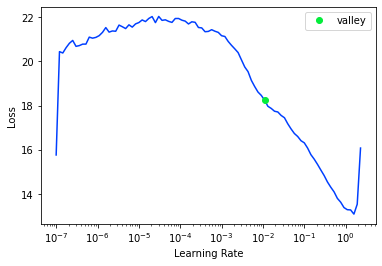

<Figure size 720x720 with 0 Axes>

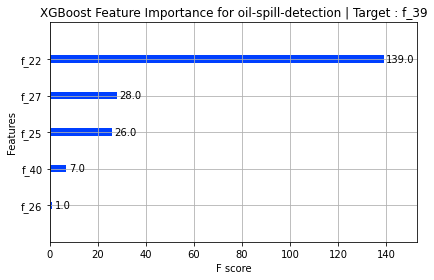

Target Variable: f_38
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:08,  4.94it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.7692517664176983, 'Adjusted R-Squared': 0.6867213763043204, 'RMSE': 14.98801540374566, 'Time taken': 0.26988959312438965}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8872815942341568, 'Adjusted R-Squared': 0.8469662520259355, 'RMSE': 10.475442010653463, 'Time taken': 0.1539161205291748}
{'Model': 'BayesianRidge', 'R-Squared': 0.9360447484956161, 'Adjusted R-Squared': 0.9131702424830993, 'RMSE': 7.890654790452925, 'Time taken': 0.04490184783935547}


 10%|▉         | 4/42 [00:00<00:04,  8.45it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.8170136764807616, 'Adjusted R-Squared': 0.7515660133242457, 'RMSE': 13.347018240669815, 'Time taken': 0.09004950523376465}
{'Model': 'DummyRegressor', 'R-Squared': -0.0025986055620974557, 'Adjusted R-Squared': -0.3611922674054753, 'RMSE': 31.241974, 'Time taken': 0.0175628662109375}
{'Model': 'ElasticNet', 'R-Squared': 0.7901507782603315, 'Adjusted R-Squared': 0.7150952172001581, 'RMSE': 14.293171991334223, 'Time taken': 0.01931166648864746}


 17%|█▋        | 7/42 [00:00<00:03,  9.08it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9154112566849515, 'Adjusted R-Squared': 0.8851568886379634, 'RMSE': 9.074678019337663, 'Time taken': 0.2689030170440674}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.7561859301843143, 'Adjusted R-Squared': 0.6689823577684852, 'RMSE': 15.4065117735051, 'Time taken': 0.03912973403930664}


 26%|██▌       | 11/42 [00:01<00:05,  5.64it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.922298829692705, 'Adjusted R-Squared': 0.8945079001667382, 'RMSE': 8.697385463994705, 'Time taken': 0.8022782802581787}
{'Model': 'GammaRegressor', 'R-Squared': 0.7635578220145225, 'Adjusted R-Squared': 0.6789909116401547, 'RMSE': 15.171810646567204, 'Time taken': 0.028661012649536133}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.7401107381647232, 'Adjusted R-Squared': -1.3624861116688942, 'RMSE': 41.158864204958675, 'Time taken': 0.15331387519836426}


 29%|██▊       | 12/42 [00:02<00:08,  3.58it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9405539027619981, 'Adjusted R-Squared': 0.9192921599542456, 'RMSE': 7.607406301658251, 'Time taken': 0.6996774673461914}


 33%|███▎      | 14/42 [00:03<00:08,  3.47it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.8801828553274118, 'Adjusted R-Squared': 0.8373285481087489, 'RMSE': 10.80026523544082, 'Time taken': 0.5381484031677246}
{'Model': 'HuberRegressor', 'R-Squared': 0.9319437683605342, 'Adjusted R-Squared': 0.9076024884310901, 'RMSE': 8.139709156478093, 'Time taken': 0.1311628818511963}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.6530412815960758, 'Adjusted R-Squared': 0.5289465574954022, 'RMSE': 18.37866, 'Time taken': 0.03389930725097656}


 40%|████      | 17/42 [00:03<00:04,  5.83it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.009802607296501176, 'Adjusted R-Squared': -0.34435558425438506, 'RMSE': 31.048157115536462, 'Time taken': 0.05562949180603027}
{'Model': 'Lars', 'R-Squared': -26291.161814182793, 'Adjusted R-Squared': -35694.92771852554, 'RMSE': 5059.272670665557, 'Time taken': 0.071685791015625}


 43%|████▎     | 18/42 [00:03<00:04,  5.82it/s]

{'Model': 'LarsCV', 'R-Squared': 0.7476701239490913, 'Adjusted R-Squared': 0.6574207522228539, 'RMSE': 15.673257738179686, 'Time taken': 0.15935420989990234}
{'Model': 'Lasso', 'R-Squared': 0.9188746063187361, 'Adjusted R-Squared': 0.8898589545641234, 'RMSE': 8.886962485267848, 'Time taken': 0.0420684814453125}


 48%|████▊     | 20/42 [00:04<00:05,  4.15it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9367007631242571, 'Adjusted R-Squared': 0.9140608900811081, 'RMSE': 7.850081675409512, 'Time taken': 0.685002326965332}
{'Model': 'LassoLars', 'R-Squared': -0.002598584383772584, 'Adjusted R-Squared': -0.3611922386524211, 'RMSE': 31.24197508710056, 'Time taken': 0.03063225746154785}


 57%|█████▋    | 24/42 [00:04<00:02,  6.19it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9379288617931771, 'Adjusted R-Squared': 0.915728235719204, 'RMSE': 7.773557096617722, 'Time taken': 0.27537107467651367}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9376586268468698, 'Adjusted R-Squared': 0.9153613473979401, 'RMSE': 7.790460325751872, 'Time taken': 0.0809476375579834}
{'Model': 'LinearRegression', 'R-Squared': 0.9361983220089813, 'Adjusted R-Squared': 0.91337874374942, 'RMSE': 7.881175319371707, 'Time taken': 0.031151771545410156}
{'Model': 'LinearSVR', 'R-Squared': 0.9517473348274316, 'Adjusted R-Squared': 0.9344890823204546, 'RMSE': 6.853865714977645, 'Time taken': 0.07386302947998047}


 64%|██████▍   | 27/42 [00:06<00:04,  3.00it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9093938638378128, 'Adjusted R-Squared': 0.8769872895900233, 'RMSE': 9.391906135616017, 'Time taken': 1.63773512840271}
{'Model': 'NuSVR', 'R-Squared': 0.24138831057228438, 'Adjusted R-Squared': -0.029939957909161263, 'RMSE': 27.175948035879294, 'Time taken': 0.10796070098876953}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9283926134333649, 'Adjusted R-Squared': 0.902781212398583, 'RMSE': 8.349372748007069, 'Time taken': 0.020137786865234375}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9192643001345423, 'Adjusted R-Squared': 0.8903880279198896, 'RMSE': 8.86559209104081, 'Time taken': 0.04611945152282715}


 71%|███████▏  | 30/42 [00:06<00:02,  4.95it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.8877148304744179, 'Adjusted R-Squared': 0.8475544413740272, 'RMSE': 10.455291307266881, 'Time taken': 0.03792977333068848}
{'Model': 'PoissonRegressor', 'R-Squared': 0.3875365003010801, 'Adjusted R-Squared': 0.1684802120875979, 'RMSE': 24.418278573383482, 'Time taken': 0.09689450263977051}


 76%|███████▌  | 32/42 [00:20<00:21,  2.19s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.08522769736419789, 'Adjusted R-Squared': -0.473374829998108, 'RMSE': 32.503892493329154, 'Time taken': 13.714066982269287}


 79%|███████▊  | 33/42 [00:20<00:16,  1.88s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.5404593089522975, 'Adjusted R-Squared': 0.3760980398914405, 'RMSE': 21.151293161584537, 'Time taken': 0.4049220085144043}


 88%|████████▊ | 37/42 [00:22<00:05,  1.04s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9049922044711455, 'Adjusted R-Squared': 0.8710113140995114, 'RMSE': 9.61733089815611, 'Time taken': 1.464745044708252}
{'Model': 'Ridge', 'R-Squared': 0.9349227518679738, 'Adjusted R-Squared': 0.9116469477915556, 'RMSE': 7.959568565587724, 'Time taken': 0.019980669021606445}
{'Model': 'RidgeCV', 'R-Squared': 0.9349227518684133, 'Adjusted R-Squared': 0.9116469477921524, 'RMSE': 7.959568565560847, 'Time taken': 0.07743144035339355}
{'Model': 'SGDRegressor', 'R-Squared': 0.9434065600802902, 'Adjusted R-Squared': 0.9231651107659414, 'RMSE': 7.42263293742937, 'Time taken': 0.06061983108520508}


 90%|█████████ | 38/42 [00:22<00:03,  1.16it/s]

{'Model': 'SVR', 'R-Squared': 0.24091581095550685, 'Adjusted R-Squared': -0.030581453739238817, 'RMSE': 27.18440995809532, 'Time taken': 0.09409379959106445}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9361983220089813, 'Adjusted R-Squared': 0.91337874374942, 'RMSE': 7.881175319371707, 'Time taken': 0.024603843688964844}
{'Model': 'TweedieRegressor', 'R-Squared': 0.7411026074396236, 'Adjusted R-Squared': 0.6485042699545256, 'RMSE': 15.875915418788114, 'Time taken': 0.06853890419006348}


 98%|█████████▊| 41/42 [00:23<00:00,  1.66it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.811856474893445, 'Adjusted R-Squared': 0.7445642651838014, 'RMSE': 13.533795, 'Time taken': 0.7385146617889404}


100%|██████████| 42/42 [00:23<00:00,  1.77it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.8610378578167894, 'Adjusted R-Squared': 0.8113360697366631, 'RMSE': 11.631164242663909, 'Time taken': 0.22445344924926758}
Project: oil-spill-detection
oil-spill-detection
Target: f_38
f_38
Target Standard Deviation: 31.65073013305664
                               Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
LinearSVR                                    0.93       0.95    6.85   
SGDRegressor                                 0.92       0.94    7.42   
GradientBoostingRegressor                    0.92       0.94    7.61   
LassoLarsCV                                  0.92       0.94    7.77   
LassoLarsIC                                  0.92       0.94    7.79   
LassoCV                                      0.91       0.94    7.85   
TransformedTargetRegressor                   0.91       0.94    7.88   
LinearRegression                             0.91       0.94    7.88   
Bay

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 41.6401252746582.
Better model found at epoch 1 with _rmse value: 31.19068145751953.
Better model found at epoch 2 with _rmse value: 28.684417724609375.
No improvement since epoch 2: early stopping


<Figure size 432x288 with 0 Axes>

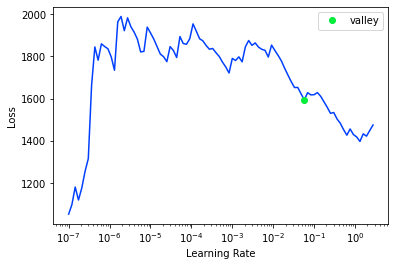

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   23.42      24.74
1   37.87      39.62
2   11.24      12.08
3   24.54      23.35
4   57.10      53.59
XGBoost RMSE:  13.538722


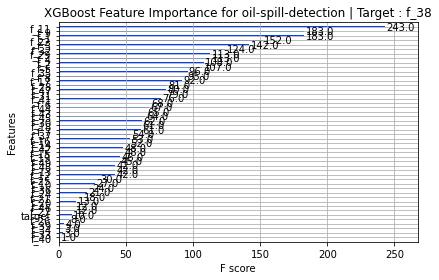

Target Variable: f_37
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
50
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'ta

  5%|▍         | 2/42 [00:00<00:08,  4.68it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.43581134030732427, 'Adjusted R-Squared': 0.23402123574571043, 'RMSE': 0.39466100452472797, 'Time taken': 0.3550248146057129}
{'Model': 'BaggingRegressor', 'R-Squared': 0.554291485394655, 'Adjusted R-Squared': 0.3948774911197507, 'RMSE': 0.35078216651113553, 'Time taken': 0.1135096549987793}
{'Model': 'BayesianRidge', 'R-Squared': 0.3787693671811315, 'Adjusted R-Squared': 0.15657738901963847, 'RMSE': 0.4141316970022831, 'Time taken': 0.029364347457885742}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.3995235135695049, 'Adjusted R-Squared': 0.18475455126954687, 'RMSE': 0.4071552542575359, 'Time taken': 0.04884696006774902}


 12%|█▏        | 5/42 [00:00<00:03, 11.27it/s]

{'Model': 'DummyRegressor', 'R-Squared': -0.00018710752019890364, 'Adjusted R-Squared': -0.35791826276464955, 'RMSE': 0.5254757355607408, 'Time taken': 0.03778505325317383}
{'Model': 'ElasticNet', 'R-Squared': -0.00018710752019890364, 'Adjusted R-Squared': -0.35791826276464955, 'RMSE': 0.5254757355607408, 'Time taken': 0.03328871726989746}


 17%|█▋        | 7/42 [00:01<00:07,  4.81it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.4026852805144956, 'Adjusted R-Squared': 0.18904716916566566, 'RMSE': 0.4060819157370665, 'Time taken': 0.72735595703125}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.3995235135695049, 'Adjusted R-Squared': 0.18475455126954687, 'RMSE': 0.4071552542575359, 'Time taken': 0.0335698127746582}


 21%|██▏       | 9/42 [00:01<00:06,  4.79it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.7018304951315517, 'Adjusted R-Squared': 0.5951859276968512, 'RMSE': 0.28690865713691344, 'Time taken': 0.38150453567504883}
{'Model': 'GammaRegressor', 'R-Squared': 0.36001865586647164, 'Adjusted R-Squared': 0.13112021891360393, 'RMSE': 0.42033513930721356, 'Time taken': 0.02752542495727539}


 26%|██▌       | 11/42 [00:01<00:05,  5.70it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -4.8052249231281365, 'Adjusted R-Squared': -6.881546245998783, 'RMSE': 1.2659646132081912, 'Time taken': 0.19203591346740723}


 29%|██▊       | 12/42 [00:02<00:08,  3.48it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.6865155464302801, 'Adjusted R-Squared': 0.5743933696060738, 'RMSE': 0.2941846746551724, 'Time taken': 0.7384283542633057}


 33%|███▎      | 14/42 [00:03<00:08,  3.49it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.634398162318105, 'Adjusted R-Squared': 0.5036354612493981, 'RMSE': 0.317699276437808, 'Time taken': 0.5102777481079102}
{'Model': 'HuberRegressor', 'R-Squared': 0.35055072876119886, 'Adjusted R-Squared': 0.1182659529166642, 'RMSE': 0.4234329572194545, 'Time taken': 0.12700891494750977}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.17947793660658795, 'Adjusted R-Squared': -0.11399345832974173, 'RMSE': 0.47594544243129694, 'Time taken': 0.03162264823913574}


 40%|████      | 17/42 [00:03<00:04,  6.03it/s]

{'Model': 'KernelRidge', 'R-Squared': -10.02255833314351, 'Adjusted R-Squared': -13.964933211421114, 'RMSE': 1.7444287819324344, 'Time taken': 0.0518794059753418}
{'Model': 'Lars', 'R-Squared': -105368451.10568406, 'Adjusted R-Squared': -143054977.77122068, 'RMSE': 5393.458492491731, 'Time taken': 0.05658316612243652}


 45%|████▌     | 19/42 [00:03<00:03,  6.70it/s]

{'Model': 'LarsCV', 'R-Squared': 0.2918874883044027, 'Adjusted R-Squared': 0.038620969522765836, 'RMSE': 0.44214342867013184, 'Time taken': 0.17898917198181152}
{'Model': 'Lasso', 'R-Squared': -0.00018710752019890364, 'Adjusted R-Squared': -0.35791826276464955, 'RMSE': 0.5254757355607408, 'Time taken': 0.041381120681762695}


 48%|████▊     | 20/42 [00:04<00:06,  3.52it/s]

{'Model': 'LassoCV', 'R-Squared': 0.40232439131177544, 'Adjusted R-Squared': 0.1885572028028485, 'RMSE': 0.40620457172122465, 'Time taken': 0.8549659252166748}
{'Model': 'LassoLars', 'R-Squared': -0.00018710752019890364, 'Adjusted R-Squared': -0.35791826276464955, 'RMSE': 0.5254757355607408, 'Time taken': 0.04707026481628418}


 57%|█████▋    | 24/42 [00:05<00:03,  5.60it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.3968265928957996, 'Adjusted R-Squared': 0.18109303853006375, 'RMSE': 0.40806855833588, 'Time taken': 0.25565385818481445}
{'Model': 'LassoLarsIC', 'R-Squared': 0.3871097795189088, 'Adjusted R-Squared': 0.16790086854392006, 'RMSE': 0.41134231368582735, 'Time taken': 0.08748579025268555}
{'Model': 'LinearRegression', 'R-Squared': 0.3906378658992019, 'Adjusted R-Squared': 0.1726908252354129, 'RMSE': 0.4101566643466041, 'Time taken': 0.030516386032104492}


 60%|█████▉    | 25/42 [00:05<00:02,  5.70it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.2626132476847687, 'Adjusted R-Squared': -0.001123619931627795, 'RMSE': 0.45119024998151197, 'Time taken': 0.16125226020812988}


 64%|██████▍   | 27/42 [00:06<00:06,  2.44it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.037818498945704326, 'Adjusted R-Squared': -0.30631941019050357, 'RMSE': 0.5153954048329213, 'Time taken': 1.6581542491912842}
{'Model': 'NuSVR', 'R-Squared': 0.37908124889247685, 'Adjusted R-Squared': 0.15700081966423873, 'RMSE': 0.41402772891823625, 'Time taken': 0.1292130947113037}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.3558574973324684, 'Adjusted R-Squared': 0.12547076280174552, 'RMSE': 0.42169943472176397, 'Time taken': 0.018908977508544922}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.3558574973324684, 'Adjusted R-Squared': 0.12547076280174552, 'RMSE': 0.42169943472176397, 'Time taken': 0.04490399360656738}


 74%|███████▍  | 31/42 [00:07<00:02,  5.16it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.42145011828364765, 'Adjusted R-Squared': -0.929851985406996, 'RMSE': 0.6264376514404, 'Time taken': 0.0330815315246582}
{'Model': 'PoissonRegressor', 'R-Squared': 0.3837346713107723, 'Adjusted R-Squared': 0.16331860484528216, 'RMSE': 0.4124733634935593, 'Time taken': 0.034325361251831055}
{'Model': 'QuantileRegressor', 'R-Squared': -0.33654445854414083, 'Adjusted R-Squared': -0.8145786079504393, 'RMSE': 0.6074405016281419, 'Time taken': 8.518846035003662}


 79%|███████▊  | 33/42 [00:15<00:12,  1.43s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -0.336544437538844, 'Adjusted R-Squared': -0.814578579432299, 'RMSE': 0.607440496854837, 'Time taken': 0.33949875831604004}


 90%|█████████ | 38/42 [00:17<00:02,  1.41it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.6424143153097162, 'Adjusted R-Squared': 0.5145187054569869, 'RMSE': 0.3141970497892313, 'Time taken': 1.045233964920044}
{'Model': 'Ridge', 'R-Squared': 0.38183225757167827, 'Adjusted R-Squared': 0.16073576575424942, 'RMSE': 0.41310952644232174, 'Time taken': 0.016415834426879883}
{'Model': 'RidgeCV', 'R-Squared': 0.3747967853954911, 'Adjusted R-Squared': 0.1511839568143165, 'RMSE': 0.41545371030234446, 'Time taken': 0.026834487915039062}
{'Model': 'SGDRegressor', 'R-Squared': 0.3580595668878881, 'Adjusted R-Squared': 0.1284604338769868, 'RMSE': 0.4209780054715497, 'Time taken': 0.029240131378173828}
{'Model': 'SVR', 'R-Squared': 0.35758805422956585, 'Adjusted R-Squared': 0.1278202780051041, 'RMSE': 0.42113258369416456, 'Time taken': 0.10638141632080078}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.3906378658992019, 'Adjusted R-Squared': 0.1726908252354129, 'RMSE': 0.4101566643466041, 'Time taken': 0.02350592613220215}
{'Model

 98%|█████████▊| 41/42 [00:18<00:00,  1.79it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.5887707706198232, 'Adjusted R-Squared': 0.441688783469249, 'RMSE': 0.33694112, 'Time taken': 0.7628066539764404}


100%|██████████| 42/42 [00:18<00:00,  2.30it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.6527129176969544, 'Adjusted R-Squared': 0.5285007495739673, 'RMSE': 0.309639498576053, 'Time taken': 0.21125197410583496}
Project: oil-spill-detection
oil-spill-detection
Target: f_37
f_37
Target Standard Deviation: 0.5354026522160682
                               Adjusted R-Squared     R-Squared    RMSE  \
Model                                                                     
ExtraTreesRegressor                          0.60          0.70    0.29   
GradientBoostingRegressor                    0.57          0.69    0.29   
LGBMRegressor                                0.53          0.65    0.31   
RandomForestRegressor                        0.51          0.64    0.31   
HistGradientBoostingRegressor                0.50          0.63    0.32   
XGBRegressor                                 0.44          0.59    0.34   
BaggingRegressor                             0.39          0.55    0.35   
AdaBoostRegressor                            0.2

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.1272212266921997.
Better model found at epoch 1 with _rmse value: 0.7116026878356934.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       1.06
1       1       0.99
2       2       2.02
3       2       2.02
4       1       1.00
XGBoost RMSE:  0.3370381


<Figure size 432x288 with 0 Axes>

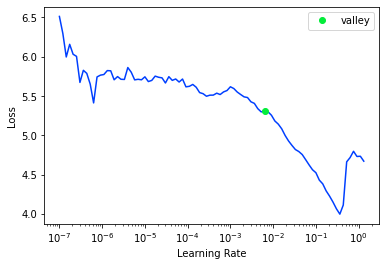

<Figure size 720x720 with 0 Axes>

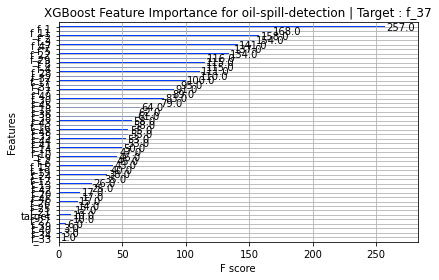

Target Variable: f_36
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:06,  6.37it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8329273895678216, 'Adjusted R-Squared': 0.7731714924059476, 'RMSE': 2268.0139346566875, 'Time taken': 0.15938472747802734}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9794069966021802, 'Adjusted R-Squared': 0.9720416158248578, 'RMSE': 796.2563979880466, 'Time taken': 0.15395116806030273}
{'Model': 'BayesianRidge', 'R-Squared': 0.9983889261424873, 'Adjusted R-Squared': 0.9978127026460046, 'RMSE': 222.715690564883, 'Time taken': 0.0349123477935791}


 10%|▉         | 4/42 [00:00<00:03, 10.75it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.10331091964427808, 'Adjusted R-Squared': -0.49792577411558914, 'RMSE': 5828.302006423043, 'Time taken': 0.07331705093383789}
{'Model': 'DummyRegressor', 'R-Squared': -0.015325609625512104, 'Adjusted R-Squared': -0.37847126562295785, 'RMSE': 5591.080685489859, 'Time taken': 0.02571558952331543}
{'Model': 'ElasticNet', 'R-Squared': 0.9338247325559529, 'Adjusted R-Squared': 0.9101562062438484, 'RMSE': 1427.3843866727875, 'Time taken': 0.022621631622314453}


 17%|█▋        | 7/42 [00:00<00:02, 12.16it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.6645920148911215, 'Adjusted R-Squared': 0.5446285749616686, 'RMSE': 3213.5109805284415, 'Time taken': 0.16805481910705566}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8163373683370436, 'Adjusted R-Squared': 0.7506478139466431, 'RMSE': 2377.9542279363636, 'Time taken': 0.04485964775085449}


 26%|██▌       | 11/42 [00:01<00:04,  6.60it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9697373923059251, 'Adjusted R-Squared': 0.9589135399189933, 'RMSE': 965.2643424759951, 'Time taken': 0.6814310550689697}
{'Model': 'GammaRegressor', 'R-Squared': 0.6731139915946696, 'Adjusted R-Squared': 0.5561985579314492, 'RMSE': 3172.4242092184395, 'Time taken': 0.03005194664001465}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.24780333235348628, 'Adjusted R-Squared': -0.6940979548740762, 'RMSE': 6198.2081953907755, 'Time taken': 0.14906835556030273}


 29%|██▊       | 12/42 [00:02<00:07,  3.84it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9421106962869481, 'Adjusted R-Squared': 0.9214057628421339, 'RMSE': 1335.0337728413942, 'Time taken': 0.7084026336669922}


 33%|███▎      | 14/42 [00:02<00:07,  3.62it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.7990965380489186, 'Adjusted R-Squared': 0.7272405553072909, 'RMSE': 2487.063074927339, 'Time taken': 0.5288114547729492}
{'Model': 'HuberRegressor', 'R-Squared': 0.9971589642936765, 'Adjusted R-Squared': 0.9961428274352103, 'RMSE': 295.7545504571699, 'Time taken': 0.13672685623168945}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.6729563724979193, 'Adjusted R-Squared': 0.5559845641212627, 'RMSE': 3173.1889626231477, 'Time taken': 0.030784130096435547}


 38%|███▊      | 16/42 [00:03<00:04,  5.33it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.8298157443643406, 'Adjusted R-Squared': 0.7689469230056011, 'RMSE': 2289.03682305321, 'Time taken': 0.07758402824401855}
{'Model': 'Lars', 'R-Squared': -0.0015836509048605674, 'Adjusted R-Squared': -0.35981429976864265, 'RMSE': 5553.115452337324, 'Time taken': 0.09361863136291504}


 43%|████▎     | 18/42 [00:03<00:04,  5.26it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9983865968923908, 'Adjusted R-Squared': 0.9978095403064576, 'RMSE': 222.8766307893167, 'Time taken': 0.2924182415008545}
{'Model': 'Lasso', 'R-Squared': 0.9982517512796981, 'Adjusted R-Squared': 0.99762646524105, 'RMSE': 232.00358663946983, 'Time taken': 0.06234550476074219}


 48%|████▊     | 20/42 [00:03<00:03,  5.62it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9982749686085955, 'Adjusted R-Squared': 0.9976579865780932, 'RMSE': 230.45789497040354, 'Time taken': 0.23699569702148438}
{'Model': 'LassoLars', 'R-Squared': 0.9983690554359215, 'Adjusted R-Squared': 0.9977857248984043, 'RMSE': 224.08494987293392, 'Time taken': 0.05307817459106445}


 57%|█████▋    | 24/42 [00:04<00:02,  7.48it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9982779745035242, 'Adjusted R-Squared': 0.9976620675741277, 'RMSE': 230.2570191316565, 'Time taken': 0.24531817436218262}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9983628440956392, 'Adjusted R-Squared': 0.9977772919838606, 'RMSE': 224.51125043998678, 'Time taken': 0.08322620391845703}
{'Model': 'LinearRegression', 'R-Squared': 0.9983819714858413, 'Adjusted R-Squared': 0.9978032605574195, 'RMSE': 223.19588058538147, 'Time taken': 0.02915334701538086}
{'Model': 'LinearSVR', 'R-Squared': -0.09844791001183895, 'Adjusted R-Squared': -0.49132343987008786, 'RMSE': 5815.443260568212, 'Time taken': 0.02687692642211914}


 64%|██████▍   | 27/42 [00:05<00:04,  3.33it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.09758886499422792, 'Adjusted R-Squared': -0.22517132197863932, 'RMSE': 5271.027865391426, 'Time taken': 1.5683531761169434}
{'Model': 'NuSVR', 'R-Squared': -0.07293857697651984, 'Adjusted R-Squared': -0.45669033078564003, 'RMSE': 5747.520375803791, 'Time taken': 0.10776352882385254}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9970568613360243, 'Adjusted R-Squared': 0.9960042059014637, 'RMSE': 301.0221486911829, 'Time taken': 0.019362926483154297}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9964173875695326, 'Adjusted R-Squared': 0.9951360152403873, 'RMSE': 332.1184509077177, 'Time taken': 0.042525291442871094}


 71%|███████▏  | 30/42 [00:06<00:02,  5.27it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9975333280981709, 'Adjusted R-Squared': 0.9966510877829181, 'RMSE': 275.58068971660146, 'Time taken': 0.07763314247131348}
{'Model': 'PoissonRegressor', 'R-Squared': -111.01944052368536, 'Adjusted R-Squared': -151.08478786427355, 'RMSE': 58727.26680087191, 'Time taken': 0.08469676971435547}


 76%|███████▌  | 32/42 [00:24<00:28,  2.85s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.08955835042242222, 'Adjusted R-Squared': -0.47925440276328835, 'RMSE': 5791.863740952267, 'Time taken': 18.327926874160767}


 79%|███████▊  | 33/42 [00:24<00:21,  2.40s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.9976611344830615, 'Adjusted R-Squared': 0.9968246059405068, 'RMSE': 268.34636381834457, 'Time taken': 0.2572791576385498}


 88%|████████▊ | 37/42 [00:26<00:06,  1.21s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9180165260242512, 'Adjusted R-Squared': 0.8886939696387645, 'RMSE': 1588.7525037531234, 'Time taken': 1.4397494792938232}
{'Model': 'Ridge', 'R-Squared': 0.9982522582237655, 'Adjusted R-Squared': 0.9976271535008787, 'RMSE': 231.9699468696053, 'Time taken': 0.019275426864624023}
{'Model': 'RidgeCV', 'R-Squared': 0.9983979084239647, 'Adjusted R-Squared': 0.9978248975683024, 'RMSE': 222.09396513249538, 'Time taken': 0.03449082374572754}
{'Model': 'SGDRegressor', 'R-Squared': 0.9962280831901112, 'Adjusted R-Squared': 0.9948790034551875, 'RMSE': 340.7800342649598, 'Time taken': 0.07900094985961914}


 93%|█████████▎| 39/42 [00:26<00:02,  1.16it/s]

{'Model': 'SVR', 'R-Squared': -0.08656068825565821, 'Adjusted R-Squared': -0.4751845840551272, 'RMSE': 5783.890781470623, 'Time taken': 0.08430004119873047}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9983819714858413, 'Adjusted R-Squared': 0.9978032605574195, 'RMSE': 223.19588058538147, 'Time taken': 0.021575450897216797}
{'Model': 'TweedieRegressor', 'R-Squared': 0.8828268319933327, 'Adjusted R-Squared': 0.8409181806624808, 'RMSE': 1899.359509190707, 'Time taken': 0.040151119232177734}


 98%|█████████▊| 41/42 [00:27<00:00,  1.40it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.8356816955859583, 'Adjusted R-Squared': 0.7769109151750967, 'RMSE': 2249.2413645991396, 'Time taken': 0.7137556076049805}


100%|██████████| 42/42 [00:27<00:00,  1.53it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.7342380303939351, 'Adjusted R-Squared': 0.639184479220963, 'RMSE': 2860.4838903202353, 'Time taken': 0.21566271781921387}
Project: oil-spill-detection
oil-spill-detection
Target: f_36
f_36
Target Standard Deviation: 5121.246707589862
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
RidgeCV                                      1.00       1.00   222.09   
BayesianRidge                                1.00       1.00   222.72   
LarsCV                                       1.00       1.00   222.88   
LinearRegression                             1.00       1.00   223.20   
TransformedTargetRegressor                   1.00       1.00   223.20   
LassoLars                                    1.00       1.00   224.08   
LassoLarsIC                                  1.00       1.00   224.51   
LassoLarsCV                                  1.00       1.00   230.

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 6297.1689453125.
Better model found at epoch 1 with _rmse value: 6283.43017578125.
Better model found at epoch 2 with _rmse value: 5958.9130859375.
Better model found at epoch 3 with _rmse value: 5213.86181640625.
No improvement since epoch 3: early stopping


<Figure size 432x288 with 0 Axes>

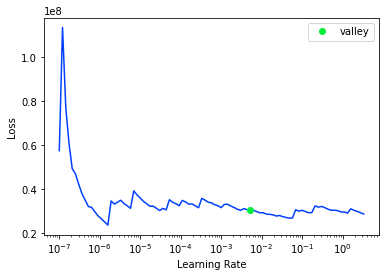

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    2880    2522.71
1    1350    1437.39
2     900     941.86
3     900     938.70
4    4050    3729.44
XGBoost RMSE:  2249.244902270026


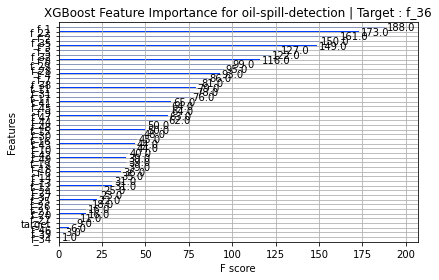

Target Variable: f_35
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:08,  4.83it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9245429594540241, 'Adjusted R-Squared': 0.897554674879186, 'RMSE': 29.2371710273101, 'Time taken': 0.27505040168762207}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8590055141076814, 'Adjusted R-Squared': 0.8085768293724727, 'RMSE': 39.96561757605272, 'Time taken': 0.15832901000976562}


 10%|▉         | 4/42 [00:00<00:04,  7.92it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.9994288925215159, 'Adjusted R-Squared': 0.999224627802934, 'RMSE': 2.5435740629834442, 'Time taken': 0.04491710662841797}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.952172425182351, 'Adjusted R-Squared': 0.9350662122913671, 'RMSE': 23.27687337733741, 'Time taken': 0.11011338233947754}
{'Model': 'DummyRegressor', 'R-Squared': -0.007339433626538661, 'Adjusted R-Squared': -0.3676287201061035, 'RMSE': 106.82511816267464, 'Time taken': 0.012933492660522461}
{'Model': 'ElasticNet', 'R-Squared': 0.9690390075265909, 'Adjusted R-Squared': 0.9579653678828168, 'RMSE': 18.72806470311195, 'Time taken': 0.025486230850219727}


 17%|█▋        | 7/42 [00:00<00:04,  8.53it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9900561067707584, 'Adjusted R-Squared': 0.9864995318201537, 'RMSE': 10.613623811644047, 'Time taken': 0.29163074493408203}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.7114711234270739, 'Adjusted R-Squared': 0.6082746639228886, 'RMSE': 57.1715684173009, 'Time taken': 0.06046032905578613}


 26%|██▌       | 11/42 [00:01<00:05,  5.73it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9923043906454689, 'Adjusted R-Squared': 0.9895519464237753, 'RMSE': 9.336991665894532, 'Time taken': 0.7373511791229248}
{'Model': 'GammaRegressor', 'R-Squared': -5.6001744654510945, 'Adjusted R-Squared': -7.960820807108785, 'RMSE': 273.44070935698215, 'Time taken': 0.029670238494873047}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.1872356338667871, 'Adjusted R-Squared': -0.6118673569286306, 'RMSE': 115.97220799533869, 'Time taken': 0.14741182327270508}


 29%|██▊       | 12/42 [00:02<00:08,  3.58it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8640991932487924, 'Adjusted R-Squared': 0.8154923353596744, 'RMSE': 39.23706208169392, 'Time taken': 0.712212085723877}


 33%|███▎      | 14/42 [00:03<00:08,  3.48it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.8958691481294714, 'Adjusted R-Squared': 0.8586252668035159, 'RMSE': 34.34592164857514, 'Time taken': 0.5246953964233398}
{'Model': 'HuberRegressor', 'R-Squared': 0.9993302148412493, 'Adjusted R-Squared': 0.9990906566457837, 'RMSE': 2.754566264197917, 'Time taken': 0.1389021873474121}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.80257803917165, 'Adjusted R-Squared': 0.7319672648607805, 'RMSE': 47.291511488041166, 'Time taken': 0.033286094665527344}


 38%|███▊      | 16/42 [00:03<00:05,  5.16it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.8491812661169231, 'Adjusted R-Squared': 0.7952387992536329, 'RMSE': 41.33454006260288, 'Time taken': 0.07475757598876953}
{'Model': 'Lars', 'R-Squared': 0.8333285945061395, 'Adjusted R-Squared': 0.7737161940010361, 'RMSE': 43.45262455020143, 'Time taken': 0.056554555892944336}


 43%|████▎     | 18/42 [00:03<00:03,  6.11it/s]

{'Model': 'LarsCV', 'R-Squared': 0.998834959680279, 'Adjusted R-Squared': 0.9984182664272402, 'RMSE': 3.632920900349294, 'Time taken': 0.1635913848876953}
{'Model': 'Lasso', 'R-Squared': 0.99882942543615, 'Adjusted R-Squared': 0.9984107527819264, 'RMSE': 3.6415393364726154, 'Time taken': 0.03242611885070801}


 48%|████▊     | 20/42 [00:03<00:03,  6.76it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9990197076202532, 'Adjusted R-Squared': 0.9986690920975699, 'RMSE': 3.332447203655098, 'Time taken': 0.20056676864624023}
{'Model': 'LassoLars', 'R-Squared': 0.9066359451800932, 'Adjusted R-Squared': 0.8732429620693236, 'RMSE': 32.52185556383492, 'Time taken': 0.027569055557250977}


 57%|█████▋    | 24/42 [00:04<00:02,  8.19it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.998834959680279, 'Adjusted R-Squared': 0.9984182664272402, 'RMSE': 3.632920900349294, 'Time taken': 0.2283027172088623}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9994410697154787, 'Adjusted R-Squared': 0.9992411603436426, 'RMSE': 2.5163108199019777, 'Time taken': 0.08820414543151855}
{'Model': 'LinearRegression', 'R-Squared': 0.9994312636953533, 'Adjusted R-Squared': 0.9992278470608447, 'RMSE': 2.5382882544422554, 'Time taken': 0.06370306015014648}


 60%|█████▉    | 25/42 [00:04<00:02,  8.43it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.9959450664803889, 'Adjusted R-Squared': 0.994494761790893, 'RMSE': 6.7776218377616635, 'Time taken': 0.09492754936218262}


 64%|██████▍   | 27/42 [00:06<00:05,  2.87it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9563493650220596, 'Adjusted R-Squared': 0.9407370941175408, 'RMSE': 22.237233023997046, 'Time taken': 1.5507488250732422}
{'Model': 'NuSVR', 'R-Squared': 0.015095996049883986, 'Adjusted R-Squared': -0.33716893966950057, 'RMSE': 105.62881695746931, 'Time taken': 0.1072542667388916}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9991615795649827, 'Adjusted R-Squared': 0.9988617065626773, 'RMSE': 3.0818847347625873, 'Time taken': 0.019751548767089844}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.999162558807882, 'Adjusted R-Squared': 0.9988630360457376, 'RMSE': 3.080084447380755, 'Time taken': 0.04366040229797363}


 71%|███████▏  | 30/42 [00:06<00:02,  5.11it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9983075692986086, 'Adjusted R-Squared': 0.9977022473689139, 'RMSE': 4.378656853325273, 'Time taken': 0.05181431770324707}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8225575453626806, 'Adjusted R-Squared': 0.7590927258208656, 'RMSE': 44.83469632489308, 'Time taken': 0.08807682991027832}


 76%|███████▌  | 32/42 [00:18<00:21,  2.19s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.07112261013654675, 'Adjusted R-Squared': -0.4542248575576473, 'RMSE': 110.15521377702382, 'Time taken': 12.717445135116577}


 79%|███████▊  | 33/42 [00:19<00:16,  1.85s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.9966773677325548, 'Adjusted R-Squared': 0.9954889810091619, 'RMSE': 6.135170032033254, 'Time taken': 0.34050631523132324}


 81%|████████  | 34/42 [00:20<00:14,  1.77s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9250324452571739, 'Adjusted R-Squared': 0.898219232246966, 'RMSE': 29.142186751565184, 'Time taken': 1.4838192462921143}
{'Model': 'Ridge', 'R-Squared': 0.999245686708187, 'Adjusted R-Squared': 0.9989758958227941, 'RMSE': 2.923218944038172, 'Time taken': 0.020242691040039062}
{'Model': 'RidgeCV', 'R-Squared': 0.9992456867081785, 'Adjusted R-Squared': 0.9989758958227825, 'RMSE': 2.923218944054818, 'Time taken': 0.05003857612609863}


 95%|█████████▌| 40/42 [00:21<00:01,  1.69it/s]

{'Model': 'SGDRegressor', 'R-Squared': 0.9982327022371167, 'Adjusted R-Squared': 0.9976006030372533, 'RMSE': 4.474456889268696, 'Time taken': 0.13460803031921387}
{'Model': 'SVR', 'R-Squared': 0.010447649686624927, 'Adjusted R-Squared': -0.34347983327217335, 'RMSE': 105.87778607475681, 'Time taken': 0.06421875953674316}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9994312636953533, 'Adjusted R-Squared': 0.9992278470608447, 'RMSE': 2.5382882544422554, 'Time taken': 0.02188730239868164}
{'Model': 'TweedieRegressor', 'R-Squared': 0.947778340183171, 'Adjusted R-Squared': 0.9291005202486847, 'RMSE': 24.322644930981436, 'Time taken': 0.03596687316894531}
{'Model': 'XGBRegressor', 'R-Squared': 0.8770484479129039, 'Adjusted R-Squared': 0.8330730752686141, 'RMSE': 37.32093, 'Time taken': 0.7261626720428467}


100%|██████████| 42/42 [00:22<00:00,  1.90it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.8668553126103258, 'Adjusted R-Squared': 0.8192342200402963, 'RMSE': 38.83715294736063, 'Time taken': 0.23306059837341309}
Project: oil-spill-detection
oil-spill-detection
Target: f_35
f_35
Target Standard Deviation: 91.98780112360309
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
LassoLarsIC                                  1.00       1.00   2.52   
LinearRegression                             1.00       1.00   2.54   
TransformedTargetRegressor                   1.00       1.00   2.54   
BayesianRidge                                1.00       1.00   2.54   
HuberRegressor                               1.00       1.00   2.75   
Ridge                                        1.00       1.00   2.92   
RidgeCV                                      1.00       1.00   2.92   
OrthogonalMatchingPursuitCV                  1.00       1.00   3.08   
OrthogonalMatc

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 115.53837585449219.
Better model found at epoch 1 with _rmse value: 87.88713836669922.
No improvement since epoch 1: early stopping


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0      32      28.73
1      25      25.49
2      14      14.33
3      74      68.48
4      29      28.08
XGBoost RMSE:  34.032192


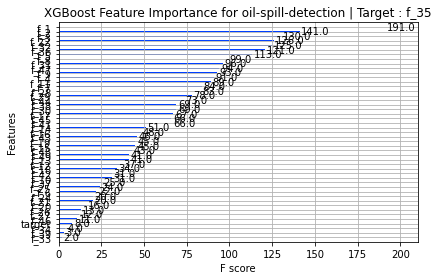

Target Variable: f_34
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
50
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'ta

  7%|▋         | 3/42 [00:00<00:03, 12.21it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9890728444288819, 'Adjusted R-Squared': 0.9851645917063652, 'RMSE': 1.075526827629774, 'Time taken': 0.11853146553039551}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9979465526407351, 'Adjusted R-Squared': 0.9972121079647935, 'RMSE': 0.4662399373116647, 'Time taken': 0.09517192840576172}
{'Model': 'BayesianRidge', 'R-Squared': 0.9980376921950311, 'Adjusted R-Squared': 0.9973358448779255, 'RMSE': 0.4557757876674387, 'Time taken': 0.04170727729797363}


 12%|█▏        | 5/42 [00:00<00:02, 14.31it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9960598058051006, 'Adjusted R-Squared': 0.9946505392682388, 'RMSE': 0.6458423178030692, 'Time taken': 0.09742021560668945}
{'Model': 'DummyRegressor', 'R-Squared': -0.0004162310764186383, 'Adjusted R-Squared': -0.358229335621999, 'RMSE': 10.291011162884086, 'Time taken': 0.014541864395141602}
{'Model': 'ElasticNet', 'R-Squared': 0.8234877910602855, 'Adjusted R-Squared': 0.7603556871329423, 'RMSE': 4.322699637084579, 'Time taken': 0.020362377166748047}


 17%|█▋        | 7/42 [00:00<00:03,  9.35it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9913422218887783, 'Adjusted R-Squared': 0.9882456443161516, 'RMSE': 0.9573503717065001, 'Time taken': 0.29004502296447754}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8574457946409468, 'Adjusted R-Squared': 0.8064592540380738, 'RMSE': 3.884701930767545, 'Time taken': 0.05134868621826172}


 21%|██▏       | 9/42 [00:01<00:04,  7.33it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9286213868046446, 'Adjusted R-Squared': 0.9030918098223641, 'RMSE': 2.7488544040671483, 'Time taken': 0.3162813186645508}
{'Model': 'GammaRegressor', 'R-Squared': 0.8061606521465567, 'Adjusted R-Squared': 0.7368312503595589, 'RMSE': 4.529900415504515, 'Time taken': 0.03401446342468262}


 26%|██▌       | 11/42 [00:01<00:03,  7.89it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.5699287885655786, 'Adjusted R-Squared': -2.489100399074435, 'RMSE': 16.494085040379783, 'Time taken': 0.18114614486694336}


 29%|██▊       | 12/42 [00:01<00:07,  4.12it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9989867057293897, 'Adjusted R-Squared': 0.9986242866107043, 'RMSE': 0.327518229939261, 'Time taken': 0.7021372318267822}


 33%|███▎      | 14/42 [00:02<00:07,  3.75it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9975971068789694, 'Adjusted R-Squared': 0.9967376779524694, 'RMSE': 0.5043533522023437, 'Time taken': 0.5100851058959961}
{'Model': 'HuberRegressor', 'R-Squared': 0.9977760251845582, 'Adjusted R-Squared': 0.9969805889366995, 'RMSE': 0.4852132111692987, 'Time taken': 0.15087032318115234}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7186964024454813, 'Adjusted R-Squared': 0.6180841668237922, 'RMSE': 5.4570172652425315, 'Time taken': 0.03104996681213379}


 38%|███▊      | 16/42 [00:02<00:04,  5.55it/s]

{'Model': 'KernelRidge', 'R-Squared': -1.5579936700055876, 'Adjusted R-Squared': -2.4728965154820384, 'RMSE': 16.455740018163656, 'Time taken': 0.07485747337341309}
{'Model': 'Lars', 'R-Squared': 0.986567408458296, 'Adjusted R-Squared': 0.9817630508995844, 'RMSE': 1.192470349257293, 'Time taken': 0.0911099910736084}


 43%|████▎     | 18/42 [00:03<00:03,  6.27it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9978635225281941, 'Adjusted R-Squared': 0.9970993809506868, 'RMSE': 0.47557262040874926, 'Time taken': 0.15328764915466309}
{'Model': 'Lasso', 'R-Squared': 0.9877958138445672, 'Adjusted R-Squared': 0.9834308129568576, 'RMSE': 1.1366378041216534, 'Time taken': 0.04074215888977051}


 48%|████▊     | 20/42 [00:03<00:03,  6.51it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9978758792980728, 'Adjusted R-Squared': 0.9971161572951937, 'RMSE': 0.47419533859193946, 'Time taken': 0.2388453483581543}
{'Model': 'LassoLars', 'R-Squared': -0.0004162310764186383, 'Adjusted R-Squared': -0.358229335621999, 'RMSE': 10.291011162884086, 'Time taken': 0.05358624458312988}


 57%|█████▋    | 24/42 [00:03<00:02,  8.22it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9978635225281941, 'Adjusted R-Squared': 0.9970993809506868, 'RMSE': 0.47557262040874926, 'Time taken': 0.20770859718322754}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9981848985481903, 'Adjusted R-Squared': 0.9975357016785649, 'RMSE': 0.4383470990219871, 'Time taken': 0.07855558395385742}
{'Model': 'LinearRegression', 'R-Squared': 0.9980456680260077, 'Adjusted R-Squared': 0.9973466733783755, 'RMSE': 0.45484859062303373, 'Time taken': 0.056917428970336914}
{'Model': 'LinearSVR', 'R-Squared': 0.9977273022066837, 'Adjusted R-Squared': 0.9969144394922859, 'RMSE': 0.4904994557151497, 'Time taken': 0.21659445762634277}


 64%|██████▍   | 27/42 [00:05<00:04,  3.12it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.8854300527034806, 'Adjusted R-Squared': 0.8444524803127548, 'RMSE': 3.4825955545722502, 'Time taken': 1.5647735595703125}
{'Model': 'NuSVR', 'R-Squared': 0.7700336779947912, 'Adjusted R-Squared': 0.6877829496863588, 'RMSE': 4.934007488873947, 'Time taken': 0.12484431266784668}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9979255082750627, 'Adjusted R-Squared': 0.9971835367822018, 'RMSE': 0.46862293322444204, 'Time taken': 0.027283430099487305}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9977955272892323, 'Adjusted R-Squared': 0.9970070662466949, 'RMSE': 0.48308110183604797, 'Time taken': 0.0433497428894043}


 71%|███████▏  | 30/42 [00:05<00:02,  5.12it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9961089094926285, 'Adjusted R-Squared': 0.9947172055885322, 'RMSE': 0.6418053766172238, 'Time taken': 0.03356480598449707}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9501836469890172, 'Adjusted R-Squared': 0.9323661192697607, 'RMSE': 2.2964323162174365, 'Time taken': 0.08861780166625977}


 76%|███████▌  | 32/42 [00:17<00:18,  1.85s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.04925350797623884, 'Adjusted R-Squared': -0.4245339597341635, 'RMSE': 10.539206151793994, 'Time taken': 11.54395842552185}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9980456680260077, 'Adjusted R-Squared': 0.9973466733783755, 'RMSE': 0.4548485906230359, 'Time taken': 0.07685041427612305}


 88%|████████▊ | 37/42 [00:18<00:04,  1.10it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9981752000892528, 'Adjusted R-Squared': 0.9975225344277446, 'RMSE': 0.43951662802465213, 'Time taken': 0.8852529525756836}
{'Model': 'Ridge', 'R-Squared': 0.997423078543483, 'Adjusted R-Squared': 0.9965014059057506, 'RMSE': 0.5222978949600149, 'Time taken': 0.026124238967895508}
{'Model': 'RidgeCV', 'R-Squared': 0.9980078245117924, 'Adjusted R-Squared': 0.9972952945926524, 'RMSE': 0.45923130000545176, 'Time taken': 0.055370330810546875}
{'Model': 'SGDRegressor', 'R-Squared': 0.9953825614133909, 'Adjusted R-Squared': 0.9937310687802241, 'RMSE': 0.6991465977866536, 'Time taken': 0.10673809051513672}


 95%|█████████▌| 40/42 [00:18<00:01,  1.66it/s]

{'Model': 'SVR', 'R-Squared': 0.7803557730907814, 'Adjusted R-Squared': 0.7017968890137616, 'RMSE': 4.822004164080527, 'Time taken': 0.06602001190185547}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9980456680260077, 'Adjusted R-Squared': 0.9973466733783755, 'RMSE': 0.45484859062303373, 'Time taken': 0.021679162979125977}
{'Model': 'TweedieRegressor', 'R-Squared': 0.7843265454481747, 'Adjusted R-Squared': 0.7071878646230694, 'RMSE': 4.778218792471449, 'Time taken': 0.05360555648803711}
{'Model': 'XGBRegressor', 'R-Squared': 0.9997430443209708, 'Adjusted R-Squared': 0.9996511404649677, 'RMSE': 0.16492891, 'Time taken': 0.7432088851928711}


100%|██████████| 42/42 [00:19<00:00,  2.14it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.997483672742086, 'Adjusted R-Squared': 0.9965836724819562, 'RMSE': 0.5161206620750243, 'Time taken': 0.24169206619262695}
Project: oil-spill-detection
oil-spill-detection
Target: f_34
f_34
Target Standard Deviation: 10.514971337204026
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
XGBRegressor                                 1.00       1.00  0.16        0.74
GradientBoostingRegressor                    1.00       1.00  0.33        0.70
LassoLarsIC                                  1.00       1.00  0.44        0.08
RandomForestRegressor                        1.00       1.00  0.44        0.89
LinearRegression                             1.00       1.00  0.45        0.06
TransformedTargetRegressor                   1.00       1.00  0.45        0.02
RANSACRegressor                              1.00       1.00  0.45        0.08
BayesianRidg

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 16.996171951293945.
Better model found at epoch 1 with _rmse value: 8.922234535217285.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0      10       9.94
1       9       9.00
2      23      22.98
3      22      22.01
4      21      21.00
XGBoost RMSE:  0.1649289


<Figure size 432x288 with 0 Axes>

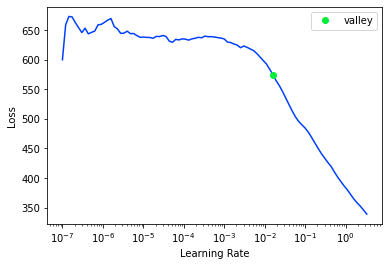

<Figure size 720x720 with 0 Axes>

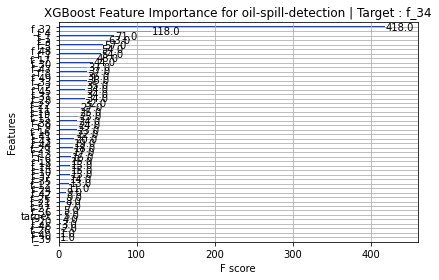

Target Variable: f_33
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
50
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'ta

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -1.0216216216216218, 'Adjusted R-Squared': -1.7446833695008879, 'RMSE': 0.14625448482542613, 'Time taken': 0.024369478225708008}


 10%|▉         | 4/42 [00:00<00:01, 31.87it/s]

{'Model': 'BaggingRegressor', 'R-Squared': -1.153027027027027, 'Adjusted R-Squared': -1.9230877885184454, 'RMSE': 0.15093292769671435, 'Time taken': 0.044875144958496094}
{'Model': 'BayesianRidge', 'R-Squared': -1.792362425273705, 'Adjusted R-Squared': -2.7910905919774387, 'RMSE': 0.17188783765184804, 'Time taken': 0.026322603225708008}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -1.5270270270270272, 'Adjusted R-Squared': -2.4308542118761096, 'RMSE': 0.16351748504193214, 'Time taken': 0.029256343841552734}
{'Model': 'DummyRegressor', 'R-Squared': -0.0168738786786784, 'Adjusted R-Squared': -0.3805732951403953, 'RMSE': 0.1037272349728073, 'Time taken': 0.04644465446472168}
{'Model': 'ElasticNet', 'R-Squared': -0.0168738786786784, 'Adjusted R-Squared': -0.3805732951403953, 'RMSE': 0.1037272349728073, 'Time taken': 0.026784658432006836}


 19%|█▉        | 8/42 [00:01<00:06,  4.89it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -0.0168738786786784, 'Adjusted R-Squared': -0.3805732951403953, 'RMSE': 0.1037272349728073, 'Time taken': 1.20607590675354}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.010810810810810922, 'Adjusted R-Squared': -0.37234168475044394, 'RMSE': 0.10341753799900383, 'Time taken': 0.02126789093017578}


 24%|██▍       | 10/42 [00:01<00:05,  5.66it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.5206132432432433, 'Adjusted R-Squared': -1.0644822134543301, 'RMSE': 0.12684362346146622, 'Time taken': 0.19369745254516602}
{'Model': 'GammaRegressor', 'R-Squared': -0.06329963464076949, 'Adjusted R-Squared': -0.44360388352688407, 'RMSE': 0.10606866134801682, 'Time taken': 0.02583789825439453}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -51.51472819486143, 'Adjusted R-Squared': -70.29736820616223, 'RMSE': 0.7454178984251681, 'Time taken': 0.1846909523010254}


 29%|██▊       | 12/42 [00:02<00:06,  4.92it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': -2.2426386513269114, 'Adjusted R-Squared': -3.4024145193197484, 'RMSE': 0.18522880846957565, 'Time taken': 0.3444809913635254}


 33%|███▎      | 14/42 [00:02<00:06,  4.25it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.022386594668118542, 'Adjusted R-Squared': -0.38805771246912424, 'RMSE': 0.10400801998500762, 'Time taken': 0.5087113380432129}
{'Model': 'HuberRegressor', 'R-Squared': -0.013923045539428136, 'Adjusted R-Squared': -0.37656705452798267, 'RMSE': 0.10357662429051814, 'Time taken': 0.1476900577545166}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.010810810810810922, 'Adjusted R-Squared': -0.37234168475044394, 'RMSE': 0.10341753799900383, 'Time taken': 0.03336524963378906}


 38%|███▊      | 16/42 [00:02<00:04,  5.88it/s]

{'Model': 'KernelRidge', 'R-Squared': -92.43146939553506, 'Adjusted R-Squared': -125.84856428882861, 'RMSE': 0.9942734554462848, 'Time taken': 0.07466363906860352}
{'Model': 'Lars', 'R-Squared': -383.6412287907663, 'Adjusted R-Squared': -521.2136390881936, 'RMSE': 2.017377497244108, 'Time taken': 0.09329581260681152}


 43%|████▎     | 18/42 [00:03<00:03,  6.61it/s]

{'Model': 'LarsCV', 'R-Squared': -0.0168738786786784, 'Adjusted R-Squared': -0.3805732951403953, 'RMSE': 0.1037272349728073, 'Time taken': 0.13356876373291016}
{'Model': 'Lasso', 'R-Squared': -0.0168738786786784, 'Adjusted R-Squared': -0.3805732951403953, 'RMSE': 0.1037272349728073, 'Time taken': 0.038739919662475586}


 48%|████▊     | 20/42 [00:04<00:06,  3.17it/s]

{'Model': 'LassoCV', 'R-Squared': -0.0168738786786784, 'Adjusted R-Squared': -0.3805732951403953, 'RMSE': 0.1037272349728073, 'Time taken': 1.2612733840942383}
{'Model': 'LassoLars', 'R-Squared': -0.0168738786786784, 'Adjusted R-Squared': -0.3805732951403953, 'RMSE': 0.1037272349728073, 'Time taken': 0.04116320610046387}


 55%|█████▍    | 23/42 [00:04<00:04,  4.30it/s]

{'Model': 'LassoLarsCV', 'R-Squared': -0.0168738786786784, 'Adjusted R-Squared': -0.3805732951403953, 'RMSE': 0.1037272349728073, 'Time taken': 0.25362396240234375}
{'Model': 'LassoLarsIC', 'R-Squared': -1.7710240123611234, 'Adjusted R-Squared': -2.7621201919647365, 'RMSE': 0.1712298199799136, 'Time taken': 0.10080790519714355}
{'Model': 'LinearRegression', 'R-Squared': -1.8869422436997314, 'Adjusted R-Squared': -2.919498228672628, 'RMSE': 0.17477459451651609, 'Time taken': 0.05790591239929199}


 60%|█████▉    | 25/42 [00:05<00:03,  4.96it/s]

{'Model': 'LinearSVR', 'R-Squared': -0.0612493630502724, 'Adjusted R-Squared': -0.44082030311934783, 'RMSE': 0.1059663503487504, 'Time taken': 0.22260332107543945}


 64%|██████▍   | 27/42 [00:05<00:03,  3.93it/s]

{'Model': 'MLPRegressor', 'R-Squared': -1.8560377083387345, 'Adjusted R-Squared': -2.8775402463576976, 'RMSE': 0.1738366019468365, 'Time taken': 0.5850110054016113}
{'Model': 'NuSVR', 'R-Squared': -0.05286846116744992, 'Adjusted R-Squared': -0.42944185238792465, 'RMSE': 0.10554710208452882, 'Time taken': 0.1688542366027832}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.11849481733043032, 'Adjusted R-Squared': -0.5185404089303651, 'RMSE': 0.10878681039877662, 'Time taken': 0.02133464813232422}


 74%|███████▍  | 31/42 [00:06<00:01,  7.67it/s]

OrthogonalMatchingPursuitCV model failed to execute
attempt to get argmin of an empty sequence
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1.1502355222989284, 'Adjusted R-Squared': -1.9192978623912458, 'RMSE': 0.15083505000327796, 'Time taken': 0.03113102912902832}
{'Model': 'PoissonRegressor', 'R-Squared': -0.06518914032527312, 'Adjusted R-Squared': -0.44616919781387443, 'RMSE': 0.10616286263174253, 'Time taken': 0.03313016891479492}


 79%|███████▊  | 33/42 [00:13<00:09,  1.10s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.01081081078736812, 'Adjusted R-Squared': -0.3723416847186165, 'RMSE': 0.10341753799780459, 'Time taken': 6.956632852554321}
{'Model': 'RANSACRegressor', 'R-Squared': -0.010810810810810922, 'Adjusted R-Squared': -0.37234168475044394, 'RMSE': 0.10341753799900383, 'Time taken': 0.08405637741088867}


 88%|████████▊ | 37/42 [00:13<00:02,  1.71it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -1.0956129729729729, 'Adjusted R-Squared': -1.84513878082462, 'RMSE': 0.1489068904788679, 'Time taken': 0.3444530963897705}
{'Model': 'Ridge', 'R-Squared': -0.44614672116862786, 'Adjusted R-Squared': -0.9633816798347792, 'RMSE': 0.12369878506212391, 'Time taken': 0.02019190788269043}
{'Model': 'RidgeCV', 'R-Squared': -1.3158304000833732, 'Adjusted R-Squared': -2.1441201052226817, 'RMSE': 0.15653542287636785, 'Time taken': 0.05328226089477539}
{'Model': 'SGDRegressor', 'R-Squared': -0.1498330419085543, 'Adjusted R-Squared': -0.5610871955838765, 'RMSE': 0.11030028833895772, 'Time taken': 0.06951236724853516}
{'Model': 'SVR', 'R-Squared': -0.5567855385320166, 'Adjusted R-Squared': -1.1135920450142707, 'RMSE': 0.12834343239835394, 'Time taken': 0.0394136905670166}


 95%|█████████▌| 40/42 [00:13<00:00,  2.65it/s]

{'Model': 'TransformedTargetRegressor', 'R-Squared': -1.8869422436997314, 'Adjusted R-Squared': -2.919498228672628, 'RMSE': 0.17477459451651609, 'Time taken': 0.02332139015197754}
{'Model': 'TweedieRegressor', 'R-Squared': -0.06475597109910636, 'Adjusted R-Squared': -0.4455810994484217, 'RMSE': 0.10614127437127628, 'Time taken': 0.03460049629211426}
{'Model': 'XGBRegressor', 'R-Squared': -3.0378803597652677, 'Adjusted R-Squared': -4.4820857439148885, 'RMSE': 0.20669787, 'Time taken': 1.539160966873169}


100%|██████████| 42/42 [00:15<00:00,  2.71it/s]

{'Model': 'LGBMRegressor', 'R-Squared': -0.03691141782501073, 'Adjusted R-Squared': -0.4077775453682626, 'RMSE': 0.10474422405103745, 'Time taken': 0.2284231185913086}
Project: oil-spill-detection
oil-spill-detection
Target: f_33
f_33
Target Standard Deviation: 0.05157087894883658
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
QuantileRegressor                           -0.37      -0.01  0.10        6.96
KNeighborsRegressor                         -0.37      -0.01  0.10        0.03
RANSACRegressor                             -0.37      -0.01  0.10        0.08
ExtraTreeRegressor                          -0.37      -0.01  0.10        0.02
HuberRegressor                              -0.38      -0.01  0.10        0.15
LassoLars                                   -0.38      -0.02  0.10        0.04
DummyRegressor                              -0.38      -0.02  0.10        0.05
Elastic

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 2.0620555877685547.
Better model found at epoch 1 with _rmse value: 1.1179505586624146.
Better model found at epoch 2 with _rmse value: 0.7038203477859497.
Better model found at epoch 3 with _rmse value: 0.48244577646255493.
Better model found at epoch 4 with _rmse value: 0.34284040331840515.
Better model found at epoch 5 with _rmse value: 0.2749095559120178.
No improvement since epoch 5: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  0.20669787


<Figure size 432x288 with 0 Axes>

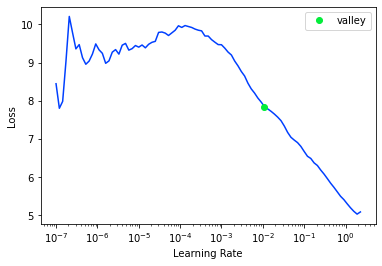

<Figure size 720x720 with 0 Axes>

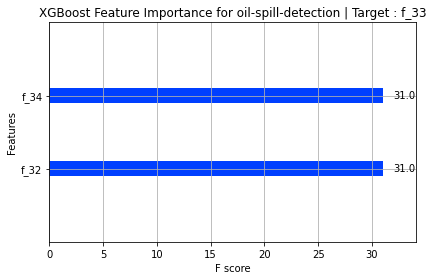

Target Variable: f_32
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
50
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'ta

  7%|▋         | 3/42 [00:00<00:04,  7.87it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9947365531342836, 'Adjusted R-Squared': 0.9928540064450857, 'RMSE': 0.7585701998915138, 'Time taken': 0.3017847537994385}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9990852999815328, 'Adjusted R-Squared': 0.9987581445004753, 'RMSE': 0.31622776601683783, 'Time taken': 0.09758758544921875}
{'Model': 'BayesianRidge', 'R-Squared': 0.9917454312575699, 'Adjusted R-Squared': 0.9887930672548029, 'RMSE': 0.94996553744469, 'Time taken': 0.032820701599121094}


 12%|█▏        | 5/42 [00:00<00:03, 10.78it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.998483652375803, 'Adjusted R-Squared': 0.9979413090649589, 'RMSE': 0.4071552542575359, 'Time taken': 0.08932065963745117}
{'Model': 'DummyRegressor', 'R-Squared': -0.0037499512454115536, 'Adjusted R-Squared': -0.3627554082601936, 'RMSE': 10.475467762186149, 'Time taken': 0.02950739860534668}
{'Model': 'ElasticNet', 'R-Squared': 0.9055700449213274, 'Adjusted R-Squared': 0.8717958274114372, 'RMSE': 3.2130356748335394, 'Time taken': 0.019603252410888672}


 17%|█▋        | 7/42 [00:00<00:03,  8.90it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9935683550715324, 'Adjusted R-Squared': 0.9912679857175549, 'RMSE': 0.8385359493701177, 'Time taken': 0.25462985038757324}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9475148064269912, 'Adjusted R-Squared': 0.9287427298935792, 'RMSE': 2.3954055845385565, 'Time taken': 0.02986907958984375}


 26%|██▌       | 11/42 [00:01<00:03,  7.94it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9820377471421673, 'Adjusted R-Squared': 0.9756132917404607, 'RMSE': 1.4013320630036759, 'Time taken': 0.35454750061035156}
{'Model': 'GammaRegressor', 'R-Squared': 0.8470976627905317, 'Adjusted R-Squared': 0.7924099655404299, 'RMSE': 4.088534982550531, 'Time taken': 0.028641939163208008}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.0716840807189074, 'Adjusted R-Squared': -1.812651379662166, 'RMSE': 15.049512100496713, 'Time taken': 0.15609979629516602}


 29%|██▊       | 12/42 [00:02<00:07,  4.05it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9996774987033245, 'Adjusted R-Squared': 0.9995621515242216, 'RMSE': 0.18777007884804317, 'Time taken': 0.7301819324493408}


 33%|███▎      | 14/42 [00:02<00:07,  3.75it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9982730673246069, 'Adjusted R-Squared': 0.9976554052728239, 'RMSE': 0.43450858287954985, 'Time taken': 0.517157793045044}
{'Model': 'HuberRegressor', 'R-Squared': 0.9928443895909688, 'Adjusted R-Squared': 0.9902850836782495, 'RMSE': 0.8844718182906848, 'Time taken': 0.1350860595703125}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8796098249490845, 'Adjusted R-Squared': 0.836550565259341, 'RMSE': 3.6279072796788125, 'Time taken': 0.03383803367614746}


 38%|███▊      | 16/42 [00:02<00:04,  5.53it/s]

{'Model': 'KernelRidge', 'R-Squared': -0.6934597934507349, 'Adjusted R-Squared': -1.299149792568151, 'RMSE': 13.606552479978006, 'Time taken': 0.0740971565246582}
{'Model': 'Lars', 'R-Squared': 0.8969377083135328, 'Adjusted R-Squared': 0.8600760127468402, 'RMSE': 3.3566847358105822, 'Time taken': 0.09687662124633789}


 43%|████▎     | 18/42 [00:03<00:03,  6.11it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9925453605567014, 'Adjusted R-Squared': 0.9898791026536238, 'RMSE': 0.9027634706739242, 'Time taken': 0.16847634315490723}
{'Model': 'Lasso', 'R-Squared': 0.9896006367334657, 'Adjusted R-Squared': 0.9858811564410556, 'RMSE': 1.0662622424277348, 'Time taken': 0.04293966293334961}


 48%|████▊     | 20/42 [00:03<00:03,  6.34it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9921956000603119, 'Adjusted R-Squared': 0.9894042453373578, 'RMSE': 0.9236988746520202, 'Time taken': 0.24321603775024414}
{'Model': 'LassoLars', 'R-Squared': -0.0037499512454115536, 'Adjusted R-Squared': -0.3627554082601936, 'RMSE': 10.475467762186149, 'Time taken': 0.05600786209106445}


 57%|█████▋    | 24/42 [00:03<00:02,  7.83it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9922365526951036, 'Adjusted R-Squared': 0.9894598452648852, 'RMSE': 0.9212721885573127, 'Time taken': 0.2370741367340088}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9917472515319553, 'Adjusted R-Squared': 0.9887955385762313, 'RMSE': 0.9498607897995498, 'Time taken': 0.0816032886505127}
{'Model': 'LinearRegression', 'R-Squared': 0.9917380283796845, 'Adjusted R-Squared': 0.9887830166322724, 'RMSE': 0.9503914169227552, 'Time taken': 0.05801129341125488}


 60%|█████▉    | 25/42 [00:04<00:02,  6.89it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.993900396957913, 'Adjusted R-Squared': 0.9917187871107432, 'RMSE': 0.816603885932583, 'Time taken': 0.21363568305969238}


 64%|██████▍   | 27/42 [00:05<00:05,  2.64it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.8757686281421486, 'Adjusted R-Squared': 0.8313355097404354, 'RMSE': 3.6853292711283725, 'Time taken': 1.6308507919311523}
{'Model': 'NuSVR', 'R-Squared': 0.8574281587007757, 'Adjusted R-Squared': 0.806435310352878, 'RMSE': 3.9480035574067958, 'Time taken': 0.11195993423461914}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9914233372117272, 'Adjusted R-Squared': 0.9883557716889142, 'RMSE': 0.9683220548756858, 'Time taken': 0.02088189125061035}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9915894634409793, 'Adjusted R-Squared': 0.9885813153286288, 'RMSE': 0.958898209185223, 'Time taken': 0.04422569274902344}


 71%|███████▏  | 30/42 [00:05<00:02,  4.82it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9934817439502437, 'Adjusted R-Squared': 0.9911503968959513, 'RMSE': 0.8441630997831198, 'Time taken': 0.03503727912902832}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9672093093852231, 'Adjusted R-Squared': 0.9554812521580401, 'RMSE': 1.8933719457906812, 'Time taken': 0.06580424308776855}


 76%|███████▌  | 32/42 [00:17<00:19,  1.97s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.154282943319479, 'Adjusted R-Squared': -0.5671286675724312, 'RMSE': 11.233544115462491, 'Time taken': 11.331931114196777}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9917380283796845, 'Adjusted R-Squared': 0.9887830166322724, 'RMSE': 0.9503914169227556, 'Time taken': 0.08043861389160156}


 88%|████████▊ | 37/42 [00:18<00:04,  1.09it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9991193199741983, 'Adjusted R-Squared': 0.9988043322277438, 'RMSE': 0.3102913931502155, 'Time taken': 0.8900694847106934}
{'Model': 'Ridge', 'R-Squared': 0.9923439823460752, 'Adjusted R-Squared': 0.989605698659635, 'RMSE': 0.9148757562817286, 'Time taken': 0.02183818817138672}
{'Model': 'RidgeCV', 'R-Squared': 0.9918027033757866, 'Adjusted R-Squared': 0.9888708235612869, 'RMSE': 0.9466642602744384, 'Time taken': 0.03813600540161133}
{'Model': 'SGDRegressor', 'R-Squared': 0.9934587903911914, 'Adjusted R-Squared': 0.9911192336697928, 'RMSE': 0.8456481227025895, 'Time taken': 0.05849623680114746}


 93%|█████████▎| 39/42 [00:18<00:02,  1.47it/s]

{'Model': 'SVR', 'R-Squared': 0.8632295711819183, 'Adjusted R-Squared': 0.8143116805827505, 'RMSE': 3.866844967532037, 'Time taken': 0.10874676704406738}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9917380283796845, 'Adjusted R-Squared': 0.9887830166322724, 'RMSE': 0.9503914169227552, 'Time taken': 0.02258467674255371}
{'Model': 'TweedieRegressor', 'R-Squared': 0.890282604380216, 'Adjusted R-Squared': 0.8510406161658407, 'RMSE': 3.4633660956412697, 'Time taken': 0.03489112854003906}


 98%|█████████▊| 41/42 [00:19<00:00,  1.67it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9989217258423368, 'Adjusted R-Squared': 0.9985360657421508, 'RMSE': 0.3433407, 'Time taken': 0.738856315612793}


100%|██████████| 42/42 [00:19<00:00,  2.14it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9981063351341305, 'Adjusted R-Squared': 0.9974290389412283, 'RMSE': 0.455000859301847, 'Time taken': 0.22736620903015137}
Project: oil-spill-detection
oil-spill-detection
Target: f_32
f_32
Target Standard Deviation: 10.472227821984944
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GradientBoostingRegressor                    1.00       1.00  0.19        0.73
RandomForestRegressor                        1.00       1.00  0.31        0.89
BaggingRegressor                             1.00       1.00  0.32        0.10
XGBRegressor                                 1.00       1.00  0.34        0.74
DecisionTreeRegressor                        1.00       1.00  0.41        0.09
HistGradientBoostingRegressor                1.00       1.00  0.43        0.52
LGBMRegressor                                1.00       1.00  0.46        0.23
AdaBoostRegr

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 15.048322677612305.
Better model found at epoch 1 with _rmse value: 10.073925018310547.
Better model found at epoch 2 with _rmse value: 9.519972801208496.
No improvement since epoch 2: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0      29      30.35
1       2       2.00
2      10      10.00
3       3       3.00
4       5       5.02
XGBoost RMSE:  0.34334207


<Figure size 432x288 with 0 Axes>

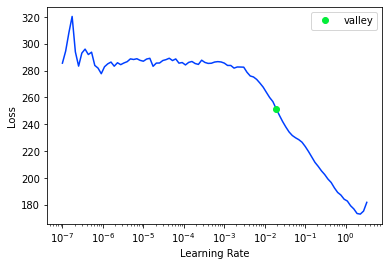

<Figure size 720x720 with 0 Axes>

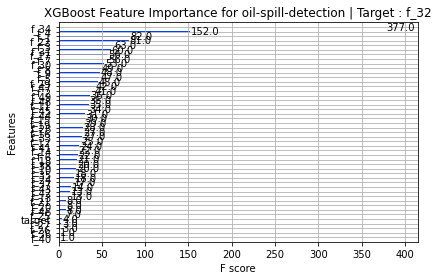

Target Variable: f_31
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:09,  4.43it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5638298227353162, 'Adjusted R-Squared': 0.4078273505749549, 'RMSE': 0.12648810038403333, 'Time taken': 0.31119203567504883}
{'Model': 'BaggingRegressor', 'R-Squared': 0.6479745485294615, 'Adjusted R-Squared': 0.5220676352297798, 'RMSE': 0.11363411096232634, 'Time taken': 0.16402196884155273}


 10%|▉         | 4/42 [00:00<00:05,  7.36it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.4138961398183101, 'Adjusted R-Squared': 0.20426775187011448, 'RMSE': 0.14662532147360852, 'Time taken': 0.053566932678222656}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.2686075416601402, 'Adjusted R-Squared': 0.0070146186042781, 'RMSE': 0.1637935988865661, 'Time taken': 0.11026668548583984}
{'Model': 'DummyRegressor', 'R-Squared': -0.012370644435689693, 'Adjusted R-Squared': -0.3744594150732721, 'RMSE': 0.19270432, 'Time taken': 0.014073610305786133}
{'Model': 'ElasticNet', 'R-Squared': -0.012370572995802798, 'Adjusted R-Squared': -0.3744593180818927, 'RMSE': 0.19270431653518197, 'Time taken': 0.028977155685424805}


 17%|█▋        | 7/42 [00:01<00:08,  4.12it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.4189953710195091, 'Adjusted R-Squared': 0.21119079569072052, 'RMSE': 0.1459860919658699, 'Time taken': 0.9205870628356934}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.46673037768911907, 'Adjusted R-Squared': 0.27599890693559237, 'RMSE': 0.13986051041631067, 'Time taken': 0.042970895767211914}


 26%|██▌       | 11/42 [00:02<00:07,  4.38it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.7059907376511572, 'Adjusted R-Squared': 0.6008341401687243, 'RMSE': 0.10384896981455195, 'Time taken': 0.7975647449493408}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.9478518279184383, 'Adjusted R-Squared': -3.00219299264839, 'RMSE': 0.3288323313465644, 'Time taken': 0.13576745986938477}


 29%|██▊       | 12/42 [00:03<00:09,  3.06it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.7167027219546087, 'Adjusted R-Squared': 0.6153774181281549, 'RMSE': 0.10193959112861592, 'Time taken': 0.733900785446167}


 33%|███▎      | 14/42 [00:03<00:08,  3.19it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.6923039611383004, 'Adjusted R-Squared': 0.5822520932242619, 'RMSE': 0.10623867342408638, 'Time taken': 0.5146229267120361}
{'Model': 'HuberRegressor', 'R-Squared': 0.40444725272866255, 'Adjusted R-Squared': 0.19143933582139594, 'RMSE': 0.14780250770902237, 'Time taken': 0.13583946228027344}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.4478231118340493, 'Adjusted R-Squared': 0.2503291883294393, 'RMSE': 0.14231831, 'Time taken': 0.0328679084777832}


 38%|███▊      | 16/42 [00:04<00:05,  4.75it/s]

{'Model': 'KernelRidge', 'R-Squared': -4.6783836212063274, 'Adjusted R-Squared': -6.709338347039247, 'RMSE': 0.4563878258637452, 'Time taken': 0.07875227928161621}
{'Model': 'Lars', 'R-Squared': -3615230.8961865855, 'Adjusted R-Squared': -4908270.041537992, 'RMSE': 364.15792558740986, 'Time taken': 0.09473371505737305}


 43%|████▎     | 18/42 [00:04<00:04,  4.96it/s]

{'Model': 'LarsCV', 'R-Squared': 0.19390658841697883, 'Adjusted R-Squared': -0.09440419382804333, 'RMSE': 0.1719548272665975, 'Time taken': 0.2753729820251465}
{'Model': 'Lasso', 'R-Squared': -0.012370572995802798, 'Adjusted R-Squared': -0.3744593180818927, 'RMSE': 0.19270431653518197, 'Time taken': 0.03061366081237793}


 48%|████▊     | 20/42 [00:05<00:06,  3.38it/s]

{'Model': 'LassoCV', 'R-Squared': 0.4196540238874793, 'Adjusted R-Squared': 0.2120850251319063, 'RMSE': 0.14590332031485193, 'Time taken': 0.9184732437133789}
{'Model': 'LassoLars', 'R-Squared': -0.012370572995802798, 'Adjusted R-Squared': -0.3744593180818927, 'RMSE': 0.19270431653518197, 'Time taken': 0.041192054748535156}


 57%|█████▋    | 24/42 [00:05<00:03,  5.21it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.419771865325517, 'Adjusted R-Squared': 0.21224501423756337, 'RMSE': 0.14588850645322818, 'Time taken': 0.2548983097076416}
{'Model': 'LassoLarsIC', 'R-Squared': 0.3819489745021938, 'Adjusted R-Squared': 0.1608942281562632, 'RMSE': 0.1505684057846904, 'Time taken': 0.08277058601379395}
{'Model': 'LinearRegression', 'R-Squared': 0.3812753473546264, 'Adjusted R-Squared': 0.1599796686712447, 'RMSE': 0.15065043731583466, 'Time taken': 0.06194758415222168}


 60%|█████▉    | 25/42 [00:06<00:03,  5.32it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.36998561982933786, 'Adjusted R-Squared': 0.14465200940333467, 'RMSE': 0.15201866616403045, 'Time taken': 0.16471266746520996}


 64%|██████▍   | 27/42 [00:06<00:03,  3.94it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.2541560991966606, 'Adjusted R-Squared': -0.012605587951978858, 'RMSE': 0.16540386661074577, 'Time taken': 0.6379187107086182}
{'Model': 'NuSVR', 'R-Squared': 0.6225251413760522, 'Adjusted R-Squared': 0.4875158853718665, 'RMSE': 0.11766998606137632, 'Time taken': 0.15013623237609863}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.3195463397904178, 'Adjusted R-Squared': 0.07617240292713667, 'RMSE': 0.15798685860274228, 'Time taken': 0.020232200622558594}


 71%|███████▏  | 30/42 [00:06<00:01,  6.88it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.3308178343071648, 'Adjusted R-Squared': 0.09147530789147928, 'RMSE': 0.15667289395650935, 'Time taken': 0.0533900260925293}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.19924351398903417, 'Adjusted R-Squared': -0.08715844086160307, 'RMSE': 0.1713846488429158, 'Time taken': 0.03119492530822754}
PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range for family PoissonDistribution


 76%|███████▌  | 32/42 [00:18<00:19,  1.94s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.012977716367633896, 'Adjusted R-Squared': -0.37528361492248097, 'RMSE': 0.19276209261790997, 'Time taken': 11.449340343475342}


 79%|███████▊  | 33/42 [00:18<00:15,  1.67s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -10.748047134900341, 'Adjusted R-Squared': -14.949903409426739, 'RMSE': 0.6564543440577144, 'Time taken': 0.47176504135131836}


 90%|█████████ | 38/42 [00:20<00:03,  1.30it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.6693432931766343, 'Adjusted R-Squared': 0.5510792155536788, 'RMSE': 0.11013119571858707, 'Time taken': 1.5454096794128418}
{'Model': 'Ridge', 'R-Squared': 0.39179951589478523, 'Adjusted R-Squared': 0.1742679558863508, 'RMSE': 0.14936370133464408, 'Time taken': 0.018001794815063477}
{'Model': 'RidgeCV', 'R-Squared': 0.4061972599120285, 'Adjusted R-Squared': 0.19381525798275412, 'RMSE': 0.14758519216210036, 'Time taken': 0.0338587760925293}
{'Model': 'SGDRegressor', 'R-Squared': 0.3918947937139091, 'Adjusted R-Squared': 0.17439731117362856, 'RMSE': 0.14935200156994705, 'Time taken': 0.029449939727783203}
{'Model': 'SVR', 'R-Squared': 0.5987649561390744, 'Adjusted R-Squared': 0.4552575316924661, 'RMSE': 0.12131684714548516, 'Time taken': 0.09116911888122559}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.3812753473546264, 'Adjusted R-Squared': 0.1599796686712447, 'RMSE': 0.15065043731583466, 'Time taken': 0.022804737091064453}
{'Mo

 98%|█████████▊| 41/42 [00:21<00:00,  1.66it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.654033976026019, 'Adjusted R-Squared': 0.5302943032178069, 'RMSE': 0.11265187, 'Time taken': 0.9003317356109619}


100%|██████████| 42/42 [00:21<00:00,  1.93it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.7117699015423282, 'Adjusted R-Squared': 0.608680304283745, 'RMSE': 0.10282325585239603, 'Time taken': 0.21854615211486816}
Project: oil-spill-detection
oil-spill-detection
Target: f_31
f_31
Target Standard Deviation: 0.220870703458786
                               Adjusted R-Squared   R-Squared   RMSE  \
Model                                                                  
GradientBoostingRegressor                    0.62        0.72   0.10   
LGBMRegressor                                0.61        0.71   0.10   
ExtraTreesRegressor                          0.60        0.71   0.10   
HistGradientBoostingRegressor                0.58        0.69   0.11   
RandomForestRegressor                        0.55        0.67   0.11   
XGBRegressor                                 0.53        0.65   0.11   
BaggingRegressor                             0.52        0.65   0.11   
NuSVR                                        0.49        0.62   0.12   
SVR

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 2.2498199939727783.
No improvement since epoch 0: early stopping


<Figure size 432x288 with 0 Axes>

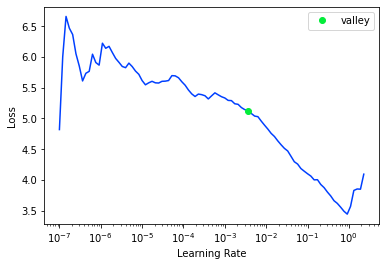

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   -0.44      -0.33
1   -0.34      -0.40
2   -0.28      -0.29
3   -0.86      -0.60
4   -0.44      -0.36
XGBoost RMSE:  0.11275283


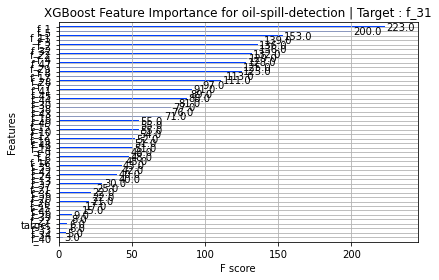

Target Variable: f_30
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:08,  4.50it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8975171209800378, 'Adjusted R-Squared': 0.8608626606006352, 'RMSE': 0.5190582535023378, 'Time taken': 0.2896299362182617}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9254576105610628, 'Adjusted R-Squared': 0.8987964639734137, 'RMSE': 0.4426822384678934, 'Time taken': 0.1737368106842041}


 10%|▉         | 4/42 [00:00<00:05,  7.17it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.9102021058915671, 'Adjusted R-Squared': 0.878084610918478, 'RMSE': 0.485873841789752, 'Time taken': 0.06857752799987793}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.8944484669066496, 'Adjusted R-Squared': 0.8566964587199768, 'RMSE': 0.5267720397647401, 'Time taken': 0.1057291030883789}
{'Model': 'DummyRegressor', 'R-Squared': -8.328279202229893e-05, 'Adjusted R-Squared': -0.3577773036446432, 'RMSE': 1.6214685, 'Time taken': 0.012769937515258789}
{'Model': 'ElasticNet', 'R-Squared': 0.6950018133032004, 'Adjusted R-Squared': 0.585914870616024, 'RMSE': 0.8954453202107897, 'Time taken': 0.01871347427368164}


 17%|█▋        | 7/42 [00:01<00:04,  7.44it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9014537007735486, 'Adjusted R-Squared': 0.8662072141889054, 'RMSE': 0.5089915848337135, 'Time taken': 0.35680651664733887}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8693380181218195, 'Adjusted R-Squared': 0.822604900515755, 'RMSE': 0.5860910143448501, 'Time taken': 0.04045987129211426}


 26%|██▌       | 11/42 [00:02<00:05,  5.55it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.940751266347851, 'Adjusted R-Squared': 0.9195601134357685, 'RMSE': 0.39466624042025583, 'Time taken': 0.8089191913604736}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.7656452629553776, 'Adjusted R-Squared': -2.754817656275184, 'RMSE': 2.6964270768723244, 'Time taken': 0.12014031410217285}


 29%|██▊       | 12/42 [00:02<00:08,  3.54it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9283116434287084, 'Adjusted R-Squared': 0.9026712823192684, 'RMSE': 0.43412495833801, 'Time taken': 0.7040116786956787}


 33%|███▎      | 14/42 [00:03<00:08,  3.22it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9354958489198199, 'Adjusted R-Squared': 0.9124250211612153, 'RMSE': 0.41179803923264524, 'Time taken': 0.631676435470581}
{'Model': 'HuberRegressor', 'R-Squared': 0.9126627226649497, 'Adjusted R-Squared': 0.8814253023042383, 'RMSE': 0.4791707139847045, 'Time taken': 0.14719629287719727}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9047913438545003, 'Adjusted R-Squared': 0.8707386128243582, 'RMSE': 0.5002979, 'Time taken': 0.03238344192504883}


 40%|████      | 17/42 [00:03<00:04,  5.68it/s]

{'Model': 'KernelRidge', 'R-Squared': -2.1139927403565304, 'Adjusted R-Squared': -3.2277565671993766, 'RMSE': 2.8612067457467667, 'Time taken': 0.04953193664550781}
{'Model': 'Lars', 'R-Squared': -2223.131199478372, 'Adjusted R-Squared': -3018.6233803137015, 'RMSE': 76.46639986942402, 'Time taken': 0.04462456703186035}


 45%|████▌     | 19/42 [00:03<00:03,  6.57it/s]

{'Model': 'LarsCV', 'R-Squared': 0.4062588198491335, 'Adjusted R-Squared': 0.1938988357075827, 'RMSE': 1.2493641160778308, 'Time taken': 0.16753649711608887}
{'Model': 'Lasso', 'R-Squared': 0.44715771421651895, 'Adjusted R-Squared': 0.24942580178301121, 'RMSE': 1.2055662167967223, 'Time taken': 0.031073808670043945}


 50%|█████     | 21/42 [00:04<00:04,  4.74it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9031212873159953, 'Adjusted R-Squared': 0.868471236793979, 'RMSE': 0.5046666685468858, 'Time taken': 0.6272997856140137}
{'Model': 'LassoLars', 'R-Squared': -8.327349190717648e-05, 'Adjusted R-Squared': -0.35777729101820954, 'RMSE': 1.6214685303979282, 'Time taken': 0.04273533821105957}


 57%|█████▋    | 24/42 [00:04<00:03,  5.87it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9016485508774601, 'Adjusted R-Squared': 0.8664717552058947, 'RMSE': 0.508488135506748, 'Time taken': 0.2766122817993164}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9143597533764688, 'Adjusted R-Squared': 0.8837293002045489, 'RMSE': 0.47449254900360316, 'Time taken': 0.08160948753356934}
{'Model': 'LinearRegression', 'R-Squared': 0.9122669284449172, 'Adjusted R-Squared': 0.8808879466478438, 'RMSE': 0.48025523724541125, 'Time taken': 0.04945230484008789}


 60%|█████▉    | 25/42 [00:05<00:02,  6.04it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.9058452020034925, 'Adjusted R-Squared': 0.8721693983405081, 'RMSE': 0.4975212905932063, 'Time taken': 0.14016056060791016}


 64%|██████▍   | 27/42 [00:06<00:06,  2.43it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.8514619615692078, 'Adjusted R-Squared': 0.7983352178968808, 'RMSE': 0.6248982156978982, 'Time taken': 1.6833832263946533}
{'Model': 'NuSVR', 'R-Squared': 0.8794673410444833, 'Adjusted R-Squared': 0.8363571199582036, 'RMSE': 0.562914986465281, 'Time taken': 0.1293478012084961}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.8666254619156899, 'Adjusted R-Squared': 0.8189221599731265, 'RMSE': 0.5921434184924975, 'Time taken': 0.0217740535736084}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.8666254619156899, 'Adjusted R-Squared': 0.8189221599731265, 'RMSE': 0.5921434184924975, 'Time taken': 0.04652142524719238}


 71%|███████▏  | 30/42 [00:07<00:02,  4.50it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.8259445865692596, 'Adjusted R-Squared': 0.7636911905246883, 'RMSE': 0.6764476774464262, 'Time taken': 0.04203438758850098}
PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range for family PoissonDistribution


 76%|███████▌  | 32/42 [00:19<00:21,  2.16s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.0002686912260214669, 'Adjusted R-Squared': -0.3580290260440875, 'RMSE': 1.6216188354249443, 'Time taken': 12.35210919380188}


 79%|███████▊  | 33/42 [00:19<00:16,  1.84s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.8499470823942212, 'Adjusted R-Squared': 0.7962785206228113, 'RMSE': 0.6280766739583536, 'Time taken': 0.4356963634490967}


 88%|████████▊ | 37/42 [00:21<00:04,  1.03it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9319722444069929, 'Adjusted R-Squared': 0.9076411493408809, 'RMSE': 0.4228959380896223, 'Time taken': 1.6628634929656982}
{'Model': 'Ridge', 'R-Squared': 0.9103031762031158, 'Adjusted R-Squared': 0.8782218304655441, 'RMSE': 0.4856003317769991, 'Time taken': 0.019622325897216797}
{'Model': 'RidgeCV', 'R-Squared': 0.9126579123707078, 'Adjusted R-Squared': 0.8814187715397931, 'RMSE': 0.47918390949789214, 'Time taken': 0.05269026756286621}
{'Model': 'SGDRegressor', 'R-Squared': 0.891592759653522, 'Adjusted R-Squared': 0.8528193671208402, 'RMSE': 0.5338504177594815, 'Time taken': 0.07375073432922363}


 93%|█████████▎| 39/42 [00:21<00:02,  1.46it/s]

{'Model': 'SVR', 'R-Squared': 0.8796413999659444, 'Adjusted R-Squared': 0.8365934335304063, 'RMSE': 0.5625083922080444, 'Time taken': 0.0838923454284668}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9122669284449172, 'Adjusted R-Squared': 0.8808879466478438, 'RMSE': 0.48025523724541125, 'Time taken': 0.022475004196166992}
{'Model': 'TweedieRegressor', 'R-Squared': 0.8402462909152705, 'Adjusted R-Squared': 0.7831081029944549, 'RMSE': 0.6480610461056836, 'Time taken': 0.0507655143737793}


 98%|█████████▊| 41/42 [00:22<00:00,  1.67it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9130700130672256, 'Adjusted R-Squared': 0.8819782659160873, 'RMSE': 0.4780521, 'Time taken': 0.7585442066192627}


100%|██████████| 42/42 [00:22<00:00,  1.84it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9343847073729994, 'Adjusted R-Squared': 0.9109164640246561, 'RMSE': 0.4153296895112234, 'Time taken': 0.20958709716796875}
Project: oil-spill-detection
oil-spill-detection
Target: f_30
f_30
Target Standard Deviation: 1.6208449602127075
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.92       0.94  0.39        0.81
HistGradientBoostingRegressor                0.91       0.94  0.41        0.63
LGBMRegressor                                0.91       0.93  0.42        0.21
RandomForestRegressor                        0.91       0.93  0.42        1.66
GradientBoostingRegressor                    0.90       0.93  0.43        0.70
BaggingRegressor                             0.90       0.93  0.44        0.17
LassoLarsIC                                  0.88       0.91  0.47        0.08
XGBRegresso

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 2.3709230422973633.
Better model found at epoch 1 with _rmse value: 1.7255181074142456.
No improvement since epoch 1: early stopping


<Figure size 432x288 with 0 Axes>

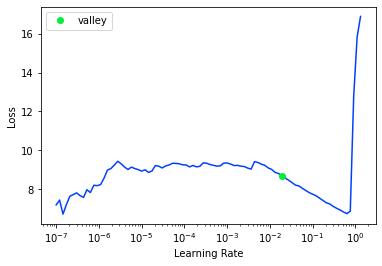

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   -2.85      -2.66
1   -1.49      -1.42
2   -3.24      -3.08
3   -1.73      -1.65
4   -3.57      -3.02
XGBoost RMSE:  0.47805014


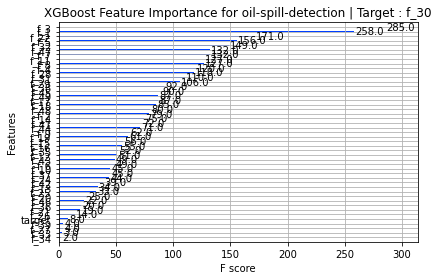

Target Variable: f_29
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:09,  4.38it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8348633986165628, 'Adjusted R-Squared': 0.7757999426473042, 'RMSE': 1.2452016151480958, 'Time taken': 0.29749321937561035}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8597970239705288, 'Adjusted R-Squared': 0.8096514340037837, 'RMSE': 1.1473518502759281, 'Time taken': 0.17881417274475098}


 10%|▉         | 4/42 [00:00<00:05,  7.20it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.52213254688481, 'Adjusted R-Squared': 0.3512164505151436, 'RMSE': 2.1182232486958856, 'Time taken': 0.05529642105102539}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.832316059969006, 'Adjusted R-Squared': 0.7723415120747089, 'RMSE': 1.2547688802883215, 'Time taken': 0.11410832405090332}
{'Model': 'DummyRegressor', 'R-Squared': -6.691981331008456e-05, 'Adjusted R-Squared': -0.35775508821369106, 'RMSE': 3.064309, 'Time taken': 0.013711929321289062}
{'Model': 'ElasticNet', 'R-Squared': 0.5763438325443498, 'Adjusted R-Squared': 0.42481717411130715, 'RMSE': 1.9944574283696346, 'Time taken': 0.024351835250854492}


 17%|█▋        | 7/42 [00:01<00:05,  6.85it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.5198405856663508, 'Adjusted R-Squared': 0.3481047367440968, 'RMSE': 2.123296913098482, 'Time taken': 0.4135754108428955}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.3628924913941024, 'Adjusted R-Squared': 0.13502192262265, 'RMSE': 2.445819289992077, 'Time taken': 0.04397106170654297}


 21%|██▏       | 9/42 [00:01<00:08,  3.96it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.8913226034331814, 'Adjusted R-Squared': 0.8524525856830054, 'RMSE': 1.0101540682286505, 'Time taken': 0.844451904296875}
{'Model': 'GammaRegressor', 'R-Squared': 0.5639631829226802, 'Adjusted R-Squared': 0.4080084089315221, 'RMSE': 2.0233899314316375, 'Time taken': 0.02781057357788086}


 26%|██▌       | 11/42 [00:02<00:06,  4.88it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.3870788805851593, 'Adjusted R-Squared': -2.2408516188966394, 'RMSE': 4.734252197129211, 'Time taken': 0.19189977645874023}


 29%|██▊       | 12/42 [00:02<00:09,  3.27it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8936956427978205, 'Adjusted R-Squared': 0.8556743763532454, 'RMSE': 0.9990645223245854, 'Time taken': 0.7214443683624268}


 33%|███▎      | 14/42 [00:03<00:08,  3.31it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.6533833720875196, 'Adjusted R-Squared': 0.5294110015202822, 'RMSE': 1.8040256187968735, 'Time taken': 0.5244364738464355}
{'Model': 'HuberRegressor', 'R-Squared': 0.35471579548453136, 'Adjusted R-Squared': 0.12392071503739299, 'RMSE': 2.461464187005867, 'Time taken': 0.13240909576416016}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.514660386399173, 'Adjusted R-Squared': 0.3410717654762495, 'RMSE': 2.1347198, 'Time taken': 0.034674644470214844}


 38%|███▊      | 16/42 [00:03<00:05,  4.97it/s]

{'Model': 'KernelRidge', 'R-Squared': -1.543053337515928, 'Adjusted R-Squared': -2.4526125604230846, 'RMSE': 4.886475647362595, 'Time taken': 0.06662440299987793}
{'Model': 'Lars', 'R-Squared': -510.1959875932065, 'Adjusted R-Squared': -693.0325087031854, 'RMSE': 69.28061310696651, 'Time taken': 0.07027006149291992}


 43%|████▎     | 18/42 [00:03<00:04,  5.89it/s]

{'Model': 'LarsCV', 'R-Squared': 0.6512925521222737, 'Adjusted R-Squared': 0.5265723700346198, 'RMSE': 1.8094584536317677, 'Time taken': 0.1575922966003418}
{'Model': 'Lasso', 'R-Squared': 0.5943105992678488, 'Adjusted R-Squared': 0.4492100106848167, 'RMSE': 1.9517079663574313, 'Time taken': 0.030106782913208008}


 48%|████▊     | 20/42 [00:04<00:04,  4.50it/s]

{'Model': 'LassoCV', 'R-Squared': 0.4869965969724568, 'Adjusted R-Squared': 0.30351362800640125, 'RMSE': 2.194714976334533, 'Time taken': 0.6124393939971924}
{'Model': 'LassoLars', 'R-Squared': -6.690994796443306e-05, 'Adjusted R-Squared': -0.3577550748198641, 'RMSE': 3.0643088326597905, 'Time taken': 0.04321098327636719}


 57%|█████▋    | 24/42 [00:05<00:02,  6.24it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.4721932969524325, 'Adjusted R-Squared': 0.2834157170303099, 'RMSE': 2.2261552834546006, 'Time taken': 0.2704756259918213}
{'Model': 'LassoLarsIC', 'R-Squared': 0.47564672508359973, 'Adjusted R-Squared': 0.28810431288722305, 'RMSE': 2.2188604879040574, 'Time taken': 0.07913637161254883}
{'Model': 'LinearRegression', 'R-Squared': 0.4670300451057271, 'Adjusted R-Squared': 0.27640575466908945, 'RMSE': 2.2370174291622793, 'Time taken': 0.06220817565917969}


 60%|█████▉    | 25/42 [00:05<00:02,  6.54it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.46727075762231063, 'Adjusted R-Squared': 0.27673256144342906, 'RMSE': 2.2365122047083847, 'Time taken': 0.10973000526428223}


 64%|██████▍   | 27/42 [00:06<00:05,  2.61it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.6812448966740804, 'Adjusted R-Squared': 0.5672375969443719, 'RMSE': 1.7300018896485545, 'Time taken': 1.6180119514465332}
{'Model': 'NuSVR', 'R-Squared': 0.4534881079147026, 'Adjusted R-Squared': 0.2580203508914941, 'RMSE': 2.265258728470053, 'Time taken': 0.12130260467529297}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.5861346172082532, 'Adjusted R-Squared': 0.4381097722681394, 'RMSE': 1.9712765478145096, 'Time taken': 0.021839618682861328}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.5944622637109356, 'Adjusted R-Squared': 0.4494159200747009, 'RMSE': 1.9513431153515883, 'Time taken': 0.04376530647277832}


 71%|███████▏  | 30/42 [00:07<00:02,  4.74it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.29080071627726056, 'Adjusted R-Squared': 0.037145498011463274, 'RMSE': 2.580489809382143, 'Time taken': 0.040842294692993164}
{'Model': 'PoissonRegressor', 'R-Squared': 0.7846016007048259, 'Adjusted R-Squared': 0.7075612973072818, 'RMSE': 1.4221298099409392, 'Time taken': 0.04616260528564453}


 76%|███████▌  | 32/42 [00:21<00:23,  2.40s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.10045238151235614, 'Adjusted R-Squared': -0.4940448391335637, 'RMSE': 3.2144274748983643, 'Time taken': 13.974727392196655}


 79%|███████▊  | 33/42 [00:21<00:18,  2.01s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -13.960910509886563, 'Adjusted R-Squared': -19.311893101013872, 'RMSE': 11.852146657664079, 'Time taken': 0.33820438385009766}


 88%|████████▊ | 37/42 [00:23<00:05,  1.10s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8850523044213133, 'Adjusted R-Squared': 0.8439396249807611, 'RMSE': 1.0388865860494954, 'Time taken': 1.6709918975830078}
{'Model': 'Ridge', 'R-Squared': 0.48165962367524806, 'Adjusted R-Squared': 0.2962678102452273, 'RMSE': 2.2061016733085155, 'Time taken': 0.020719289779663086}
{'Model': 'RidgeCV', 'R-Squared': 0.48165962367486226, 'Adjusted R-Squared': 0.2962678102447036, 'RMSE': 2.2061016733093366, 'Time taken': 0.05265092849731445}
{'Model': 'SGDRegressor', 'R-Squared': 0.604283998870668, 'Adjusted R-Squared': 0.46275053861273174, 'RMSE': 1.927568453481076, 'Time taken': 0.07581686973571777}


 93%|█████████▎| 39/42 [00:23<00:02,  1.31it/s]

{'Model': 'SVR', 'R-Squared': 0.44408060449490616, 'Adjusted R-Squared': 0.24524811997118656, 'RMSE': 2.2846723062174927, 'Time taken': 0.08712291717529297}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.4670300451057271, 'Adjusted R-Squared': 0.27640575466908945, 'RMSE': 2.2370174291622793, 'Time taken': 0.023241758346557617}
{'Model': 'TweedieRegressor', 'R-Squared': 0.5638937667583175, 'Adjusted R-Squared': 0.40791416508793477, 'RMSE': 2.0235509847795647, 'Time taken': 0.054114580154418945}


 98%|█████████▊| 41/42 [00:24<00:00,  1.53it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.8646154554256467, 'Adjusted R-Squared': 0.8161932460523378, 'RMSE': 1.1274637, 'Time taken': 0.767340898513794}


100%|██████████| 42/42 [00:24<00:00,  1.72it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.6623763856215596, 'Adjusted R-Squared': 0.5416204943475189, 'RMSE': 1.7804689798756403, 'Time taken': 0.25109267234802246}
Project: oil-spill-detection
oil-spill-detection
Target: f_29
f_29
Target Standard Deviation: 3.7426884174346924
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GradientBoostingRegressor                    0.86       0.89  1.00        0.72
ExtraTreesRegressor                          0.85       0.89  1.01        0.84
RandomForestRegressor                        0.84       0.89  1.04        1.67
XGBRegressor                                 0.82       0.86  1.13        0.77
BaggingRegressor                             0.81       0.86  1.15        0.18
AdaBoostRegressor                            0.78       0.83  1.25        0.30
DecisionTreeRegressor                        0.77       0.83  1.25        0.11
PoissonRegr

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 3.4828407764434814.
No improvement since epoch 0: early stopping


<Figure size 432x288 with 0 Axes>

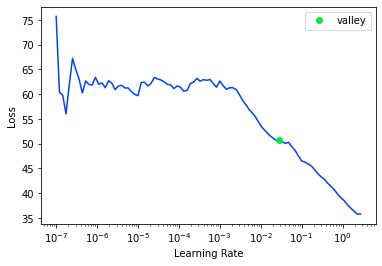

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    2.58       3.11
1    3.83       4.88
2    4.49       4.97
3    7.02       3.76
4    2.78       3.16
XGBoost RMSE:  1.1277856


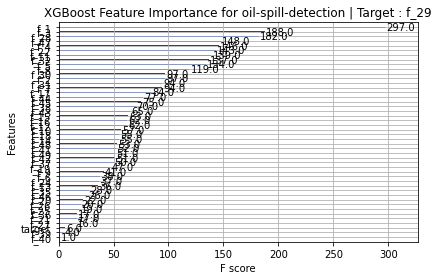

Target Variable: f_28
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:09,  4.37it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.6697239928440899, 'Adjusted R-Squared': 0.5515960778759177, 'RMSE': 0.46563148860566217, 'Time taken': 0.3056013584136963}
{'Model': 'BaggingRegressor', 'R-Squared': 0.7148159383370412, 'Adjusted R-Squared': 0.612815799494085, 'RMSE': 0.43267963461711845, 'Time taken': 0.1729433536529541}


 10%|▉         | 4/42 [00:00<00:05,  7.56it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.6814075508834868, 'Adjusted R-Squared': 0.5674584267469238, 'RMSE': 0.45732144651380335, 'Time taken': 0.03500008583068848}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.5570238446445082, 'Adjusted R-Squared': 0.3985871175465586, 'RMSE': 0.5392547807592106, 'Time taken': 0.1128995418548584}
{'Model': 'DummyRegressor', 'R-Squared': -0.0009616111836634467, 'Adjusted R-Squared': -0.3589697786873094, 'RMSE': 0.8106111, 'Time taken': 0.013525724411010742}
{'Model': 'ElasticNet', 'R-Squared': 0.19378740864403798, 'Adjusted R-Squared': -0.09456599994313075, 'RMSE': 0.7274926628402307, 'Time taken': 0.018658161163330078}


 17%|█▋        | 7/42 [00:01<00:04,  7.28it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.7037269707895557, 'Adjusted R-Squared': 0.5977607048675719, 'RMSE': 0.4410114733494746, 'Time taken': 0.3901815414428711}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.32887631544810614, 'Adjusted R-Squared': 0.08883937717772084, 'RMSE': 0.6637508834360871, 'Time taken': 0.05670666694641113}


 26%|██▌       | 11/42 [00:02<00:05,  5.37it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.7309264712764714, 'Adjusted R-Squared': 0.6346884938498079, 'RMSE': 0.4202805736779191, 'Time taken': 0.8319077491760254}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.36142363926125887, 'Adjusted R-Squared': -0.8483561817707601, 'RMSE': 0.9453670753488472, 'Time taken': 0.1237478256225586}


 29%|██▊       | 12/42 [00:02<00:08,  3.45it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.7379270246155507, 'Adjusted R-Squared': 0.6441928947335214, 'RMSE': 0.4147772701339512, 'Time taken': 0.7182843685150146}


 33%|███▎      | 14/42 [00:03<00:08,  3.46it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.687589630604623, 'Adjusted R-Squared': 0.5758516152734298, 'RMSE': 0.45286269783114835, 'Time taken': 0.5064640045166016}
{'Model': 'HuberRegressor', 'R-Squared': 0.6380531670903875, 'Adjusted R-Squared': 0.508597730502278, 'RMSE': 0.4874456731355263, 'Time taken': 0.13440418243408203}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.5023305124848205, 'Adjusted R-Squared': 0.3243319366582236, 'RMSE': 0.5715765, 'Time taken': 0.03299760818481445}


 38%|███▊      | 16/42 [00:03<00:05,  5.14it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.04460764993684996, 'Adjusted R-Squared': -0.29710202271347375, 'RMSE': 0.7919444307277703, 'Time taken': 0.07311797142028809}
{'Model': 'Lars', 'R-Squared': -11376.865070037962, 'Adjusted R-Squared': -15446.320460051538, 'RMSE': 86.4239712972958, 'Time taken': 0.0911264419555664}


 43%|████▎     | 18/42 [00:03<00:04,  5.91it/s]

{'Model': 'LarsCV', 'R-Squared': 0.6795455896924725, 'Adjusted R-Squared': 0.5649305086335759, 'RMSE': 0.45865586965438143, 'Time taken': 0.15629792213439941}
{'Model': 'Lasso', 'R-Squared': -0.0009616151054321342, 'Adjusted R-Squared': -0.3589697840117545, 'RMSE': 0.8106110899073453, 'Time taken': 0.03192925453186035}


 48%|████▊     | 20/42 [00:04<00:03,  5.53it/s]

{'Model': 'LassoCV', 'R-Squared': 0.7043460889936565, 'Adjusted R-Squared': 0.5986012595096358, 'RMSE': 0.44055044417224914, 'Time taken': 0.36443066596984863}
{'Model': 'LassoLars', 'R-Squared': -0.0009616151054321342, 'Adjusted R-Squared': -0.3589697840117545, 'RMSE': 0.8106110899073453, 'Time taken': 0.035416364669799805}


 57%|█████▋    | 24/42 [00:04<00:02,  7.76it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.7056178599358247, 'Adjusted R-Squared': 0.6003278974311197, 'RMSE': 0.43960189749373985, 'Time taken': 0.22098708152770996}
{'Model': 'LassoLarsIC', 'R-Squared': 0.7013556378583211, 'Adjusted R-Squared': 0.5945412309609324, 'RMSE': 0.4427728567288387, 'Time taken': 0.07109355926513672}
{'Model': 'LinearRegression', 'R-Squared': 0.5836630023365712, 'Adjusted R-Squared': 0.4347541491576806, 'RMSE': 0.5227888691157916, 'Time taken': 0.02822709083557129}
{'Model': 'LinearSVR', 'R-Squared': 0.5986068234830004, 'Adjusted R-Squared': 0.45504284064115386, 'RMSE': 0.5133207521794394, 'Time taken': 0.1337730884552002}


 64%|██████▍   | 27/42 [00:06<00:04,  3.05it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.6143361129473912, 'Adjusted R-Squared': 0.4763979343665312, 'RMSE': 0.5031625579838638, 'Time taken': 1.6587903499603271}
{'Model': 'NuSVR', 'R-Squared': 0.6443755930910601, 'Adjusted R-Squared': 0.5171814621528261, 'RMSE': 0.48316960822747684, 'Time taken': 0.1291828155517578}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.7065420286528887, 'Adjusted R-Squared': 0.601582608244068, 'RMSE': 0.4389113228615432, 'Time taken': 0.020157575607299805}


 71%|███████▏  | 30/42 [00:06<00:02,  5.03it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.7065420286528887, 'Adjusted R-Squared': 0.601582608244068, 'RMSE': 0.4389113228615432, 'Time taken': 0.04689455032348633}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.39122021432407617, 'Adjusted R-Squared': 0.17348145886334432, 'RMSE': 0.6321700854042067, 'Time taken': 0.035428762435913086}
PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range for family PoissonDistribution


 76%|███████▌  | 32/42 [00:18<00:19,  1.94s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.017863225756608037, 'Adjusted R-Squared': -0.381916496282694, 'RMSE': 0.8174261769894005, 'Time taken': 12.150993824005127}


 79%|███████▊  | 33/42 [00:19<00:15,  1.68s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -12.009078613022199, 'Adjusted R-Squared': -16.66196074468707, 'RMSE': 2.9223154780810723, 'Time taken': 0.4516119956970215}


 90%|█████████ | 38/42 [00:21<00:03,  1.19it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.7349464546452047, 'Adjusted R-Squared': 0.6401462814891101, 'RMSE': 0.4171292438019227, 'Time taken': 1.6243093013763428}
{'Model': 'Ridge', 'R-Squared': 0.6630337463013902, 'Adjusted R-Squared': 0.5425129694310846, 'RMSE': 0.4703238844231799, 'Time taken': 0.01925516128540039}
{'Model': 'RidgeCV', 'R-Squared': 0.6784673766969916, 'Adjusted R-Squared': 0.5634666574134339, 'RMSE': 0.45942682711988214, 'Time taken': 0.03765153884887695}
{'Model': 'SGDRegressor', 'R-Squared': 0.6899445741061883, 'Adjusted R-Squared': 0.5790488378375986, 'RMSE': 0.45115263386891047, 'Time taken': 0.029755115509033203}
{'Model': 'SVR', 'R-Squared': 0.6475586318465044, 'Adjusted R-Squared': 0.5215029600251813, 'RMSE': 0.48100242788128383, 'Time taken': 0.10715270042419434}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.5836630023365712, 'Adjusted R-Squared': 0.4347541491576806, 'RMSE': 0.5227888691157916, 'Time taken': 0.025147199630737305}
{'Model': 

 98%|█████████▊| 41/42 [00:21<00:00,  1.59it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.6790286472808866, 'Adjusted R-Squared': 0.5642286744105469, 'RMSE': 0.45902565, 'Time taken': 0.7585742473602295}


100%|██████████| 42/42 [00:22<00:00,  1.90it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.6817720085287905, 'Adjusted R-Squared': 0.5679532378566061, 'RMSE': 0.45705979249068646, 'Time taken': 0.20914292335510254}
Project: oil-spill-detection
oil-spill-detection
Target: f_28
f_28
Target Standard Deviation: 0.8530929684638977
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GradientBoostingRegressor                    0.64       0.74  0.41        0.72
RandomForestRegressor                        0.64       0.73  0.42        1.62
ExtraTreesRegressor                          0.63       0.73  0.42        0.83
BaggingRegressor                             0.61       0.71  0.43        0.17
OrthogonalMatchingPursuitCV                  0.60       0.71  0.44        0.05
OrthogonalMatchingPursuit                    0.60       0.71  0.44        0.02
LassoLarsCV                                  0.60       0.71  0.44        0.22
LassoCV   

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.0261919498443604.
No improvement since epoch 0: early stopping


<Figure size 432x288 with 0 Axes>

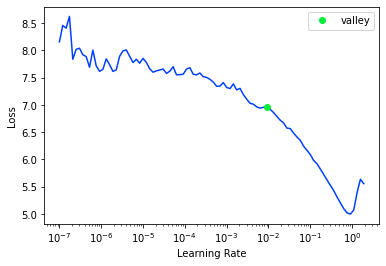

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.29       0.57
1    0.02       0.41
2    0.09       0.06
3    5.33       4.70
4    0.25       0.02
XGBoost RMSE:  0.45993426


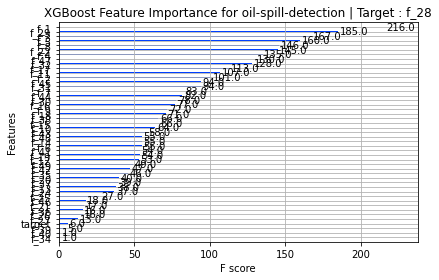

Target Variable: f_27
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
50
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'ta

  7%|▋         | 3/42 [00:00<00:05,  7.54it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.3540832996368408}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9999895831012278, 'Adjusted R-Squared': 0.9999858573491122, 'RMSE': 0.0073127242412713124, 'Time taken': 0.07696914672851562}
{'Model': 'BayesianRidge', 'R-Squared': 0.9974737962835538, 'Adjusted R-Squared': 0.9965702635674526, 'RMSE': 0.11387913499352273, 'Time taken': 0.03139019012451172}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.07397103309631348}


 12%|█▏        | 5/42 [00:00<00:03, 10.62it/s]

{'Model': 'DummyRegressor', 'R-Squared': -0.00558365605294231, 'Adjusted R-Squared': -0.3652449636923156, 'RMSE': 2.272056243184247, 'Time taken': 0.03985428810119629}
{'Model': 'ElasticNet', 'R-Squared': 0.8113707228515803, 'Adjusted R-Squared': 0.7439047770101748, 'RMSE': 0.9840440166985348, 'Time taken': 0.018323898315429688}


 17%|█▋        | 7/42 [00:00<00:03,  8.89it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9952060567065126, 'Adjusted R-Squared': 0.9934914346526376, 'RMSE': 0.1568759688809392, 'Time taken': 0.25500059127807617}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.029569387435913086}


 26%|██▌       | 11/42 [00:01<00:03,  9.05it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9999982291272087, 'Adjusted R-Squared': 0.999997595749349, 'RMSE': 0.003015113445777619, 'Time taken': 0.2303004264831543}
{'Model': 'GammaRegressor', 'R-Squared': 0.878204888530042, 'Adjusted R-Squared': 0.8346431333327577, 'RMSE': 0.7907239685768972, 'Time taken': 0.02797985076904297}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -2.913018632202039, 'Adjusted R-Squared': -4.312565442259702, 'RMSE': 4.481938910295235, 'Time taken': 0.15601348876953125}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999210394653593, 'Adjusted R-Squared': 0.9998927981062542, 'RMSE': 0.020133302321063716, 'Time taken': 0.7007169723510742}


 33%|███▎      | 14/42 [00:02<00:06,  4.31it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9999914263355176, 'Adjusted R-Squared': 0.9999883598423815, 'RMSE': 0.0066342711374259705, 'Time taken': 0.388019323348999}
{'Model': 'HuberRegressor', 'R-Squared': 0.9877357374524834, 'Adjusted R-Squared': 0.9833492493880432, 'RMSE': 0.2509173512483376, 'Time taken': 0.12595176696777344}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.965999242407362, 'Adjusted R-Squared': 0.9538383875019659, 'RMSE': 0.4177863742936748, 'Time taken': 0.03246784210205078}


 40%|████      | 17/42 [00:02<00:03,  6.76it/s]

{'Model': 'KernelRidge', 'R-Squared': -5.584486851569221, 'Adjusted R-Squared': -7.939522294831205, 'RMSE': 5.81394531009816, 'Time taken': 0.05440163612365723}
{'Model': 'Lars', 'R-Squared': -62.70732265933723, 'Adjusted R-Squared': -85.49315339150893, 'RMSE': 18.08442279286938, 'Time taken': 0.04466438293457031}


 45%|████▌     | 19/42 [00:02<00:03,  7.50it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9652556375498398, 'Adjusted R-Squared': 0.9528288217829941, 'RMSE': 0.42233020989318654, 'Time taken': 0.16423773765563965}
{'Model': 'Lasso', 'R-Squared': 0.7158615189313303, 'Adjusted R-Squared': 0.6142353468702733, 'RMSE': 1.2077443154646477, 'Time taken': 0.028649330139160156}


 50%|█████     | 21/42 [00:03<00:03,  6.63it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9960075970071123, 'Adjusted R-Squared': 0.994579657250532, 'RMSE': 0.14316180356837682, 'Time taken': 0.3488743305206299}
{'Model': 'LassoLars', 'R-Squared': -0.00558365605294231, 'Adjusted R-Squared': -0.3652449636923156, 'RMSE': 2.272056243184247, 'Time taken': 0.02746868133544922}


 57%|█████▋    | 24/42 [00:03<00:02,  7.56it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9971431219396566, 'Adjusted R-Squared': 0.996121318837782, 'RMSE': 0.12110325793094824, 'Time taken': 0.2612893581390381}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9975295575955686, 'Adjusted R-Squared': 0.9966459687063924, 'RMSE': 0.11261528530493471, 'Time taken': 0.07543420791625977}
{'Model': 'LinearRegression', 'R-Squared': 0.9975329242944883, 'Adjusted R-Squared': 0.9966505395531008, 'RMSE': 0.11253852354363689, 'Time taken': 0.028405427932739258}
{'Model': 'LinearSVR', 'R-Squared': 0.9879519198543077, 'Adjusted R-Squared': 0.9836427525029288, 'RMSE': 0.2486960564347667, 'Time taken': 0.20014405250549316}


 64%|██████▍   | 27/42 [00:05<00:05,  2.90it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9782105372854185, 'Adjusted R-Squared': 0.9704172258035609, 'RMSE': 0.33445156736916515, 'Time taken': 1.6510059833526611}
{'Model': 'NuSVR', 'R-Squared': 0.9811807059959916, 'Adjusted R-Squared': 0.9744497176295944, 'RMSE': 0.3108219196472155, 'Time taken': 0.14375066757202148}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9855750636123768, 'Adjusted R-Squared': 0.9804157797949057, 'RMSE': 0.27212405138834506, 'Time taken': 0.02069377899169922}


 71%|███████▏  | 30/42 [00:05<00:02,  4.82it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9888984342347257, 'Adjusted R-Squared': 0.9849278012237881, 'RMSE': 0.23872730362782452, 'Time taken': 0.05165290832519531}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9956710608516791, 'Adjusted R-Squared': 0.994122754148995, 'RMSE': 0.14907359171689535, 'Time taken': 0.035064697265625}
{'Model': 'PoissonRegressor', 'R-Squared': 0.958136188968216, 'Adjusted R-Squared': 0.9431630010809355, 'RMSE': 0.46358497890105743, 'Time taken': 0.04684710502624512}


 79%|███████▊  | 33/42 [00:15<00:11,  1.28s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -2.2282138707696575e-05, 'Adjusted R-Squared': -0.3576944852394133, 'RMSE': 2.2657647361506847, 'Time taken': 9.264267683029175}
{'Model': 'RANSACRegressor', 'R-Squared': 0.997298082099799, 'Adjusted R-Squared': 0.9963317027048366, 'RMSE': 0.11777308439223486, 'Time taken': 0.09340620040893555}


 88%|████████▊ | 37/42 [00:15<00:03,  1.56it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9999964582544174, 'Adjusted R-Squared': 0.9999951914986981, 'RMSE': 0.0042640143271121395, 'Time taken': 0.638014554977417}
{'Model': 'Ridge', 'R-Squared': 0.9967051786120761, 'Adjusted R-Squared': 0.9955267388455924, 'RMSE': 0.13005465850003953, 'Time taken': 0.021373510360717773}
{'Model': 'RidgeCV', 'R-Squared': 0.9974342354783139, 'Adjusted R-Squared': 0.9965165532771268, 'RMSE': 0.11476735496444582, 'Time taken': 0.05045509338378906}
{'Model': 'SGDRegressor', 'R-Squared': 0.9919615883670744, 'Adjusted R-Squared': 0.9890865360312104, 'RMSE': 0.2031398351782057, 'Time taken': 0.06488418579101562}


 95%|█████████▌| 40/42 [00:16<00:00,  2.47it/s]

{'Model': 'SVR', 'R-Squared': 0.9792889450815233, 'Adjusted R-Squared': 0.9718813414975426, 'RMSE': 0.32607018128889964, 'Time taken': 0.07382035255432129}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9975329242944883, 'Adjusted R-Squared': 0.9966505395531008, 'RMSE': 0.11253852354363689, 'Time taken': 0.021561622619628906}
{'Model': 'TweedieRegressor', 'R-Squared': 0.9169059193676519, 'Adjusted R-Squared': 0.8871861387035274, 'RMSE': 0.6531230608284381, 'Time taken': 0.032562255859375}


100%|██████████| 42/42 [00:17<00:00,  2.47it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9999999996101431, 'Adjusted R-Squared': 0.9999999994707052, 'RMSE': 4.4736564e-05, 'Time taken': 0.7411472797393799}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9999907777694512, 'Adjusted R-Squared': 0.9999874793074301, 'RMSE': 0.006880626160690727, 'Time taken': 0.17805051803588867}
Project: oil-spill-detection
oil-spill-detection
Target: f_27
f_27
Target Standard Deviation: 2.3170958835001483
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.35
ExtraTreeRegressor                           1.00       1.00  0.00        0.03
DecisionTreeRegressor                        1.00       1.00  0.00        0.07
XGBRegressor                                 1.00       1.00  0.00        0.74
ExtraTreesRegressor                          1.00       1.00  0.00        0.23
RandomFor

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 4.587303161621094.
Better model found at epoch 1 with _rmse value: 2.560055732727051.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       9       9.00
1       1       1.00
2       6       6.00
3       2       2.00
4       6       6.00
XGBoost RMSE:  4.4736564e-05


<Figure size 432x288 with 0 Axes>

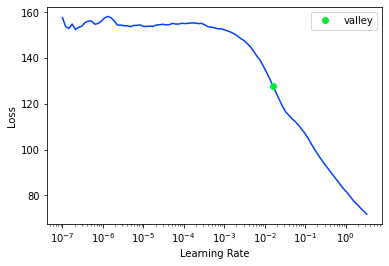

<Figure size 720x720 with 0 Axes>

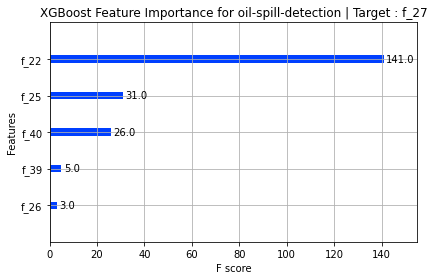

Target Variable: f_26
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
50
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'ta

 10%|▉         | 4/42 [00:00<00:02, 16.60it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9997302461422811, 'Adjusted R-Squared': 0.9996337648355057, 'RMSE': 0.030897893130844078, 'Time taken': 0.1262950897216797}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.07071971893310547}
{'Model': 'BayesianRidge', 'R-Squared': 0.987571741947639, 'Adjusted R-Squared': 0.9831265985566485, 'RMSE': 0.20972498193406694, 'Time taken': 0.02599191665649414}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.036406755447387695}
{'Model': 'DummyRegressor', 'R-Squared': -0.0003215215501219948, 'Adjusted R-Squared': -0.358100751885567, 'RMSE': 1.881546002171823, 'Time taken': 0.04606485366821289}
{'Model': 'ElasticNet', 'R-Squared': 0.5788970323042073, 'Adjusted R-Squared': 0.42828356210644203, 'RMSE': 1.2207850035690622, 'Time taken': 0.04678630828857422}


 17%|█▋        | 7/42 [00:00<00:04,  8.36it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.986714526615007, 'Adjusted R-Squared': 0.9819627879590607, 'RMSE': 0.21683708058520237, 'Time taken': 0.4164707660675049}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.029119014739990234}


 26%|██▌       | 11/42 [00:01<00:03,  8.80it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9999818678388468, 'Adjusted R-Squared': 0.9999753826133249, 'RMSE': 0.008010688047518299, 'Time taken': 0.2337024211883545}
{'Model': 'GammaRegressor', 'R-Squared': 0.7191536033934347, 'Adjusted R-Squared': 0.6187048921983858, 'RMSE': 0.996963968442202, 'Time taken': 0.0287168025970459}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -2.724032053614663, 'Adjusted R-Squared': -4.055985123885601, 'RMSE': 3.630377106217469, 'Time taken': 0.15195441246032715}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999987052232593, 'Adjusted R-Squared': 0.9999982421279286, 'RMSE': 0.0021406342961898623, 'Time taken': 0.6891758441925049}


 33%|███▎      | 14/42 [00:02<00:06,  4.16it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9999675925143255, 'Adjusted R-Squared': 0.9999560015157997, 'RMSE': 0.010709463215544827, 'Time taken': 0.4751889705657959}
{'Model': 'HuberRegressor', 'R-Squared': 0.9778738240582032, 'Adjusted R-Squared': 0.9699600822979986, 'RMSE': 0.2798325405349162, 'Time taken': 0.13448357582092285}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9492299487709885, 'Adjusted R-Squared': 0.9310713173095173, 'RMSE': 0.42388576808501927, 'Time taken': 0.03329801559448242}


 40%|████      | 17/42 [00:02<00:03,  6.43it/s]

{'Model': 'KernelRidge', 'R-Squared': -5.748669257554183, 'Adjusted R-Squared': -8.162426875219547, 'RMSE': 4.8871324222436545, 'Time taken': 0.056421756744384766}
{'Model': 'Lars', 'R-Squared': -10.532935441799799, 'Adjusted R-Squared': -14.657853957480018, 'RMSE': 6.388736335854355, 'Time taken': 0.048998355865478516}


 45%|████▌     | 19/42 [00:02<00:03,  6.99it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9037263834784753, 'Adjusted R-Squared': 0.8692927542116526, 'RMSE': 0.5837120754733574, 'Time taken': 0.1786799430847168}
{'Model': 'Lasso', 'R-Squared': 0.47961695937646276, 'Adjusted R-Squared': 0.2934945579855627, 'RMSE': 1.3570835987956509, 'Time taken': 0.0426793098449707}


 50%|█████     | 21/42 [00:03<00:03,  5.96it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9877844984722818, 'Adjusted R-Squared': 0.9834154504806162, 'RMSE': 0.20792211576592914, 'Time taken': 0.4189338684082031}
{'Model': 'LassoLars', 'R-Squared': -0.0003215215501219948, 'Adjusted R-Squared': -0.358100751885567, 'RMSE': 1.881546002171823, 'Time taken': 0.027135848999023438}


 57%|█████▋    | 24/42 [00:03<00:02,  7.09it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9888004988527969, 'Adjusted R-Squared': 0.9847948378585417, 'RMSE': 0.19908767458030963, 'Time taken': 0.2566404342651367}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9885344621565211, 'Adjusted R-Squared': 0.9844336493511892, 'RMSE': 0.2014383941740244, 'Time taken': 0.07369065284729004}
{'Model': 'LinearRegression', 'R-Squared': 0.9877053798091137, 'Adjusted R-Squared': 0.9833080339014244, 'RMSE': 0.20859437505058867, 'Time taken': 0.029154300689697266}
{'Model': 'LinearSVR', 'R-Squared': 0.9800470907703482, 'Adjusted R-Squared': 0.9729106487831005, 'RMSE': 0.26573462606138104, 'Time taken': 0.20021915435791016}


 64%|██████▍   | 27/42 [00:05<00:05,  2.79it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9355518249076927, 'Adjusted R-Squared': 0.9125010177578894, 'RMSE': 0.4775846358108089, 'Time taken': 1.7237627506256104}
{'Model': 'NuSVR', 'R-Squared': 0.9571041349770445, 'Adjusted R-Squared': 0.941761818290002, 'RMSE': 0.38963032402457387, 'Time taken': 0.14046025276184082}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9500612906921877, 'Adjusted R-Squared': 0.9322000005018023, 'RMSE': 0.42040095257146576, 'Time taken': 0.027142047882080078}


 71%|███████▏  | 30/42 [00:05<00:02,  4.55it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.973795696264543, 'Adjusted R-Squared': 0.9644233540525912, 'RMSE': 0.30453088666160155, 'Time taken': 0.07111310958862305}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9645735834225992, 'Adjusted R-Squared': 0.9519028212890763, 'RMSE': 0.3540859114718488, 'Time taken': 0.03902125358581543}
{'Model': 'PoissonRegressor', 'R-Squared': 0.910799531971804, 'Adjusted R-Squared': 0.8788957149398214, 'RMSE': 0.5618606291497086, 'Time taken': 0.04680013656616211}


 76%|███████▌  | 32/42 [00:13<00:12,  1.27s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.006334944077765359, 'Adjusted R-Squared': -0.3662649605727324, 'RMSE': 1.8871929754176213, 'Time taken': 7.450191497802734}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9823509504994098, 'Adjusted R-Squared': 0.9760385167364249, 'RMSE': 0.24992269490786662, 'Time taken': 0.07877421379089355}


 88%|████████▊ | 37/42 [00:14<00:03,  1.59it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9999993955946282, 'Adjusted R-Squared': 0.9999991794204441, 'RMSE': 0.0014625448482542627, 'Time taken': 0.6137120723724365}
{'Model': 'Ridge', 'R-Squared': 0.9870027438950726, 'Adjusted R-Squared': 0.9823540902517044, 'RMSE': 0.21447213393531572, 'Time taken': 0.020021915435791016}
{'Model': 'RidgeCV', 'R-Squared': 0.9875543362808512, 'Adjusted R-Squared': 0.9831029675053893, 'RMSE': 0.20987178955352526, 'Time taken': 0.06224465370178223}
{'Model': 'SGDRegressor', 'R-Squared': 0.9767291670679111, 'Adjusted R-Squared': 0.9684060224425655, 'RMSE': 0.28697958203652957, 'Time taken': 0.07784390449523926}


 93%|█████████▎| 39/42 [00:14<00:01,  2.12it/s]

{'Model': 'SVR', 'R-Squared': 0.9565431362493907, 'Adjusted R-Squared': 0.9410001703823845, 'RMSE': 0.39216987053629704, 'Time taken': 0.06870055198669434}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9877053798091137, 'Adjusted R-Squared': 0.9833080339014244, 'RMSE': 0.20859437505058867, 'Time taken': 0.021834135055541992}
{'Model': 'TweedieRegressor', 'R-Squared': 0.7580396966090357, 'Adjusted R-Squared': 0.6714991501407346, 'RMSE': 0.9253735775513722, 'Time taken': 0.036165475845336914}


100%|██████████| 42/42 [00:15<00:00,  2.77it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.999999999213251, 'Adjusted R-Squared': 0.999999998931859, 'RMSE': 5.276709e-05, 'Time taken': 0.5428180694580078}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9999680385960537, 'Adjusted R-Squared': 0.9999566071450071, 'RMSE': 0.010635501143425711, 'Time taken': 0.19873976707458496}
Project: oil-spill-detection
oil-spill-detection
Target: f_26
f_26
Target Standard Deviation: 1.9748107082283437
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
DecisionTreeRegressor                        1.00       1.00  0.00        0.04
BaggingRegressor                             1.00       1.00  0.00        0.07
ExtraTreeRegressor                           1.00       1.00  0.00        0.03
XGBRegressor                                 1.00       1.00  0.00        0.54
RandomForestRegressor                        1.00       1.00  0.00        0.61
GradientBoos

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 3.2738265991210938.
Better model found at epoch 1 with _rmse value: 2.723484516143799.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       7       7.00
1       4       4.00
2       4       4.00
3       1       1.00
4       5       5.00
XGBoost RMSE:  5.276709e-05


<Figure size 432x288 with 0 Axes>

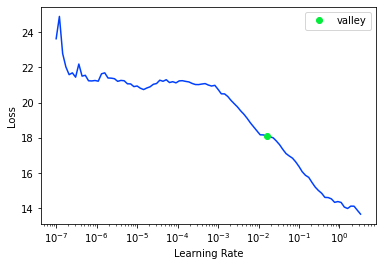

<Figure size 720x720 with 0 Axes>

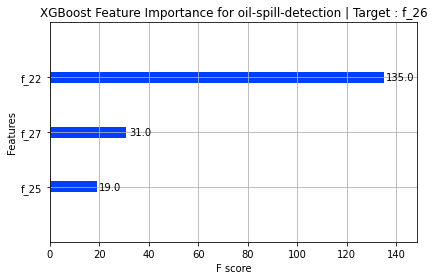

Target Variable: f_25
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
50
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'ta

  7%|▋         | 3/42 [00:00<00:03, 10.34it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9853737513530408, 'Adjusted R-Squared': 0.9801424653406248, 'RMSE': 0.26795817633893965, 'Time taken': 0.19474005699157715}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9970915032679739, 'Adjusted R-Squared': 0.9960512380134536, 'RMSE': 0.11949089867563202, 'Time taken': 0.07593297958374023}
{'Model': 'BayesianRidge', 'R-Squared': 0.9794544705918417, 'Adjusted R-Squared': 0.9721060695626463, 'RMSE': 0.31758443230115974, 'Time taken': 0.04694104194641113}


 12%|█▏        | 5/42 [00:00<00:02, 13.04it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9302832244008714, 'Adjusted R-Squared': 0.9053480272887744, 'RMSE': 0.5850179393017045, 'Time taken': 0.09196925163269043}
{'Model': 'DummyRegressor', 'R-Squared': -0.0023760000000001558, 'Adjusted R-Squared': -0.3608900437956206, 'RMSE': 2.218277464405864, 'Time taken': 0.017133235931396484}
{'Model': 'ElasticNet', 'R-Squared': 0.6962140272008186, 'Adjusted R-Squared': 0.5875606500682646, 'RMSE': 1.2211932514462236, 'Time taken': 0.019415616989135742}


 17%|█▋        | 7/42 [00:00<00:05,  6.65it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9770768097370947, 'Adjusted R-Squared': 0.968878004460581, 'RMSE': 0.3354579331704496, 'Time taken': 0.4776427745819092}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.030493974685668945}


 26%|██▌       | 11/42 [00:01<00:03,  7.98it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9982971677559913, 'Adjusted R-Squared': 0.9976881255665283, 'RMSE': 0.09142952635101011, 'Time taken': 0.2370612621307373}
{'Model': 'GammaRegressor', 'R-Squared': 0.8107435397378163, 'Adjusted R-Squared': 0.7430532729287141, 'RMSE': 0.9638864915330078, 'Time taken': 0.028528451919555664}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -3.3806067894677003, 'Adjusted R-Squared': -4.947393159423301, 'RMSE': 4.6373264890966865, 'Time taken': 0.14728879928588867}


 29%|██▊       | 12/42 [00:02<00:07,  4.00it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9996885026823639, 'Adjusted R-Squared': 0.9995770912329903, 'RMSE': 0.03910458605091978, 'Time taken': 0.7475659847259521}


 33%|███▎      | 14/42 [00:02<00:07,  3.81it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9958199924578454, 'Adjusted R-Squared': 0.994324953263936, 'RMSE': 0.14324816587001293, 'Time taken': 0.4882032871246338}
{'Model': 'HuberRegressor', 'R-Squared': 0.9626170318167049, 'Adjusted R-Squared': 0.9492464811526067, 'RMSE': 0.4283881292279801, 'Time taken': 0.1307506561279297}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9207843137254902, 'Adjusted R-Squared': 0.8924516960068699, 'RMSE': 0.6236000363595191, 'Time taken': 0.03263711929321289}


 38%|███▊      | 16/42 [00:02<00:04,  5.60it/s]

{'Model': 'KernelRidge', 'R-Squared': -4.249941327000207, 'Adjusted R-Squared': -6.127657568044076, 'RMSE': 5.076656305250276, 'Time taken': 0.0774078369140625}
{'Model': 'Lars', 'R-Squared': -661900.3443739575, 'Adjusted R-Squared': -898638.7814128181, 'RMSE': 1802.5908777038806, 'Time taken': 0.05307316780090332}


 43%|████▎     | 18/42 [00:03<00:03,  6.48it/s]

{'Model': 'LarsCV', 'R-Squared': 0.7988271951509527, 'Adjusted R-Squared': 0.7268748780881548, 'RMSE': 0.9937683771587711, 'Time taken': 0.16883134841918945}
{'Model': 'Lasso', 'R-Squared': 0.557251190476999, 'Adjusted R-Squared': 0.3988957768519841, 'RMSE': 1.4742775029960224, 'Time taken': 0.043108463287353516}


 48%|████▊     | 20/42 [00:03<00:04,  4.67it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9852425853919639, 'Adjusted R-Squared': 0.9799643860066078, 'RMSE': 0.2691569985974646, 'Time taken': 0.6104929447174072}
{'Model': 'LassoLars', 'R-Squared': -0.0023760000000001558, 'Adjusted R-Squared': -0.3608900437956206, 'RMSE': 2.218277464405864, 'Time taken': 0.027917146682739258}


 57%|█████▋    | 24/42 [00:04<00:02,  6.62it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9810709610416793, 'Adjusted R-Squared': 0.9743007208303092, 'RMSE': 0.3048349931817536, 'Time taken': 0.280414342880249}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9812106706094214, 'Adjusted R-Squared': 0.974490399513521, 'RMSE': 0.303707961863373, 'Time taken': 0.08438539505004883}
{'Model': 'LinearRegression', 'R-Squared': 0.9791324198140922, 'Adjusted R-Squared': 0.9716688327403004, 'RMSE': 0.32006381892579744, 'Time taken': 0.02931499481201172}
{'Model': 'LinearSVR', 'R-Squared': 0.9831825084655857, 'Adjusted R-Squared': 0.9771674932452478, 'RMSE': 0.2873301146857154, 'Time taken': 0.18067383766174316}


 64%|██████▍   | 27/42 [00:06<00:05,  2.89it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.6046319652727474, 'Adjusted R-Squared': 0.46322296015132136, 'RMSE': 1.393161019058707, 'Time taken': 1.6464407444000244}
{'Model': 'NuSVR', 'R-Squared': 0.8866277675328884, 'Adjusted R-Squared': 0.846078574898666, 'RMSE': 0.7460258680150702, 'Time taken': 0.14531230926513672}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.8522449204209874, 'Adjusted R-Squared': 0.7993982131263041, 'RMSE': 0.8516707802509924, 'Time taken': 0.019673585891723633}


 71%|███████▏  | 30/42 [00:06<00:02,  4.77it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.862860670428465, 'Adjusted R-Squared': 0.8138108372240475, 'RMSE': 0.8205055978349229, 'Time taken': 0.045571327209472656}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9460907964533641, 'Adjusted R-Squared': 0.9268094024841295, 'RMSE': 0.5144367609795409, 'Time taken': 0.03880167007446289}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8648679138439299, 'Adjusted R-Squared': 0.8165359998173063, 'RMSE': 0.8144787877380558, 'Time taken': 0.04331851005554199}


 76%|███████▌  | 32/42 [00:13<00:12,  1.27s/it]

{'Model': 'QuantileRegressor', 'R-Squared': 2.9234392684429622e-12, 'Adjusted R-Squared': -0.3576642335726732, 'RMSE': 2.2156468376247505, 'Time taken': 7.5613694190979}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9698607706314055, 'Adjusted R-Squared': 0.9590810462586965, 'RMSE': 0.38465077265017017, 'Time taken': 0.06078910827636719}


 88%|████████▊ | 37/42 [00:14<00:03,  1.59it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9944246187363834, 'Adjusted R-Squared': 0.9924305042698345, 'RMSE': 0.16543897205899166, 'Time taken': 0.6702885627746582}
{'Model': 'Ridge', 'R-Squared': 0.9713455352585818, 'Adjusted R-Squared': 0.9610968580882936, 'RMSE': 0.37505649223411924, 'Time taken': 0.019768953323364258}
{'Model': 'RidgeCV', 'R-Squared': 0.9796193632697738, 'Adjusted R-Squared': 0.9723299384538535, 'RMSE': 0.31630744299468805, 'Time taken': 0.03685259819030762}
{'Model': 'SGDRegressor', 'R-Squared': 0.8938346630183841, 'Adjusted R-Squared': 0.8558631191344485, 'RMSE': 0.7219247125822909, 'Time taken': 0.04895758628845215}
{'Model': 'SVR', 'R-Squared': 0.8853574758344881, 'Adjusted R-Squared': 0.8443539452935386, 'RMSE': 0.7501936904401084, 'Time taken': 0.08136701583862305}


 93%|█████████▎| 39/42 [00:14<00:01,  2.11it/s]

{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9791324198140922, 'Adjusted R-Squared': 0.9716688327403004, 'RMSE': 0.32006381892579744, 'Time taken': 0.030275344848632812}
{'Model': 'TweedieRegressor', 'R-Squared': 0.8254735915024571, 'Adjusted R-Squared': 0.7630517373682995, 'RMSE': 0.9256165541689356, 'Time taken': 0.035196781158447266}


 98%|█████████▊| 41/42 [00:15<00:00,  2.35it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9973816490385659, 'Adjusted R-Squared': 0.9964451585487099, 'RMSE': 0.113374256, 'Time taken': 0.570563793182373}


100%|██████████| 42/42 [00:15<00:00,  2.68it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9953845475172163, 'Adjusted R-Squared': 0.993733765242352, 'RMSE': 0.15052466849182863, 'Time taken': 0.23532319068908691}
Project: oil-spill-detection
oil-spill-detection
Target: f_25
f_25
Target Standard Deviation: 2.0804653325638474
                               Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
ExtraTreeRegressor                           1.00       1.00    0.00   
GradientBoostingRegressor                    1.00       1.00    0.04   
ExtraTreesRegressor                          1.00       1.00    0.09   
XGBRegressor                                 1.00       1.00    0.11   
BaggingRegressor                             1.00       1.00    0.12   
HistGradientBoostingRegressor                0.99       1.00    0.14   
LGBMRegressor                                0.99       1.00    0.15   
RandomForestRegressor                        0.99       0.99    0.17   
Ad

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 3.0741398334503174.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       3       3.00
1       1       1.08
2       5       5.00
3       7       7.00
4       5       5.00
XGBoost RMSE:  0.113374256


<Figure size 432x288 with 0 Axes>

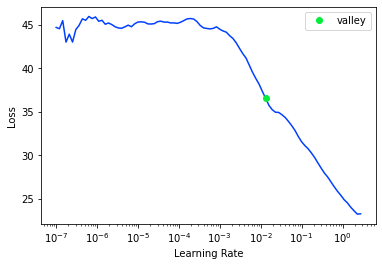

<Figure size 720x720 with 0 Axes>

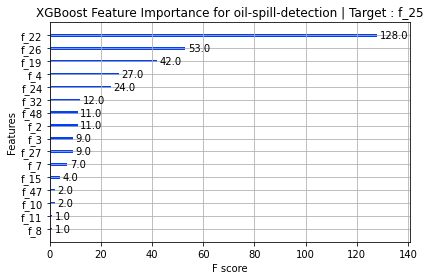

Target Variable: f_24
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:08,  4.87it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9814754578372724, 'Adjusted R-Squared': 0.9748498916622823, 'RMSE': 0.04177501017632044, 'Time taken': 0.2987966537475586}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9787516571097956, 'Adjusted R-Squared': 0.971151884835197, 'RMSE': 0.04474096591154088, 'Time taken': 0.1371142864227295}
{'Model': 'BayesianRidge', 'R-Squared': 0.9967487121148849, 'Adjusted R-Squared': 0.9955858427253182, 'RMSE': 0.01750130912050363, 'Time taken': 0.04853963851928711}


 10%|▉         | 4/42 [00:00<00:04,  7.93it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9700967438257538, 'Adjusted R-Squared': 0.959401418624746, 'RMSE': 0.05307647394725556, 'Time taken': 0.1074528694152832}
{'Model': 'DummyRegressor', 'R-Squared': -0.003435739451782993, 'Adjusted R-Squared': -0.3623288141462162, 'RMSE': 0.30745926, 'Time taken': 0.015043497085571289}
{'Model': 'ElasticNet', 'R-Squared': -0.0034357295542792876, 'Adjusted R-Squared': -0.3623288007087295, 'RMSE': 0.30745927820438557, 'Time taken': 0.020044565200805664}


 17%|█▋        | 7/42 [00:01<00:04,  7.54it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9949650873500029, 'Adjusted R-Squared': 0.9931642791759163, 'RMSE': 0.021779043032818295, 'Time taken': 0.37531137466430664}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9973604753378962, 'Adjusted R-Squared': 0.9964164117726182, 'RMSE': 0.01576905561509013, 'Time taken': 0.03498649597167969}


 26%|██▌       | 11/42 [00:01<00:04,  6.21it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9952872282779246, 'Adjusted R-Squared': 0.9936016383919268, 'RMSE': 0.021070799992328318, 'Time taken': 0.586855411529541}
{'Model': 'GammaRegressor', 'R-Squared': 0.9380132665384292, 'Adjusted R-Squared': 0.9158428290229769, 'RMSE': 0.07641738959586475, 'Time taken': 0.02763080596923828}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.5517513048124787, 'Adjusted R-Squared': -2.4644214795264308, 'RMSE': 0.4903001155036003, 'Time taken': 0.15207171440124512}


 29%|██▊       | 12/42 [00:02<00:08,  3.64it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9856818894061183, 'Adjusted R-Squared': 0.980560813354292, 'RMSE': 0.03672701895333143, 'Time taken': 0.7483046054840088}


 33%|███▎      | 14/42 [00:03<00:08,  3.47it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9764240853627579, 'Adjusted R-Squared': 0.9679918239231604, 'RMSE': 0.04712779254505856, 'Time taken': 0.5504519939422607}
{'Model': 'HuberRegressor', 'R-Squared': 0.9962940439316388, 'Adjusted R-Squared': 0.9949685559947796, 'RMSE': 0.018684993717828852, 'Time taken': 0.1366124153137207}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.973224660827237, 'Adjusted R-Squared': 0.963648079663256, 'RMSE': 0.050223887, 'Time taken': 0.031656742095947266}


 38%|███▊      | 16/42 [00:03<00:05,  5.13it/s]

{'Model': 'KernelRidge', 'R-Squared': -3.3448764685555687, 'Adjusted R-Squared': -4.8988833806666845, 'RMSE': 0.6397812961675267, 'Time taken': 0.07761335372924805}
{'Model': 'Lars', 'R-Squared': 0.8509494994179642, 'Adjusted R-Squared': 0.7976394663630755, 'RMSE': 0.11849759668424457, 'Time taken': 0.05214643478393555}


 43%|████▎     | 18/42 [00:03<00:03,  6.15it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9860526974550545, 'Adjusted R-Squared': 0.9810642461798551, 'RMSE': 0.036248324216824376, 'Time taken': 0.15734004974365234}
{'Model': 'Lasso', 'R-Squared': -0.0034357295542792876, 'Adjusted R-Squared': -0.3623288007087295, 'RMSE': 0.30745927820438557, 'Time taken': 0.045929670333862305}


 48%|████▊     | 20/42 [00:04<00:04,  5.41it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9953373515791427, 'Adjusted R-Squared': 0.9936696890052594, 'RMSE': 0.020958449837854068, 'Time taken': 0.40668511390686035}
{'Model': 'LassoLars', 'R-Squared': -0.0034357295542792876, 'Adjusted R-Squared': -0.3623288007087295, 'RMSE': 0.30745927820438557, 'Time taken': 0.02898693084716797}


 52%|█████▏    | 22/42 [00:04<00:03,  6.13it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9971450381605644, 'Adjusted R-Squared': 0.9961239204223722, 'RMSE': 0.016399967093281485, 'Time taken': 0.2056887149810791}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9969227759236893, 'Adjusted R-Squared': 0.995822162932892, 'RMSE': 0.01702638242179476, 'Time taken': 0.06266593933105469}
{'Model': 'LinearRegression', 'R-Squared': 0.9967905619462075, 'Adjusted R-Squared': 0.9956426607444862, 'RMSE': 0.017388307894523166, 'Time taken': 0.028118371963500977}


 60%|█████▉    | 25/42 [00:04<00:02,  7.21it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.995488391969061, 'Adjusted R-Squared': 0.993874751140477, 'RMSE': 0.020616194523101334, 'Time taken': 0.21853852272033691}


 62%|██████▏   | 26/42 [00:05<00:03,  5.19it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.3700981569315176, 'Adjusted R-Squared': 0.1448047970019145, 'RMSE': 0.2436011096940072, 'Time taken': 0.46534132957458496}


 74%|███████▍  | 31/42 [00:05<00:01,  7.74it/s]

{'Model': 'NuSVR', 'R-Squared': 0.9685035726291656, 'Adjusted R-Squared': 0.9572384270731737, 'RMSE': 0.05447201868620264, 'Time taken': 0.40755581855773926}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9825529285997945, 'Adjusted R-Squared': 0.9763127351792831, 'RMSE': 0.04054189943051432, 'Time taken': 0.019222259521484375}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9846846075500699, 'Adjusted R-Squared': 0.9792068394475402, 'RMSE': 0.03798454143058247, 'Time taken': 0.0439305305480957}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9778493702745736, 'Adjusted R-Squared': 0.969926882270589, 'RMSE': 0.04568102724691628, 'Time taken': 0.030787229537963867}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9241332683503755, 'Adjusted R-Squared': 0.8969984519209477, 'RMSE': 0.08454121990804297, 'Time taken': 0.034781455993652344}


 79%|███████▊  | 33/42 [00:19<00:17,  1.96s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.26023960438600513, 'Adjusted R-Squared': -0.7109822366116565, 'RMSE': 0.34456359075285803, 'Time taken': 13.68149471282959}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9956509687243685, 'Adjusted R-Squared': 0.9940954757863689, 'RMSE': 0.020241331998254224, 'Time taken': 0.10138201713562012}


 88%|████████▊ | 37/42 [00:20<00:05,  1.11s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9752738420482688, 'Adjusted R-Squared': 0.9664301797151679, 'RMSE': 0.04826375885472549, 'Time taken': 1.290771484375}
{'Model': 'Ridge', 'R-Squared': 0.9956364214306505, 'Adjusted R-Squared': 0.9940757254459925, 'RMSE': 0.02027515686159291, 'Time taken': 0.021522998809814453}
{'Model': 'RidgeCV', 'R-Squared': 0.996690888957316, 'Adjusted R-Squared': 0.9955073382924143, 'RMSE': 0.017656250964961578, 'Time taken': 0.05034375190734863}
{'Model': 'SGDRegressor', 'R-Squared': 0.9847768129229731, 'Adjusted R-Squared': 0.9793320233844744, 'RMSE': 0.03787002702259086, 'Time taken': 0.06468343734741211}
{'Model': 'SVR', 'R-Squared': 0.9307093510810678, 'Adjusted R-Squared': 0.9059265642414497, 'RMSE': 0.08079419107858629, 'Time taken': 0.049173593521118164}


 95%|█████████▌| 40/42 [00:20<00:01,  1.39it/s]

{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9967905619462075, 'Adjusted R-Squared': 0.9956426607444862, 'RMSE': 0.017388307894523166, 'Time taken': 0.031150102615356445}
{'Model': 'TweedieRegressor', 'R-Squared': 0.9335950230397678, 'Adjusted R-Squared': 0.9098443378496118, 'RMSE': 0.07909392686364733, 'Time taken': 0.054285526275634766}


100%|██████████| 42/42 [00:21<00:00,  1.56it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9881389203605297, 'Adjusted R-Squared': 0.9838966364018871, 'RMSE': 0.03342758, 'Time taken': 0.6258962154388428}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9764318367578634, 'Adjusted R-Squared': 0.9680023477150554, 'RMSE': 0.0471200444644905, 'Time taken': 0.19739580154418945}


100%|██████████| 42/42 [00:21<00:00,  1.93it/s]

Project: oil-spill-detection
oil-spill-detection
Target: f_24
f_24
Target Standard Deviation: 0.2978677451610565
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreeRegressor                           1.00       1.00  0.02        0.03
LassoLarsCV                                  1.00       1.00  0.02        0.21
LassoLarsIC                                  1.00       1.00  0.02        0.06
LinearRegression                             1.00       1.00  0.02        0.03
TransformedTargetRegressor                   1.00       1.00  0.02        0.03
BayesianRidge                                1.00       1.00  0.02        0.05
RidgeCV                                      1.00       1.00  0.02        0.05
HuberRegressor                               0.99       1.00  0.02        0.14
RANSACRegressor                              0.99       1.00  0.02        0.10
Ridge             

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.9997313022613525.
Better model found at epoch 1 with _rmse value: 1.5024044513702393.
Better model found at epoch 2 with _rmse value: 0.8258191347122192.
Better model found at epoch 3 with _rmse value: 0.6116010546684265.
Better model found at epoch 4 with _rmse value: 0.5337122678756714.
Better model found at epoch 5 with _rmse value: 0.4582771956920624.
Better model found at epoch 6 with _rmse value: 0.4561818242073059.
No improvement since epoch 6: early stopping


<Figure size 432x288 with 0 Axes>

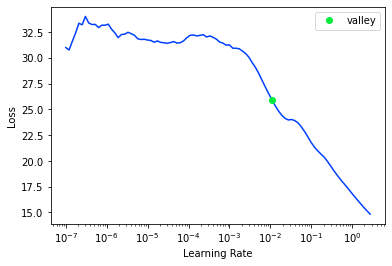

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    1.15       1.11
1    0.90       0.98
2    0.47       0.47
3    1.06       1.03
4    0.46       0.46
XGBoost RMSE:  0.033540647


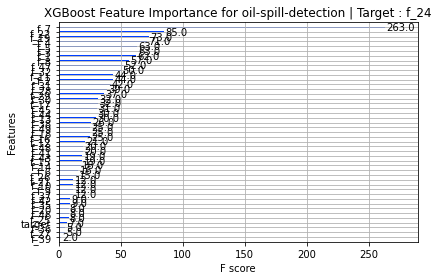

Target Variable: f_23
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
50
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'ta

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.0180819034576416}


 10%|▉         | 4/42 [00:00<00:01, 27.03it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.0334775447845459}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.041597843170166016}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.05438232421875}
{'Model': 'DummyRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02364969253540039}
{'Model': 'ElasticNet', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.06187868118286133}


 21%|██▏       | 9/42 [00:01<00:04,  6.82it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.8199150562286377}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.027394533157348633}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.14725232124328613}
{'Model': 'GammaRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01805710792541504}


 31%|███       | 13/42 [00:01<00:03,  8.66it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.35766423357664223, 'RMSE': 0.7297646484684942, 'Time taken': 0.1600947380065918}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.07500171661376953}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.09633588790893555}


 43%|████▎     | 18/42 [00:01<00:01, 12.30it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.35766423357664223, 'RMSE': 1.5590652886523864e-10, 'Time taken': 0.17342185974121094}
{'Model': 'KNeighborsRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.031540870666503906}
{'Model': 'KernelRidge', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.35766423357664223, 'RMSE': 1.0000000000000162, 'Time taken': 0.04883575439453125}
{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.026288986206054688}
LarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'Lasso', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.12411904335021973}


 57%|█████▋    | 24/42 [00:02<00:02,  8.29it/s]

{'Model': 'LassoCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.831592321395874}
{'Model': 'LassoLars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02942180633544922}
LassoLarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'LassoLarsIC', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03371238708496094}
{'Model': 'LinearRegression', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.0293271541595459}
{'Model': 'LinearSVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.35766423357664223, 'RMSE': 2.6065307443090943e-05, 'Time taken': 0.14876055717468262}


 69%|██████▉   | 29/42 [00:03<00:01,  7.56it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.35766423357664223, 'RMSE': 0.11956661891535897, 'Time taken': 0.6011857986450195}
{'Model': 'NuSVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.04709672927856445}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.027721405029296875}
OrthogonalMatchingPursuitCV model failed to execute
attempt to get argmin of an empty sequence
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.35766423357664223, 'RMSE': 0.03837261885715573, 'Time taken': 0.028514862060546875}
{'Model': 'PoissonRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.0281221866607666}


 76%|███████▌  | 32/42 [00:09<00:06,  1.47it/s]

{'Model': 'QuantileRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 5.3747313022613525}
{'Model': 'RANSACRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.07888197898864746}


 90%|█████████ | 38/42 [00:09<00:01,  2.91it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.2431168556213379}
{'Model': 'Ridge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02290797233581543}
{'Model': 'RidgeCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.035064697265625}
{'Model': 'SGDRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.35766423357664223, 'RMSE': 0.005005535712768492, 'Time taken': 0.029721498489379883}
{'Model': 'SVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02625560760498047}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.05736494064331055}


 95%|█████████▌| 40/42 [00:09<00:00,  3.58it/s]

{'Model': 'TweedieRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.04909157752990723}


100%|██████████| 42/42 [00:10<00:00,  4.02it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.35766423357664223, 'RMSE': 5.9604645e-08, 'Time taken': 0.542147159576416}
{'Model': 'LGBMRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.044576406478881836}
Project: oil-spill-detection
oil-spill-detection
Target: f_23
f_23
Target Standard Deviation: 0.0
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.02
QuantileRegressor                            1.00       1.00  0.00        5.37
BaggingRegressor                             1.00       1.00  0.00        0.03
LassoLarsIC                                  1.00       1.00  0.00        0.03
LinearRegression                             1.00       1.00  0.00        0.03
NuSVR                                        1.00       1.00  0.00        0.05
Ortho

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.8246853947639465.
Better model found at epoch 1 with _rmse value: 0.444255530834198.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  5.9604645e-08
XGBoost failed
Target Variable: f_22
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
50
Looping through continuous variables to find breakpoint


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 310, in <module>
    plot_importance(xgb)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/plotting.py", line 75, in plot_importance
    'Booster.get_score() results in empty.  ' +
ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.


Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular Object size: 937


  7%|▋         | 3/42 [00:00<00:04,  8.20it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9817113862297496, 'Adjusted R-Squared': 0.9751702032024337, 'RMSE': 0.30151134457776363, 'Time taken': 0.3042163848876953}
{'Model': 'BaggingRegressor', 'R-Squared': 0.999128601343888, 'Adjusted R-Squared': 0.9988169332114101, 'RMSE': 0.06581451817144178, 'Time taken': 0.07820820808410645}
{'Model': 'BayesianRidge', 'R-Squared': 0.9872320400321494, 'Adjusted R-Squared': 0.9826653974159109, 'RMSE': 0.25192659649545035, 'Time taken': 0.03670763969421387}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.038201332092285156}
{'Model': 'DummyRegressor', 'R-Squared': -1.9477172319426472e-07, 'Adjusted R-Squared': -0.35766449801124445, 'RMSE': 2.229529923357026, 'Time taken': 0.02482771873474121}
{'Model': 'ElasticNet', 'R-Squared': 0.7606455738836102, 'Adjusted R-Squared': 0.6750370565135146, 'RMSE': 1.0907720340303173, 'Time taken': 0.032440900802612305}


 17%|█▋        | 7/42 [00:01<00:04,  7.09it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9707845674985761, 'Adjusted R-Squared': 0.9603352522243442, 'RMSE': 0.38108286642187683, 'Time taken': 0.5012142658233643}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03556370735168457}


 21%|██▏       | 9/42 [00:01<00:04,  6.87it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9995667750138071, 'Adjusted R-Squared': 0.9994118259311542, 'RMSE': 0.046405559320289155, 'Time taken': 0.26743173599243164}
{'Model': 'GammaRegressor', 'R-Squared': 0.8427117644494786, 'Adjusted R-Squared': 0.786455388230679, 'RMSE': 0.8842221370665999, 'Time taken': 0.05755424499511719}


 26%|██▌       | 11/42 [00:01<00:04,  6.53it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -2.0762639989664087, 'Adjusted R-Squared': -3.1765336044361456, 'RMSE': 3.910434940736076, 'Time taken': 0.27899885177612305}


 29%|██▊       | 12/42 [00:02<00:08,  3.58it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9960152836041879, 'Adjusted R-Squared': 0.9945900930684595, 'RMSE': 0.14073819333343676, 'Time taken': 0.8276350498199463}


 33%|███▎      | 14/42 [00:03<00:07,  3.61it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9942496922716481, 'Adjusted R-Squared': 0.9921930128651573, 'RMSE': 0.16906698449140975, 'Time taken': 0.4887979030609131}
{'Model': 'HuberRegressor', 'R-Squared': 0.9916842824033412, 'Adjusted R-Squared': 0.9887100476424924, 'RMSE': 0.20331205466758218, 'Time taken': 0.12141585350036621}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9677690077319587, 'Adjusted R-Squared': 0.956241134584995, 'RMSE': 0.40026729037396436, 'Time taken': 0.0334782600402832}


 38%|███▊      | 16/42 [00:03<00:04,  5.32it/s]

{'Model': 'KernelRidge', 'R-Squared': -2.9073221006835674, 'Adjusted R-Squared': -4.304831465161631, 'RMSE': 4.407099646107509, 'Time taken': 0.06741642951965332}
{'Model': 'Lars', 'R-Squared': -3113.920607787307, 'Adjusted R-Squared': -4228.016299623642, 'RMSE': 124.4333387868922, 'Time taken': 0.07743048667907715}


 43%|████▎     | 18/42 [00:03<00:04,  5.46it/s]

{'Model': 'LarsCV', 'R-Squared': 0.48340451137259977, 'Adjusted R-Squared': 0.2986367818635297, 'RMSE': 1.6024650558889837, 'Time taken': 0.2695744037628174}
{'Model': 'Lasso', 'R-Squared': 0.5699614486465137, 'Adjusted R-Squared': 0.41615203976825943, 'RMSE': 1.4620659345223215, 'Time taken': 0.04679584503173828}


 48%|████▊     | 20/42 [00:04<00:05,  4.08it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9811016838692697, 'Adjusted R-Squared': 0.9743424321144829, 'RMSE': 0.30649600495838586, 'Time taken': 0.6790039539337158}
{'Model': 'LassoLars', 'R-Squared': -1.9477172319426472e-07, 'Adjusted R-Squared': -0.35766449801124445, 'RMSE': 2.229529923357026, 'Time taken': 0.03230786323547363}


 57%|█████▋    | 24/42 [00:04<00:03,  5.97it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.987417789740568, 'Adjusted R-Squared': 0.9829175831514282, 'RMSE': 0.2500873544736141, 'Time taken': 0.2635350227355957}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9875498247819973, 'Adjusted R-Squared': 0.9830968424047554, 'RMSE': 0.24877171206898055, 'Time taken': 0.09515738487243652}
{'Model': 'LinearRegression', 'R-Squared': 0.9876543672878074, 'Adjusted R-Squared': 0.9832387760257824, 'RMSE': 0.2477250583902215, 'Time taken': 0.03850579261779785}


 60%|█████▉    | 25/42 [00:04<00:02,  5.78it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.9700707984990401, 'Adjusted R-Squared': 0.9593661935826384, 'RMSE': 0.3857099375932854, 'Time taken': 0.19509434700012207}


 64%|██████▍   | 27/42 [00:06<00:06,  2.33it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.8512180906724435, 'Adjusted R-Squared': 0.7980041231027335, 'RMSE': 0.8599799522251049, 'Time taken': 1.802947759628296}
{'Model': 'NuSVR', 'R-Squared': 0.9416722072836798, 'Adjusted R-Squared': 0.9208104420055799, 'RMSE': 0.5384570086453798, 'Time taken': 0.13732242584228516}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.8976393014047671, 'Adjusted R-Squared': 0.8610285405933334, 'RMSE': 0.7133125809028117, 'Time taken': 0.020641803741455078}


 71%|███████▏  | 30/42 [00:07<00:02,  4.20it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.8917522973341124, 'Adjusted R-Squared': 0.8530359657236855, 'RMSE': 0.7335379839300398, 'Time taken': 0.06359052658081055}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9775016600171141, 'Adjusted R-Squared': 0.9694548084903886, 'RMSE': 0.3344171188490683, 'Time taken': 0.04377579689025879}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8921811571008273, 'Adjusted R-Squared': 0.8536182132901744, 'RMSE': 0.7320834628491026, 'Time taken': 0.07490134239196777}


 79%|███████▊  | 33/42 [00:16<00:11,  1.31s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.02738977311168478, 'Adjusted R-Squared': -0.3948503488961559, 'RMSE': 2.2598566037271177, 'Time taken': 8.82151484489441}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9591069144322852, 'Adjusted R-Squared': 0.9444809203241245, 'RMSE': 0.45085636360156894, 'Time taken': 0.10133099555969238}


 88%|████████▊ | 37/42 [00:16<00:03,  1.57it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9991797018823638, 'Adjusted R-Squared': 0.9988863105848151, 'RMSE': 0.06385561922769105, 'Time taken': 0.6565940380096436}
{'Model': 'Ridge', 'R-Squared': 0.9749004426765618, 'Adjusted R-Squared': 0.9659232287433613, 'RMSE': 0.35322081986706005, 'Time taken': 0.020265817642211914}
{'Model': 'RidgeCV', 'R-Squared': 0.9865681079092274, 'Adjusted R-Squared': 0.9817640005190971, 'RMSE': 0.25839366404442576, 'Time taken': 0.0362393856048584}
{'Model': 'SGDRegressor', 'R-Squared': 0.9238585809560925, 'Adjusted R-Squared': 0.8966255186703154, 'RMSE': 0.6152105104764987, 'Time taken': 0.0511937141418457}


 93%|█████████▎| 39/42 [00:16<00:01,  2.19it/s]

{'Model': 'SVR', 'R-Squared': 0.9408621585177217, 'Adjusted R-Squared': 0.9197106677685857, 'RMSE': 0.5421831265920908, 'Time taken': 0.09664034843444824}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9876543672878074, 'Adjusted R-Squared': 0.9832387760257824, 'RMSE': 0.2477250583902215, 'Time taken': 0.02276778221130371}
{'Model': 'TweedieRegressor', 'R-Squared': 0.8845207662529301, 'Adjusted R-Squared': 0.8432179746207664, 'RMSE': 0.7576440379036655, 'Time taken': 0.03277945518493652}


 98%|█████████▊| 41/42 [00:17<00:00,  2.44it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9948718214977071, 'Adjusted R-Squared': 0.9930376554640403, 'RMSE': 0.15965952, 'Time taken': 0.5664794445037842}


100%|██████████| 42/42 [00:17<00:00,  2.37it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9962119681230496, 'Adjusted R-Squared': 0.9948571246050162, 'RMSE': 0.13722084070284493, 'Time taken': 0.2058415412902832}
Project: oil-spill-detection
oil-spill-detection
Target: f_22
f_22
Target Standard Deviation: 2.3467515136176362
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
DecisionTreeRegressor                        1.00       1.00   0.00   
ExtraTreeRegressor                           1.00       1.00   0.00   
ExtraTreesRegressor                          1.00       1.00   0.05   
RandomForestRegressor                        1.00       1.00   0.06   
BaggingRegressor                             1.00       1.00   0.07   
LGBMRegressor                                0.99       1.00   0.14   
GradientBoostingRegressor                    0.99       1.00   0.14   
XGBRegressor                                 0.99       0.99   0.16   
HistGradient

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 3.3111891746520996.
Better model found at epoch 1 with _rmse value: 2.762537717819214.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       5       5.00
1       4       4.77
2       2       2.00
3       6       6.00
4       4       4.00
XGBoost RMSE:  0.15965952


<Figure size 432x288 with 0 Axes>

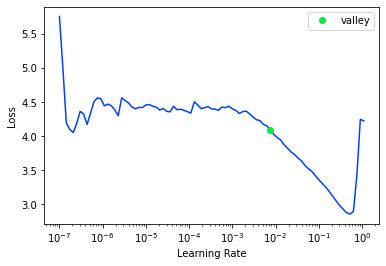

<Figure size 720x720 with 0 Axes>

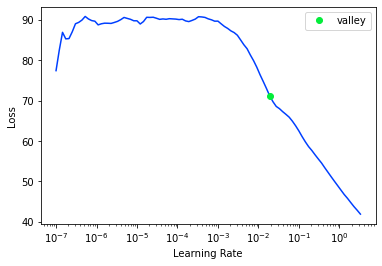

<Figure size 720x720 with 0 Axes>

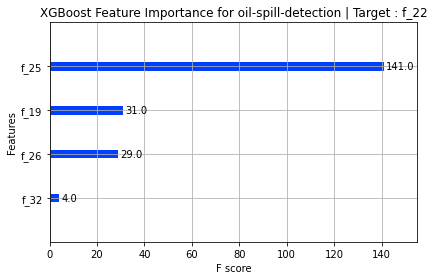

Target Variable: f_21
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:08,  4.58it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9722914517555794, 'Adjusted R-Squared': 0.9623810950842173, 'RMSE': 0.01830579701946254, 'Time taken': 0.3271660804748535}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9813874999125222, 'Adjusted R-Squared': 0.9747304743337892, 'RMSE': 0.015003207398710356, 'Time taken': 0.14068317413330078}
{'Model': 'BayesianRidge', 'R-Squared': 0.9847515838519219, 'Adjusted R-Squared': 0.9792977707770618, 'RMSE': 0.013579823469272305, 'Time taken': 0.026205778121948242}


 12%|█▏        | 5/42 [00:00<00:03, 11.00it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9596735834415866, 'Adjusted R-Squared': 0.9452502665703293, 'RMSE': 0.02208394070489357, 'Time taken': 0.06267309188842773}
{'Model': 'DummyRegressor', 'R-Squared': -0.0008943734049864371, 'Adjusted R-Squared': -0.35887849236005454, 'RMSE': 0.11002107, 'Time taken': 0.03030681610107422}
{'Model': 'ElasticNet', 'R-Squared': -0.0008943789573103711, 'Adjusted R-Squared': -0.35887849989824616, 'RMSE': 0.11002107436521745, 'Time taken': 0.02733135223388672}


 17%|█▋        | 7/42 [00:00<00:03,  8.99it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9852548481630988, 'Adjusted R-Squared': 0.9799810347323824, 'RMSE': 0.01335384653538631, 'Time taken': 0.25118088722229004}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9595409225975648, 'Adjusted R-Squared': 0.9450701576872048, 'RMSE': 0.022120235384638386, 'Time taken': 0.03718066215515137}


 26%|██▌       | 11/42 [00:01<00:05,  6.15it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9921005055859323, 'Adjusted R-Squared': 0.9892751389706819, 'RMSE': 0.00977420412454775, 'Time taken': 0.6527523994445801}
{'Model': 'GammaRegressor', 'R-Squared': 0.9413852524893302, 'Adjusted R-Squared': 0.9204208537446381, 'RMSE': 0.026624729595300507, 'Time taken': 0.03666806221008301}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -4.208300824037621, 'Adjusted R-Squared': -6.0711237465036305, 'RMSE': 0.2509746092218749, 'Time taken': 0.15077710151672363}


 29%|██▊       | 12/42 [00:02<00:08,  3.66it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9900684990620718, 'Adjusted R-Squared': 0.986516356390842, 'RMSE': 0.010959461123152327, 'Time taken': 0.7155115604400635}


 33%|███▎      | 14/42 [00:04<00:13,  2.04it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9856520364887953, 'Adjusted R-Squared': 0.9805202831161747, 'RMSE': 0.013172763302972108, 'Time taken': 1.7488701343536377}
{'Model': 'HuberRegressor', 'R-Squared': 0.9859679258547869, 'Adjusted R-Squared': 0.9809491548101485, 'RMSE': 0.013026948368462965, 'Time taken': 0.14216351509094238}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9060040539082115, 'Adjusted R-Squared': 0.8723850658899805, 'RMSE': 0.03371602, 'Time taken': 0.03179192543029785}


 38%|███▊      | 16/42 [00:04<00:08,  3.20it/s]

{'Model': 'KernelRidge', 'R-Squared': -5.985208430559485, 'Adjusted R-Squared': -8.483567650248643, 'RMSE': 0.29065074546415726, 'Time taken': 0.07341599464416504}
{'Model': 'Lars', 'R-Squared': -2.3707812052867476, 'Adjusted R-Squared': -3.5763890816301824, 'RMSE': 0.2019049834020086, 'Time taken': 0.08822870254516602}


 43%|████▎     | 18/42 [00:04<00:05,  4.10it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9581715691880394, 'Adjusted R-Squared': 0.9432110355399659, 'RMSE': 0.022491454546046036, 'Time taken': 0.15778160095214844}
{'Model': 'Lasso', 'R-Squared': -0.0008943789573103711, 'Adjusted R-Squared': -0.35887849989824616, 'RMSE': 0.11002107436521745, 'Time taken': 0.04271411895751953}


 48%|████▊     | 20/42 [00:05<00:04,  4.44it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9852319786644252, 'Adjusted R-Squared': 0.9799499856319934, 'RMSE': 0.013364198326087911, 'Time taken': 0.3295891284942627}
{'Model': 'LassoLars', 'R-Squared': -0.0008943789573103711, 'Adjusted R-Squared': -0.35887849989824616, 'RMSE': 0.11002107436521745, 'Time taken': 0.03961753845214844}


 57%|█████▋    | 24/42 [00:05<00:02,  6.81it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9835084664326446, 'Adjusted R-Squared': 0.977610034718773, 'RMSE': 0.01412252258608138, 'Time taken': 0.2069394588470459}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9845518544150107, 'Adjusted R-Squared': 0.9790266052641751, 'RMSE': 0.013668470923421515, 'Time taken': 0.06760716438293457}
{'Model': 'LinearRegression', 'R-Squared': 0.9849160871672301, 'Adjusted R-Squared': 0.9795211110445606, 'RMSE': 0.013506373751489768, 'Time taken': 0.0301358699798584}
{'Model': 'LinearSVR', 'R-Squared': 0.9625958852143507, 'Adjusted R-Squared': 0.9492177711669286, 'RMSE': 0.02126872456026724, 'Time taken': 0.2236800193786621}


 62%|██████▏   | 26/42 [00:06<00:03,  4.93it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.781712200188406, 'Adjusted R-Squared': -1.4189669287229454, 'RMSE': 0.1467913732391533, 'Time taken': 0.42563772201538086}


 71%|███████▏  | 30/42 [00:06<00:01,  6.66it/s]

{'Model': 'NuSVR', 'R-Squared': 0.9166420152464569, 'Adjusted R-Squared': 0.8868278455170875, 'RMSE': 0.03175085025661152, 'Time taken': 0.4105560779571533}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9813391511123949, 'Adjusted R-Squared': 0.97466483289712, 'RMSE': 0.015022681316975445, 'Time taken': 0.020824909210205078}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9820298279306228, 'Adjusted R-Squared': 0.9756025401101885, 'RMSE': 0.01474204980979838, 'Time taken': 0.04716062545776367}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.6912592840980694, 'Adjusted R-Squared': 0.5808337725711015, 'RMSE': 0.06110527597210807, 'Time taken': 0.0307314395904541}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8309776519231817, 'Adjusted R-Squared': 0.7705244033409621, 'RMSE': 0.045212010706313935, 'Time taken': 0.034447431564331055}


 76%|███████▌  | 32/42 [00:17<00:17,  1.71s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.023017729138534726, 'Adjusted R-Squared': -0.3889145811661858, 'RMSE': 0.11123035838754226, 'Time taken': 10.806699991226196}


 79%|███████▊  | 33/42 [00:17<00:13,  1.47s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.9592581077492466, 'Adjusted R-Squared': 0.9446861900829188, 'RMSE': 0.022197412584320796, 'Time taken': 0.3529171943664551}


 90%|█████████ | 38/42 [00:19<00:02,  1.40it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9862254051468998, 'Adjusted R-Squared': 0.981298725235937, 'RMSE': 0.012906877061975915, 'Time taken': 1.254758358001709}
{'Model': 'Ridge', 'R-Squared': 0.9844950615948335, 'Adjusted R-Squared': 0.9789494996834965, 'RMSE': 0.013693572928516078, 'Time taken': 0.020110368728637695}
{'Model': 'RidgeCV', 'R-Squared': 0.9844950615950682, 'Adjusted R-Squared': 0.9789494996838152, 'RMSE': 0.013693572928412459, 'Time taken': 0.0366969108581543}
{'Model': 'SGDRegressor', 'R-Squared': 0.9699347548768689, 'Adjusted R-Squared': 0.9591814920226103, 'RMSE': 0.019068394614622775, 'Time taken': 0.030515193939208984}
{'Model': 'SVR', 'R-Squared': 0.6559278733817687, 'Adjusted R-Squared': 0.5328655799197737, 'RMSE': 0.06450694912490268, 'Time taken': 0.034215450286865234}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9849160871672301, 'Adjusted R-Squared': 0.9795211110445606, 'RMSE': 0.013506373751489768, 'Time taken': 0.03112649917602539}
{'Mo

 98%|█████████▊| 41/42 [00:19<00:00,  1.88it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9852195359994544, 'Adjusted R-Squared': 0.9799330926707922, 'RMSE': 0.0133698275, 'Time taken': 0.6173238754272461}


100%|██████████| 42/42 [00:20<00:00,  2.09it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9846319275820364, 'Adjusted R-Squared': 0.9791353177391151, 'RMSE': 0.013633000656050425, 'Time taken': 0.21139836311340332}
Project: oil-spill-detection
oil-spill-detection
Target: f_21
f_21
Target Standard Deviation: 0.10410507023334503
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.99       0.99  0.01        0.65
GradientBoostingRegressor                    0.99       0.99  0.01        0.72
RandomForestRegressor                        0.98       0.99  0.01        1.25
HuberRegressor                               0.98       0.99  0.01        0.14
HistGradientBoostingRegressor                0.98       0.99  0.01        1.75
ElasticNetCV                                 0.98       0.99  0.01        0.25
LassoCV                                      0.98       0.99  0.01        0.33
XGBRegre

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.546535611152649.
No improvement since epoch 0: early stopping


<Figure size 432x288 with 0 Axes>

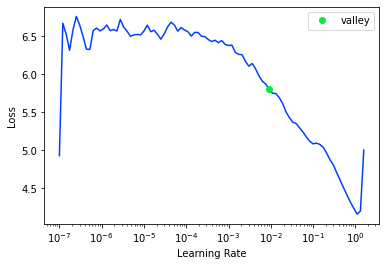

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.34       0.34
1    0.19       0.19
2    0.30       0.30
3    0.27       0.25
4    0.21       0.21
XGBoost RMSE:  0.013453979


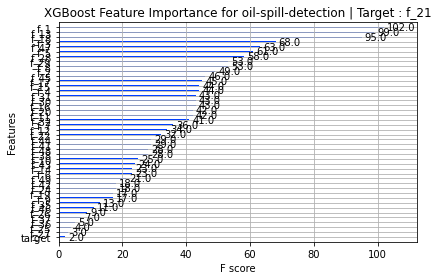

Target Variable: f_20
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:08,  4.61it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9437635614200046, 'Adjusted R-Squared': 0.9236497987162107, 'RMSE': 0.0187753977064873, 'Time taken': 0.3251304626464844}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9616891718928766, 'Adjusted R-Squared': 0.9479867589202559, 'RMSE': 0.015496763681107844, 'Time taken': 0.14026188850402832}
{'Model': 'BayesianRidge', 'R-Squared': 0.9691666769987451, 'Adjusted R-Squared': 0.9581387001588803, 'RMSE': 0.013902420066973445, 'Time taken': 0.04154372215270996}


 10%|▉         | 4/42 [00:00<00:04,  7.76it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9308139146584008, 'Adjusted R-Squared': 0.9060685264705296, 'RMSE': 0.020825221034638103, 'Time taken': 0.1092672348022461}
{'Model': 'DummyRegressor', 'R-Squared': -0.004574569687733954, 'Adjusted R-Squared': -0.3638749632256826, 'RMSE': 0.079354465, 'Time taken': 0.015828609466552734}
{'Model': 'ElasticNet', 'R-Squared': -0.004574578678763208, 'Adjusted R-Squared': -0.36387497543248126, 'RMSE': 0.07935445850085412, 'Time taken': 0.019198179244995117}


 17%|█▋        | 7/42 [00:00<00:04,  7.87it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9725728165929508, 'Adjusted R-Squared': 0.9627630940605025, 'RMSE': 0.013112057523395988, 'Time taken': 0.34043025970458984}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9111927211471643, 'Adjusted R-Squared': 0.8794295338202377, 'RMSE': 0.023594160099359846, 'Time taken': 0.037867069244384766}


 21%|██▏       | 9/42 [00:01<00:06,  4.89it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9730996944277902, 'Adjusted R-Squared': 0.9634784172523283, 'RMSE': 0.012985505101387037, 'Time taken': 0.6498434543609619}
{'Model': 'GammaRegressor', 'R-Squared': 0.8986281333482471, 'Adjusted R-Squared': 0.8623710423560143, 'RMSE': 0.02520803320955584, 'Time taken': 0.029168367385864258}


 26%|██▌       | 11/42 [00:01<00:05,  5.73it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -4.927158392222247, 'Adjusted R-Squared': -7.04709095586378, 'RMSE': 0.19275404785719993, 'Time taken': 0.19897890090942383}


 29%|██▊       | 12/42 [00:02<00:08,  3.52it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.971858822836518, 'Adjusted R-Squared': 0.9617937302743967, 'RMSE': 0.01328162979098502, 'Time taken': 0.7388834953308105}


 33%|███▎      | 14/42 [00:03<00:09,  3.07it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9640959386995553, 'Adjusted R-Squared': 0.9512543401322431, 'RMSE': 0.015002099061762544, 'Time taken': 0.7302100658416748}
{'Model': 'HuberRegressor', 'R-Squared': 0.9727671815947883, 'Adjusted R-Squared': 0.9630269764717563, 'RMSE': 0.01306551508045514, 'Time taken': 0.1456434726715088}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.876423957763243, 'Adjusted R-Squared': 0.8322252273281985, 'RMSE': 0.02783219, 'Time taken': 0.033971309661865234}


 40%|████      | 17/42 [00:03<00:04,  5.21it/s]

{'Model': 'KernelRidge', 'R-Squared': -7.26750981716566, 'Adjusted R-Squared': -10.224502379509582, 'RMSE': 0.22764997143196794, 'Time taken': 0.063201904296875}
{'Model': 'Lars', 'R-Squared': -805.9769291902018, 'Adjusted R-Squared': -1094.6037140830476, 'RMSE': 2.2491105352687093, 'Time taken': 0.08121991157531738}


 43%|████▎     | 18/42 [00:03<00:04,  4.99it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9397141768364734, 'Adjusted R-Squared': 0.9181520940991537, 'RMSE': 0.019439622996233367, 'Time taken': 0.22884607315063477}
{'Model': 'Lasso', 'R-Squared': -0.004574578678763208, 'Adjusted R-Squared': -0.36387497543248126, 'RMSE': 0.07935445850085412, 'Time taken': 0.021866321563720703}


 48%|████▊     | 20/42 [00:04<00:04,  5.09it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9725484960397002, 'Adjusted R-Squared': 0.9627300749152133, 'RMSE': 0.013117869673823482, 'Time taken': 0.35336971282958984}
{'Model': 'LassoLars', 'R-Squared': -0.004574578678763208, 'Adjusted R-Squared': -0.36387497543248126, 'RMSE': 0.07935445850085412, 'Time taken': 0.05441427230834961}


 55%|█████▍    | 23/42 [00:04<00:03,  5.41it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9696290496623698, 'Adjusted R-Squared': 0.9587664469868671, 'RMSE': 0.013797786840417381, 'Time taken': 0.3373255729675293}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9695858077539073, 'Adjusted R-Squared': 0.9587077389943559, 'RMSE': 0.013807605934094832, 'Time taken': 0.13130521774291992}
{'Model': 'LinearRegression', 'R-Squared': 0.9695293772882713, 'Adjusted R-Squared': 0.9586311253694778, 'RMSE': 0.013820409307978874, 'Time taken': 0.09170246124267578}


 60%|█████▉    | 25/42 [00:05<00:02,  5.78it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.9586301937235431, 'Adjusted R-Squared': 0.9438336936684599, 'RMSE': 0.016103563276433527, 'Time taken': 0.20754027366638184}


 62%|██████▏   | 26/42 [00:05<00:03,  4.54it/s]

{'Model': 'MLPRegressor', 'R-Squared': -4.933265506050527, 'Adjusted R-Squared': -7.055382365878817, 'RMSE': 0.192853325433533, 'Time taken': 0.40231776237487793}


 71%|███████▏  | 30/42 [00:06<00:01,  6.39it/s]

{'Model': 'NuSVR', 'R-Squared': 0.9604486374221398, 'Adjusted R-Squared': 0.9463025296388176, 'RMSE': 0.015745663483320814, 'Time taken': 0.4571223258972168}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9181693353217641, 'Adjusted R-Squared': 0.8889014333565557, 'RMSE': 0.02264843928308512, 'Time taken': 0.020643234252929688}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9217616491964185, 'Adjusted R-Squared': 0.893778589419955, 'RMSE': 0.022145734255682947, 'Time taken': 0.05020642280578613}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.4211441035195219, 'Adjusted R-Squared': 0.21410805295351154, 'RMSE': 0.06023729638234417, 'Time taken': 0.0306546688079834}
{'Model': 'PoissonRegressor', 'R-Squared': 0.7199690536289713, 'Adjusted R-Squared': 0.6198119998174356, 'RMSE': 0.04189703162094566, 'Time taken': 0.03475022315979004}


 76%|███████▌  | 32/42 [00:15<00:16,  1.67s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.027383522906113233, 'Adjusted R-Squared': -0.3948418632155988, 'RMSE': 0.08025027672277932, 'Time taken': 9.774436950683594}


 79%|███████▊  | 33/42 [00:16<00:12,  1.42s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.9729261498725839, 'Adjusted R-Squared': 0.9632428020167927, 'RMSE': 0.013027325085913467, 'Time taken': 0.34261131286621094}


 88%|████████▊ | 37/42 [00:17<00:03,  1.32it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9634884442150953, 'Adjusted R-Squared': 0.9504295665985965, 'RMSE': 0.015128483989527408, 'Time taken': 1.2675836086273193}
{'Model': 'Ridge', 'R-Squared': 0.9689796691785609, 'Adjusted R-Squared': 0.957884806330017, 'RMSE': 0.01394451626048946, 'Time taken': 0.01894521713256836}
{'Model': 'RidgeCV', 'R-Squared': 0.968979669178569, 'Adjusted R-Squared': 0.957884806330028, 'RMSE': 0.013944516260487615, 'Time taken': 0.050421953201293945}
{'Model': 'SGDRegressor', 'R-Squared': 0.9593539537725576, 'Adjusted R-Squared': 0.9448163168006987, 'RMSE': 0.015962076720434516, 'Time taken': 0.06536269187927246}
{'Model': 'SVR', 'R-Squared': 0.5963069719757614, 'Adjusted R-Squared': 0.4519204145072382, 'RMSE': 0.050304387447672606, 'Time taken': 0.04138445854187012}


 95%|█████████▌| 40/42 [00:17<00:00,  2.14it/s]

{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9695293772882713, 'Adjusted R-Squared': 0.9586311253694778, 'RMSE': 0.013820409307978874, 'Time taken': 0.02669692039489746}
{'Model': 'TweedieRegressor', 'R-Squared': 0.8902763924446698, 'Adjusted R-Squared': 0.8510321824431284, 'RMSE': 0.0262258926735303, 'Time taken': 0.0484464168548584}
{'Model': 'XGBRegressor', 'R-Squared': 0.971788463875997, 'Adjusted R-Squared': 0.9616982064301858, 'RMSE': 0.013298223, 'Time taken': 0.6170296669006348}


100%|██████████| 42/42 [00:18<00:00,  2.25it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9631627129159848, 'Adjusted R-Squared': 0.9499873328640377, 'RMSE': 0.015195817176575007, 'Time taken': 0.21458840370178223}
Project: oil-spill-detection
oil-spill-detection
Target: f_20
f_20
Target Standard Deviation: 0.07435313612222672
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.96       0.97  0.01        0.65
RANSACRegressor                              0.96       0.97  0.01        0.34
HuberRegressor                               0.96       0.97  0.01        0.15
ElasticNetCV                                 0.96       0.97  0.01        0.34
LassoCV                                      0.96       0.97  0.01        0.35
GradientBoostingRegressor                    0.96       0.97  0.01        0.74
XGBRegressor                                 0.96       0.97  0.01        0.62
LassoLar

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.015300989151001.
No improvement since epoch 0: early stopping


<Figure size 432x288 with 0 Axes>

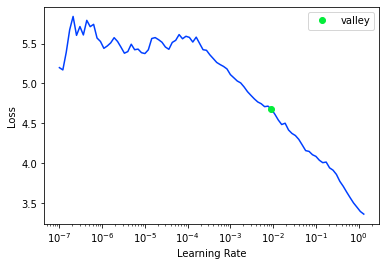

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.21       0.22
1    0.24       0.26
2    0.14       0.15
3    0.16       0.16
4    0.20       0.20
XGBoost RMSE:  0.013275505


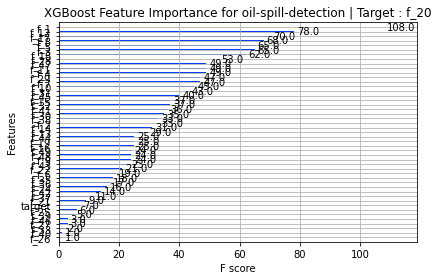

Target Variable: f_19
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:08,  4.93it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9900983880385689, 'Adjusted R-Squared': 0.9865569355852103, 'RMSE': 0.06494105205567124, 'Time taken': 0.3005986213684082}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9985527806275418, 'Adjusted R-Squared': 0.9980351620198743, 'RMSE': 0.024827532117493188, 'Time taken': 0.13285183906555176}
{'Model': 'BayesianRidge', 'R-Squared': 0.9620935610531913, 'Adjusted R-Squared': 0.9485357836196612, 'RMSE': 0.12706409932051654, 'Time taken': 0.030614614486694336}


 10%|▉         | 4/42 [00:00<00:04,  9.19it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9888095002180656, 'Adjusted R-Squared': 0.9848070586902204, 'RMSE': 0.06903846238265213, 'Time taken': 0.07361459732055664}
{'Model': 'DummyRegressor', 'R-Squared': -0.005600358931681537, 'Adjusted R-Squared': -0.3652676405933777, 'RMSE': 0.65445393, 'Time taken': 0.03927445411682129}
{'Model': 'ElasticNet', 'R-Squared': -0.00560036899396521, 'Adjusted R-Squared': -0.3652676542545803, 'RMSE': 0.6544539310984864, 'Time taken': 0.01820063591003418}


 17%|█▋        | 7/42 [00:01<00:07,  4.74it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9601081553301949, 'Adjusted R-Squared': 0.9458402692804105, 'RMSE': 0.13034921748985967, 'Time taken': 0.8024404048919678}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.992557242505157, 'Adjusted R-Squared': 0.9898952343500671, 'RMSE': 0.05630322908283565, 'Time taken': 0.03540515899658203}


 21%|██▏       | 9/42 [00:01<00:07,  4.19it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9995342350077387, 'Adjusted R-Squared': 0.9993676475287548, 'RMSE': 0.014084770997327878, 'Time taken': 0.5402493476867676}
{'Model': 'GammaRegressor', 'R-Squared': 0.5961186756759512, 'Adjusted R-Squared': 0.45166477135567107, 'RMSE': 0.4147565511647528, 'Time taken': 0.0270078182220459}


 26%|██▌       | 11/42 [00:02<00:06,  5.15it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.4607847598185455, 'Adjusted R-Squared': -0.983255221359485, 'RMSE': 0.7887865258775152, 'Time taken': 0.18376398086547852}


 29%|██▊       | 12/42 [00:02<00:08,  3.41it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9921560524370197, 'Adjusted R-Squared': 0.9893505529436909, 'RMSE': 0.057800781392977174, 'Time taken': 0.7030301094055176}


 33%|███▎      | 14/42 [00:03<00:08,  3.39it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9926951851027185, 'Adjusted R-Squared': 0.9900825140810631, 'RMSE': 0.055779032419725316, 'Time taken': 0.52004075050354}
{'Model': 'HuberRegressor', 'R-Squared': 0.9599318888527428, 'Adjusted R-Squared': 0.9456009585883953, 'RMSE': 0.13063688120665143, 'Time taken': 0.13817930221557617}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.922465502940238, 'Adjusted R-Squared': 0.8947341864736078, 'RMSE': 0.18172465, 'Time taken': 0.03228330612182617}


 38%|███▊      | 16/42 [00:03<00:05,  5.04it/s]

{'Model': 'KernelRidge', 'R-Squared': -0.9810279164993903, 'Adjusted R-Squared': -1.689570747948077, 'RMSE': 0.9185687500382782, 'Time taken': 0.07320737838745117}
{'Model': 'Lars', 'R-Squared': -1205.8344353786879, 'Adjusted R-Squared': -1637.475948762306, 'RMSE': 22.672019975387155, 'Time taken': 0.08962225914001465}


 43%|████▎     | 18/42 [00:03<00:04,  5.76it/s]

{'Model': 'LarsCV', 'R-Squared': 0.834206327303859, 'Adjusted R-Squared': 0.7749078604271371, 'RMSE': 0.26573597022241163, 'Time taken': 0.16512441635131836}
{'Model': 'Lasso', 'R-Squared': -0.00560036899396521, 'Adjusted R-Squared': -0.3652676542545803, 'RMSE': 0.6544539310984864, 'Time taken': 0.07681465148925781}


 48%|████▊     | 20/42 [00:04<00:06,  3.41it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9617815191889971, 'Adjusted R-Squared': 0.9481121355412662, 'RMSE': 0.12758601665684316, 'Time taken': 0.9564018249511719}
{'Model': 'LassoLars', 'R-Squared': -0.00560036899396521, 'Adjusted R-Squared': -0.3652676542545803, 'RMSE': 0.6544539310984864, 'Time taken': 0.04748249053955078}


 57%|█████▋    | 24/42 [00:05<00:03,  5.16it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.962626948547541, 'Adjusted R-Squared': 0.9492599447433769, 'RMSE': 0.1261669626885708, 'Time taken': 0.2751486301422119}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9630186279118738, 'Adjusted R-Squared': 0.9497917138073615, 'RMSE': 0.12550408994296355, 'Time taken': 0.08041739463806152}
{'Model': 'LinearRegression', 'R-Squared': 0.9620895839910931, 'Adjusted R-Squared': 0.9485303841046958, 'RMSE': 0.12707076479178403, 'Time taken': 0.06288886070251465}


 60%|█████▉    | 25/42 [00:05<00:03,  5.15it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.9601647323475608, 'Adjusted R-Squared': 0.9459170818733308, 'RMSE': 0.1302567501360148, 'Time taken': 0.19089221954345703}


 64%|██████▍   | 27/42 [00:07<00:05,  2.79it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9392693397452089, 'Adjusted R-Squared': 0.9175481546905756, 'RMSE': 0.16083122508474978, 'Time taken': 1.2295348644256592}
{'Model': 'NuSVR', 'R-Squared': 0.9495975664604819, 'Adjusted R-Squared': 0.9315704186981725, 'RMSE': 0.14651838449922236, 'Time taken': 0.1810436248779297}


 74%|███████▍  | 31/42 [00:07<00:01,  5.84it/s]

{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.8190155682087931, 'Adjusted R-Squared': 0.754283910122887, 'RMSE': 0.2776431595731999, 'Time taken': 0.024230480194091797}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.8715501430433849, 'Adjusted R-Squared': 0.8256082234019677, 'RMSE': 0.23390159385028156, 'Time taken': 0.03526902198791504}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9288047446118164, 'Adjusted R-Squared': 0.9033407481591084, 'RMSE': 0.1741373354394885, 'Time taken': 0.025384187698364258}
{'Model': 'PoissonRegressor', 'R-Squared': 0.6485976651084067, 'Adjusted R-Squared': 0.5229136183223624, 'RMSE': 0.38687323954091557, 'Time taken': 0.026412010192871094}
{'Model': 'QuantileRegressor', 'R-Squared': -0.05278851254593553, 'Adjusted R-Squared': -0.4293333090039708, 'RMSE': 0.66963313814933, 'Time taken': 12.727771520614624}


 79%|███████▊  | 33/42 [00:20<00:18,  2.00s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.7249323767023905, 'Adjusted R-Squared': 0.6265505260339025, 'RMSE': 0.34228361191235823, 'Time taken': 0.2727675437927246}


 90%|█████████ | 38/42 [00:21<00:03,  1.03it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9985017194875698, 'Adjusted R-Squared': 0.9979658381364087, 'RMSE': 0.025261720988952806, 'Time taken': 1.2245702743530273}
{'Model': 'Ridge', 'R-Squared': 0.9572872081383751, 'Adjusted R-Squared': 0.9420103701732684, 'RMSE': 0.13487931398477104, 'Time taken': 0.02176666259765625}
{'Model': 'RidgeCV', 'R-Squared': 0.9620551656548975, 'Adjusted R-Squared': 0.9484836555606637, 'RMSE': 0.12712843458994866, 'Time taken': 0.03789234161376953}
{'Model': 'SGDRegressor', 'R-Squared': 0.9021826692031883, 'Adjusted R-Squared': 0.8671969085532338, 'RMSE': 0.20411469510520416, 'Time taken': 0.03266167640686035}
{'Model': 'SVR', 'R-Squared': 0.9354033954674434, 'Adjusted R-Squared': 0.9122995004156531, 'RMSE': 0.1658712867930853, 'Time taken': 0.08454585075378418}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9620895839910931, 'Adjusted R-Squared': 0.9485303841046958, 'RMSE': 0.12707076479178403, 'Time taken': 0.022044897079467773}
{'Model'

 98%|█████████▊| 41/42 [00:22<00:00,  1.39it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9983673207682341, 'Adjusted R-Squared': 0.997783369802128, 'RMSE': 0.026370404, 'Time taken': 0.6625747680664062}


100%|██████████| 42/42 [00:22<00:00,  1.86it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9927671939915228, 'Adjusted R-Squared': 0.9901802779738923, 'RMSE': 0.05550342421498844, 'Time taken': 0.20889019966125488}
Project: oil-spill-detection
oil-spill-detection
Target: f_19
f_19
Target Standard Deviation: 0.6802762150764465
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          1.00       1.00  0.01        0.54
BaggingRegressor                             1.00       1.00  0.02        0.13
RandomForestRegressor                        1.00       1.00  0.03        1.22
XGBRegressor                                 1.00       1.00  0.03        0.66
LGBMRegressor                                0.99       0.99  0.06        0.21
HistGradientBoostingRegressor                0.99       0.99  0.06        0.52
ExtraTreeRegressor                           0.99       0.99  0.06        0.04
GradientBo

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.8393160104751587.
No improvement since epoch 0: early stopping


<Figure size 432x288 with 0 Axes>

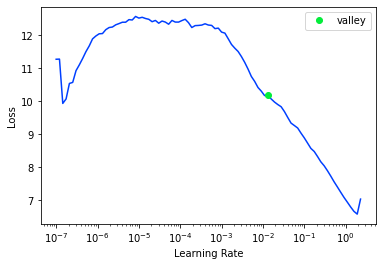

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.63       0.63
1    0.90       0.90
2    0.96       0.96
3    0.33       0.34
4    1.00       1.04
XGBoost RMSE:  0.026371697


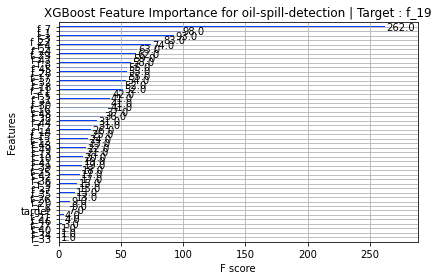

Target Variable: f_18
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:05,  7.43it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -19.26598024876018, 'Adjusted R-Squared': -26.514396542112358, 'RMSE': 296.72431288060693, 'Time taken': 0.08378171920776367}
{'Model': 'BaggingRegressor', 'R-Squared': -0.9446462723948077, 'Adjusted R-Squared': -1.6401766909885707, 'RMSE': 91.91568604084678, 'Time taken': 0.18509626388549805}


 10%|▉         | 4/42 [00:00<00:03,  9.52it/s]

{'Model': 'BayesianRidge', 'R-Squared': -2.8520894013811655, 'Adjusted R-Squared': -4.229844004794867, 'RMSE': 129.3652119100285, 'Time taken': 0.04890894889831543}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -19.37016592778144, 'Adjusted R-Squared': -26.655845712170418, 'RMSE': 297.4860523409699, 'Time taken': 0.11859583854675293}
{'Model': 'DummyRegressor', 'R-Squared': -0.0071182158113998195, 'Adjusted R-Squared': -0.36732838059065953, 'RMSE': 66.146904, 'Time taken': 0.014248132705688477}
{'Model': 'ElasticNet', 'R-Squared': -4.048087511643761, 'Adjusted R-Squared': -5.853607862523646, 'RMSE': 148.09239707766108, 'Time taken': 0.021315574645996094}


 17%|█▋        | 7/42 [00:00<00:03,  9.89it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -4.017982131659984, 'Adjusted R-Squared': -5.812734864881438, 'RMSE': 147.65014593793063, 'Time taken': 0.2565300464630127}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -39.28166612681692, 'Adjusted R-Squared': -53.688977369255085, 'RMSE': 418.33387945184177, 'Time taken': 0.06803202629089355}


 26%|██▌       | 11/42 [00:01<00:05,  5.59it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -12.770360350214162, 'Adjusted R-Squared': -17.695525730947693, 'RMSE': 244.59184776645156, 'Time taken': 0.8455729484558105}
{'Model': 'GammaRegressor', 'R-Squared': 0.39952894939682426, 'Adjusted R-Squared': 0.1847619312978782, 'RMSE': 51.075821733050006, 'Time taken': 0.021745920181274414}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.10524904949472891, 'Adjusted R-Squared': -0.21477136345971104, 'RMSE': 62.34769604871218, 'Time taken': 0.14760732650756836}


 29%|██▊       | 12/42 [00:02<00:08,  3.54it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': -1.9302857442805603, 'Adjusted R-Squared': -2.9783441491692275, 'RMSE': 112.82992811137082, 'Time taken': 0.71917724609375}


 33%|███▎      | 14/42 [00:03<00:08,  3.43it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.621998530015959, 'Adjusted R-Squared': 0.4868009239632728, 'RMSE': 40.524351125624136, 'Time taken': 0.5759718418121338}
{'Model': 'HuberRegressor', 'R-Squared': 0.898022840275802, 'Adjusted R-Squared': 0.861549257600724, 'RMSE': 21.048482042372825, 'Time taken': 0.1122286319732666}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.7768842020941507, 'Adjusted R-Squared': -1.4124121283905984, 'RMSE': 87.86156, 'Time taken': 0.03385663032531738}


 38%|███▊      | 16/42 [00:03<00:05,  4.92it/s]

{'Model': 'KernelRidge', 'R-Squared': -3.159970565996974, 'Adjusted R-Squared': -4.647843250185672, 'RMSE': 134.4356508793364, 'Time taken': 0.10193061828613281}
{'Model': 'Lars', 'R-Squared': -188071.448405849, 'Adjusted R-Squared': -255338.23652180957, 'RMSE': 28584.586522999096, 'Time taken': 0.08908200263977051}


 43%|████▎     | 18/42 [00:03<00:04,  5.67it/s]

{'Model': 'LarsCV', 'R-Squared': -1.1063860195093143, 'Adjusted R-Squared': -1.8597649607936675, 'RMSE': 95.66174684520836, 'Time taken': 0.16312479972839355}
{'Model': 'Lasso', 'R-Squared': -2.8264284450725516, 'Adjusted R-Squared': -4.195005042215289, 'RMSE': 128.9336043213567, 'Time taken': 0.04161357879638672}


 48%|████▊     | 20/42 [00:03<00:03,  5.83it/s]

{'Model': 'LassoCV', 'R-Squared': -2.9017845653961962, 'Adjusted R-Squared': -4.297313351559799, 'RMSE': 130.19699735560354, 'Time taken': 0.28057360649108887}
{'Model': 'LassoLars', 'R-Squared': -0.05442198289989286, 'Adjusted R-Squared': -0.43155101328014633, 'RMSE': 67.68252480823853, 'Time taken': 0.03140687942504883}


 57%|█████▋    | 24/42 [00:04<00:02,  7.61it/s]

{'Model': 'LassoLarsCV', 'R-Squared': -2.9024029289158793, 'Adjusted R-Squared': -4.298152881593821, 'RMSE': 130.20731390212552, 'Time taken': 0.27027344703674316}
{'Model': 'LassoLarsIC', 'R-Squared': -2.4003310011998757, 'Adjusted R-Squared': -3.6165077826509258, 'RMSE': 121.54299191786582, 'Time taken': 0.07832932472229004}
{'Model': 'LinearRegression', 'R-Squared': -2.2474834433626523, 'Adjusted R-Squared': -3.4089921201857907, 'RMSE': 118.7798570009343, 'Time taken': 0.03189444541931152}
{'Model': 'LinearSVR', 'R-Squared': 0.6143835448334822, 'Adjusted R-Squared': 0.476462330941808, 'RMSE': 40.93050512272655, 'Time taken': 0.056511640548706055}


 64%|██████▍   | 27/42 [00:06<00:05,  2.97it/s]

{'Model': 'MLPRegressor', 'R-Squared': -4.210914929738623, 'Adjusted R-Squared': -6.07467282431667, 'RMSE': 150.46182211902092, 'Time taken': 1.7975540161132812}
{'Model': 'NuSVR', 'R-Squared': 0.052045027393048504, 'Adjusted R-Squared': -0.28700456134958374, 'RMSE': 64.17460139360887, 'Time taken': 0.13589835166931152}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -3.003030653875623, 'Adjusted R-Squared': -4.434771544677853, 'RMSE': 131.8753979561675, 'Time taken': 0.022724390029907227}


 71%|███████▏  | 30/42 [00:06<00:02,  4.66it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -1.8912646820509158, 'Adjusted R-Squared': -2.925366648623871, 'RMSE': 112.07616214894645, 'Time taken': 0.07091665267944336}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1.5288441824016905, 'Adjusted R-Squared': -2.433321298735142, 'RMSE': 104.81667059255967, 'Time taken': 0.07619094848632812}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8963886775504993, 'Adjusted R-Squared': 0.8593306133167363, 'RMSE': 21.216460530279825, 'Time taken': 0.17490458488464355}


 76%|███████▌  | 32/42 [00:20<00:22,  2.25s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.024019297344923807, 'Adjusted R-Squared': -0.3902743744974877, 'RMSE': 66.69962553921455, 'Time taken': 14.03526759147644}


 79%|███████▊  | 33/42 [00:21<00:17,  1.92s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -1.5964286234766614, 'Adjusted R-Squared': -2.5250782771288978, 'RMSE': 106.20807059829721, 'Time taken': 0.3392302989959717}


 90%|█████████ | 38/42 [00:23<00:03,  1.10it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -1.5010970259767165, 'Adjusted R-Squared': -2.395649976873498, 'RMSE': 104.24004620342942, 'Time taken': 1.7361078262329102}
{'Model': 'Ridge', 'R-Squared': -3.1401555037668496, 'Adjusted R-Squared': -4.620941048909737, 'RMSE': 134.11509205766734, 'Time taken': 0.019565105438232422}
{'Model': 'RidgeCV', 'R-Squared': -2.367963218113046, 'Adjusted R-Squared': -3.57256320123377, 'RMSE': 120.96312422965262, 'Time taken': 0.035704851150512695}
{'Model': 'SGDRegressor', 'R-Squared': -3.8918582315582455, 'Adjusted R-Squared': -5.641500956714114, 'RMSE': 145.7827896689182, 'Time taken': 0.03483104705810547}
{'Model': 'SVR', 'R-Squared': 0.052368192447320605, 'Adjusted R-Squared': -0.28656581171385653, 'RMSE': 64.16366165651026, 'Time taken': 0.10587191581726074}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -2.2474834433626523, 'Adjusted R-Squared': -3.4089921201857907, 'RMSE': 118.7798570009343, 'Time taken': 0.023974180221557617}
{'Model

 98%|█████████▊| 41/42 [00:23<00:00,  1.49it/s]

{'Model': 'XGBRegressor', 'R-Squared': -23.312767586315893, 'Adjusted R-Squared': -32.0085749712026, 'RMSE': 325.00235, 'Time taken': 0.7237002849578857}


100%|██████████| 42/42 [00:24<00:00,  1.74it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.6444899932345289, 'Adjusted R-Squared': 0.5173367791359298, 'RMSE': 39.3002433982233, 'Time taken': 0.23544692993164062}
Project: oil-spill-detection
oil-spill-detection
Target: f_18
f_18
Target Standard Deviation: 167.3560333251953
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
HuberRegressor                               0.86       0.90    21.05   
PoissonRegressor                             0.86       0.90    21.22   
LGBMRegressor                                0.52       0.64    39.30   
HistGradientBoostingRegressor                0.49       0.62    40.52   
LinearSVR                                    0.48       0.61    40.93   
GammaRegressor                               0.18       0.40    51.08   
GaussianProcessRegressor                    -0.21       0.11    62.35   
SVR                                         -0.29       0.05    64.1

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 70.21275329589844.
Better model found at epoch 1 with _rmse value: 67.86756896972656.
No improvement since epoch 1: early stopping


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   11.76      12.28
1   14.91      14.93
2    9.08       8.46
3   45.52      46.22
4   47.42      54.38
XGBoost RMSE:  325.00235


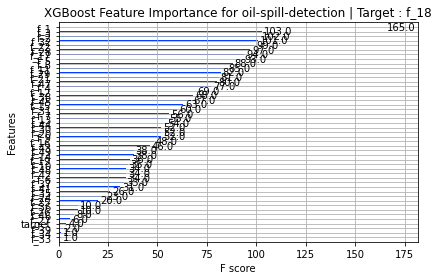

Target Variable: f_17
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:07,  5.10it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5820477114910143, 'Adjusted R-Squared': 0.43256112654984424, 'RMSE': 84.38325271921401, 'Time taken': 0.20615649223327637}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8404235307911249, 'Adjusted R-Squared': 0.7833487352346659, 'RMSE': 52.140757241074816, 'Time taken': 0.18791985511779785}


 10%|▉         | 4/42 [00:00<00:04,  8.13it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.6242188489332214, 'Adjusted R-Squared': 0.4898153715443737, 'RMSE': 80.01297243951002, 'Time taken': 0.04424691200256348}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.5475659614067383, 'Adjusted R-Squared': 0.38574648774929443, 'RMSE': 87.79515380689288, 'Time taken': 0.11330413818359375}
{'Model': 'DummyRegressor', 'R-Squared': -0.014472205207163524, 'Adjusted R-Squared': -0.3773126289673898, 'RMSE': 131.46585, 'Time taken': 0.014377593994140625}
{'Model': 'ElasticNet', 'R-Squared': 0.6892613872029545, 'Adjusted R-Squared': 0.5781212994142302, 'RMSE': 72.75963632116131, 'Time taken': 0.0208437442779541}


 17%|█▋        | 7/42 [00:00<00:03, 10.10it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.7434889831989026, 'Adjusted R-Squared': 0.6517441669707729, 'RMSE': 66.10676718872632, 'Time taken': 0.20261812210083008}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.664256447571422, 'Adjusted R-Squared': 0.5441729872137555, 'RMSE': 75.6304612361534, 'Time taken': 0.06268882751464844}


 26%|██▌       | 11/42 [00:01<00:05,  5.50it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.8761723668852885, 'Adjusted R-Squared': 0.8318836513917056, 'RMSE': 45.9305551023771, 'Time taken': 0.8430142402648926}
{'Model': 'GammaRegressor', 'R-Squared': 0.46431314642439525, 'Adjusted R-Squared': 0.2727171185031936, 'RMSE': 95.53189717387532, 'Time taken': 0.03090524673461914}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.14111106183333488, 'Adjusted R-Squared': -0.549245675189783, 'RMSE': 139.43020504114605, 'Time taken': 0.1618342399597168}


 29%|██▊       | 12/42 [00:02<00:08,  3.44it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8537232257105563, 'Adjusted R-Squared': 0.8014052553442589, 'RMSE': 49.920691857100046, 'Time taken': 0.7278268337249756}


 33%|███▎      | 14/42 [00:03<00:08,  3.37it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.5449452237239044, 'Adjusted R-Squared': 0.3821884059317243, 'RMSE': 88.049064666711, 'Time taken': 0.5471601486206055}
{'Model': 'HuberRegressor', 'R-Squared': 0.8507899867032545, 'Adjusted R-Squared': 0.7974229016555133, 'RMSE': 50.41872893766047, 'Time taken': 0.13494372367858887}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7843159791033082, 'Adjusted R-Squared': 0.7071735190745645, 'RMSE': 60.618046, 'Time taken': 0.03313922882080078}


 38%|███▊      | 16/42 [00:03<00:05,  4.98it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.32343698366788454, 'Adjusted R-Squared': 0.08145459096515717, 'RMSE': 107.361120441482, 'Time taken': 0.0780797004699707}
{'Model': 'Lars', 'R-Squared': -19970.026646532682, 'Adjusted R-Squared': -27112.948585803493, 'RMSE': 18445.613477925897, 'Time taken': 0.09342765808105469}


 43%|████▎     | 18/42 [00:03<00:04,  5.70it/s]

{'Model': 'LarsCV', 'R-Squared': 0.8471678310024159, 'Adjusted R-Squared': 0.7925052304120391, 'RMSE': 51.02703064187659, 'Time taken': 0.1670236587524414}
{'Model': 'Lasso', 'R-Squared': 0.7690822079644286, 'Adjusted R-Squared': 0.6864911728568155, 'RMSE': 62.72224672103364, 'Time taken': 0.04901432991027832}


 48%|████▊     | 20/42 [00:04<00:04,  5.21it/s]

{'Model': 'LassoCV', 'R-Squared': 0.7637295452650401, 'Adjusted R-Squared': 0.679224054155456, 'RMSE': 63.44503143573941, 'Time taken': 0.39155054092407227}
{'Model': 'LassoLars', 'R-Squared': 0.8246598857893281, 'Adjusted R-Squared': 0.7619469982249273, 'RMSE': 54.655459628039004, 'Time taken': 0.035741567611694336}


 57%|█████▋    | 24/42 [00:04<00:02,  6.98it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.7804027218105019, 'Adjusted R-Squared': 0.7018606296113383, 'RMSE': 61.165479514157525, 'Time taken': 0.2514817714691162}
{'Model': 'LassoLarsIC', 'R-Squared': 0.5400048208325909, 'Adjusted R-Squared': 0.3754809976267294, 'RMSE': 88.52573646487451, 'Time taken': 0.08625340461730957}
{'Model': 'LinearRegression', 'R-Squared': 0.4405074926664959, 'Adjusted R-Squared': 0.24039703383918432, 'RMSE': 97.63151887159205, 'Time taken': 0.050974369049072266}
{'Model': 'LinearSVR', 'R-Squared': 0.38713082382698905, 'Adjusted R-Squared': 0.16792943964832097, 'RMSE': 102.18256448415575, 'Time taken': 0.06287503242492676}


 64%|██████▍   | 27/42 [00:06<00:04,  3.15it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.4860503124010791, 'Adjusted R-Squared': 0.3022288912890564, 'RMSE': 93.57357271972052, 'Time taken': 1.6285693645477295}
{'Model': 'NuSVR', 'R-Squared': 0.03516119246604288, 'Adjusted R-Squared': -0.3099271401555914, 'RMSE': 128.20952463509386, 'Time taken': 0.10783171653747559}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.8080570876758758, 'Adjusted R-Squared': 0.7394059730489992, 'RMSE': 57.184581660305376, 'Time taken': 0.023386240005493164}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.8348343514092889, 'Adjusted R-Squared': 0.7757605062929032, 'RMSE': 53.04601599314774, 'Time taken': 0.04333376884460449}


 71%|███████▏  | 30/42 [00:06<00:02,  5.18it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.8478111615939276, 'Adjusted R-Squared': 0.7933786573465003, 'RMSE': 50.91952098400617, 'Time taken': 0.0334475040435791}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8500376745479552, 'Adjusted R-Squared': 0.7964015143497786, 'RMSE': 50.545673941890826, 'Time taken': 0.08733606338500977}


 76%|███████▌  | 32/42 [00:23<00:26,  2.67s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.05358527335364438, 'Adjusted R-Squared': -0.4304150426553126, 'RMSE': 133.97623038234272, 'Time taken': 17.072025775909424}


 79%|███████▊  | 33/42 [00:24<00:20,  2.27s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.7731446782058291, 'Adjusted R-Squared': 0.6920066434035343, 'RMSE': 62.16807132828388, 'Time taken': 0.3490767478942871}


 88%|████████▊ | 37/42 [00:26<00:06,  1.26s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8533172651750129, 'Adjusted R-Squared': 0.8008540972449081, 'RMSE': 49.98991607087366, 'Time taken': 1.8409357070922852}
{'Model': 'Ridge', 'R-Squared': 0.7059992272530646, 'Adjusted R-Squared': 0.6008456661975914, 'RMSE': 70.77292486755553, 'Time taken': 0.0190427303314209}
{'Model': 'RidgeCV', 'R-Squared': 0.8054138861926481, 'Adjusted R-Squared': 0.7358173929330842, 'RMSE': 57.57697322453833, 'Time taken': 0.05374765396118164}
{'Model': 'SGDRegressor', 'R-Squared': 0.7797391312241381, 'Adjusted R-Squared': 0.700959696406494, 'RMSE': 61.25782633107593, 'Time taken': 0.07679963111877441}


 93%|█████████▎| 39/42 [00:26<00:02,  1.14it/s]

{'Model': 'SVR', 'R-Squared': 0.02869435631336137, 'Adjusted R-Squared': -0.3187069323044873, 'RMSE': 128.63846952240556, 'Time taken': 0.08634209632873535}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.4405074926664959, 'Adjusted R-Squared': 0.24039703383918432, 'RMSE': 97.63151887159205, 'Time taken': 0.017534494400024414}
{'Model': 'TweedieRegressor', 'R-Squared': 0.5929309499861004, 'Adjusted R-Squared': 0.44733691020010713, 'RMSE': 83.27736021724988, 'Time taken': 0.042084693908691406}


 98%|█████████▊| 41/42 [00:26<00:00,  1.37it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.8760305124562635, 'Adjusted R-Squared': 0.8316910607070439, 'RMSE': 45.956856, 'Time taken': 0.7451944351196289}


100%|██████████| 42/42 [00:27<00:00,  1.55it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.5282209079858393, 'Adjusted R-Squared': 0.3594824006231103, 'RMSE': 89.65246880110932, 'Time taken': 0.2305433750152588}
Project: oil-spill-detection
oil-spill-detection
Target: f_17
f_17
Target Standard Deviation: 333.5993957519531
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
ExtraTreesRegressor                          0.83       0.88    45.93   
XGBRegressor                                 0.83       0.88    45.96   
GradientBoostingRegressor                    0.80       0.85    49.92   
RandomForestRegressor                        0.80       0.85    49.99   
HuberRegressor                               0.80       0.85    50.42   
PoissonRegressor                             0.80       0.85    50.55   
PassiveAggressiveRegressor                   0.79       0.85    50.92   
LarsCV                                       0.79       0.85    51.0

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 144.02508544921875.
Better model found at epoch 1 with _rmse value: 138.5284423828125.
Better model found at epoch 2 with _rmse value: 128.97808837890625.
No improvement since epoch 2: early stopping


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   11.67      11.65
1   95.17      71.78
2   30.67      36.93
3   19.32      20.10
4   39.56      68.26
XGBoost RMSE:  45.952766


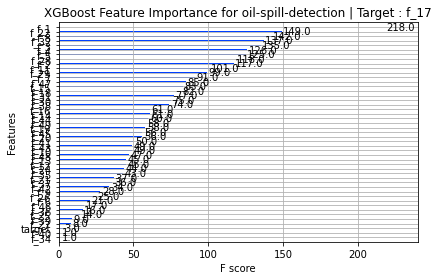

Target Variable: f_16
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:08,  4.62it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9631382065145179, 'Adjusted R-Squared': 0.9499540613992724, 'RMSE': 0.04181545566411912, 'Time taken': 0.321047306060791}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9854959944921724, 'Adjusted R-Squared': 0.9803084304784239, 'RMSE': 0.02622965515034071, 'Time taken': 0.14193201065063477}
{'Model': 'BayesianRidge', 'R-Squared': 0.9994340254352919, 'Adjusted R-Squared': 0.9992315965763817, 'RMSE': 0.005181399273504976, 'Time taken': 0.025661230087280273}


 12%|█▏        | 5/42 [00:00<00:03, 11.22it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9507458021008929, 'Adjusted R-Squared': 0.9331293371588765, 'RMSE': 0.04833594662066206, 'Time taken': 0.06325364112854004}
{'Model': 'DummyRegressor', 'R-Squared': -0.01252766009234807, 'Adjusted R-Squared': -0.37467258961442873, 'RMSE': 0.21915534, 'Time taken': 0.025174856185913086}
{'Model': 'ElasticNet', 'R-Squared': -0.012527648649751644, 'Adjusted R-Squared': -0.3746725740792247, 'RMSE': 0.21915533552152297, 'Time taken': 0.028392553329467773}


 17%|█▋        | 7/42 [00:00<00:03, 10.46it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9994433075782493, 'Adjusted R-Squared': 0.9992441986098859, 'RMSE': 0.005138735418668144, 'Time taken': 0.17586994171142578}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8274806609564369, 'Adjusted R-Squared': 0.7657766637802721, 'RMSE': 0.09046227295269904, 'Time taken': 0.047817230224609375}


 26%|██▌       | 11/42 [00:01<00:05,  6.06it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9914549481227884, 'Adjusted R-Squared': 0.9883986886922529, 'RMSE': 0.020132882302971628, 'Time taken': 0.7308685779571533}
{'Model': 'GammaRegressor', 'R-Squared': 0.7028591017102046, 'Adjusted R-Squared': 0.5965824300591099, 'RMSE': 0.11872162128579172, 'Time taken': 0.027654170989990234}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.4277827268467989, 'Adjusted R-Squared': -2.2961137751350695, 'RMSE': 0.3393544209953109, 'Time taken': 0.15077733993530273}


 29%|██▊       | 12/42 [00:02<00:08,  3.68it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9935622544362688, 'Adjusted R-Squared': 0.9912597031032554, 'RMSE': 0.017474932502403045, 'Time taken': 0.7005085945129395}


 33%|███▎      | 14/42 [00:03<00:08,  3.48it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9902508529711106, 'Adjusted R-Squared': 0.9867639317709969, 'RMSE': 0.021504626940820833, 'Time taken': 0.533013105392456}
{'Model': 'HuberRegressor', 'R-Squared': 0.9994494941257083, 'Adjusted R-Squared': 0.9992525978641003, 'RMSE': 0.005110102148938456, 'Time taken': 0.14979767799377441}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.6501033359093485, 'Adjusted R-Squared': 0.5249578137163419, 'RMSE': 0.12883045, 'Time taken': 0.03316354751586914}


 38%|███▊      | 16/42 [00:03<00:05,  5.11it/s]

{'Model': 'KernelRidge', 'R-Squared': -0.8575518758231848, 'Adjusted R-Squared': -1.5219317438183384, 'RMSE': 0.2968377140226236, 'Time taken': 0.08144330978393555}
{'Model': 'Lars', 'R-Squared': 0.9523722103209623, 'Adjusted R-Squared': 0.9353374534284598, 'RMSE': 0.047531204104877274, 'Time taken': 0.07668495178222656}


 43%|████▎     | 18/42 [00:03<00:04,  5.88it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9994167788665363, 'Adjusted R-Squared': 0.9992081815268303, 'RMSE': 0.005259751535901396, 'Time taken': 0.16867733001708984}
{'Model': 'Lasso', 'R-Squared': -0.012527648649751644, 'Adjusted R-Squared': -0.3746725740792247, 'RMSE': 0.21915533552152297, 'Time taken': 0.02962207794189453}


 48%|████▊     | 20/42 [00:03<00:03,  6.43it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9994446738096995, 'Adjusted R-Squared': 0.9992460534934606, 'RMSE': 0.005132425817077737, 'Time taken': 0.2206284999847412}
{'Model': 'LassoLars', 'R-Squared': -0.012527648649751644, 'Adjusted R-Squared': -0.3746725740792247, 'RMSE': 0.21915533552152297, 'Time taken': 0.02766561508178711}


 52%|█████▏    | 22/42 [00:03<00:02,  7.26it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9994403379765252, 'Adjusted R-Squared': 0.9992401668878371, 'RMSE': 0.00515242313962006, 'Time taken': 0.17219209671020508}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9994506279517925, 'Adjusted R-Squared': 0.999254137219222, 'RMSE': 0.005104837033904034, 'Time taken': 0.06094980239868164}
{'Model': 'LinearRegression', 'R-Squared': 0.9994319316017385, 'Adjusted R-Squared': 0.9992287538534552, 'RMSE': 0.005190974767562107, 'Time taken': 0.02805042266845703}


 60%|█████▉    | 25/42 [00:04<00:02,  8.17it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.998068268921478, 'Adjusted R-Squared': 0.9973773578058023, 'RMSE': 0.009572424205939544, 'Time taken': 0.21071934700012207}


 62%|██████▏   | 26/42 [00:04<00:02,  5.98it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.7764178216420243, 'Adjusted R-Squared': 0.6964504731782228, 'RMSE': 0.10298339251225638, 'Time taken': 0.39214110374450684}


 71%|███████▏  | 30/42 [00:05<00:01,  6.83it/s]

{'Model': 'NuSVR', 'R-Squared': 0.9522901144748802, 'Adjusted R-Squared': 0.935225994834509, 'RMSE': 0.047572151148348674, 'Time taken': 0.5295805931091309}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9994455177197753, 'Adjusted R-Squared': 0.999247199239987, 'RMSE': 0.005128524549028657, 'Time taken': 0.023901939392089844}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.999447328081568, 'Adjusted R-Squared': 0.9992496571034427, 'RMSE': 0.005120145493475492, 'Time taken': 0.050662994384765625}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.977992403265047, 'Adjusted R-Squared': 0.9701210730459762, 'RMSE': 0.03230984782524381, 'Time taken': 0.03199028968811035}
{'Model': 'PoissonRegressor', 'R-Squared': 0.5303004768366872, 'Adjusted R-Squared': 0.3623057568731667, 'RMSE': 0.14926523273873246, 'Time taken': 0.07290458679199219}


 76%|███████▌  | 32/42 [00:17<00:19,  2.00s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.07959018718224531, 'Adjusted R-Squared': -0.46572098405764684, 'RMSE': 0.2262966198509504, 'Time taken': 12.581742763519287}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9993927886385344, 'Adjusted R-Squared': 0.9991756108523168, 'RMSE': 0.005366838755923117, 'Time taken': 0.056806087493896484}


 88%|████████▊ | 37/42 [00:19<00:04,  1.00it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9882094821235773, 'Adjusted R-Squared': 0.9839924355838349, 'RMSE': 0.02364912317901314, 'Time taken': 1.3122587203979492}
{'Model': 'Ridge', 'R-Squared': 0.9994318472283539, 'Adjusted R-Squared': 0.9992286393027286, 'RMSE': 0.005191360252699643, 'Time taken': 0.02093338966369629}
{'Model': 'RidgeCV', 'R-Squared': 0.9994318472283676, 'Adjusted R-Squared': 0.9992286393027473, 'RMSE': 0.0051913602526364, 'Time taken': 0.05369687080383301}
{'Model': 'SGDRegressor', 'R-Squared': 0.9935793141187841, 'Adjusted R-Squared': 0.9912828644240427, 'RMSE': 0.017451763323220935, 'Time taken': 0.0660696029663086}
{'Model': 'SVR', 'R-Squared': 0.8674664918888474, 'Adjusted R-Squared': 0.8200639962870483, 'RMSE': 0.07928872781739002, 'Time taken': 0.04580545425415039}


 95%|█████████▌| 40/42 [00:19<00:01,  1.53it/s]

{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9994319316017385, 'Adjusted R-Squared': 0.9992287538534552, 'RMSE': 0.005190974767562107, 'Time taken': 0.025719165802001953}
{'Model': 'TweedieRegressor', 'R-Squared': 0.7370098508853002, 'Adjusted R-Squared': 0.6429476807639842, 'RMSE': 0.1116910422192383, 'Time taken': 0.03174567222595215}
{'Model': 'XGBRegressor', 'R-Squared': 0.9909332666591656, 'Adjusted R-Squared': 0.9876904204277722, 'RMSE': 0.020738343, 'Time taken': 0.6651434898376465}


100%|██████████| 42/42 [00:20<00:00,  2.05it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9895388861408195, 'Adjusted R-Squared': 0.9857973198700177, 'RMSE': 0.022276018367674538, 'Time taken': 0.2224562168121338}
Project: oil-spill-detection
oil-spill-detection
Target: f_16
f_16
Target Standard Deviation: 0.20086197555065155
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LassoLarsIC                                  1.00       1.00  0.01        0.06
HuberRegressor                               1.00       1.00  0.01        0.15
OrthogonalMatchingPursuitCV                  1.00       1.00  0.01        0.05
OrthogonalMatchingPursuit                    1.00       1.00  0.01        0.02
LassoCV                                      1.00       1.00  0.01        0.22
ElasticNetCV                                 1.00       1.00  0.01        0.18
LassoLarsCV                                  1.00       1.00  0.01        0.17
BayesianR

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.9842243790626526.
Better model found at epoch 1 with _rmse value: 0.6639282703399658.
Better model found at epoch 2 with _rmse value: 0.34760648012161255.
Better model found at epoch 3 with _rmse value: 0.2948199212551117.
No improvement since epoch 3: early stopping


<Figure size 432x288 with 0 Axes>

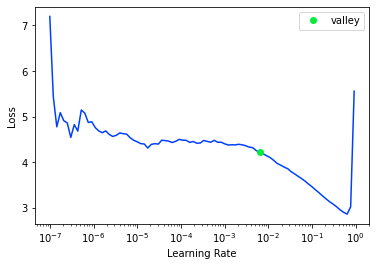

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.16       0.15
1    0.62       0.60
2    0.29       0.29
3    0.12       0.15
4    0.60       0.62
XGBoost RMSE:  0.020927995


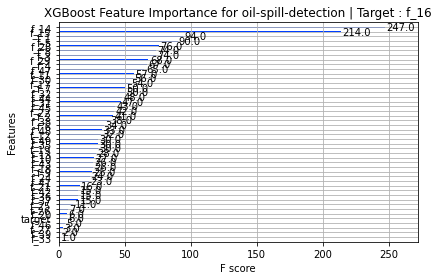

Target Variable: f_15
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:08,  4.65it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.791378426539902, 'Adjusted R-Squared': 0.7167619513607428, 'RMSE': 0.03283478250905123, 'Time taken': 0.30681610107421875}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8635897123017693, 'Adjusted R-Squared': 0.8148006313002123, 'RMSE': 0.02655082975996369, 'Time taken': 0.14947104454040527}
{'Model': 'BayesianRidge', 'R-Squared': 0.9947277419286106, 'Adjusted R-Squared': 0.9928420437862888, 'RMSE': 0.005219788014424892, 'Time taken': 0.042798757553100586}


 10%|▉         | 4/42 [00:00<00:04,  8.16it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.6776650824137507, 'Adjusted R-Squared': 0.5623774111602746, 'RMSE': 0.04081391095204222, 'Time taken': 0.0904085636138916}
{'Model': 'DummyRegressor', 'R-Squared': -0.004740415695761557, 'Adjusted R-Squared': -0.3641001264190631, 'RMSE': 0.07205788, 'Time taken': 0.018539905548095703}
{'Model': 'ElasticNet', 'R-Squared': -0.004740410993580246, 'Adjusted R-Squared': -0.36410012003507974, 'RMSE': 0.07205787834181226, 'Time taken': 0.017759323120117188}


 17%|█▋        | 7/42 [00:00<00:04,  8.43it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9949053306948579, 'Adjusted R-Squared': 0.9930831497025078, 'RMSE': 0.005131124297855161, 'Time taken': 0.30824947357177734}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.7332328991761419, 'Adjusted R-Squared': 0.6378198485165139, 'RMSE': 0.03712963416158032, 'Time taken': 0.03857088088989258}


 26%|██▌       | 11/42 [00:01<00:05,  5.74it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.8639920478888509, 'Adjusted R-Squared': 0.8153468679366881, 'RMSE': 0.02651164564760054, 'Time taken': 0.730116605758667}
{'Model': 'GammaRegressor', 'R-Squared': 0.6900466419633258, 'Adjusted R-Squared': 0.579187411716632, 'RMSE': 0.04002236133344235, 'Time taken': 0.03729248046875}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -2.7477928331716157, 'Adjusted R-Squared': -4.088244284451974, 'RMSE': 0.13916894142726685, 'Time taken': 0.15502095222473145}


 29%|██▊       | 12/42 [00:02<00:08,  3.56it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8817320760916969, 'Adjusted R-Squared': 0.839431869730333, 'RMSE': 0.024722251617234056, 'Time taken': 0.7182631492614746}


 33%|███▎      | 14/42 [00:03<00:08,  3.48it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.8843878675868742, 'Adjusted R-Squared': 0.8430375428551722, 'RMSE': 0.024443097576219843, 'Time taken': 0.5110297203063965}
{'Model': 'HuberRegressor', 'R-Squared': 0.9947889895961214, 'Adjusted R-Squared': 0.9929251975538582, 'RMSE': 0.005189380383108402, 'Time taken': 0.14341998100280762}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7106249672012008, 'Adjusted R-Squared': 0.6071258678790026, 'RMSE': 0.03867097, 'Time taken': 0.0337979793548584}


 38%|███▊      | 16/42 [00:03<00:05,  5.14it/s]

{'Model': 'KernelRidge', 'R-Squared': -5.505055108496807, 'Adjusted R-Squared': -7.831680658251138, 'RMSE': 0.18334962485479886, 'Time taken': 0.07729291915893555}
{'Model': 'Lars', 'R-Squared': -207279.98930189433, 'Adjusted R-Squared': -281416.98547556455, 'RMSE': 32.72911575014411, 'Time taken': 0.05030012130737305}


 43%|████▎     | 18/42 [00:03<00:03,  6.05it/s]

{'Model': 'LarsCV', 'R-Squared': 0.6867199566253528, 'Adjusted R-Squared': 0.5746708900169024, 'RMSE': 0.04023656527020675, 'Time taken': 0.1729426383972168}
{'Model': 'Lasso', 'R-Squared': -0.004740410993580246, 'Adjusted R-Squared': -0.36410012003507974, 'RMSE': 0.07205787834181226, 'Time taken': 0.04690670967102051}


 48%|████▊     | 20/42 [00:04<00:03,  5.59it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9949553559013465, 'Adjusted R-Squared': 0.9931510671361348, 'RMSE': 0.005105870571184857, 'Time taken': 0.35268211364746094}
{'Model': 'LassoLars', 'R-Squared': -0.004740410993580246, 'Adjusted R-Squared': -0.36410012003507974, 'RMSE': 0.07205787834181226, 'Time taken': 0.0466616153717041}


 55%|█████▍    | 23/42 [00:04<00:03,  5.47it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9949987473014245, 'Adjusted R-Squared': 0.9932099780880653, 'RMSE': 0.005083864127848573, 'Time taken': 0.3207573890686035}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9949656488857159, 'Adjusted R-Squared': 0.9931650415528698, 'RMSE': 0.005100658956630645, 'Time taken': 0.1890401840209961}
{'Model': 'LinearRegression', 'R-Squared': 0.9947195723020046, 'Adjusted R-Squared': 0.9928309521764441, 'RMSE': 0.005223830609799368, 'Time taken': 0.07813453674316406}


 60%|█████▉    | 25/42 [00:04<00:02,  5.72it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.9868218359626361, 'Adjusted R-Squared': 0.982108478022265, 'RMSE': 0.008252432680622269, 'Time taken': 0.23494648933410645}


 62%|██████▏   | 26/42 [00:05<00:03,  4.05it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.47784114287768475, 'Adjusted R-Squared': -1.006412062593061, 'RMSE': 0.08739134274016942, 'Time taken': 0.532090425491333}


 74%|███████▍  | 31/42 [00:06<00:01,  6.76it/s]

{'Model': 'NuSVR', 'R-Squared': 0.9539824990093391, 'Adjusted R-Squared': 0.9375236847864019, 'RMSE': 0.015421124764002762, 'Time taken': 0.45272278785705566}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.816880030340348, 'Adjusted R-Squared': 0.7513845667394505, 'RMSE': 0.030762554031447644, 'Time taken': 0.020386695861816406}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9949119384642012, 'Adjusted R-Squared': 0.993092120834609, 'RMSE': 0.00512779569253291, 'Time taken': 0.04559898376464844}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.4753409281828519, 'Adjusted R-Squared': 0.2876891433723391, 'RMSE': 0.0520706655778096, 'Time taken': 0.029849767684936523}
{'Model': 'PoissonRegressor', 'R-Squared': 0.5644951640461366, 'Adjusted R-Squared': 0.4087306606757768, 'RMSE': 0.04744069323413214, 'Time taken': 0.035364627838134766}


 79%|███████▊  | 33/42 [00:17<00:15,  1.71s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.0002213453755632866, 'Adjusted R-Squared': -0.35796474627631203, 'RMSE': 0.07189564675559465, 'Time taken': 11.07400918006897}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9946005283360677, 'Adjusted R-Squared': 0.9926693304416686, 'RMSE': 0.005282386432858914, 'Time taken': 0.13414883613586426}


 88%|████████▊ | 37/42 [00:18<00:04,  1.02it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8610312535916249, 'Adjusted R-Squared': 0.8113271034163667, 'RMSE': 0.026798661656394246, 'Time taken': 1.4135737419128418}
{'Model': 'Ridge', 'R-Squared': 0.9922557803197525, 'Adjusted R-Squared': 0.9894859499231676, 'RMSE': 0.006326206553252222, 'Time taken': 0.020827531814575195}
{'Model': 'RidgeCV', 'R-Squared': 0.994744452746086, 'Adjusted R-Squared': 0.992864731465489, 'RMSE': 0.005211509194286233, 'Time taken': 0.051038265228271484}
{'Model': 'SGDRegressor', 'R-Squared': 0.8353859436913961, 'Adjusted R-Squared': 0.776509383405837, 'RMSE': 0.029166746966440726, 'Time taken': 0.06072378158569336}
{'Model': 'SVR', 'R-Squared': 0.45652024343404873, 'Adjusted R-Squared': 0.26213697283746773, 'RMSE': 0.05299638198891716, 'Time taken': 0.04448580741882324}


 95%|█████████▌| 40/42 [00:18<00:01,  1.59it/s]

{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9947195723020046, 'Adjusted R-Squared': 0.9928309521764441, 'RMSE': 0.005223830609799368, 'Time taken': 0.022908687591552734}
{'Model': 'TweedieRegressor', 'R-Squared': 0.7370785287944789, 'Adjusted R-Squared': 0.6430409223049129, 'RMSE': 0.03686103815478861, 'Time taken': 0.05228137969970703}
{'Model': 'XGBRegressor', 'R-Squared': 0.8322269227727674, 'Adjusted R-Squared': 0.7722204936914945, 'RMSE': 0.02944528, 'Time taken': 0.6480803489685059}


100%|██████████| 42/42 [00:19<00:00,  2.12it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.887168167928547, 'Adjusted R-Squared': 0.8468122571876624, 'RMSE': 0.024147398853708087, 'Time taken': 0.21591734886169434}
Project: oil-spill-detection
oil-spill-detection
Target: f_15
f_15
Target Standard Deviation: 0.08539484441280365
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LassoLarsCV                                  0.99       0.99  0.01        0.32
LassoLarsIC                                  0.99       0.99  0.01        0.19
LassoCV                                      0.99       0.99  0.01        0.35
OrthogonalMatchingPursuitCV                  0.99       0.99  0.01        0.05
ElasticNetCV                                 0.99       0.99  0.01        0.31
HuberRegressor                               0.99       0.99  0.01        0.14
RidgeCV                                      0.99       0.99  0.01        0.05
BayesianR

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.1578751802444458.
Better model found at epoch 1 with _rmse value: 0.4996066689491272.
Better model found at epoch 2 with _rmse value: 0.4761386513710022.
No improvement since epoch 2: early stopping


<Figure size 432x288 with 0 Axes>

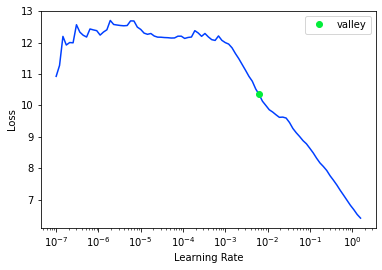

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.17       0.12
1    0.09       0.08
2    0.18       0.17
3    0.10       0.13
4    0.13       0.16
XGBoost RMSE:  0.029446159


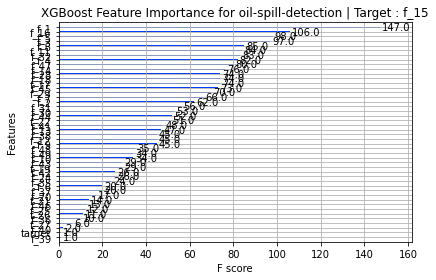

Target Variable: f_14
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:09,  4.40it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9716718881323224, 'Adjusted R-Squared': 0.9615399357124961, 'RMSE': 0.038070779741837035, 'Time taken': 0.34670519828796387}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9844163175134002, 'Adjusted R-Squared': 0.9788425916605288, 'RMSE': 0.028236964183309062, 'Time taken': 0.14196395874023438}
{'Model': 'BayesianRidge', 'R-Squared': 0.9995475575779046, 'Adjusted R-Squared': 0.9993857351057682, 'RMSE': 0.004811324144291053, 'Time taken': 0.045816898345947266}


 10%|▉         | 4/42 [00:00<00:05,  7.49it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9704526654612275, 'Adjusted R-Squared': 0.9598846406991849, 'RMSE': 0.03888141951534328, 'Time taken': 0.10854196548461914}
{'Model': 'DummyRegressor', 'R-Squared': -0.030758710306123094, 'Adjusted R-Squared': -0.3994242344302108, 'RMSE': 0.22964734, 'Time taken': 0.013622760772705078}
{'Model': 'ElasticNet', 'R-Squared': -0.03075871869405855, 'Adjusted R-Squared': -0.3994242458182107, 'RMSE': 0.2296473646364603, 'Time taken': 0.01845550537109375}


 17%|█▋        | 7/42 [00:00<00:03,  8.95it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.999586096270483, 'Adjusted R-Squared': 0.9994380577102908, 'RMSE': 0.00460185178879889, 'Time taken': 0.25237488746643066}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9623524980572831, 'Adjusted R-Squared': 0.9488873331288661, 'RMSE': 0.04388853048468521, 'Time taken': 0.03853893280029297}


 26%|██▌       | 11/42 [00:01<00:05,  5.93it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9906488640318122, 'Adjusted R-Squared': 0.9873042971526793, 'RMSE': 0.021873341997941543, 'Time taken': 0.7223308086395264}
{'Model': 'GammaRegressor', 'R-Squared': 0.8423577274289671, 'Adjusted R-Squared': 0.7859747248305684, 'RMSE': 0.08980888426152069, 'Time taken': 0.026894092559814453}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -3.3598999323748906, 'Adjusted R-Squared': -4.91928020015861, 'RMSE': 0.47230355905920046, 'Time taken': 0.15662407875061035}


 29%|██▊       | 12/42 [00:02<00:08,  3.65it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9911049289904108, 'Adjusted R-Squared': 0.9879234802351563, 'RMSE': 0.021333281652662395, 'Time taken': 0.7074127197265625}


 33%|███▎      | 14/42 [00:03<00:08,  3.45it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9869359718208917, 'Adjusted R-Squared': 0.9822634361947872, 'RMSE': 0.025853628960079728, 'Time taken': 0.5464694499969482}
{'Model': 'HuberRegressor', 'R-Squared': 0.9995839992866806, 'Adjusted R-Squared': 0.9994352107103839, 'RMSE': 0.004613494371655226, 'Time taken': 0.14762234687805176}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8484341987689731, 'Adjusted R-Squared': 0.7942245326352482, 'RMSE': 0.08806099, 'Time taken': 0.033640384674072266}


 38%|███▊      | 16/42 [00:03<00:05,  5.09it/s]

{'Model': 'KernelRidge', 'R-Squared': -3.4351483754114787, 'Adjusted R-Squared': -5.021442319901715, 'RMSE': 0.4763619168962952, 'Time taken': 0.07769966125488281}
{'Model': 'Lars', 'R-Squared': 0.7906872635784937, 'Adjusted R-Squared': 0.7158235841284659, 'RMSE': 0.10348580567908129, 'Time taken': 0.09684562683105469}


 43%|████▎     | 18/42 [00:03<00:04,  5.67it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9995907588409622, 'Adjusted R-Squared': 0.9994443879154669, 'RMSE': 0.004575858755197458, 'Time taken': 0.18356108665466309}
{'Model': 'Lasso', 'R-Squared': -0.03075871869405855, 'Adjusted R-Squared': -0.3994242458182107, 'RMSE': 0.2296473646364603, 'Time taken': 0.047650814056396484}


 48%|████▊     | 20/42 [00:04<00:03,  5.74it/s]

{'Model': 'LassoCV', 'R-Squared': 0.999590594707965, 'Adjusted R-Squared': 0.9994441650779671, 'RMSE': 0.004576776275473411, 'Time taken': 0.2864193916320801}
{'Model': 'LassoLars', 'R-Squared': -0.03075871869405855, 'Adjusted R-Squared': -0.3994242458182107, 'RMSE': 0.2296473646364603, 'Time taken': 0.06535649299621582}


 57%|█████▋    | 24/42 [00:04<00:02,  7.71it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9995911923057607, 'Adjusted R-Squared': 0.9994449764151203, 'RMSE': 0.0045734347575774915, 'Time taken': 0.2041323184967041}
{'Model': 'LassoLarsIC', 'R-Squared': 0.999587399870512, 'Adjusted R-Squared': 0.9994398275614251, 'RMSE': 0.0045945992507933475, 'Time taken': 0.07622575759887695}
{'Model': 'LinearRegression', 'R-Squared': 0.9995472090926752, 'Adjusted R-Squared': 0.9993852619798365, 'RMSE': 0.004813176703405398, 'Time taken': 0.04480862617492676}
{'Model': 'LinearSVR', 'R-Squared': 0.9991322979041639, 'Adjusted R-Squared': 0.9988219518990838, 'RMSE': 0.0066629764869279165, 'Time taken': 0.24842476844787598}


 62%|██████▏   | 26/42 [00:05<00:03,  4.38it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.5989324236760747, 'Adjusted R-Squared': 0.4554848963777365, 'RMSE': 0.14324904463800084, 'Time taken': 0.631537914276123}


 74%|███████▍  | 31/42 [00:05<00:01,  6.54it/s]

{'Model': 'NuSVR', 'R-Squared': 0.9172111533053383, 'Adjusted R-Squared': 0.887600543903598, 'RMSE': 0.06508319635250324, 'Time taken': 0.49317455291748047}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9995923844963406, 'Adjusted R-Squared': 0.9994465950096303, 'RMSE': 0.004566761220261706, 'Time taken': 0.02062535285949707}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9996074095711049, 'Adjusted R-Squared': 0.9994669940162446, 'RMSE': 0.0044818034981308034, 'Time taken': 0.045168161392211914}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9620945555907237, 'Adjusted R-Squared': 0.9485371338676978, 'RMSE': 0.044038625316384666, 'Time taken': 0.031034469604492188}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8028687036318907, 'Adjusted R-Squared': 0.7323618896024209, 'RMSE': 0.10042937186719555, 'Time taken': 0.03786349296569824}


 79%|███████▊  | 33/42 [00:18<00:15,  1.75s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.1816951192928984, 'Adjusted R-Squared': -0.6043451984560517, 'RMSE': 0.24588706232268592, 'Time taken': 12.215473413467407}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9995448925756486, 'Adjusted R-Squared': 0.9993821169275229, 'RMSE': 0.004825473307786231, 'Time taken': 0.05427098274230957}


 88%|████████▊ | 37/42 [00:19<00:05,  1.02s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9867706786502775, 'Adjusted R-Squared': 0.9820390235689899, 'RMSE': 0.02601667192262242, 'Time taken': 1.3150444030761719}
{'Model': 'Ridge', 'R-Squared': 0.9995165134672184, 'Adjusted R-Squared': 0.9993435876270264, 'RMSE': 0.004973649174499078, 'Time taken': 0.020397186279296875}
{'Model': 'RidgeCV', 'R-Squared': 0.9995165134672588, 'Adjusted R-Squared': 0.9993435876270813, 'RMSE': 0.004973649174290767, 'Time taken': 0.054772138595581055}
{'Model': 'SGDRegressor', 'R-Squared': 0.9884027356153334, 'Adjusted R-Squared': 0.984254808937606, 'RMSE': 0.02435907185109719, 'Time taken': 0.06708526611328125}
{'Model': 'SVR', 'R-Squared': 0.8333804009002895, 'Adjusted R-Squared': 0.7737865296894442, 'RMSE': 0.09233067276672108, 'Time taken': 0.03663969039916992}


 95%|█████████▌| 40/42 [00:19<00:01,  1.52it/s]

{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9995472090926752, 'Adjusted R-Squared': 0.9993852619798365, 'RMSE': 0.004813176703405398, 'Time taken': 0.023883342742919922}
{'Model': 'TweedieRegressor', 'R-Squared': 0.8833343730131866, 'Adjusted R-Squared': 0.8416072509522096, 'RMSE': 0.07725994900439087, 'Time taken': 0.03255724906921387}
{'Model': 'XGBRegressor', 'R-Squared': 0.9879020313170332, 'Adjusted R-Squared': 0.9835750206202057, 'RMSE': 0.024879357, 'Time taken': 0.6969683170318604}


100%|██████████| 42/42 [00:20<00:00,  2.03it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9852452763598067, 'Adjusted R-Squared': 0.9799680394374018, 'RMSE': 0.027475683007717144, 'Time taken': 0.24034953117370605}
Project: oil-spill-detection
oil-spill-detection
Target: f_14
f_14
Target Standard Deviation: 0.21358732879161835
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
OrthogonalMatchingPursuitCV                  1.00       1.00  0.00        0.05
OrthogonalMatchingPursuit                    1.00       1.00  0.00        0.02
LassoLarsCV                                  1.00       1.00  0.00        0.20
LarsCV                                       1.00       1.00  0.00        0.18
LassoCV                                      1.00       1.00  0.00        0.29
LassoLarsIC                                  1.00       1.00  0.00        0.08
ElasticNetCV                                 1.00       1.00  0.00        0.25
HuberReg

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 2.0963263511657715.
Better model found at epoch 1 with _rmse value: 0.9596652984619141.
Better model found at epoch 2 with _rmse value: 0.43798592686653137.
No improvement since epoch 2: early stopping


<Figure size 432x288 with 0 Axes>

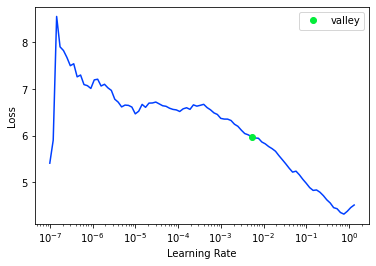

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.55       0.54
1    0.28       0.30
2    0.46       0.44
3    0.38       0.37
4    0.08       0.09
XGBoost RMSE:  0.02489863


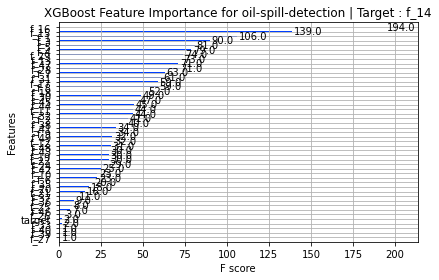

Target Variable: f_13
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:08,  4.65it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9625315078758936, 'Adjusted R-Squared': 0.9491303683570527, 'RMSE': 0.02289919915233088, 'Time taken': 0.31497788429260254}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9786035844451657, 'Adjusted R-Squared': 0.9709508518744585, 'RMSE': 0.017304445932859323, 'Time taken': 0.14348578453063965}
{'Model': 'BayesianRidge', 'R-Squared': 0.9903798932046296, 'Adjusted R-Squared': 0.986939125080738, 'RMSE': 0.011603182762417213, 'Time taken': 0.04381251335144043}


 10%|▉         | 4/42 [00:00<00:04,  7.73it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9586561130476976, 'Adjusted R-Squared': 0.943868883407823, 'RMSE': 0.02405430639159801, 'Time taken': 0.11142492294311523}
{'Model': 'DummyRegressor', 'R-Squared': -0.029040033745866944, 'Adjusted R-Squared': -0.39709084873526446, 'RMSE': 0.12000609, 'Time taken': 0.012671947479248047}
{'Model': 'ElasticNet', 'R-Squared': -0.029040045730863717, 'Adjusted R-Squared': -0.39709086500686586, 'RMSE': 0.1200061005793406, 'Time taken': 0.01930856704711914}


 17%|█▋        | 7/42 [00:00<00:04,  8.07it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9897957939037594, 'Adjusted R-Squared': 0.9861461143510893, 'RMSE': 0.011950244666834212, 'Time taken': 0.3242197036743164}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9350419634541378, 'Adjusted R-Squared': 0.9118087970983185, 'RMSE': 0.03015113261438037, 'Time taken': 0.058695077896118164}


 26%|██▌       | 11/42 [00:01<00:05,  5.93it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9887618379815992, 'Adjusted R-Squared': 0.9847423493764778, 'RMSE': 0.012541076895422746, 'Time taken': 0.6479587554931641}
{'Model': 'GammaRegressor', 'R-Squared': 0.9343604687947722, 'Adjusted R-Squared': 0.9108835561739244, 'RMSE': 0.03030888232785843, 'Time taken': 0.025985002517700195}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -3.713616299646307, 'Adjusted R-Squared': -5.399508260833672, 'RMSE': 0.2568409689956544, 'Time taken': 0.1617870330810547}


 29%|██▊       | 12/42 [00:02<00:08,  3.66it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9849693497034608, 'Adjusted R-Squared': 0.9795934236849906, 'RMSE': 0.014503608611827758, 'Time taken': 0.7051780223846436}


 33%|███▎      | 14/42 [00:03<00:07,  3.52it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9802295481619613, 'Adjusted R-Squared': 0.9731583646578452, 'RMSE': 0.01663395352342921, 'Time taken': 0.5223798751831055}
{'Model': 'HuberRegressor', 'R-Squared': 0.9920758089939682, 'Adjusted R-Squared': 0.9892416092910808, 'RMSE': 0.010530879755565338, 'Time taken': 0.14261960983276367}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8912999687833225, 'Adjusted R-Squared': 0.8524218554284525, 'RMSE': 0.03900336, 'Time taken': 0.037353515625}


 38%|███▊      | 16/42 [00:03<00:05,  5.13it/s]

{'Model': 'KernelRidge', 'R-Squared': -6.067154653584903, 'Adjusted R-Squared': -8.594823106326947, 'RMSE': 0.31449191417852895, 'Time taken': 0.08331632614135742}
{'Model': 'Lars', 'R-Squared': -150.18505031937605, 'Adjusted R-Squared': -204.25853547010178, 'RMSE': 1.4545933931785338, 'Time taken': 0.08264875411987305}


 43%|████▎     | 18/42 [00:03<00:03,  6.13it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9813160539026992, 'Adjusted R-Squared': 0.9746334746416208, 'RMSE': 0.016170427035798882, 'Time taken': 0.12723898887634277}
{'Model': 'Lasso', 'R-Squared': -0.029040045730863717, 'Adjusted R-Squared': -0.39709086500686586, 'RMSE': 0.1200061005793406, 'Time taken': 0.03649282455444336}


 48%|████▊     | 20/42 [00:03<00:03,  6.60it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9897772328917486, 'Adjusted R-Squared': 0.9861209147289434, 'RMSE': 0.011961108219532017, 'Time taken': 0.21830487251281738}
{'Model': 'LassoLars', 'R-Squared': -0.029040045730863717, 'Adjusted R-Squared': -0.39709086500686586, 'RMSE': 0.1200061005793406, 'Time taken': 0.02131366729736328}


 57%|█████▋    | 24/42 [00:04<00:02,  8.16it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.989797533042946, 'Adjusted R-Squared': 0.9861484755181603, 'RMSE': 0.01194922626206045, 'Time taken': 0.23389291763305664}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9902063434088184, 'Adjusted R-Squared': 0.9867035027302207, 'RMSE': 0.011707377495831743, 'Time taken': 0.0943918228149414}
{'Model': 'LinearRegression', 'R-Squared': 0.9899598835044947, 'Adjusted R-Squared': 0.9863688929331096, 'RMSE': 0.011853771799029968, 'Time taken': 0.05252861976623535}


 60%|█████▉    | 25/42 [00:04<00:02,  6.95it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.9798088914827965, 'Adjusted R-Squared': 0.9725872541299281, 'RMSE': 0.01680998274737932, 'Time taken': 0.23129010200500488}


 62%|██████▏   | 26/42 [00:05<00:04,  3.98it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.17043148334205127, 'Adjusted R-Squared': -0.12627550436772594, 'RMSE': 0.10774901707084684, 'Time taken': 0.6544435024261475}


 71%|███████▏  | 30/42 [00:05<00:02,  5.95it/s]

{'Model': 'NuSVR', 'R-Squared': 0.9392003605626156, 'Adjusted R-Squared': 0.9174545041215073, 'RMSE': 0.02917008456366567, 'Time taken': 0.4626889228820801}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.971249368116467, 'Adjusted R-Squared': 0.960966295398999, 'RMSE': 0.020059074127826565, 'Time taken': 0.02240133285522461}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9713933363044089, 'Adjusted R-Squared': 0.9611617558585406, 'RMSE': 0.020008788400523683, 'Time taken': 0.047200679779052734}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.7902380831083626, 'Adjusted R-Squared': 0.7152137478697478, 'RMSE': 0.054181435579081325, 'Time taken': 0.03191637992858887}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8300795528340216, 'Adjusted R-Squared': 0.7693050863294015, 'RMSE': 0.04876519973989612, 'Time taken': 0.0367586612701416}


 76%|███████▌  | 32/42 [00:16<00:18,  1.89s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.001844116417513142, 'Adjusted R-Squared': -0.3601679244792513, 'RMSE': 0.11840969494722539, 'Time taken': 11.00821042060852}


 79%|███████▊  | 33/42 [00:17<00:14,  1.60s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.990070103186752, 'Adjusted R-Squared': 0.9865185342535465, 'RMSE': 0.011788527312187212, 'Time taken': 0.3496062755584717}


 90%|█████████ | 38/42 [00:18<00:02,  1.40it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9807392934027781, 'Adjusted R-Squared': 0.9738504275395381, 'RMSE': 0.016418115026774028, 'Time taken': 1.3101208209991455}
{'Model': 'Ridge', 'R-Squared': 0.9905590419153132, 'Adjusted R-Squared': 0.9871823488777245, 'RMSE': 0.011494635945839998, 'Time taken': 0.0156710147857666}
{'Model': 'RidgeCV', 'R-Squared': 0.9905590419152338, 'Adjusted R-Squared': 0.9871823488776167, 'RMSE': 0.011494635945888291, 'Time taken': 0.02974987030029297}
{'Model': 'SGDRegressor', 'R-Squared': 0.9759186022182306, 'Adjusted R-Squared': 0.9673055475371598, 'RMSE': 0.018358112715428147, 'Time taken': 0.030089616775512695}
{'Model': 'SVR', 'R-Squared': 0.6990892877683001, 'Adjusted R-Squared': 0.5914642885029477, 'RMSE': 0.06489421907290854, 'Time taken': 0.03432774543762207}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9899598835044947, 'Adjusted R-Squared': 0.9863688929331096, 'RMSE': 0.011853771799029968, 'Time taken': 0.03010106086730957}
{'Mo

 98%|█████████▊| 41/42 [00:19<00:00,  1.85it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.979025724328525, 'Adjusted R-Squared': 0.9715239760956617, 'RMSE': 0.017132891, 'Time taken': 0.651324987411499}


100%|██████████| 42/42 [00:19<00:00,  2.15it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9798872712292553, 'Adjusted R-Squared': 0.9726936675083321, 'RMSE': 0.01677732373483223, 'Time taken': 0.22009587287902832}
Project: oil-spill-detection
oil-spill-detection
Target: f_13
f_13
Target Standard Deviation: 0.12173033505678177
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
HuberRegressor                               0.99       0.99  0.01        0.14
Ridge                                        0.99       0.99  0.01        0.02
RidgeCV                                      0.99       0.99  0.01        0.03
BayesianRidge                                0.99       0.99  0.01        0.04
LassoLarsIC                                  0.99       0.99  0.01        0.09
RANSACRegressor                              0.99       0.99  0.01        0.35
TransformedTargetRegressor                   0.99       0.99  0.01        0.03
LinearReg

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.9471120834350586.
Better model found at epoch 1 with _rmse value: 0.9439563751220703.
Better model found at epoch 2 with _rmse value: 0.5398999452590942.
No improvement since epoch 2: early stopping


<Figure size 432x288 with 0 Axes>

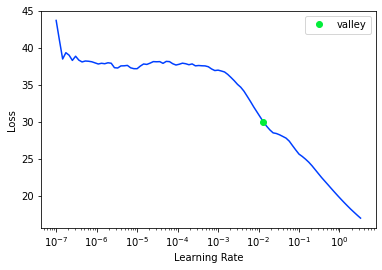

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.20       0.21
1    0.25       0.25
2    0.33       0.33
3    0.41       0.42
4    0.35       0.33
XGBoost RMSE:  0.01711576


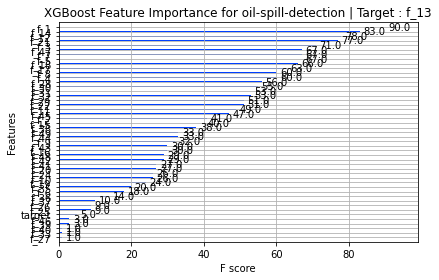

Target Variable: f_12
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:08,  4.67it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9400940148328818, 'Adjusted R-Squared': 0.9186677865614308, 'RMSE': 0.01954292847042602, 'Time taken': 0.31337547302246094}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9539885866688144, 'Adjusted R-Squared': 0.9375319497839377, 'RMSE': 0.01712723757642163, 'Time taken': 0.14290952682495117}
{'Model': 'BayesianRidge', 'R-Squared': 0.9719466471388198, 'Adjusted R-Squared': 0.9619129661884708, 'RMSE': 0.01337355666971544, 'Time taken': 0.026234865188598633}


 12%|█▏        | 5/42 [00:00<00:03, 11.41it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9204834260332939, 'Adjusted R-Squared': 0.8920431915488516, 'RMSE': 0.022515591729039486, 'Time taken': 0.05959343910217285}
{'Model': 'DummyRegressor', 'R-Squared': -0.006715936549197776, 'Adjusted R-Squared': -0.3667822204244582, 'RMSE': 0.080113925, 'Time taken': 0.024927139282226562}
{'Model': 'ElasticNet', 'R-Squared': -0.006715928214646505, 'Adjusted R-Squared': -0.3667822091089361, 'RMSE': 0.08011392419524503, 'Time taken': 0.02864551544189453}


 17%|█▋        | 7/42 [00:00<00:04,  8.38it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9716067744040074, 'Adjusted R-Squared': 0.961451533132448, 'RMSE': 0.013454324612371584, 'Time taken': 0.2966914176940918}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8781249165170699, 'Adjusted R-Squared': 0.8345345581910585, 'RMSE': 0.027874815289098877, 'Time taken': 0.05121350288391113}


 26%|██▌       | 11/42 [00:01<00:05,  5.90it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9624416108532141, 'Adjusted R-Squared': 0.9490083183846557, 'RMSE': 0.015474193164004384, 'Time taken': 0.6712822914123535}
{'Model': 'GammaRegressor', 'R-Squared': 0.8883364834782392, 'Adjusted R-Squared': 0.8483984374230109, 'RMSE': 0.026681496560816656, 'Time taken': 0.03317618370056152}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -5.344039262185563, 'Adjusted R-Squared': -7.613075202675288, 'RMSE': 0.2011117597686932, 'Time taken': 0.15528035163879395}


 29%|██▊       | 12/42 [00:02<00:08,  3.56it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9681457295200347, 'Adjusted R-Squared': 0.956752596282675, 'RMSE': 0.01425077118109901, 'Time taken': 0.7287745475769043}


 33%|███▎      | 14/42 [00:03<00:08,  3.38it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9658538181074859, 'Adjusted R-Squared': 0.9536409501313313, 'RMSE': 0.014754537816905845, 'Time taken': 0.5663487911224365}
{'Model': 'HuberRegressor', 'R-Squared': 0.9713204193485305, 'Adjusted R-Squared': 0.9610627591155232, 'RMSE': 0.013522000061267189, 'Time taken': 0.14064526557922363}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8749140546692113, 'Adjusted R-Squared': 0.830175285901265, 'RMSE': 0.028239615, 'Time taken': 0.0334773063659668}


 38%|███▊      | 16/42 [00:03<00:05,  4.79it/s]

{'Model': 'KernelRidge', 'R-Squared': -9.209159130913404, 'Adjusted R-Squared': -12.860610206933526, 'RMSE': 0.2551229463176593, 'Time taken': 0.1264171600341797}
{'Model': 'Lars', 'R-Squared': -13.380154010531312, 'Adjusted R-Squared': -18.52342077342207, 'RMSE': 0.30278635773699153, 'Time taken': 0.06020474433898926}


 43%|████▎     | 18/42 [00:03<00:04,  5.18it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9614620356967015, 'Adjusted R-Squared': 0.9476783842305583, 'RMSE': 0.015674688545571518, 'Time taken': 0.26796650886535645}
{'Model': 'Lasso', 'R-Squared': -0.006715928214646505, 'Adjusted R-Squared': -0.3667822091089361, 'RMSE': 0.08011392419524503, 'Time taken': 0.029918670654296875}


 52%|█████▏    | 22/42 [00:04<00:03,  6.46it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9716131581391456, 'Adjusted R-Squared': 0.9614602001013218, 'RMSE': 0.013452812039016673, 'Time taken': 0.3034789562225342}
{'Model': 'LassoLars', 'R-Squared': -0.006715928214646505, 'Adjusted R-Squared': -0.3667822091089361, 'RMSE': 0.08011392419524503, 'Time taken': 0.03041815757751465}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9722894243563531, 'Adjusted R-Squared': 0.9623783425568005, 'RMSE': 0.013291601405112229, 'Time taken': 0.1504511833190918}


 57%|█████▋    | 24/42 [00:04<00:02,  7.83it/s]

{'Model': 'LassoLarsIC', 'R-Squared': 0.9722894243563531, 'Adjusted R-Squared': 0.9623783425568005, 'RMSE': 0.013291601405112229, 'Time taken': 0.0879049301147461}
{'Model': 'LinearRegression', 'R-Squared': 0.9708916809162387, 'Adjusted R-Squared': 0.9604806762804409, 'RMSE': 0.013622697050542075, 'Time taken': 0.05113339424133301}


 60%|█████▉    | 25/42 [00:04<00:02,  6.81it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.9601439211398518, 'Adjusted R-Squared': 0.9458888272409667, 'RMSE': 0.015940495604868717, 'Time taken': 0.22356247901916504}


 62%|██████▏   | 26/42 [00:04<00:03,  5.32it/s]

{'Model': 'MLPRegressor', 'R-Squared': -1.455469642365482, 'Adjusted R-Squared': -2.333703310072844, 'RMSE': 0.12511858371857149, 'Time taken': 0.3403506278991699}


 74%|███████▍  | 31/42 [00:05<00:01,  8.18it/s]

{'Model': 'NuSVR', 'R-Squared': 0.8889664703056966, 'Adjusted R-Squared': 0.8492537480062743, 'RMSE': 0.026606123836636218, 'Time taken': 0.41071557998657227}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9122484274607068, 'Adjusted R-Squared': 0.8808628285232953, 'RMSE': 0.02365276893138623, 'Time taken': 0.0201570987701416}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9306207587276246, 'Adjusted R-Squared': 0.9058062855718115, 'RMSE': 0.02103145447076262, 'Time taken': 0.045418739318847656}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.4052996787059193, 'Adjusted R-Squared': 0.1925966440824891, 'RMSE': 0.06157488674435404, 'Time taken': 0.030847787857055664}
{'Model': 'PoissonRegressor', 'R-Squared': 0.7697357850186048, 'Adjusted R-Squared': 0.687378511047157, 'RMSE': 0.03831490562944747, 'Time taken': 0.03485369682312012}
{'Model': 'QuantileRegressor', 'R-Squared': -0.006035683344082443, 'Adjusted R-Squared': -0.36585866497809727, 'RMSE': 0.08008685285685

 79%|███████▊  | 33/42 [00:16<00:15,  1.67s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.7752441841193182, 'Adjusted R-Squared': 0.6948570674904612, 'RMSE': 0.037853845429280344, 'Time taken': 0.3424816131591797}


 90%|█████████ | 38/42 [00:17<00:03,  1.20it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9592490274452519, 'Adjusted R-Squared': 0.9446738620789551, 'RMSE': 0.016118459195323797, 'Time taken': 1.3205463886260986}
{'Model': 'Ridge', 'R-Squared': 0.9723360479139738, 'Adjusted R-Squared': 0.9624416416934243, 'RMSE': 0.013280415014825853, 'Time taken': 0.02153158187866211}
{'Model': 'RidgeCV', 'R-Squared': 0.9723360479145319, 'Adjusted R-Squared': 0.962441641694182, 'RMSE': 0.01328041501469188, 'Time taken': 0.03656411170959473}
{'Model': 'SGDRegressor', 'R-Squared': 0.9489580520819013, 'Adjusted R-Squared': 0.9307021728995156, 'RMSE': 0.018039236617377774, 'Time taken': 0.03078746795654297}
{'Model': 'SVR', 'R-Squared': 0.5219990956434415, 'Adjusted R-Squared': 0.3510352685378111, 'RMSE': 0.05520378989419834, 'Time taken': 0.03170657157897949}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9708916809162387, 'Adjusted R-Squared': 0.9604806762804409, 'RMSE': 0.013622697050542075, 'Time taken': 0.029637575149536133}
{'Mod

 98%|█████████▊| 41/42 [00:18<00:00,  1.60it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9522957970050322, 'Adjusted R-Squared': 0.9352337098024525, 'RMSE': 0.017439453, 'Time taken': 0.6425251960754395}


100%|██████████| 42/42 [00:18<00:00,  2.23it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.965887066889534, 'Adjusted R-Squared': 0.9536860908135278, 'RMSE': 0.01474735268137251, 'Time taken': 0.20865154266357422}
Project: oil-spill-detection
oil-spill-detection
Target: f_12
f_12
Target Standard Deviation: 0.08997438102960587
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
RidgeCV                                      0.96       0.97  0.01        0.04
Ridge                                        0.96       0.97  0.01        0.02
LassoLarsCV                                  0.96       0.97  0.01        0.15
LassoLarsIC                                  0.96       0.97  0.01        0.09
BayesianRidge                                0.96       0.97  0.01        0.03
LassoCV                                      0.96       0.97  0.01        0.30
ElasticNetCV                                 0.96       0.97  0.01        0.30
HuberRegre

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.1907039880752563.
Better model found at epoch 1 with _rmse value: 0.298111230134964.
Better model found at epoch 2 with _rmse value: 0.16429582238197327.
Better model found at epoch 3 with _rmse value: 0.1515122801065445.
Better model found at epoch 4 with _rmse value: 0.12887759506702423.
Better model found at epoch 5 with _rmse value: 0.12484688311815262.
Better model found at epoch 6 with _rmse value: 0.11840090900659561.
Better model found at epoch 7 with _rmse value: 0.11836685240268707.
Better model found at epoch 8 with _rmse value: 0.10899432748556137.
No improvement since epoch 8: early stopping


<Figure size 432x288 with 0 Axes>

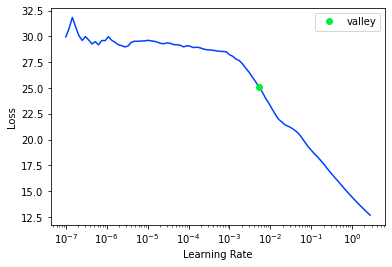

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.28       0.27
1    0.26       0.25
2    0.28       0.28
3    0.25       0.26
4    0.27       0.25
XGBoost RMSE:  0.017443199


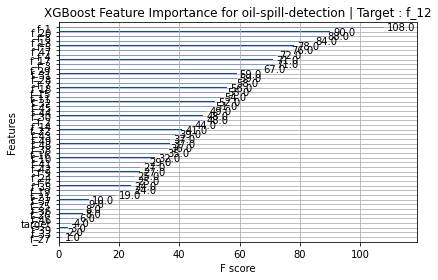

Target Variable: f_11
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:08,  4.65it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.7303483091122227, 'Adjusted R-Squared': 0.6339035437582001, 'RMSE': 43.50562364816625, 'Time taken': 0.2832469940185547}
{'Model': 'BaggingRegressor', 'R-Squared': 0.7272307694882842, 'Adjusted R-Squared': 0.629670971714021, 'RMSE': 43.756392958820435, 'Time taken': 0.1640629768371582}
{'Model': 'BayesianRidge', 'R-Squared': 0.7680236591924384, 'Adjusted R-Squared': 0.685054019049588, 'RMSE': 40.35205635559644, 'Time taken': 0.027564525604248047}


 10%|▉         | 4/42 [00:00<00:04,  7.97it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.5640853290720407, 'Adjusted R-Squared': 0.40817424238977784, 'RMSE': 55.315210250374506, 'Time taken': 0.11501908302307129}
{'Model': 'DummyRegressor', 'R-Squared': -0.0017106799182575738, 'Adjusted R-Squared': -0.3599867625167583, 'RMSE': 83.8523, 'Time taken': 0.013065338134765625}
{'Model': 'ElasticNet', 'R-Squared': 0.8254044711858398, 'Adjusted R-Squared': 0.7629578951866147, 'RMSE': 35.00744244754419, 'Time taken': 0.02053976058959961}


 19%|█▉        | 8/42 [00:01<00:05,  6.74it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.8183697288204049, 'Adjusted R-Squared': 0.7534070770846374, 'RMSE': 35.705731948676124, 'Time taken': 0.5280771255493164}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8727022307370963, 'Adjusted R-Squared': 0.8271723716576636, 'RMSE': 29.891948217881207, 'Time taken': 0.0936746597290039}


 26%|██▌       | 11/42 [00:02<00:07,  4.38it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.8532218397305054, 'Adjusted R-Squared': 0.8007245415319271, 'RMSE': 32.09774663356055, 'Time taken': 0.8536005020141602}
{'Model': 'GammaRegressor', 'R-Squared': 0.8674227817047754, 'Adjusted R-Squared': 0.8200046525334906, 'RMSE': 30.50550900502682, 'Time taken': 0.027003049850463867}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.1239970923844425, 'Adjusted R-Squared': -1.8836748845511408, 'RMSE': 122.10143937017706, 'Time taken': 0.1707322597503662}


 29%|██▊       | 12/42 [00:03<00:10,  2.99it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.81972995643633, 'Adjusted R-Squared': 0.755253809468302, 'RMSE': 35.57178072013121, 'Time taken': 0.6996777057647705}


 33%|███▎      | 14/42 [00:03<00:08,  3.13it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.6596978346523251, 'Adjusted R-Squared': 0.5379839214987772, 'RMSE': 48.87380828331093, 'Time taken': 0.5354735851287842}
{'Model': 'HuberRegressor', 'R-Squared': 0.8448050685789801, 'Adjusted R-Squared': 0.7892973923773015, 'RMSE': 33.00521691186748, 'Time taken': 0.13345551490783691}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.5594012989395536, 'Adjusted R-Squared': 0.4018149022099049, 'RMSE': 55.61161, 'Time taken': 0.03127932548522949}


 38%|███▊      | 16/42 [00:03<00:05,  4.82it/s]

{'Model': 'KernelRidge', 'R-Squared': -0.9952688967861525, 'Adjusted R-Squared': -1.7089052175344843, 'RMSE': 118.34353585528338, 'Time taken': 0.07369375228881836}
{'Model': 'Lars', 'R-Squared': -343014.9990480971, 'Adjusted R-Squared': -465699.553452161, 'RMSE': 49068.300144148176, 'Time taken': 0.08952021598815918}


 43%|████▎     | 18/42 [00:04<00:04,  5.61it/s]

{'Model': 'LarsCV', 'R-Squared': -0.0017106085245905955, 'Adjusted R-Squared': -0.3599866655881301, 'RMSE': 83.85229647828304, 'Time taken': 0.16329193115234375}
{'Model': 'Lasso', 'R-Squared': 0.8560961968991971, 'Adjusted R-Squared': 0.8046269534543844, 'RMSE': 31.781907583054984, 'Time taken': 0.05372142791748047}


 48%|████▊     | 20/42 [00:04<00:05,  4.03it/s]

{'Model': 'LassoCV', 'R-Squared': 0.787040737115202, 'Adjusted R-Squared': 0.710872825572464, 'RMSE': 38.662692209319836, 'Time taken': 0.6981155872344971}
{'Model': 'LassoLars', 'R-Squared': 0.37036789851607166, 'Adjusted R-Squared': 0.1451710155035718, 'RMSE': 66.47942519621452, 'Time taken': 0.03188514709472656}


 57%|█████▋    | 24/42 [00:05<00:02,  6.37it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.46671220920345713, 'Adjusted R-Squared': 0.2759742402324309, 'RMSE': 61.18213741527143, 'Time taken': 0.21273565292358398}
{'Model': 'LassoLarsIC', 'R-Squared': 0.7214079725433966, 'Adjusted R-Squared': 0.6217655685625677, 'RMSE': 44.22096000894437, 'Time taken': 0.07009601593017578}
{'Model': 'LinearRegression', 'R-Squared': 0.7312208779476923, 'Adjusted R-Squared': 0.6350881992574509, 'RMSE': 43.43517645171754, 'Time taken': 0.02856302261352539}
{'Model': 'LinearSVR', 'R-Squared': 0.8868204533829112, 'Adjusted R-Squared': 0.8463401775855582, 'RMSE': 28.185633441832724, 'Time taken': 0.08150076866149902}


 64%|██████▍   | 27/42 [00:07<00:05,  2.99it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.6340211399339521, 'Adjusted R-Squared': 0.503123591443176, 'RMSE': 50.68410998571551, 'Time taken': 1.659769058227539}
{'Model': 'NuSVR', 'R-Squared': 0.03306665505091699, 'Adjusted R-Squared': -0.3127708186899958, 'RMSE': 82.3838518041815, 'Time taken': 0.10626578330993652}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.8635699920794927, 'Adjusted R-Squared': 0.8147738578597492, 'RMSE': 30.9455906810435, 'Time taken': 0.020123004913330078}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.8146836297309935, 'Adjusted R-Squared': 0.7484025921895241, 'RMSE': 36.06622745225074, 'Time taken': 0.04601144790649414}


 71%|███████▏  | 30/42 [00:07<00:02,  4.91it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9050792993356116, 'Adjusted R-Squared': 0.8711295596819253, 'RMSE': 25.812156661224694, 'Time taken': 0.04073905944824219}
{'Model': 'PoissonRegressor', 'R-Squared': 0.2984893256737895, 'Adjusted R-Squared': 0.04758404799507199, 'RMSE': 70.17153333312456, 'Time taken': 0.08774518966674805}


 76%|███████▌  | 32/42 [00:18<00:18,  1.84s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.022856667797411356, 'Adjusted R-Squared': -0.38869591394393055, 'RMSE': 84.73273307839672, 'Time taken': 11.389609813690186}


 79%|███████▊  | 33/42 [00:18<00:14,  1.58s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -13.359353004306902, 'Adjusted R-Squared': -18.495179991248786, 'RMSE': 317.4762638071585, 'Time taken': 0.3611781597137451}


 88%|████████▊ | 37/42 [00:20<00:04,  1.09it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.7258807850543736, 'Adjusted R-Squared': 0.6278381461322153, 'RMSE': 43.86453848164592, 'Time taken': 1.5661020278930664}
{'Model': 'Ridge', 'R-Squared': 0.7643146101334178, 'Adjusted R-Squared': 0.6800183758015745, 'RMSE': 40.67336980397162, 'Time taken': 0.020055770874023438}
{'Model': 'RidgeCV', 'R-Squared': 0.8474483601572689, 'Adjusted R-Squared': 0.7928860948120585, 'RMSE': 32.72293614236708, 'Time taken': 0.06542086601257324}
{'Model': 'SGDRegressor', 'R-Squared': 0.7504945850120329, 'Adjusted R-Squared': 0.6612554219871396, 'RMSE': 41.84887738918562, 'Time taken': 0.06189131736755371}


 93%|█████████▎| 39/42 [00:20<00:01,  1.55it/s]

{'Model': 'SVR', 'R-Squared': 0.03692103872133634, 'Adjusted R-Squared': -0.3075378598381855, 'RMSE': 82.21948884679334, 'Time taken': 0.09352493286132812}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.7312208779476923, 'Adjusted R-Squared': 0.6350881992574509, 'RMSE': 43.43517645171754, 'Time taken': 0.020807743072509766}
{'Model': 'TweedieRegressor', 'R-Squared': 0.7794491118451676, 'Adjusted R-Squared': 0.7005659474686218, 'RMSE': 39.34578641886547, 'Time taken': 0.07189011573791504}


 98%|█████████▊| 41/42 [00:21<00:00,  1.69it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.7186867629549847, 'Adjusted R-Squared': 0.618071079632315, 'RMSE': 44.4364, 'Time taken': 0.8611249923706055}


100%|██████████| 42/42 [00:22<00:00,  1.91it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.6686482647755809, 'Adjusted R-Squared': 0.5501356003522486, 'RMSE': 48.226800353481366, 'Time taken': 0.2453622817993164}
Project: oil-spill-detection
oil-spill-detection
Target: f_11
f_11
Target Standard Deviation: 54.42171096801758
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
PassiveAggressiveRegressor                   0.87       0.91    25.81   
LinearSVR                                    0.85       0.89    28.19   
ExtraTreeRegressor                           0.83       0.87    29.89   
GammaRegressor                               0.82       0.87    30.51   
OrthogonalMatchingPursuit                    0.81       0.86    30.95   
Lasso                                        0.80       0.86    31.78   
ExtraTreesRegressor                          0.80       0.85    32.10   
RidgeCV                                      0.79       0.85    32.

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 134.51995849609375.
Better model found at epoch 1 with _rmse value: 110.5129623413086.
Better model found at epoch 2 with _rmse value: 72.11773681640625.
Better model found at epoch 3 with _rmse value: 66.12986755371094.
No improvement since epoch 3: early stopping


<Figure size 432x288 with 0 Axes>

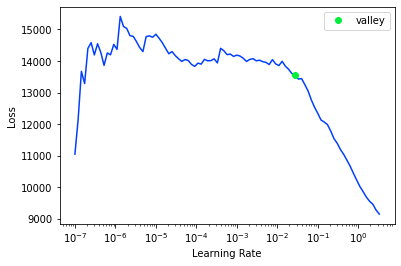

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   72.10      67.14
1  102.60     101.33
2   64.70      68.34
3   90.10      91.25
4  247.00     220.30
XGBoost RMSE:  44.43602


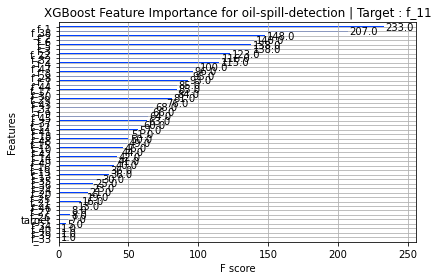

Target Variable: f_10
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular O

  5%|▍         | 2/42 [00:00<00:08,  4.64it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8968815395187646, 'Adjusted R-Squared': 0.8599997543831402, 'RMSE': 0.027334786012217595, 'Time taken': 0.32041454315185547}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9523805088598076, 'Adjusted R-Squared': 0.935348720057841, 'RMSE': 0.018575471372309985, 'Time taken': 0.14066743850708008}
{'Model': 'BayesianRidge', 'R-Squared': 0.9382120806077622, 'Adjusted R-Squared': 0.9161127517740421, 'RMSE': 0.02115920049615086, 'Time taken': 0.05588173866271973}


 10%|▉         | 4/42 [00:00<00:04,  8.24it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.893062053606398, 'Adjusted R-Squared': 0.8548141749692704, 'RMSE': 0.02783642047758382, 'Time taken': 0.07289624214172363}
{'Model': 'DummyRegressor', 'R-Squared': -0.00031910372118648667, 'Adjusted R-Squared': -0.3580974692856984, 'RMSE': 0.08513669, 'Time taken': 0.02537083625793457}
{'Model': 'ElasticNet', 'R-Squared': -0.0003191009297152103, 'Adjusted R-Squared': -0.35809746549581756, 'RMSE': 0.08513668756612795, 'Time taken': 0.019132137298583984}


 17%|█▋        | 7/42 [00:00<00:04,  7.92it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9486613093120008, 'Adjusted R-Squared': 0.9302992958542492, 'RMSE': 0.019287230129155314, 'Time taken': 0.3357391357421875}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.825091141684741, 'Adjusted R-Squared': 0.7625324989296484, 'RMSE': 0.03560027646582985, 'Time taken': 0.051447153091430664}


 21%|██▏       | 9/42 [00:01<00:06,  4.73it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9709890189577398, 'Adjusted R-Squared': 0.9606128286579533, 'RMSE': 0.014498687047519509, 'Time taken': 0.6760809421539307}
{'Model': 'GammaRegressor', 'R-Squared': 0.8207146698049016, 'Adjusted R-Squared': 0.7565907195891365, 'RMSE': 0.03604290987003926, 'Time taken': 0.03229260444641113}


 26%|██▌       | 11/42 [00:01<00:05,  5.63it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -4.00974270264656, 'Adjusted R-Squared': -5.801548486804818, 'RMSE': 0.19052640757669664, 'Time taken': 0.1874675750732422}


 29%|██▊       | 12/42 [00:02<00:08,  3.49it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9775908847279762, 'Adjusted R-Squared': 0.9695759456890771, 'RMSE': 0.012742652020366878, 'Time taken': 0.7403919696807861}


 33%|███▎      | 14/42 [00:03<00:08,  3.35it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9585839301234879, 'Adjusted R-Squared': 0.9437708832333485, 'RMSE': 0.017323351218783183, 'Time taken': 0.5629181861877441}
{'Model': 'HuberRegressor', 'R-Squared': 0.9362109717690952, 'Adjusted R-Squared': 0.9133959178762898, 'RMSE': 0.021499108981151684, 'Time taken': 0.14094209671020508}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7912104884159457, 'Adjusted R-Squared': 0.7165339477763935, 'RMSE': 0.038895722, 'Time taken': 0.03254079818725586}


 38%|███▊      | 16/42 [00:03<00:05,  4.98it/s]

{'Model': 'KernelRidge', 'R-Squared': -5.701301504880557, 'Adjusted R-Squared': -8.09811737158966, 'RMSE': 0.22035709948439403, 'Time taken': 0.07511758804321289}
{'Model': 'Lars', 'R-Squared': -4360.042762703956, 'Adjusted R-Squared': -5919.831780021429, 'RMSE': 5.62137607237326, 'Time taken': 0.09111905097961426}


 43%|████▎     | 18/42 [00:03<00:04,  5.78it/s]

{'Model': 'LarsCV', 'R-Squared': 0.07003870678818269, 'Adjusted R-Squared': -0.26257518640436506, 'RMSE': 0.08208804345636712, 'Time taken': 0.1542062759399414}
{'Model': 'Lasso', 'R-Squared': -0.0003191009297152103, 'Adjusted R-Squared': -0.35809746549581756, 'RMSE': 0.08513668756612795, 'Time taken': 0.04468655586242676}


 48%|████▊     | 20/42 [00:04<00:04,  5.23it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9486597737933062, 'Adjusted R-Squared': 0.9302972111354377, 'RMSE': 0.019287518563478285, 'Time taken': 0.40245580673217773}
{'Model': 'LassoLars', 'R-Squared': -0.0003191009297152103, 'Adjusted R-Squared': -0.35809746549581756, 'RMSE': 0.08513668756612795, 'Time taken': 0.03472256660461426}


 57%|█████▋    | 24/42 [00:04<00:02,  7.48it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9487727423482889, 'Adjusted R-Squared': 0.9304505845020564, 'RMSE': 0.019266286839531806, 'Time taken': 0.22968626022338867}
{'Model': 'LassoLarsIC', 'R-Squared': 0.935799093939667, 'Adjusted R-Squared': 0.912836726078672, 'RMSE': 0.021568405838539972, 'Time taken': 0.07039165496826172}
{'Model': 'LinearRegression', 'R-Squared': 0.9349474706626368, 'Adjusted R-Squared': 0.9116805076149668, 'RMSE': 0.021710986722498653, 'Time taken': 0.029758214950561523}
{'Model': 'LinearSVR', 'R-Squared': 0.9218775815648457, 'Adjusted R-Squared': 0.8939359866500824, 'RMSE': 0.02379223866898975, 'Time taken': 0.2180032730102539}


 62%|██████▏   | 26/42 [00:05<00:03,  5.19it/s]

{'Model': 'MLPRegressor', 'R-Squared': -2.169119924186464, 'Adjusted R-Squared': -3.302600772983082, 'RMSE': 0.1515363439670131, 'Time taken': 0.4233510494232178}


 74%|███████▍  | 31/42 [00:05<00:01,  7.49it/s]

{'Model': 'NuSVR', 'R-Squared': 0.9125988625910129, 'Adjusted R-Squared': 0.8813386017659006, 'RMSE': 0.025165525888173765, 'Time taken': 0.44648027420043945}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9063361248087471, 'Adjusted R-Squared': 0.8728359066746494, 'RMSE': 0.02605154768181442, 'Time taken': 0.019459009170532227}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9449259277960333, 'Adjusted R-Squared': 0.9252279019712569, 'RMSE': 0.019976576509291896, 'Time taken': 0.04363512992858887}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.5454599790877916, 'Adjusted R-Squared': 0.38288727087831576, 'RMSE': 0.05738964415809853, 'Time taken': 0.028870344161987305}
{'Model': 'PoissonRegressor', 'R-Squared': 0.6637369286899503, 'Adjusted R-Squared': 0.5434676550097135, 'RMSE': 0.049361353064169174, 'Time taken': 0.033387184143066406}
{'Model': 'QuantileRegressor', 'R-Squared': -0.054028912774515936, 'Adjusted R-Squared': -0.43101735602963465, 'RMSE': 0.08739241

 79%|███████▊  | 33/42 [00:17<00:14,  1.66s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.897838803849292, 'Adjusted R-Squared': 0.861299397926776, 'RMSE': 0.027207613698975393, 'Time taken': 0.3471505641937256}


 88%|████████▊ | 37/42 [00:18<00:04,  1.03it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9685211288073744, 'Adjusted R-Squared': 0.9572622624684062, 'RMSE': 0.015102785120817747, 'Time taken': 1.3623695373535156}
{'Model': 'Ridge', 'R-Squared': 0.9380982540741597, 'Adjusted R-Squared': 0.915958213560538, 'RMSE': 0.0211786814097152, 'Time taken': 0.020296573638916016}
{'Model': 'RidgeCV', 'R-Squared': 0.9428317689078276, 'Adjusted R-Squared': 0.9223847373493134, 'RMSE': 0.020352831885745343, 'Time taken': 0.04701685905456543}
{'Model': 'SGDRegressor', 'R-Squared': 0.9476425195512207, 'Adjusted R-Squared': 0.928916121434504, 'RMSE': 0.019477662564595394, 'Time taken': 0.05113530158996582}
{'Model': 'SVR', 'R-Squared': 0.5706828313021726, 'Adjusted R-Squared': 0.4171314351985701, 'RMSE': 0.05577461696420291, 'Time taken': 0.058232784271240234}


 95%|█████████▌| 40/42 [00:19<00:01,  1.58it/s]

{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9349474706626368, 'Adjusted R-Squared': 0.9116805076149668, 'RMSE': 0.021710986722498653, 'Time taken': 0.031159639358520508}
{'Model': 'TweedieRegressor', 'R-Squared': 0.828914803721102, 'Adjusted R-Squared': 0.7677237481177006, 'RMSE': 0.03520899950033194, 'Time taken': 0.04953408241271973}
{'Model': 'XGBRegressor', 'R-Squared': 0.9709375027487548, 'Adjusted R-Squared': 0.9605428869435649, 'RMSE': 0.0145115545, 'Time taken': 0.662926197052002}


100%|██████████| 42/42 [00:19<00:00,  2.10it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9499852609090369, 'Adjusted R-Squared': 0.9320967775845319, 'RMSE': 0.01903691066695833, 'Time taken': 0.22745013236999512}
Project: oil-spill-detection
oil-spill-detection
Target: f_10
f_10
Target Standard Deviation: 0.09150242060422897
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GradientBoostingRegressor                    0.97       0.98  0.01        0.74
ExtraTreesRegressor                          0.96       0.97  0.01        0.68
XGBRegressor                                 0.96       0.97  0.01        0.66
RandomForestRegressor                        0.96       0.97  0.02        1.36
HistGradientBoostingRegressor                0.94       0.96  0.02        0.56
BaggingRegressor                             0.94       0.95  0.02        0.14
LGBMRegressor                                0.93       0.95  0.02        0.23
LassoLars

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.8250547647476196.
Better model found at epoch 1 with _rmse value: 0.5413691997528076.
No improvement since epoch 1: early stopping


<Figure size 432x288 with 0 Axes>

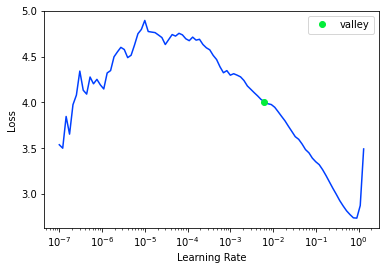

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.29       0.30
1    0.21       0.22
2    0.18       0.19
3    0.17       0.16
4    0.11       0.13
XGBoost RMSE:  0.014509693


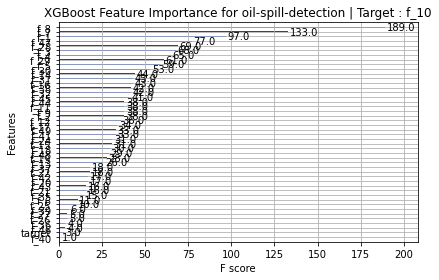

Target Variable: f_9
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular 

  5%|▍         | 2/42 [00:00<00:08,  4.91it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9259963198441599, 'Adjusted R-Squared': 0.8995278502993703, 'RMSE': 1421.5897785882046, 'Time taken': 0.2573666572570801}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8814833755954561, 'Adjusted R-Squared': 0.8390942179617141, 'RMSE': 1799.0252966745259, 'Time taken': 0.16461420059204102}


 10%|▉         | 4/42 [00:00<00:04,  8.06it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.9842358541919453, 'Adjusted R-Squared': 0.978597583063517, 'RMSE': 656.1193636650287, 'Time taken': 0.04642152786254883}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9465772606096252, 'Adjusted R-Squared': 0.9274698574700021, 'RMSE': 1207.8436220143076, 'Time taken': 0.1057901382446289}
{'Model': 'DummyRegressor', 'R-Squared': -0.011305030698565144, 'Adjusted R-Squared': -0.37301266941557, 'RMSE': 5255.1934, 'Time taken': 0.013008832931518555}
{'Model': 'ElasticNet', 'R-Squared': 0.9701959235830608, 'Adjusted R-Squared': 0.9595360714339366, 'RMSE': 902.1639471828483, 'Time taken': 0.03137922286987305}


 17%|█▋        | 7/42 [00:00<00:03,  9.22it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.7097504224386919, 'Adjusted R-Squared': 0.6059385297342825, 'RMSE': 2815.3567304963867, 'Time taken': 0.24040746688842773}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9687958760226617, 'Adjusted R-Squared': 0.9576352769358765, 'RMSE': 923.1103722514923, 'Time taken': 0.07138371467590332}


 21%|██▏       | 9/42 [00:01<00:07,  4.53it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.99569634189768, 'Adjusted R-Squared': 0.9941570773209377, 'RMSE': 342.82028728796564, 'Time taken': 0.7791073322296143}
{'Model': 'GammaRegressor', 'R-Squared': 0.9125713333506252, 'Adjusted R-Squared': 0.8813012263008488, 'RMSE': 1545.1639282472142, 'Time taken': 0.03179168701171875}


 26%|██▌       | 11/42 [00:01<00:05,  5.45it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.30190285234245007, 'Adjusted R-Squared': -0.7675469382167568, 'RMSE': 5962.617119823366, 'Time taken': 0.18479204177856445}


 29%|██▊       | 12/42 [00:02<00:08,  3.47it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9757388320295559, 'Adjusted R-Squared': 0.9670614799817329, 'RMSE': 813.9607921526989, 'Time taken': 0.7229998111724854}


 33%|███▎      | 14/42 [00:03<00:08,  3.35it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.877962938257494, 'Adjusted R-Squared': 0.8343146461014153, 'RMSE': 1825.5490434989968, 'Time taken': 0.5621366500854492}
{'Model': 'HuberRegressor', 'R-Squared': 0.9885202777365654, 'Adjusted R-Squared': 0.9844143916715413, 'RMSE': 559.9036826095505, 'Time taken': 0.13884782791137695}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8445148363141615, 'Adjusted R-Squared': 0.7889033544119273, 'RMSE': 2060.5925, 'Time taken': 0.03260087966918945}


 38%|███▊      | 16/42 [00:03<00:05,  4.99it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.4040732427942939, 'Adjusted R-Squared': 0.19093155591050126, 'RMSE': 4034.07600443297, 'Time taken': 0.07434368133544922}
{'Model': 'Lars', 'R-Squared': -722161.010275539, 'Adjusted R-Squared': -980452.5321989069, 'RMSE': 4440838.2256975435, 'Time taken': 0.08438968658447266}


 43%|████▎     | 18/42 [00:03<00:04,  5.87it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9651253590572669, 'Adjusted R-Squared': 0.9526519473332237, 'RMSE': 975.8936810284815, 'Time taken': 0.14861297607421875}
{'Model': 'Lasso', 'R-Squared': 0.9843914535556156, 'Adjusted R-Squared': 0.9788088347543394, 'RMSE': 652.8732337800948, 'Time taken': 0.05028891563415527}


 48%|████▊     | 20/42 [00:04<00:04,  5.39it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9867040229168544, 'Adjusted R-Squared': 0.9819485274637586, 'RMSE': 602.5703560642129, 'Time taken': 0.3768198490142822}
{'Model': 'LassoLars', 'R-Squared': 0.9894545127629292, 'Adjusted R-Squared': 0.98568276915259, 'RMSE': 536.637427025271, 'Time taken': 0.0563044548034668}


 57%|█████▋    | 24/42 [00:04<00:02,  6.98it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9875276692503354, 'Adjusted R-Squared': 0.9830667626318422, 'RMSE': 583.6082775952386, 'Time taken': 0.2528800964355469}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9844141544684133, 'Adjusted R-Squared': 0.9788396549717144, 'RMSE': 652.398294901727, 'Time taken': 0.07893228530883789}
{'Model': 'LinearRegression', 'R-Squared': 0.9839414023518525, 'Adjusted R-Squared': 0.9781978163317121, 'RMSE': 662.2187023189739, 'Time taken': 0.06152153015136719}
{'Model': 'LinearSVR', 'R-Squared': -0.27343674521888617, 'Adjusted R-Squared': -0.728899522705933, 'RMSE': 5897.070530991462, 'Time taken': 0.042266130447387695}


 64%|██████▍   | 27/42 [00:06<00:04,  3.30it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.09418742922180501, 'Adjusted R-Squared': -0.48553913748361843, 'RMSE': 5466.300391479793, 'Time taken': 1.5228402614593506}
{'Model': 'NuSVR', 'R-Squared': -0.040776194970886026, 'Adjusted R-Squared': -0.4130246150699619, 'RMSE': 5331.216365979398, 'Time taken': 0.11039400100708008}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9697001699715846, 'Adjusted R-Squared': 0.9588630044869688, 'RMSE': 909.6361880997789, 'Time taken': 0.023255109786987305}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9730374450854051, 'Adjusted R-Squared': 0.9633939035466085, 'RMSE': 858.0807412187822, 'Time taken': 0.04327201843261719}


 71%|███████▏  | 30/42 [00:06<00:02,  5.27it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9827481444150051, 'Adjusted R-Squared': 0.976577772709423, 'RMSE': 686.3814541218676, 'Time taken': 0.064727783203125}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9544439473491771, 'Adjusted R-Squared': 0.9381501766930435, 'RMSE': 1115.3744107383807, 'Time taken': 0.08359074592590332}


 76%|███████▌  | 32/42 [00:26<00:30,  3.07s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.07162313644926788, 'Adjusted R-Squared': -0.4549044042303927, 'RMSE': 5409.643855180792, 'Time taken': 19.84938645362854}


 79%|███████▊  | 33/42 [00:26<00:23,  2.60s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.7877024710339877, 'Adjusted R-Squared': 0.711771238046144, 'RMSE': 2407.798297642629, 'Time taken': 0.32598352432250977}


 81%|████████  | 34/42 [00:28<00:19,  2.39s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9913386863534831, 'Adjusted R-Squared': 0.9882408442463347, 'RMSE': 486.3394690309429, 'Time taken': 1.561706781387329}
{'Model': 'Ridge', 'R-Squared': 0.9854393190831087, 'Adjusted R-Squared': 0.9802314843026146, 'RMSE': 630.5775079703258, 'Time taken': 0.020831584930419922}
{'Model': 'RidgeCV', 'R-Squared': 0.9854393190826808, 'Adjusted R-Squared': 0.9802314843020338, 'RMSE': 630.577507979591, 'Time taken': 0.03760409355163574}
{'Model': 'SGDRegressor', 'R-Squared': 0.9648681260073014, 'Adjusted R-Squared': 0.9523027112215917, 'RMSE': 979.4861324702913, 'Time taken': 0.03373861312866211}


 95%|█████████▌| 40/42 [00:28<00:01,  1.18it/s]

{'Model': 'SVR', 'R-Squared': -0.06685734587341541, 'Adjusted R-Squared': -0.44843406082084125, 'RMSE': 5397.601395139162, 'Time taken': 0.1112527847290039}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9839414023518525, 'Adjusted R-Squared': 0.9781978163317121, 'RMSE': 662.2187023189739, 'Time taken': 0.02217555046081543}
{'Model': 'TweedieRegressor', 'R-Squared': 0.9577409856087381, 'Adjusted R-Squared': 0.9426264476147831, 'RMSE': 1074.2548307963666, 'Time taken': 0.07732558250427246}
{'Model': 'XGBRegressor', 'R-Squared': 0.9702019362040079, 'Adjusted R-Squared': 0.9595442345543465, 'RMSE': 902.07294, 'Time taken': 1.526860237121582}


100%|██████████| 42/42 [00:30<00:00,  1.38it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.8575904317884425, 'Adjusted R-Squared': 0.8066556227200753, 'RMSE': 1972.0468045620653, 'Time taken': 0.22952771186828613}
Project: oil-spill-detection
oil-spill-detection
Target: f_9
f_9
Target Standard Deviation: 8739.5478515625
                               Adjusted R-Squared  R-Squared       RMSE  \
Model                                                                     
ExtraTreesRegressor                          0.99       1.00     342.82   
RandomForestRegressor                        0.99       0.99     486.34   
LassoLars                                    0.99       0.99     536.64   
HuberRegressor                               0.98       0.99     559.90   
LassoLarsCV                                  0.98       0.99     583.61   
LassoCV                                      0.98       0.99     602.57   
Ridge                                        0.98       0.99     630.58   
RidgeCV                                      0.98   

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 6284.6875.
Better model found at epoch 1 with _rmse value: 6277.8662109375.
Better model found at epoch 2 with _rmse value: 6139.1025390625.
Better model found at epoch 3 with _rmse value: 2736.090087890625.
No improvement since epoch 3: early stopping


<Figure size 432x288 with 0 Axes>

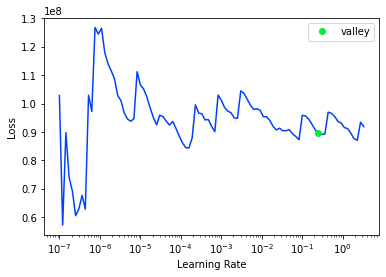

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0 2090.00    1968.48
1 1430.00    1476.08
2 1011.00    1002.36
3 1281.00    1303.84
4 2410.00    2573.58
XGBoost RMSE:  902.0799


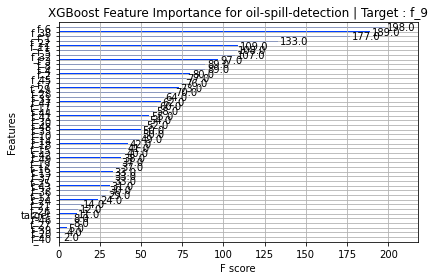

Target Variable: f_8
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular 

  5%|▍         | 2/42 [00:00<00:08,  4.53it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8885037541449159, 'Adjusted R-Squared': 0.8486255348244843, 'RMSE': 1.1175363081213527, 'Time taken': 0.31940722465515137}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9609138328371735, 'Adjusted R-Squared': 0.9469341088154326, 'RMSE': 0.6616724650468742, 'Time taken': 0.1500535011291504}
{'Model': 'BayesianRidge', 'R-Squared': 0.9325068749344019, 'Adjusted R-Squared': 0.9083669980861222, 'RMSE': 0.8694833867300599, 'Time taken': 0.042107582092285156}


 10%|▉         | 4/42 [00:00<00:04,  7.63it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9318737984901753, 'Adjusted R-Squared': 0.9075074928406759, 'RMSE': 0.873551687636406, 'Time taken': 0.11218452453613281}
{'Model': 'DummyRegressor', 'R-Squared': -0.015255895631231864, 'Adjusted R-Squared': -0.3783766174263439, 'RMSE': 3.3722463, 'Time taken': 0.012529850006103516}
{'Model': 'ElasticNet', 'R-Squared': 0.6692265108958626, 'Adjusted R-Squared': 0.5509206644279595, 'RMSE': 1.9248498912293166, 'Time taken': 0.021627426147460938}


 17%|█▋        | 7/42 [00:01<00:04,  7.64it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9344581180685234, 'Adjusted R-Squared': 0.9110161311003311, 'RMSE': 0.856822718721464, 'Time taken': 0.3544647693634033}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8187106893014071, 'Adjusted R-Squared': 0.7538699869347572, 'RMSE': 1.4250090369875945, 'Time taken': 0.040703773498535156}


 26%|██▌       | 11/42 [00:02<00:05,  5.45it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9717379406438575, 'Adjusted R-Squared': 0.9616296128449453, 'RMSE': 0.5626436499685065, 'Time taken': 0.7849438190460205}
{'Model': 'GammaRegressor', 'R-Squared': 0.713656489637432, 'Adjusted R-Squared': 0.6112416574639588, 'RMSE': 1.790915899464024, 'Time taken': 0.027506589889526367}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -3.024173792024712, 'Adjusted R-Squared': -4.46347682712844, 'RMSE': 6.713822942960329, 'Time taken': 0.14935541152954102}


 29%|██▊       | 12/42 [00:02<00:08,  3.45it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9784308533369447, 'Adjusted R-Squared': 0.9707163410268008, 'RMSE': 0.4915277044690596, 'Time taken': 0.7300846576690674}


 33%|███▎      | 14/42 [00:03<00:08,  3.40it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9602298629095998, 'Adjusted R-Squared': 0.9460055073079238, 'RMSE': 0.6674366698605373, 'Time taken': 0.541064977645874}
{'Model': 'HuberRegressor', 'R-Squared': 0.9361982966480699, 'Adjusted R-Squared': 0.9133787093178175, 'RMSE': 0.845371605207247, 'Time taken': 0.12608623504638672}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7464086694725395, 'Adjusted R-Squared': 0.6557081205977544, 'RMSE': 1.6853834, 'Time taken': 0.032958269119262695}


 40%|████      | 17/42 [00:03<00:04,  5.90it/s]

{'Model': 'KernelRidge', 'R-Squared': -6.5100632754970995, 'Adjusted R-Squared': -9.196144301039856, 'RMSE': 9.171773428219222, 'Time taken': 0.05350542068481445}
{'Model': 'Lars', 'R-Squared': -72.25164383783894, 'Adjusted R-Squared': -98.45113688932878, 'RMSE': 28.644431494625422, 'Time taken': 0.04563188552856445}


 45%|████▌     | 19/42 [00:03<00:03,  6.01it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9323942713691231, 'Adjusted R-Squared': 0.9082141202529701, 'RMSE': 0.8702083948472802, 'Time taken': 0.26941633224487305}
{'Model': 'Lasso', 'R-Squared': 0.6821642886125374, 'Adjusted R-Squared': 0.5684858224958538, 'RMSE': 1.8868304037898378, 'Time taken': 0.04402732849121094}


 48%|████▊     | 20/42 [00:04<00:04,  4.59it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9337707411425813, 'Adjusted R-Squared': 0.9100829040329936, 'RMSE': 0.8613040061022513, 'Time taken': 0.43135881423950195}
{'Model': 'LassoLars', 'R-Squared': -0.01525593030148542, 'Adjusted R-Squared': -0.3783766644969071, 'RMSE': 3.372246302495213, 'Time taken': 0.027580976486206055}


 57%|█████▋    | 24/42 [00:04<00:02,  6.74it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.934914747120649, 'Adjusted R-Squared': 0.911636080032414, 'RMSE': 0.8538327680466307, 'Time taken': 0.2267286777496338}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9320170101596414, 'Adjusted R-Squared': 0.907701926202141, 'RMSE': 0.8726330351336722, 'Time taken': 0.0810704231262207}
{'Model': 'LinearRegression', 'R-Squared': 0.9309004248133783, 'Adjusted R-Squared': 0.9061859782137837, 'RMSE': 0.8797701212435209, 'Time taken': 0.05440354347229004}


 60%|█████▉    | 25/42 [00:04<00:02,  6.89it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.9361422629735631, 'Adjusted R-Squared': 0.9133026344020637, 'RMSE': 0.8457427464068925, 'Time taken': 0.1251840591430664}


 64%|██████▍   | 27/42 [00:06<00:05,  2.53it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9510385632752988, 'Adjusted R-Squared': 0.9335268085343472, 'RMSE': 0.7405571788969677, 'Time taken': 1.6914124488830566}
{'Model': 'NuSVR', 'R-Squared': 0.854000638916314, 'Adjusted R-Squared': 0.801781889331638, 'RMSE': 1.278812866847562, 'Time taken': 0.12129902839660645}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9275921877444636, 'Adjusted R-Squared': 0.9016945030691258, 'RMSE': 0.9005840117644225, 'Time taken': 0.02155017852783203}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9294160417218615, 'Adjusted R-Squared': 0.9041706843815055, 'RMSE': 0.8891694327948004, 'Time taken': 0.04400229454040527}


 71%|███████▏  | 30/42 [00:06<00:02,  4.66it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.8984396006586004, 'Adjusted R-Squared': 0.862115078266421, 'RMSE': 1.0665806971650897, 'Time taken': 0.038588762283325195}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9138484244738109, 'Adjusted R-Squared': 0.8830350872418162, 'RMSE': 0.9823429479025426, 'Time taken': 0.048543691635131836}


 76%|███████▌  | 32/42 [00:20<00:23,  2.37s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.022948919333478424, 'Adjusted R-Squared': -0.3888211605549414, 'RMSE': 3.384998601677636, 'Time taken': 13.677173614501953}


 79%|███████▊  | 33/42 [00:21<00:18,  2.04s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -25.44122827632979, 'Adjusted R-Squared': -34.89830992260833, 'RMSE': 17.209661669635665, 'Time taken': 0.5930898189544678}


 90%|█████████ | 38/42 [00:22<00:03,  1.12it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9737104060133412, 'Adjusted R-Squared': 0.9643075585290618, 'RMSE': 0.542654562951994, 'Time taken': 1.4084997177124023}
{'Model': 'Ridge', 'R-Squared': 0.9325197134057311, 'Adjusted R-Squared': 0.9083844284194598, 'RMSE': 0.8694006866890018, 'Time taken': 0.021402597427368164}
{'Model': 'RidgeCV', 'R-Squared': 0.9343818441840896, 'Adjusted R-Squared': 0.9109125767754794, 'RMSE': 0.8573211343343672, 'Time taken': 0.033135414123535156}
{'Model': 'SGDRegressor', 'R-Squared': 0.935009366491253, 'Adjusted R-Squared': 0.9117645413676866, 'RMSE': 0.8532119015736672, 'Time taken': 0.04389333724975586}
{'Model': 'SVR', 'R-Squared': 0.8668644456008349, 'Adjusted R-Squared': 0.8192466195748561, 'RMSE': 1.2211768007766473, 'Time taken': 0.09992074966430664}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9309004248133783, 'Adjusted R-Squared': 0.9061859782137837, 'RMSE': 0.8797701212435209, 'Time taken': 0.02023005485534668}
{'Model': 'Twee

 98%|█████████▊| 41/42 [00:23<00:00,  1.52it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9800820127720538, 'Adjusted R-Squared': 0.972958061135781, 'RMSE': 0.47233948, 'Time taken': 0.732689619064331}


100%|██████████| 42/42 [00:23<00:00,  1.77it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9601201760554254, 'Adjusted R-Squared': 0.9458565893891178, 'RMSE': 0.668356438127873, 'Time taken': 0.20752263069152832}
Project: oil-spill-detection
oil-spill-detection
Target: f_8
f_8
Target Standard Deviation: 3.63969349861145
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
XGBRegressor                                 0.97       0.98  0.47        0.73
GradientBoostingRegressor                    0.97       0.98  0.49        0.73
RandomForestRegressor                        0.96       0.97  0.54        1.41
ExtraTreesRegressor                          0.96       0.97  0.56        0.78
BaggingRegressor                             0.95       0.96  0.66        0.15
HistGradientBoostingRegressor                0.95       0.96  0.67        0.54
LGBMRegressor                                0.95       0.96  0.67        0.21
MLPRegressor    

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 7.283966064453125.
Better model found at epoch 1 with _rmse value: 4.068861484527588.
No improvement since epoch 1: early stopping


<Figure size 432x288 with 0 Axes>

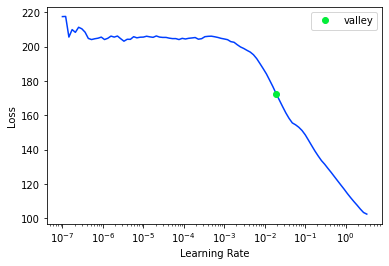

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    1.21       1.00
1    7.67       7.57
2    7.52       6.73
3    5.51       5.62
4   16.49      16.71
XGBoost RMSE:  0.472329


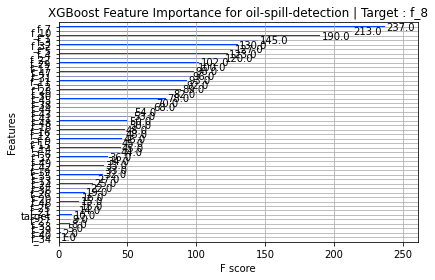

Target Variable: f_7
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular 

  5%|▍         | 2/42 [00:00<00:08,  4.55it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9611788645704575, 'Adjusted R-Squared': 0.9472939329204753, 'RMSE': 2.5566628108375458, 'Time taken': 0.32434988021850586}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9924658155185456, 'Adjusted R-Squared': 0.9897711072003612, 'RMSE': 1.1263087618540588, 'Time taken': 0.14524388313293457}
{'Model': 'BayesianRidge', 'R-Squared': 0.9926168310740004, 'Adjusted R-Squared': 0.9899761356187159, 'RMSE': 1.1149637305504703, 'Time taken': 0.051087379455566406}


 10%|▉         | 4/42 [00:00<00:05,  7.56it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9778664897303219, 'Adjusted R-Squared': 0.9699501247433567, 'RMSE': 1.9304763512218794, 'Time taken': 0.10800051689147949}
{'Model': 'DummyRegressor', 'R-Squared': -0.007197752209153974, 'Adjusted R-Squared': -0.36743636431315774, 'RMSE': 13.022571, 'Time taken': 0.013383626937866211}
{'Model': 'ElasticNet', 'R-Squared': 0.8824464306826408, 'Adjusted R-Squared': 0.8404017234085489, 'RMSE': 4.448947160356419, 'Time taken': 0.020796537399291992}


 17%|█▋        | 7/42 [00:01<00:04,  7.54it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9767241006350046, 'Adjusted R-Squared': 0.9683991439278165, 'RMSE': 1.9796689568877524, 'Time taken': 0.3620598316192627}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9915571089437859, 'Adjusted R-Squared': 0.988537388784994, 'RMSE': 1.1922983151266282, 'Time taken': 0.03887438774108887}


 26%|██▌       | 11/42 [00:01<00:05,  5.55it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9956756775958945, 'Adjusted R-Squared': 0.9941290221374918, 'RMSE': 0.8532933684595048, 'Time taken': 0.7392637729644775}
{'Model': 'GammaRegressor', 'R-Squared': 0.8848603486662631, 'Adjusted R-Squared': 0.8436790135177002, 'RMSE': 4.403031500810644, 'Time taken': 0.02943563461303711}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -4.5847473607019325, 'Adjusted R-Squared': -6.582211745186565, 'RMSE': 30.66486826710979, 'Time taken': 0.15514206886291504}


 29%|██▊       | 12/42 [00:02<00:08,  3.54it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9944984520804139, 'Adjusted R-Squared': 0.99253074516027, 'RMSE': 0.9624580019632013, 'Time taken': 0.7027058601379395}


 33%|███▎      | 14/42 [00:03<00:07,  3.50it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.993721924616817, 'Adjusted R-Squared': 0.9914764815965544, 'RMSE': 1.028140816365566, 'Time taken': 0.5078239440917969}
{'Model': 'HuberRegressor', 'R-Squared': 0.9923157066965902, 'Adjusted R-Squared': 0.989567309821648, 'RMSE': 1.1374735434231356, 'Time taken': 0.1356203556060791}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9492200885862602, 'Adjusted R-Squared': 0.9310579304893751, 'RMSE': 2.9240534, 'Time taken': 0.032013654708862305}


 38%|███▊      | 16/42 [00:03<00:05,  5.17it/s]

{'Model': 'KernelRidge', 'R-Squared': -10.18151659229861, 'Adjusted R-Squared': -14.180745154507601, 'RMSE': 43.390004369216975, 'Time taken': 0.07593822479248047}
{'Model': 'Lars', 'R-Squared': -31.669617876948358, 'Adjusted R-Squared': -43.35437171614886, 'RMSE': 74.16711142476085, 'Time taken': 0.09253239631652832}


 43%|████▎     | 18/42 [00:03<00:04,  5.92it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9139524702887744, 'Adjusted R-Squared': 0.8831763465234455, 'RMSE': 3.8063484326810646, 'Time taken': 0.15717840194702148}
{'Model': 'Lasso', 'R-Squared': 0.9039464408423631, 'Adjusted R-Squared': 0.8695915182239382, 'RMSE': 4.021574037108757, 'Time taken': 0.030578136444091797}


 48%|████▊     | 20/42 [00:04<00:04,  4.62it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9905980804231893, 'Adjusted R-Squared': 0.9872353500636001, 'RMSE': 1.2581939818302856, 'Time taken': 0.5828580856323242}
{'Model': 'LassoLars', 'R-Squared': -0.007197771722326607, 'Adjusted R-Squared': -0.3674363908054945, 'RMSE': 13.022570454167347, 'Time taken': 0.030256271362304688}


 57%|█████▋    | 24/42 [00:04<00:02,  6.51it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9925839525064118, 'Adjusted R-Squared': 0.9899314975634497, 'RMSE': 1.117443539000611, 'Time taken': 0.293076753616333}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9926678709008285, 'Adjusted R-Squared': 0.9900454305660884, 'RMSE': 1.1111031763516495, 'Time taken': 0.07966327667236328}
{'Model': 'LinearRegression', 'R-Squared': 0.9926317419993133, 'Adjusted R-Squared': 0.9899963796487027, 'RMSE': 1.1138372804088754, 'Time taken': 0.028786420822143555}
{'Model': 'LinearSVR', 'R-Squared': 0.9855958081754155, 'Adjusted R-Squared': 0.9804439439461845, 'RMSE': 1.557341245133178, 'Time taken': 0.1155240535736084}


 64%|██████▍   | 27/42 [00:06<00:05,  2.99it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.8378956186570283, 'Adjusted R-Squared': 0.7799166793445786, 'RMSE': 5.22440352860761, 'Time taken': 1.6436796188354492}
{'Model': 'NuSVR', 'R-Squared': 0.8374357200346619, 'Adjusted R-Squared': 0.7792922914339206, 'RMSE': 5.231809232991103, 'Time taken': 0.11420679092407227}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9318918868351109, 'Adjusted R-Squared': 0.9075320507396396, 'RMSE': 3.386403950068233, 'Time taken': 0.020459890365600586}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9574137819450415, 'Adjusted R-Squared': 0.942182214903487, 'RMSE': 2.6777737156125556, 'Time taken': 0.04688906669616699}


 71%|███████▏  | 30/42 [00:06<00:02,  4.88it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9811886184246151, 'Adjusted R-Squared': 0.9744604600509373, 'RMSE': 1.7797118166182668, 'Time taken': 0.04772806167602539}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9784748612547736, 'Adjusted R-Squared': 0.9707760890028313, 'RMSE': 1.9037605247692624, 'Time taken': 0.07234311103820801}


 79%|███████▊  | 33/42 [00:19<00:14,  1.66s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.023330492283657245, 'Adjusted R-Squared': -0.3893392085018994, 'RMSE': 13.126450195244905, 'Time taken': 12.441037654876709}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9097039993389165, 'Adjusted R-Squared': 0.8774083494674342, 'RMSE': 3.8991827917733337, 'Time taken': 0.10825443267822266}


 88%|████████▊ | 37/42 [00:20<00:04,  1.07it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9896784100201538, 'Adjusted R-Squared': 0.9859867464507197, 'RMSE': 1.3182951036309702, 'Time taken': 1.3460769653320312}
{'Model': 'Ridge', 'R-Squared': 0.9896638460198134, 'Adjusted R-Squared': 0.9859669734283598, 'RMSE': 1.3192248480968283, 'Time taken': 0.018080711364746094}
{'Model': 'RidgeCV', 'R-Squared': 0.9925430902366101, 'Adjusted R-Squared': 0.9898760203212371, 'RMSE': 1.1205178554696653, 'Time taken': 0.04718375205993652}
{'Model': 'SGDRegressor', 'R-Squared': 0.980206727960664, 'Adjusted R-Squared': 0.9731273824867409, 'RMSE': 1.8255685040653298, 'Time taken': 0.11372089385986328}


 95%|█████████▌| 40/42 [00:21<00:01,  1.75it/s]

{'Model': 'SVR', 'R-Squared': 0.8448892504140273, 'Adjusted R-Squared': 0.7894116830438619, 'RMSE': 5.110463441916686, 'Time taken': 0.06567621231079102}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9926317419993133, 'Adjusted R-Squared': 0.9899963796487027, 'RMSE': 1.1138372804088754, 'Time taken': 0.021708011627197266}
{'Model': 'TweedieRegressor', 'R-Squared': 0.8814759291140601, 'Adjusted R-Squared': 0.8390841081402569, 'RMSE': 4.467274273928275, 'Time taken': 0.05688667297363281}
{'Model': 'XGBRegressor', 'R-Squared': 0.9929776791161203, 'Adjusted R-Squared': 0.9904660460992583, 'RMSE': 1.0873759, 'Time taken': 0.7398662567138672}


100%|██████████| 42/42 [00:22<00:00,  1.90it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9925075287356876, 'Adjusted R-Squared': 0.9898277397433423, 'RMSE': 1.123186514719105, 'Time taken': 0.20830273628234863}
Project: oil-spill-detection
oil-spill-detection
Target: f_7
f_7
Target Standard Deviation: 12.63527774810791
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.99       1.00  0.85        0.74
GradientBoostingRegressor                    0.99       0.99  0.96        0.70
HistGradientBoostingRegressor                0.99       0.99  1.03        0.51
XGBRegressor                                 0.99       0.99  1.09        0.74
LassoLarsIC                                  0.99       0.99  1.11        0.08
TransformedTargetRegressor                   0.99       0.99  1.11        0.02
LinearRegression                             0.99       0.99  1.11        0.03
BayesianRidge  

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 38.749183654785156.
Better model found at epoch 1 with _rmse value: 17.92417335510254.
Better model found at epoch 2 with _rmse value: 12.335124015808105.
Better model found at epoch 3 with _rmse value: 9.03200912475586.
No improvement since epoch 3: early stopping


<Figure size 432x288 with 0 Axes>

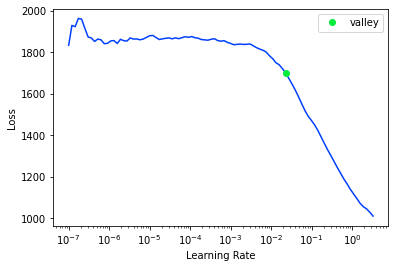

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   38.67      38.71
1   32.21      32.74
2   54.70      56.39
3   38.60      38.43
4   41.53      41.50
XGBoost RMSE:  1.0876455


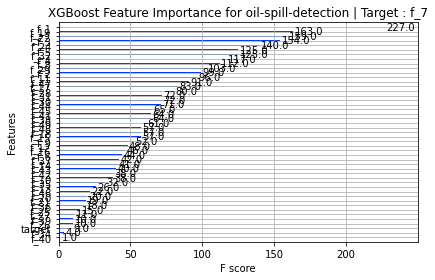

Target Variable: f_6
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular 

  5%|▍         | 2/42 [00:00<00:07,  5.07it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5618770291217978, 'Adjusted R-Squared': 0.40517611253032415, 'RMSE': 4621521.41665482, 'Time taken': 0.23122787475585938}
{'Model': 'BaggingRegressor', 'R-Squared': 0.7548570414748026, 'Adjusted R-Squared': 0.6671781730971773, 'RMSE': 3456978.428335514, 'Time taken': 0.17225050926208496}


 10%|▉         | 4/42 [00:00<00:04,  8.26it/s]

{'Model': 'BayesianRidge', 'R-Squared': -0.013307672644710555, 'Adjusted R-Squared': -0.3757315847585121, 'RMSE': 7028418.666936914, 'Time taken': 0.03196072578430176}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.5206658841066951, 'Adjusted R-Squared': 0.34922521491857883, 'RMSE': 4833994.23531806, 'Time taken': 0.11816143989562988}
{'Model': 'DummyRegressor', 'R-Squared': -0.013307674595545382, 'Adjusted R-Squared': -0.3757315874070908, 'RMSE': 7028418.673702521, 'Time taken': 0.01382756233215332}
{'Model': 'ElasticNet', 'R-Squared': 0.8377752215650762, 'Adjusted R-Squared': 0.7797532205190086, 'RMSE': 2812195.7840381223, 'Time taken': 0.02724003791809082}


 17%|█▋        | 7/42 [00:00<00:03,  9.88it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -0.009449690106990039, 'Adjusted R-Squared': -0.3704937398532857, 'RMSE': 7015026.201942319, 'Time taken': 0.21622538566589355}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.5389809899354194, 'Adjusted R-Squared': 0.37409097903640887, 'RMSE': 4740742.590081904, 'Time taken': 0.03882026672363281}


 26%|██▌       | 11/42 [00:01<00:05,  5.91it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.7366874854592946, 'Adjusted R-Squared': 0.6425100167549548, 'RMSE': 3582801.1769783753, 'Time taken': 0.7627754211425781}
{'Model': 'GammaRegressor', 'R-Squared': -202833.2245395834, 'Adjusted R-Squared': -275379.77200264606, 'RMSE': 3144543276.204064, 'Time taken': 0.03264045715332031}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.040084238890346624, 'Adjusted R-Squared': -0.41208517104820763, 'RMSE': 7120675.841942094, 'Time taken': 0.1509101390838623}


 29%|██▊       | 12/42 [00:02<00:08,  3.63it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.7561703388876577, 'Adjusted R-Squared': 0.6689611900226594, 'RMSE': 3447706.006737356, 'Time taken': 0.712496280670166}


 33%|███▎      | 14/42 [00:03<00:08,  3.47it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.35896006117226753, 'Adjusted R-Squared': 0.129683002759429, 'RMSE': 5590227.755218467, 'Time taken': 0.5476701259613037}
{'Model': 'HuberRegressor', 'R-Squared': 0.7311088081763868, 'Adjusted R-Squared': 0.6349360461372843, 'RMSE': 3620555.8068348616, 'Time taken': 0.13451004028320312}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.5250492033649828, 'Adjusted R-Squared': 0.35517629069990375, 'RMSE': 4811840.9990012115, 'Time taken': 0.03324294090270996}


 38%|███▊      | 16/42 [00:03<00:05,  5.10it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.9262450640514328, 'Adjusted R-Squared': 0.8998655614128942, 'RMSE': 1896192.8431718545, 'Time taken': 0.07838034629821777}
{'Model': 'Lars', 'R-Squared': -0.8607493532886572, 'Adjusted R-Squared': -1.5262728446108773, 'RMSE': 9524252.407101056, 'Time taken': 0.09054207801818848}


 45%|████▌     | 19/42 [00:03<00:03,  6.03it/s]

{'Model': 'LarsCV', 'R-Squared': 0.8299032818087532, 'Adjusted R-Squared': 0.7690657694629788, 'RMSE': 2879618.302613695, 'Time taken': 0.15791988372802734}
{'Model': 'Lasso', 'R-Squared': 0.9440842180071258, 'Adjusted R-Squared': 0.9240851426958059, 'RMSE': 1651026.93891386, 'Time taken': 0.13998866081237793}


 50%|█████     | 21/42 [00:04<00:03,  5.98it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9360214873570126, 'Adjusted R-Squared': 0.913138661667185, 'RMSE': 1766054.1993378785, 'Time taken': 0.252485990524292}
{'Model': 'LassoLars', 'R-Squared': 0.9432088965036056, 'Adjusted R-Squared': 0.922896749997596, 'RMSE': 1663899.5784414136, 'Time taken': 0.10070228576660156}


 57%|█████▋    | 24/42 [00:04<00:02,  7.73it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9413247980683042, 'Adjusted R-Squared': 0.9203387769394494, 'RMSE': 1691275.0979525733, 'Time taken': 0.23476505279541016}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9393863334628813, 'Adjusted R-Squared': 0.9177069928766125, 'RMSE': 1718985.5884411058, 'Time taken': 0.06981062889099121}
{'Model': 'LinearRegression', 'R-Squared': 0.9433386472172752, 'Adjusted R-Squared': 0.9230729079008262, 'RMSE': 1661997.7346857535, 'Time taken': 0.02831435203552246}
{'Model': 'LinearSVR', 'R-Squared': -0.040992982856561166, 'Adjusted R-Squared': -0.4133189402286157, 'RMSE': 7123785.9065633705, 'Time taken': 0.0273284912109375}


 64%|██████▍   | 27/42 [00:06<00:05,  2.84it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.04064188147437919, 'Adjusted R-Squared': -0.41284226243966793, 'RMSE': 7122584.466183449, 'Time taken': 1.7401368618011475}
{'Model': 'NuSVR', 'R-Squared': -0.02907599325180632, 'Adjusted R-Squared': -0.39713966967033554, 'RMSE': 7082893.006472852, 'Time taken': 0.11127161979675293}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.8585398939415535, 'Adjusted R-Squared': 0.8079446735264887, 'RMSE': 2626055.7858661516, 'Time taken': 0.019925832748413086}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.8738400188552262, 'Adjusted R-Squared': 0.8287171058910371, 'RMSE': 2479977.643072265, 'Time taken': 0.04866766929626465}


 71%|███████▏  | 30/42 [00:06<00:02,  4.12it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.2875504633510211, 'Adjusted R-Squared': 0.03273274586343011, 'RMSE': 5893374.127387538, 'Time taken': 0.29332804679870605}
{'Model': 'PoissonRegressor', 'R-Squared': -3331044.042152822, 'Adjusted R-Squared': -4522439.714163685, 'RMSE': 12743162187.85437, 'Time taken': 0.0809786319732666}


 76%|███████▌  | 32/42 [00:30<00:38,  3.82s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.031047002142745583, 'Adjusted R-Squared': -0.39981563794562525, 'RMSE': 7089672.761757249, 'Time taken': 23.320432662963867}


 79%|███████▊  | 33/42 [00:30<00:28,  3.20s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.627794821510878, 'Adjusted R-Squared': 0.4946703416133088, 'RMSE': 4259691.659644306, 'Time taken': 0.4374403953552246}


 90%|█████████ | 38/42 [00:32<00:05,  1.34s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.7288949105868656, 'Adjusted R-Squared': 0.6319303165631898, 'RMSE': 3635430.0547426506, 'Time taken': 1.5885391235351562}
{'Model': 'Ridge', 'R-Squared': 0.9385512493703495, 'Adjusted R-Squared': 0.9165732290721533, 'RMSE': 1730786.4503689676, 'Time taken': 0.01505732536315918}
{'Model': 'RidgeCV', 'R-Squared': 0.9426492817418227, 'Adjusted R-Squared': 0.9221369810509418, 'RMSE': 1672077.445140321, 'Time taken': 0.0264284610748291}
{'Model': 'SGDRegressor', 'R-Squared': 0.9059231198197613, 'Adjusted R-Squared': 0.8722751845728145, 'RMSE': 2141550.9505279693, 'Time taken': 0.03993582725524902}
{'Model': 'SVR', 'R-Squared': -0.03106694992602943, 'Adjusted R-Squared': -0.399842720337529, 'RMSE': 7089741.343777023, 'Time taken': 0.10488152503967285}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9433386472172752, 'Adjusted R-Squared': 0.9230729079008262, 'RMSE': 1661997.7346857535, 'Time taken': 0.023746252059936523}
{'Model': 'Twee

 98%|█████████▊| 41/42 [00:33<00:00,  1.06it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.6175737888993038, 'Adjusted R-Squared': 0.4807936112063541, 'RMSE': 4317782.714226059, 'Time taken': 0.7336990833282471}


100%|██████████| 42/42 [00:33<00:00,  1.26it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.349307938746909, 'Adjusted R-Squared': 0.11657866136441675, 'RMSE': 5632156.4751545265, 'Time taken': 0.23273134231567383}
Project: oil-spill-detection
oil-spill-detection
Target: f_6
f_6
Target Standard Deviation: 2456285.689183205
                               Adjusted R-Squared   R-Squared           RMSE  \
Model                                                                          
Lasso                                        0.92        0.94     1651026.94   
TransformedTargetRegressor                   0.92        0.94     1661997.73   
LinearRegression                             0.92        0.94     1661997.73   
LassoLars                                    0.92        0.94     1663899.58   
RidgeCV                                      0.92        0.94     1672077.45   
LassoLarsCV                                  0.92        0.94     1691275.10   
LassoLarsIC                                  0.92        0.94     1718985.59   
Ridge

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 7123934.0.
Better model found at epoch 1 with _rmse value: 7123926.0.
Better model found at epoch 2 with _rmse value: 7123808.5.
Better model found at epoch 3 with _rmse value: 7122487.5.
Better model found at epoch 4 with _rmse value: 7111680.0.
Better model found at epoch 5 with _rmse value: 7032714.0.
No improvement since epoch 5: early stopping


<Figure size 432x288 with 0 Axes>

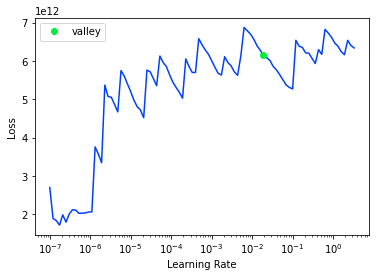

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
    actual  predicted
0   469800  462601.12
1  1035000  861673.88
2   847968  838621.56
3   202500  179180.59
4   132500  135935.80
XGBoost RMSE:  4317810.4584239945


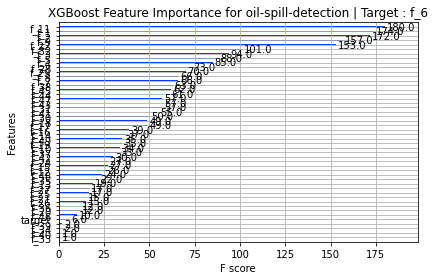

Target Variable: f_5
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_4', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_4', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular 

  5%|▍         | 2/42 [00:00<00:09,  4.05it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.02062411403223885, 'Adjusted R-Squared': -0.3296636116058653, 'RMSE': 43.978753788305944, 'Time taken': 0.3371415138244629}
{'Model': 'BaggingRegressor', 'R-Squared': 0.07246752793535749, 'Adjusted R-Squared': -0.2592776628030913, 'RMSE': 42.79891672375918, 'Time taken': 0.1819150447845459}


 10%|▉         | 4/42 [00:00<00:05,  6.82it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.13418768732663455, 'Adjusted R-Squared': -0.17548240990690478, 'RMSE': 41.35043610189598, 'Time taken': 0.05343270301818848}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.6174918690419879, 'Adjusted R-Squared': -1.1960108586993412, 'RMSE': 56.51832318474225, 'Time taken': 0.1131126880645752}
{'Model': 'DummyRegressor', 'R-Squared': -6.170032102170708e-05, 'Adjusted R-Squared': -0.35774800189569356, 'RMSE': 44.4407738810249, 'Time taken': 0.01277780532836914}
{'Model': 'ElasticNet', 'R-Squared': 0.11788450369512116, 'Adjusted R-Squared': -0.19761665921684268, 'RMSE': 41.73793334298123, 'Time taken': 0.024641036987304688}


 17%|█▋        | 7/42 [00:01<00:05,  6.11it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.13312614650885002, 'Adjusted R-Squared': -0.1769236259076925, 'RMSE': 41.375777465599924, 'Time taken': 0.48697400093078613}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.8092525165982232, 'Adjusted R-Squared': -1.456357431293938, 'RMSE': 59.77475546059834, 'Time taken': 0.04197835922241211}


 26%|██▌       | 11/42 [00:02<00:06,  5.08it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.06810422651835535, 'Adjusted R-Squared': -0.26520156107726933, 'RMSE': 42.899466016396744, 'Time taken': 0.8451743125915527}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.5729369358009784, 'Adjusted R-Squared': -2.4931844529852696, 'RMSE': 71.28247758036277, 'Time taken': 0.11800670623779297}


 29%|██▊       | 12/42 [00:02<00:08,  3.39it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.12842672385102727, 'Adjusted R-Squared': -0.18330386396867815, 'RMSE': 41.48777729911015, 'Time taken': 0.7008192539215088}


 33%|███▎      | 14/42 [00:03<00:08,  3.37it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.00039176756534786694, 'Adjusted R-Squared': -0.3571323447652941, 'RMSE': 44.430697128363086, 'Time taken': 0.5202746391296387}
{'Model': 'HuberRegressor', 'R-Squared': 0.07351157999550717, 'Adjusted R-Squared': -0.257860190663034, 'RMSE': 42.77482221492736, 'Time taken': 0.1420271396636963}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.03677931205910645, 'Adjusted R-Squared': -0.4075981900948451, 'RMSE': 45.24924911481455, 'Time taken': 0.03223466873168945}


 40%|████      | 17/42 [00:03<00:04,  5.84it/s]

{'Model': 'KernelRidge', 'R-Squared': -3.615877874848347, 'Adjusted R-Squared': -5.266812297239361, 'RMSE': 95.476253817517, 'Time taken': 0.05480551719665527}
{'Model': 'Lars', 'R-Squared': -38157.5624501188, 'Adjusted R-Squared': -51805.51544322698, 'RMSE': 8680.889297891175, 'Time taken': 0.05249524116516113}


 45%|████▌     | 19/42 [00:03<00:03,  6.62it/s]

{'Model': 'LarsCV', 'R-Squared': 0.08076241162085873, 'Adjusted R-Squared': -0.24801599590160772, 'RMSE': 42.60711248495778, 'Time taken': 0.177046537399292}
{'Model': 'Lasso', 'R-Squared': 0.13579528917883066, 'Adjusted R-Squared': -0.1732998263703467, 'RMSE': 41.312029438957765, 'Time taken': 0.033882856369018555}


 48%|████▊     | 20/42 [00:04<00:06,  3.17it/s]

{'Model': 'LassoCV', 'R-Squared': 0.1408492307501633, 'Adjusted R-Squared': -0.1664382706603622, 'RMSE': 41.19105420618522, 'Time taken': 1.0190379619598389}
{'Model': 'LassoLars', 'R-Squared': -6.170032102170708e-05, 'Adjusted R-Squared': -0.35774800189569356, 'RMSE': 44.4407738810249, 'Time taken': 0.04219985008239746}


 57%|█████▋    | 24/42 [00:05<00:03,  5.14it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.12877976665905588, 'Adjusted R-Squared': -0.18282455037529632, 'RMSE': 41.47937384908681, 'Time taken': 0.24005413055419922}
{'Model': 'LassoLarsIC', 'R-Squared': 0.08893798253837049, 'Adjusted R-Squared': -0.23691631567783267, 'RMSE': 42.41721846091604, 'Time taken': 0.0796194076538086}
{'Model': 'LinearRegression', 'R-Squared': 0.011148834164369736, 'Adjusted R-Squared': -0.3425278601856001, 'RMSE': 44.190984838861084, 'Time taken': 0.06156444549560547}
{'Model': 'LinearSVR', 'R-Squared': 0.10919725341258979, 'Adjusted R-Squared': -0.20941102821356417, 'RMSE': 41.94295158273623, 'Time taken': 0.041611433029174805}


 64%|██████▍   | 27/42 [00:07<00:05,  2.86it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.10905630958911494, 'Adjusted R-Squared': -0.20960238260163955, 'RMSE': 41.94626958224286, 'Time taken': 1.6328232288360596}
{'Model': 'NuSVR', 'R-Squared': 0.06731287013110754, 'Adjusted R-Squared': -0.266275957340248, 'RMSE': 42.91767704558553, 'Time taken': 0.10760140419006348}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.11740864529426742, 'Adjusted R-Squared': -0.19826271514792881, 'RMSE': 41.7491896175073, 'Time taken': 0.02048492431640625}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.11081484622618443, 'Adjusted R-Squared': -0.20721488030605606, 'RMSE': 41.90485255032795, 'Time taken': 0.04555249214172363}


 71%|███████▏  | 30/42 [00:07<00:02,  4.76it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.2622051429642862, 'Adjusted R-Squared': -0.7136507780391037, 'RMSE': 49.92673754779761, 'Time taken': 0.037198781967163086}
{'Model': 'PoissonRegressor', 'R-Squared': 0.08826018493783105, 'Adjusted R-Squared': -0.23783653723768916, 'RMSE': 42.43299397511518, 'Time taken': 0.08797049522399902}


 76%|███████▌  | 32/42 [00:19<00:19,  1.94s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.065819526912682, 'Adjusted R-Squared': -0.4470250511369258, 'RMSE': 45.878588902194736, 'Time taken': 11.94389533996582}


 79%|███████▊  | 33/42 [00:19<00:15,  1.69s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -99.46949007008226, 'Adjusted R-Squared': -135.4038332338343, 'RMSE': 445.43600075867084, 'Time taken': 0.5276384353637695}


 88%|████████▊ | 37/42 [00:21<00:04,  1.08it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.12044003977011042, 'Adjusted R-Squared': -0.194147099290215, 'RMSE': 41.677430971767166, 'Time taken': 1.7079293727874756}
{'Model': 'Ridge', 'R-Squared': 0.026240339752872766, 'Adjusted R-Squared': -0.32203866281726756, 'RMSE': 43.852474528227916, 'Time taken': 0.024348974227905273}
{'Model': 'RidgeCV', 'R-Squared': 0.0713257273500737, 'Adjusted R-Squared': -0.26082784461960795, 'RMSE': 42.82525154205645, 'Time taken': 0.035976409912109375}
{'Model': 'SGDRegressor', 'R-Squared': 0.09463000267399913, 'Adjusted R-Squared': -0.22918846352289157, 'RMSE': 42.28450633552057, 'Time taken': 0.03998994827270508}


 93%|█████████▎| 39/42 [00:21<00:01,  1.50it/s]

{'Model': 'SVR', 'R-Squared': 0.062218725229964966, 'Adjusted R-Squared': -0.27319209567318614, 'RMSE': 43.03472119936371, 'Time taken': 0.1034390926361084}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.011148834164369736, 'Adjusted R-Squared': -0.3425278601856001, 'RMSE': 44.190984838861084, 'Time taken': 0.022449254989624023}
{'Model': 'TweedieRegressor', 'R-Squared': 0.11576577363090534, 'Adjusted R-Squared': -0.20049318324563203, 'RMSE': 41.7880279042736, 'Time taken': 0.037423133850097656}


 98%|█████████▊| 41/42 [00:22<00:00,  1.71it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.03845917089817252, 'Adjusted R-Squared': -0.3054495927951817, 'RMSE': 43.576473, 'Time taken': 0.7690262794494629}


100%|██████████| 42/42 [00:22<00:00,  1.84it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.010636319104163405, 'Adjusted R-Squared': -0.3432236835520117, 'RMSE': 44.202435303880435, 'Time taken': 0.21258783340454102}
Project: oil-spill-detection
oil-spill-detection
Target: f_5
f_5
Target Standard Deviation: 45.558474835461006
                               Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
LassoCV                                     -0.17       0.14   41.19   
Lasso                                       -0.17       0.14   41.31   
BayesianRidge                               -0.18       0.13   41.35   
ElasticNetCV                                -0.18       0.13   41.38   
LassoLarsCV                                 -0.18       0.13   41.48   
GradientBoostingRegressor                   -0.18       0.13   41.49   
RandomForestRegressor                       -0.19       0.12   41.68   
ElasticNet                                  -0.20       0.12   41.74   
O

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 92.341796875.
Better model found at epoch 1 with _rmse value: 71.92539978027344.
Better model found at epoch 2 with _rmse value: 45.31245040893555.
No improvement since epoch 2: early stopping


<Figure size 432x288 with 0 Axes>

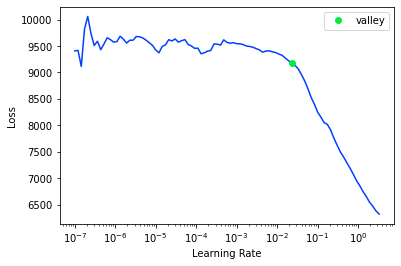

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0     175      41.58
1     159     134.47
2      59      87.73
3     107      98.26
4     147     119.86
XGBoost RMSE:  43.585613


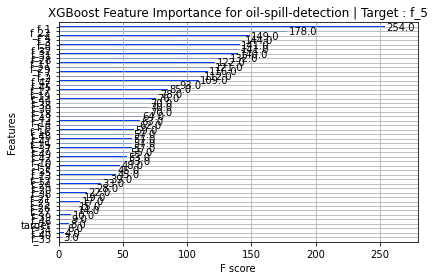

Target Variable: f_4
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_3', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_3', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular 

  5%|▍         | 2/42 [00:00<00:08,  4.57it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9063304747529556, 'Adjusted R-Squared': 0.8728282357959836, 'RMSE': 159.67481215766458, 'Time taken': 0.3120543956756592}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9715874075577621, 'Adjusted R-Squared': 0.9614252394579835, 'RMSE': 87.9412602982018, 'Time taken': 0.1525113582611084}


 10%|▉         | 4/42 [00:00<00:05,  7.55it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.7865171245621614, 'Adjusted R-Squared': 0.7101619355369491, 'RMSE': 241.0564609811185, 'Time taken': 0.0516817569732666}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9610823032328235, 'Adjusted R-Squared': 0.9471628350460232, 'RMSE': 102.92261673976246, 'Time taken': 0.10885286331176758}
{'Model': 'DummyRegressor', 'R-Squared': -0.0008767059762351259, 'Adjusted R-Squared': -0.35885450592393964, 'RMSE': 521.94836, 'Time taken': 0.013220548629760742}
{'Model': 'ElasticNet', 'R-Squared': 0.6030342067767467, 'Adjusted R-Squared': 0.461053740587408, 'RMSE': 328.7106664392315, 'Time taken': 0.02854633331298828}


 17%|█▋        | 7/42 [00:00<00:03,  8.91it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.6121037269186667, 'Adjusted R-Squared': 0.4733671036997956, 'RMSE': 324.93392593608417, 'Time taken': 0.24764204025268555}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.870844288696916, 'Adjusted R-Squared': 0.8246499102016523, 'RMSE': 187.49688726550934, 'Time taken': 0.06142139434814453}


 21%|██▏       | 9/42 [00:01<00:07,  4.56it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9799956306821405, 'Adjusted R-Squared': 0.9728407832618842, 'RMSE': 73.79036971391979, 'Time taken': 0.7647664546966553}
{'Model': 'GammaRegressor', 'R-Squared': 0.5666302875613586, 'Adjusted R-Squared': 0.41162944150666203, 'RMSE': 343.45238165427696, 'Time taken': 0.028958559036254883}


 26%|██▌       | 11/42 [00:01<00:05,  5.47it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.2782568990302683, 'Adjusted R-Squared': -2.0931079067126266, 'RMSE': 787.4783115330848, 'Time taken': 0.19036364555358887}


 29%|██▊       | 12/42 [00:02<00:08,  3.51it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9642477954972367, 'Adjusted R-Squared': 0.9514605106750805, 'RMSE': 98.64808689655884, 'Time taken': 0.7081913948059082}


 33%|███▎      | 14/42 [00:03<00:08,  3.39it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9728606819560187, 'Adjusted R-Squared': 0.9631539185680255, 'RMSE': 85.94818691791836, 'Time taken': 0.5581409931182861}
{'Model': 'HuberRegressor', 'R-Squared': 0.768643126830454, 'Adjusted R-Squared': 0.6858950481055799, 'RMSE': 250.9449482906883, 'Time taken': 0.13039636611938477}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.6580758238246225, 'Adjusted R-Squared': 0.5357817754115313, 'RMSE': 305.07187, 'Time taken': 0.032601356506347656}


 40%|████      | 17/42 [00:03<00:04,  5.92it/s]

{'Model': 'KernelRidge', 'R-Squared': -2.0627423994074645, 'Adjusted R-Squared': -3.158175812334221, 'RMSE': 913.0456459330866, 'Time taken': 0.05039501190185547}
{'Model': 'Lars', 'R-Squared': -49.37442062688839, 'Adjusted R-Squared': -67.39154917227182, 'RMSE': 3702.902581621247, 'Time taken': 0.04858040809631348}


 45%|████▌     | 19/42 [00:03<00:03,  6.30it/s]

{'Model': 'LarsCV', 'R-Squared': 0.5052220136643752, 'Adjusted R-Squared': 0.32825762439104966, 'RMSE': 366.98003585833555, 'Time taken': 0.18503046035766602}
{'Model': 'Lasso', 'R-Squared': 0.7671907040294403, 'Adjusted R-Squared': 0.6839231456166124, 'RMSE': 251.7314127553689, 'Time taken': 0.08845257759094238}


 48%|████▊     | 20/42 [00:04<00:06,  3.17it/s]

{'Model': 'LassoCV', 'R-Squared': 0.7627745226012458, 'Adjusted R-Squared': 0.6779274540425673, 'RMSE': 254.10775485262485, 'Time taken': 0.979295015335083}
{'Model': 'LassoLars', 'R-Squared': 0.6013717959017262, 'Adjusted R-Squared': 0.4587967448008837, 'RMSE': 329.3982335841652, 'Time taken': 0.05545520782470703}


 57%|█████▋    | 24/42 [00:05<00:03,  5.33it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.7568794185755204, 'Adjusted R-Squared': 0.6699238821536263, 'RMSE': 257.24569597643034, 'Time taken': 0.23578333854675293}
{'Model': 'LassoLarsIC', 'R-Squared': 0.7794509119697098, 'Adjusted R-Squared': 0.7005683914333287, 'RMSE': 245.01342853716034, 'Time taken': 0.06771349906921387}
{'Model': 'LinearRegression', 'R-Squared': 0.8001120103704149, 'Adjusted R-Squared': 0.7286192257583736, 'RMSE': 233.254807983678, 'Time taken': 0.030347108840942383}
{'Model': 'LinearSVR', 'R-Squared': 0.09146142523634637, 'Adjusted R-Squared': -0.23349032778131074, 'RMSE': 497.28909994156294, 'Time taken': 0.027396678924560547}


 64%|██████▍   | 27/42 [00:06<00:05,  2.92it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.11625048039144081, 'Adjusted R-Squared': -0.5154933529402042, 'RMSE': 551.2112639938878, 'Time taken': 1.6334874629974365}
{'Model': 'NuSVR', 'R-Squared': 0.06865464635130636, 'Adjusted R-Squared': -0.2644542757566204, 'RMSE': 503.4920650405946, 'Time taken': 0.10915517807006836}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.6295874453427714, 'Adjusted R-Squared': 0.49710412287412764, 'RMSE': 317.52659294971204, 'Time taken': 0.02179265022277832}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.6222729899724093, 'Adjusted R-Squared': 0.4871735484296944, 'RMSE': 320.6463309930851, 'Time taken': 0.04799532890319824}


 71%|███████▏  | 30/42 [00:07<00:02,  4.82it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.5742928956172044, 'Adjusted R-Squared': 0.42203269040000024, 'RMSE': 340.40247050244875, 'Time taken': 0.04089784622192383}
{'Model': 'PoissonRegressor', 'R-Squared': 0.7712893358245352, 'Adjusted R-Squared': 0.6894877114114127, 'RMSE': 249.50569444476525, 'Time taken': 0.08925056457519531}


 76%|███████▌  | 32/42 [00:23<00:25,  2.53s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.06747150475906949, 'Adjusted R-Squared': -0.44926788237362714, 'RMSE': 539.0330570019321, 'Time taken': 15.938243627548218}


 79%|███████▊  | 33/42 [00:23<00:19,  2.18s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -7.314623309193355, 'Adjusted R-Squared': -10.28846668255448, 'RMSE': 1504.383438211706, 'Time taken': 0.5149271488189697}


 88%|████████▊ | 37/42 [00:25<00:05,  1.13s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9779992108718457, 'Adjusted R-Squared': 0.9701303154902431, 'RMSE': 77.3849281357199, 'Time taken': 1.5029752254486084}
{'Model': 'Ridge', 'R-Squared': 0.7491332397019093, 'Adjusted R-Squared': 0.6594071721500374, 'RMSE': 261.31167578552646, 'Time taken': 0.022481441497802734}
{'Model': 'RidgeCV', 'R-Squared': 0.7491332397025787, 'Adjusted R-Squared': 0.6594071721509462, 'RMSE': 261.3116757851778, 'Time taken': 0.05349135398864746}
{'Model': 'SGDRegressor', 'R-Squared': 0.628924418356398, 'Adjusted R-Squared': 0.4962039548488324, 'RMSE': 317.810647271889, 'Time taken': 0.11189556121826172}


 95%|█████████▌| 40/42 [00:25<00:01,  1.43it/s]

{'Model': 'SVR', 'R-Squared': 0.06098199666983517, 'Adjusted R-Squared': -0.2748711578059171, 'RMSE': 505.5617562113384, 'Time taken': 0.07086968421936035}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.8001120103704149, 'Adjusted R-Squared': 0.7286192257583736, 'RMSE': 233.254807983678, 'Time taken': 0.02225947380065918}
{'Model': 'TweedieRegressor', 'R-Squared': 0.5750634482236816, 'Adjusted R-Squared': 0.42307884211390356, 'RMSE': 340.0942576383792, 'Time taken': 0.06358766555786133}
{'Model': 'XGBRegressor', 'R-Squared': 0.9775413077714745, 'Adjusted R-Squared': 0.9695086368284253, 'RMSE': 78.18609, 'Time taken': 0.7661528587341309}


100%|██████████| 42/42 [00:26<00:00,  1.59it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9741204303904467, 'Adjusted R-Squared': 0.9648642339607525, 'RMSE': 83.92972094602227, 'Time taken': 0.23769736289978027}
Project: oil-spill-detection
oil-spill-detection
Target: f_4
f_4
Target Standard Deviation: 522.6741333007812
                               Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
ExtraTreesRegressor                          0.97       0.98   73.79   
RandomForestRegressor                        0.97       0.98   77.38   
XGBRegressor                                 0.97       0.98   78.19   
LGBMRegressor                                0.96       0.97   83.93   
HistGradientBoostingRegressor                0.96       0.97   85.95   
BaggingRegressor                             0.96       0.97   87.94   
GradientBoostingRegressor                    0.95       0.96   98.65   
DecisionTreeRegressor                        0.95       0.96  102.92   
AdaBoo

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1000.9324951171875.
Better model found at epoch 1 with _rmse value: 969.5985717773438.
Better model found at epoch 2 with _rmse value: 615.9957885742188.
No improvement since epoch 2: early stopping


<Figure size 432x288 with 0 Axes>

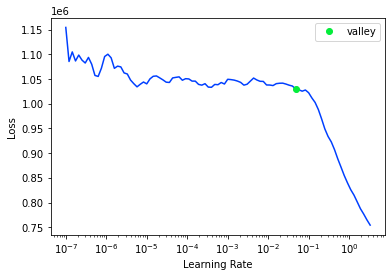

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0 1159.03    1222.19
1  459.91     432.22
2 1298.81    1322.10
3  388.73     384.48
4 1286.49    1259.96
XGBoost RMSE:  78.18858


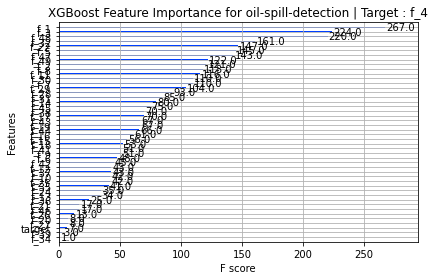

Target Variable: f_3
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_2', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_2', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular 

  5%|▍         | 2/42 [00:00<00:08,  4.50it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9755629472930193, 'Adjusted R-Squared': 0.966822687565705, 'RMSE': 93.10148549485784, 'Time taken': 0.3214232921600342}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9928965585668366, 'Adjusted R-Squared': 0.9903559116308875, 'RMSE': 50.195709795431696, 'Time taken': 0.15101408958435059}


 10%|▉         | 4/42 [00:00<00:05,  7.44it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.9473436294439314, 'Adjusted R-Squared': 0.9285103290260674, 'RMSE': 136.66511096550605, 'Time taken': 0.05850839614868164}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9888175903018246, 'Adjusted R-Squared': 0.9848180423075866, 'RMSE': 62.97959994482257, 'Time taken': 0.10411858558654785}
{'Model': 'DummyRegressor', 'R-Squared': -0.0027667556607593458, 'Adjusted R-Squared': -0.361420558780301, 'RMSE': 596.3925, 'Time taken': 0.014092206954956055}
{'Model': 'ElasticNet', 'R-Squared': 0.814790892857234, 'Adjusted R-Squared': 0.7485482194996025, 'RMSE': 256.3087111437976, 'Time taken': 0.026233434677124023}


 17%|█▋        | 7/42 [00:00<00:03,  8.92it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.8240648930997294, 'Adjusted R-Squared': 0.7611391979310195, 'RMSE': 249.80921366409137, 'Time taken': 0.24414300918579102}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9781869163678886, 'Adjusted R-Squared': 0.9703851565286662, 'RMSE': 87.96111582809185, 'Time taken': 0.03892040252685547}


 26%|██▌       | 11/42 [00:01<00:05,  5.65it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9951695620252231, 'Adjusted R-Squared': 0.9934418871291351, 'RMSE': 41.392861723562085, 'Time taken': 0.7883870601654053}
{'Model': 'GammaRegressor', 'R-Squared': 0.7019714178099186, 'Adjusted R-Squared': 0.5953772533769698, 'RMSE': 325.1330784575282, 'Time taken': 0.03141450881958008}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.3133286063824645, 'Adjusted R-Squared': -0.7830592758185284, 'RMSE': 682.5255281594477, 'Time taken': 0.15216422080993652}


 29%|██▊       | 12/42 [00:02<00:08,  3.60it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9955865357911319, 'Adjusted R-Squared': 0.9940079974974492, 'RMSE': 39.565986841594274, 'Time taken': 0.6943984031677246}


 33%|███▎      | 14/42 [00:03<00:07,  3.53it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.995242155900628, 'Adjusted R-Squared': 0.993540445237349, 'RMSE': 41.08064950703657, 'Time taken': 0.5207123756408691}
{'Model': 'HuberRegressor', 'R-Squared': 0.9327020063632065, 'Adjusted R-Squared': 0.9086319210478571, 'RMSE': 154.5016977630946, 'Time taken': 0.12493205070495605}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8881414343845729, 'Adjusted R-Squared': 0.8481336262447486, 'RMSE': 199.18968, 'Time taken': 0.0326993465423584}


 38%|███▊      | 16/42 [00:03<00:05,  5.16it/s]

{'Model': 'KernelRidge', 'R-Squared': -0.4202558455050056, 'Adjusted R-Squared': -0.9282305639702995, 'RMSE': 709.7664886233979, 'Time taken': 0.08170223236083984}
{'Model': 'Lars', 'R-Squared': -2492.367949813709, 'Adjusted R-Squared': -3384.1564866083927, 'RMSE': 29738.933109562953, 'Time taken': 0.09052419662475586}


 43%|████▎     | 18/42 [00:03<00:04,  5.86it/s]

{'Model': 'LarsCV', 'R-Squared': 0.8401507114987052, 'Adjusted R-Squared': 0.7829783382391181, 'RMSE': 238.1154369480241, 'Time taken': 0.16306614875793457}
{'Model': 'Lasso', 'R-Squared': 0.9447445283294977, 'Adjusted R-Squared': 0.9249816224035516, 'RMSE': 139.99735900415754, 'Time taken': 0.07935118675231934}


 48%|████▊     | 20/42 [00:04<00:05,  3.83it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9442820798509044, 'Adjusted R-Squared': 0.9243537726442935, 'RMSE': 140.58197684893136, 'Time taken': 0.7840309143066406}
{'Model': 'LassoLars', 'R-Squared': 0.8286018386692627, 'Adjusted R-Squared': 0.7672988466604589, 'RMSE': 246.56718507268724, 'Time taken': 0.03206348419189453}


 57%|█████▋    | 24/42 [00:04<00:03,  5.74it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9478316218242829, 'Adjusted R-Squared': 0.9291728588271286, 'RMSE': 136.03036565319036, 'Time taken': 0.25423431396484375}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9476552701653232, 'Adjusted R-Squared': 0.9289334324872272, 'RMSE': 136.26009237879836, 'Time taken': 0.08860135078430176}
{'Model': 'LinearRegression', 'R-Squared': 0.946955247734452, 'Adjusted R-Squared': 0.927983037070132, 'RMSE': 137.16819079081776, 'Time taken': 0.051072120666503906}
{'Model': 'LinearSVR', 'R-Squared': 0.5433839272839622, 'Adjusted R-Squared': 0.3800686895972042, 'RMSE': 402.44616655327957, 'Time taken': 0.04556632041931152}


 64%|██████▍   | 27/42 [00:06<00:05,  2.94it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.642168048470017, 'Adjusted R-Squared': 0.5141843577768114, 'RMSE': 356.26384948619125, 'Time taken': 1.6706652641296387}
{'Model': 'NuSVR', 'R-Squared': 0.08225834689911826, 'Adjusted R-Squared': -0.2459850180785692, 'RMSE': 570.548304815998, 'Time taken': 0.10956549644470215}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.8039705133631508, 'Adjusted R-Squared': 0.7338577772667596, 'RMSE': 263.68953782009226, 'Time taken': 0.020693063735961914}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.7868040844604715, 'Adjusted R-Squared': 0.7105515307273554, 'RMSE': 274.9929992751174, 'Time taken': 0.04477334022521973}


 71%|███████▏  | 30/42 [00:06<00:02,  4.75it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.92869245208095, 'Adjusted R-Squared': 0.9031882926062532, 'RMSE': 159.0376496856233, 'Time taken': 0.06415867805480957}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9361322228523871, 'Adjusted R-Squared': 0.9132890032886423, 'RMSE': 150.51268331423563, 'Time taken': 0.08672618865966797}


 76%|███████▌  | 32/42 [00:25<00:28,  2.81s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.004105616802229095, 'Adjusted R-Squared': -0.36323828266580005, 'RMSE': 596.7904927695183, 'Time taken': 17.971956729888916}


 79%|███████▊  | 33/42 [00:25<00:21,  2.38s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.9307645466543424, 'Adjusted R-Squared': 0.9060015012971364, 'RMSE': 156.70991240205302, 'Time taken': 0.3251223564147949}


 88%|████████▊ | 37/42 [00:26<00:06,  1.20s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9948999683045262, 'Adjusted R-Squared': 0.993075869376948, 'RMSE': 42.532277161283254, 'Time taken': 1.3750593662261963}
{'Model': 'Ridge', 'R-Squared': 0.9438319379580501, 'Adjusted R-Squared': 0.9237426310963308, 'RMSE': 141.14871137623828, 'Time taken': 0.015651464462280273}
{'Model': 'RidgeCV', 'R-Squared': 0.9473957083241729, 'Adjusted R-Squared': 0.928581034659096, 'RMSE': 136.59751110465382, 'Time taken': 0.04184603691101074}
{'Model': 'SGDRegressor', 'R-Squared': 0.889211816485524, 'Adjusted R-Squared': 0.8495868457394706, 'RMSE': 198.23435341020772, 'Time taken': 0.10131955146789551}


 93%|█████████▎| 39/42 [00:26<00:02,  1.18it/s]

{'Model': 'SVR', 'R-Squared': 0.15940231433727914, 'Adjusted R-Squared': -0.1412494126515771, 'RMSE': 546.0423068046531, 'Time taken': 0.0738213062286377}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.946955247734452, 'Adjusted R-Squared': 0.927983037070132, 'RMSE': 137.16819079081776, 'Time taken': 0.026200532913208008}
{'Model': 'TweedieRegressor', 'R-Squared': 0.7769583493393997, 'Adjusted R-Squared': 0.6971843283002068, 'RMSE': 281.2711462023472, 'Time taken': 0.10787200927734375}


 98%|█████████▊| 41/42 [00:27<00:00,  1.37it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9963416804502396, 'Adjusted R-Squared': 0.9950332303922962, 'RMSE': 36.02243, 'Time taken': 0.7832934856414795}


100%|██████████| 42/42 [00:28<00:00,  1.49it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9927688526266224, 'Adjusted R-Squared': 0.9901825298434436, 'RMSE': 50.64491004387305, 'Time taken': 0.20837163925170898}
Project: oil-spill-detection
oil-spill-detection
Target: f_3
f_3
Target Standard Deviation: 600.4943237304688
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
XGBRegressor                                 1.00       1.00    36.02   
GradientBoostingRegressor                    0.99       1.00    39.57   
HistGradientBoostingRegressor                0.99       1.00    41.08   
ExtraTreesRegressor                          0.99       1.00    41.39   
RandomForestRegressor                        0.99       0.99    42.53   
BaggingRegressor                             0.99       0.99    50.20   
LGBMRegressor                                0.99       0.99    50.64   
DecisionTreeRegressor                        0.98       0.99    62.98

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 934.02783203125.
Better model found at epoch 1 with _rmse value: 905.5062255859375.
Better model found at epoch 2 with _rmse value: 669.2993774414062.
No improvement since epoch 2: early stopping


<Figure size 432x288 with 0 Axes>

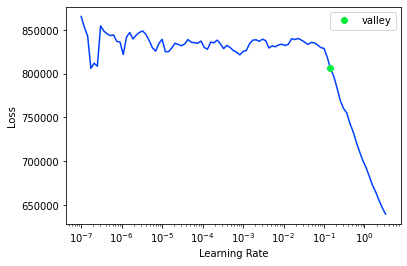

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0  979.18    1006.35
1 1256.10    1296.41
2  102.91     106.05
3   72.24      76.78
4   73.30      48.37
XGBoost RMSE:  36.01861


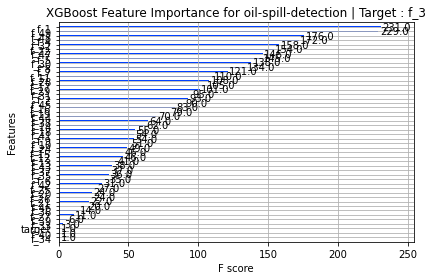

Target Variable: f_2
CATS=====================
['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
CONTS=====================
['f_1', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
49
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['f_1', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_24', 'f_28', 'f_29', 'f_30', 'f_31', 'f_35', 'f_36', 'f_38', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_47', 'f_48', 'f_49']
Categorical variables that made the cut : ['f_22', 'f_23', 'f_25', 'f_26', 'f_27', 'f_32', 'f_33', 'f_34', 'f_37', 'f_39', 'f_40', 'f_46', 'target']
Tabular 

  5%|▍         | 2/42 [00:00<00:07,  5.44it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8398786117937351, 'Adjusted R-Squared': 0.7826089182017134, 'RMSE': 952.7192526735688, 'Time taken': 0.2027759552001953}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8398887879364513, 'Adjusted R-Squared': 0.7826227339867149, 'RMSE': 952.6889782635321, 'Time taken': 0.16942453384399414}
{'Model': 'BayesianRidge', 'R-Squared': 0.8687797333781024, 'Adjusted R-Squared': 0.8218469372870588, 'RMSE': 862.4635033046796, 'Time taken': 0.028626203536987305}


 10%|▉         | 4/42 [00:00<00:04,  8.69it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.8148202370763304, 'Adjusted R-Squared': 0.7485880590963319, 'RMSE': 1024.559135657817, 'Time taken': 0.11792325973510742}
{'Model': 'DummyRegressor', 'R-Squared': -0.005215466001141866, 'Adjusted R-Squared': -0.36474508522782756, 'RMSE': 2387.0958030762094, 'Time taken': 0.012644767761230469}
{'Model': 'ElasticNet', 'R-Squared': 0.9767078048913628, 'Adjusted R-Squared': 0.9683770197795144, 'RMSE': 363.36699548875674, 'Time taken': 0.022088050842285156}


 17%|█▋        | 7/42 [00:00<00:03,  9.72it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.94456955883356, 'Adjusted R-Squared': 0.92474407257695, 'RMSE': 560.5501018525929, 'Time taken': 0.24235844612121582}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.54129747973675, 'Adjusted R-Squared': 0.3772359943871205, 'RMSE': 1612.5226790263546, 'Time taken': 0.06782889366149902}


 26%|██▌       | 11/42 [00:01<00:05,  6.06it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.883414092164621, 'Adjusted R-Squared': 0.841715482792843, 'RMSE': 812.9489934476785, 'Time taken': 0.6747057437896729}
{'Model': 'GammaRegressor', 'R-Squared': -356072.61494735343, 'Adjusted R-Squared': -483427.411534363, 'RMSE': 1420725.4659187356, 'Time taken': 0.030745267868041992}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.03821013331337131, 'Adjusted R-Squared': -0.4095407649364018, 'RMSE': 2425.9558896795766, 'Time taken': 0.16393780708312988}


 29%|██▊       | 12/42 [00:02<00:08,  3.66it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8362657617410288, 'Adjusted R-Squared': 0.7777038809038785, 'RMSE': 963.4074937404415, 'Time taken': 0.7137486934661865}


 33%|███▎      | 14/42 [00:03<00:08,  3.37it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.4665850397849317, 'Adjusted R-Squared': 0.2758015868612942, 'RMSE': 1738.8930198035391, 'Time taken': 0.6113536357879639}
{'Model': 'HuberRegressor', 'R-Squared': 0.9836436459860968, 'Adjusted R-Squared': 0.9777935631636059, 'RMSE': 304.4973512376017, 'Time taken': 0.1323087215423584}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7060063746600681, 'Adjusted R-Squared': 0.6008553699764428, 'RMSE': 1290.9494151644242, 'Time taken': 0.03270530700683594}


 40%|████      | 17/42 [00:03<00:04,  5.59it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.8427996246096421, 'Adjusted R-Squared': 0.7865746728276892, 'RMSE': 943.9892695652612, 'Time taken': 0.07974004745483398}
{'Model': 'Lars', 'R-Squared': -1911457.480991675, 'Adjusted R-Squared': -2595117.8136091353, 'RMSE': 3291718.6100271386, 'Time taken': 0.09425640106201172}


 43%|████▎     | 18/42 [00:03<00:04,  5.67it/s]

{'Model': 'LarsCV', 'R-Squared': 0.17595355990430928, 'Adjusted R-Squared': -0.11877837852407636, 'RMSE': 2161.305268066333, 'Time taken': 0.1622776985168457}
{'Model': 'Lasso', 'R-Squared': 0.8723780075704459, 'Adjusted R-Squared': 0.8267321854606055, 'RMSE': 850.5562271672808, 'Time taken': 0.07473421096801758}


 48%|████▊     | 20/42 [00:04<00:04,  5.11it/s]

{'Model': 'LassoCV', 'R-Squared': 0.8638001066502631, 'Adjusted R-Squared': 0.815086276182109, 'RMSE': 878.6757727684744, 'Time taken': 0.36582088470458984}
{'Model': 'LassoLars', 'R-Squared': 0.7750944050001548, 'Adjusted R-Squared': 0.6946537177374364, 'RMSE': 1129.1207746284042, 'Time taken': 0.0643763542175293}


 57%|█████▋    | 24/42 [00:04<00:02,  6.85it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.8628170412610391, 'Adjusted R-Squared': 0.8137516034638925, 'RMSE': 881.8411300978919, 'Time taken': 0.2677946090698242}
{'Model': 'LassoLarsIC', 'R-Squared': 0.8750607508989878, 'Adjusted R-Squared': 0.8303744501256332, 'RMSE': 841.5689700318683, 'Time taken': 0.08462858200073242}
{'Model': 'LinearRegression', 'R-Squared': 0.8753452837526322, 'Adjusted R-Squared': 0.8307607502043036, 'RMSE': 840.610142005067, 'Time taken': 0.05632209777832031}
{'Model': 'LinearSVR', 'R-Squared': 0.450819887069262, 'Adjusted R-Squared': 0.2543978028823558, 'RMSE': 1764.4025195796498, 'Time taken': 0.0583341121673584}


 64%|██████▍   | 27/42 [00:06<00:04,  3.17it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.5523839063831586, 'Adjusted R-Squared': 0.3922876393231205, 'RMSE': 1592.9168806587052, 'Time taken': 1.5363452434539795}
{'Model': 'NuSVR', 'R-Squared': -0.024276184685825708, 'Adjusted R-Squared': -0.3906231412522889, 'RMSE': 2409.6213682446282, 'Time taken': 0.11229896545410156}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.6859865856728578, 'Adjusted R-Squared': 0.5736752185047558, 'RMSE': 1334.179824013416, 'Time taken': 0.0203399658203125}


 74%|███████▍  | 31/42 [00:06<00:02,  4.96it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.8762539236305096, 'Adjusted R-Squared': 0.8319943780676992, 'RMSE': 837.5408281406291, 'Time taken': 0.37634897232055664}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9669935618569458, 'Adjusted R-Squared': 0.9551883394554155, 'RMSE': 432.55326893272564, 'Time taken': 0.03187704086303711}
{'Model': 'PoissonRegressor', 'R-Squared': -4.931378222019865, 'Adjusted R-Squared': -7.052820067851787, 'RMSE': 5798.532255964363, 'Time taken': 0.07796740531921387}


 76%|███████▌  | 32/42 [00:27<00:41,  4.12s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.029002683129537132, 'Adjusted R-Squared': -0.3970401391393714, 'RMSE': 2415.1745400321033, 'Time taken': 20.462676286697388}


 79%|███████▊  | 33/42 [00:27<00:30,  3.33s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.9798253798882375, 'Adjusted R-Squared': 0.972609639848264, 'RMSE': 338.1761309595393, 'Time taken': 0.4963381290435791}


 88%|████████▊ | 37/42 [00:29<00:07,  1.48s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8717081238274587, 'Adjusted R-Squared': 0.8258227082620971, 'RMSE': 852.7855767214704, 'Time taken': 1.6240172386169434}
{'Model': 'Ridge', 'R-Squared': 0.8505496958642933, 'Adjusted R-Squared': 0.7970966673777997, 'RMSE': 920.4255587845624, 'Time taken': 0.01837158203125}
{'Model': 'RidgeCV', 'R-Squared': 0.8505496958652353, 'Adjusted R-Squared': 0.7970966673790787, 'RMSE': 920.4255587816615, 'Time taken': 0.051296234130859375}
{'Model': 'SGDRegressor', 'R-Squared': 0.5924695270635294, 'Adjusted R-Squared': 0.44671045280158006, 'RMSE': 1519.9185397853646, 'Time taken': 0.08089828491210938}


 93%|█████████▎| 39/42 [00:29<00:03,  1.02s/it]

{'Model': 'SVR', 'R-Squared': -0.02673797550732604, 'Adjusted R-Squared': -0.39396542660118716, 'RMSE': 2412.5153258680257, 'Time taken': 0.08002781867980957}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.8753452837526322, 'Adjusted R-Squared': 0.8307607502043036, 'RMSE': 840.610142005067, 'Time taken': 0.02269291877746582}
{'Model': 'TweedieRegressor', 'R-Squared': 0.9713814440245363, 'Adjusted R-Squared': 0.9611456101355018, 'RMSE': 402.7765026021528, 'Time taken': 0.0624089241027832}


 98%|█████████▊| 41/42 [00:30<00:00,  1.21it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.8978362783830964, 'Adjusted R-Squared': 0.8612959691916492, 'RMSE': 761.00696, 'Time taken': 0.729163408279419}


100%|██████████| 42/42 [00:30<00:00,  1.37it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.48257029507322957, 'Adjusted R-Squared': 0.29750419623080804, 'RMSE': 1712.639463088774, 'Time taken': 0.25788092613220215}
Project: oil-spill-detection
oil-spill-detection
Target: f_2
f_2
Target Standard Deviation: 1799.64771403245
                               Adjusted R-Squared   R-Squared       RMSE  \
Model                                                                      
HuberRegressor                               0.98        0.98     304.50   
RANSACRegressor                              0.97        0.98     338.18   
ElasticNet                                   0.97        0.98     363.37   
TweedieRegressor                             0.96        0.97     402.78   
PassiveAggressiveRegressor                   0.96        0.97     432.55   
ElasticNetCV                                 0.92        0.94     560.55   
XGBRegressor                                 0.86        0.90     761.01   
ExtraTreesRegressor                      

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 2425.815185546875.
Better model found at epoch 1 with _rmse value: 2419.396728515625.
Better model found at epoch 2 with _rmse value: 2389.571044921875.
No improvement since epoch 2: early stopping


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0      16      15.35
1      79      78.00
2    7100    3769.55
3      10       9.81
4     175     167.86
XGBoost RMSE:  761.00684


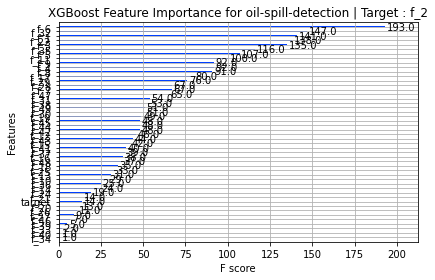

<Figure size 432x288 with 0 Axes>

In [20]:
target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].apply(pd.to_numeric, errors='coerce').dropna()
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].apply(pd.to_numeric, errors='coerce').dropna()

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

  feature  importance
0    f_22      135.00
1    f_25       27.00
2    f_26       20.00
3    f_27        8.00
4    f_32      143.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

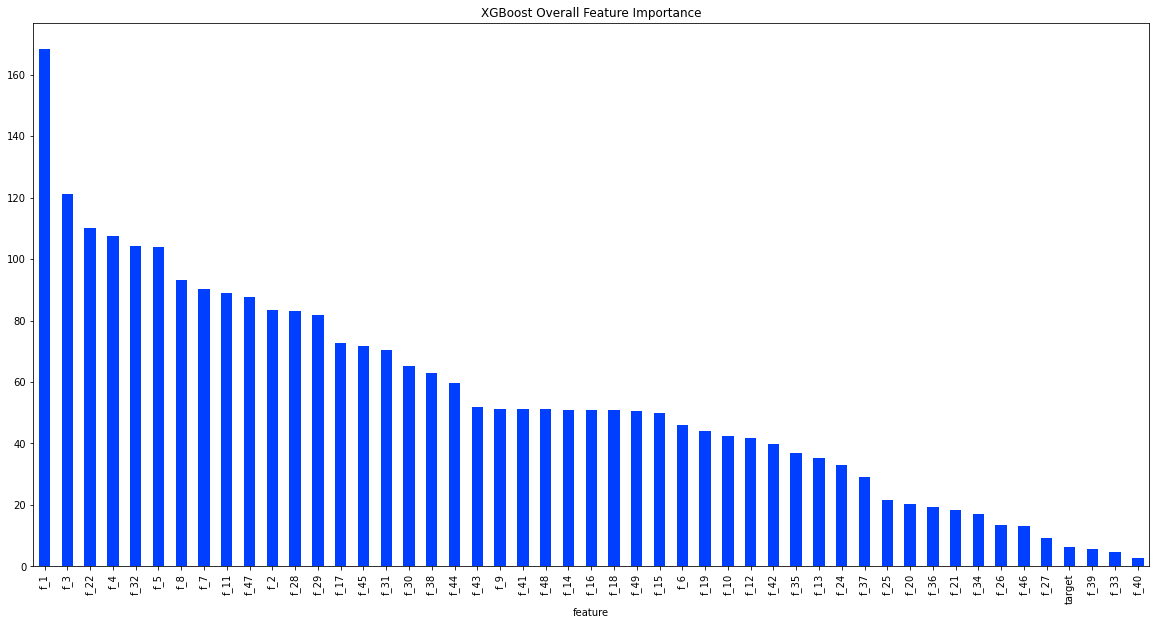

In [21]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [22]:
df.isna().sum()

f_1       0
f_2       0
f_3       0
f_4       0
f_5       0
f_6       0
f_7       0
f_8       0
f_9       0
f_10      0
f_11      0
f_12      0
f_13      0
f_14      0
f_15      0
f_16      0
f_17      0
f_18      0
f_19      0
f_20      0
f_21      0
f_22      0
f_23      0
f_24      0
f_25      0
f_26      0
f_27      0
f_28      0
f_29      0
f_30      0
f_31      0
f_32      0
f_33      0
f_34      0
f_35      0
f_36      0
f_37      0
f_38      0
f_39      0
f_40      0
f_41      0
f_42      0
f_43      0
f_44      0
f_45      0
f_46      0
f_47      0
f_48      0
f_49      0
target    0
dtype: int64

# **To Be Continued...**